In [27]:
# import
import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
import zipcodes
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error

In [28]:
# read zillow data
with open('../data/Zip_Zhvi_SingleFamilyResidence.csv', 'rb') as f:
    df_zillow = pd.read_csv(f).fillna(0)

# read unemployment data
with open('../data/laucnty17.xlsx', 'rb') as f:
    df_labor = pd.read_excel(f, skiprows=range(1, 6)).fillna(0)

# read crime data
with open('../data/district-of-columbia.xls', 'rb') as f:
    df_crime_dc = pd.read_excel(f, skiprows=range(1, 2)).fillna(0)

with open('../data/maryland.xls', 'rb') as f:
    df_crime_md = pd.read_excel(f, skiprows=range(1, 5)).fillna(0)

with open('../data/massachusetts.xls', 'rb') as f:
    df_crime_ma = pd.read_excel(f, skiprows=range(1, 5)).fillna(0)

with open('../data/virginia.xls', 'rb') as f:
    df_crime_va = pd.read_excel(f, skiprows=range(1, 5)).fillna(0)

with open('../data/new-hampshire.xls', 'rb') as f:
    df_crime_nh = pd.read_excel(f, skiprows=range(1, 5)).fillna(0)

In [29]:
# crime columns
#dc_col_list = df_crime_dc.iloc[:, 3:12].columns.tolist()
md_col_list = df_crime_md.iloc[:, 3:12].columns.tolist()
ma_col_list = df_crime_ma.iloc[:, 3:12].columns.tolist()
va_col_list = df_crime_va.iloc[:, 3:12].columns.tolist()
nh_col_list = df_crime_nh.iloc[:, 3:12].columns.tolist()

# crime sum: simplified by summing all offense types
#dc_sum = df_crime_dc[dc_col_list].sum(axis=1)
md_sum = df_crime_md[md_col_list].sum(axis=1)
ma_sum = df_crime_ma[ma_col_list].sum(axis=1)
va_sum = df_crime_va[va_col_list].sum(axis=1)
nh_sum = df_crime_nh[nh_col_list].sum(axis=1)

# crime ratio: offense sum / population
df_md = df_crime_md
df_md['City'] = df_crime_md.iloc[:, 0]
df_md['State'] = 'md'
df_md['Population'] = df_crime_md.iloc[:, 1]
df_md['CrimeRatio'] = md_sum/df_crime_md.iloc[:, 1]
df_md = df_crime_md[['City', 'Population', 'CrimeRatio', 'State']]

df_ma = df_crime_ma
df_ma['City'] = df_crime_ma.iloc[:, 0]
df_ma['State'] = 'ma'
df_ma['Population'] = df_crime_ma.iloc[:, 1]
df_ma['CrimeRatio'] = ma_sum/df_crime_ma.iloc[:, 1]
df_ma = df_crime_ma[['City', 'Population', 'CrimeRatio', 'State']]

df_va = df_crime_va
df_va['City'] = df_crime_va.iloc[:, 0]
df_va['State'] = 'va'
df_va['Population'] = df_crime_va.iloc[:, 1]
df_va['CrimeRatio'] = va_sum/df_crime_va.iloc[:, 1]
df_va = df_crime_va[['City', 'Population', 'CrimeRatio', 'State']]

df_nh = df_crime_nh
df_nh['City'] = df_crime_nh.iloc[:, 0]
df_nh['State'] = 'nh'
df_nh['Population'] = df_crime_nh.iloc[:, 1]
df_nh['CrimeRatio'] = nh_sum/df_crime_nh.iloc[:, 1]
df_nh = df_crime_nh[['City', 'Population', 'CrimeRatio', 'State']]

# combine dataframe
df_crime = pd.concat([df_md, df_ma, df_va, df_nh])

# remove unneeded column
df_crime.drop(['Population'], axis=1, inplace=True)

# convert to lowercase
df_crime[['City', 'State']] = df_crime[['City', 'State']].apply(
  lambda x: x.astype(str).str.lower().map(lambda x: x.strip())
)

In [30]:
# restructure labor columns
df_labor = pd.DataFrame(df_labor.iloc[:, [3,9]])
df_labor.columns = ['Location', 'Unemployment']
df_labor[['CountyName', 'State']] = df_labor['Location'].str.split(',', expand=True)
df_labor.drop(['Location'], axis=1, inplace=True)

In [31]:
# convert non-timeseries
df_zillow[['City', 'State', 'Metro', 'CountyName']] = df_zillow[['City', 'State', 'Metro', 'CountyName']].astype(str)
df_zillow[['RegionID', 'RegionName', 'SizeRank']] = df_zillow[['RegionID', 'RegionName', 'SizeRank']].astype(int)

# convert to lowercase
df_zillow[['City', 'State', 'Metro', 'CountyName']] = df_zillow[['City', 'State', 'Metro', 'CountyName']].apply(
  lambda x: x.astype(str).str.lower().map(lambda x: x.strip())
)
df_labor[['CountyName', 'State']] = df_labor[['CountyName', 'State']].apply(
  lambda x: x.astype(str).str.lower().map(lambda x: x.strip())
)

# remove redundant suffix
df_labor[['CountyName']] = df_labor['CountyName'].str.rstrip('county').map(lambda x: x.strip())

In [32]:
# arkansas metro areas
hot_springs = df_zillow.loc[(df_zillow['Metro'] == 'hot springs') & (df_zillow['State'] == 'ar')]
little_rock = df_zillow.loc[(df_zillow['Metro'] == 'little rock') & (df_zillow['State'] == 'ar')]
fayetteville = df_zillow.loc[(df_zillow['Metro'] == 'fayetteville') & (df_zillow['State'] == 'ar')]
searcy = df_zillow.loc[(df_zillow['Metro'] == 'searcy') & (df_zillow['State'] == 'ar')]

In [33]:
# merge dataframes
df = pd.merge(df_zillow, df_labor, on=['CountyName', 'State'])
df = pd.merge(df, df_crime, on=['City', 'State'])

# timeseries data
ts_start = df.columns.get_loc('1996-04') + 1
ts_end = df.columns.get_loc('2017-09')
date_columns = df.iloc[:, ts_start:ts_end].columns.tolist()

# ensure integer timeseries
df[date_columns] = df[date_columns].astype(int)

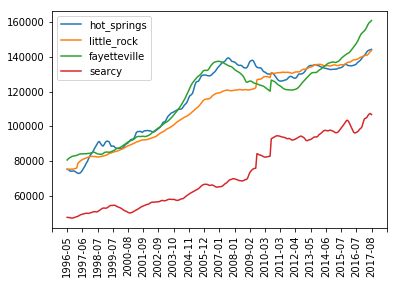

In [34]:
# timeseries plot
fig, ax = plt.subplots()
ax.plot(hot_springs[date_columns].mean(), linestyle='solid')
ax.plot(little_rock[date_columns].mean(), linestyle='solid')
ax.plot(fayetteville[date_columns].mean(), linestyle='solid')
ax.plot(searcy[date_columns].mean(), linestyle='solid')

# decrease ticks
xmin, xmax = ax.get_xlim()
ax.set_xticks(np.round(np.linspace(xmin, xmax, 23), 2))

# rotate ticks + show legend
plt.xticks(rotation=90)
plt.gca().legend(('hot_springs', 'little_rock', 'fayetteville', 'searcy'))

# show overall plot
plt.show()

In [35]:
# remove rows with unemployment >= 4.5%
df = df[df.Unemployment < 4.5]

# remove rows with crime >= 5%
df = df[df.CrimeRatio < 0.05]

# remove redundant columns
df.drop(['Unemployment'], axis=1, inplace=True)
df.drop(['CrimeRatio'], axis=1, inplace=True)

In [36]:
# filter specific states
df = df.loc[df['State'].isin(['md','va', 'nh', 'ma', 'dc'])]

# remove specific cities
df = df.loc[-((df['Metro'] == 'baltimore') & (df['State'] == 'md'))]

In [37]:
# train: collapse column by median
train_start = df.columns.get_loc('1997-01')
train_stop = df.columns.get_loc('2017-01')
test_stop = df.columns.get_loc('2017-09')
train_columns = df.iloc[:, train_start:train_stop].columns.tolist()
test_columns = df.iloc[:, (train_stop + 1):test_stop].columns.tolist()

In [38]:
# remove rows with 0's beginning (1997-01) with trainset
date_columns = df.iloc[:, train_start:test_stop].columns.tolist()

df[date_columns] = df[date_columns].replace(0, np.nan).dropna(
    axis=0,
    how='any',
    subset=date_columns
)

In [39]:
#
# transpose dataframe: left column data, right column value
#
#     date1  val1
#     date2  val2
#      ...   ...
#     daten  valn
#
df_train = df[train_columns].median().T
df_test = df[test_columns].median().T

#
# build arima model:
#
#     AR: autoregression, uses observations from previous time steps as input to
#         a regression equation to predict the value at the next time step.
#
#     I: integrated, use of differencing of raw observations, or subtracting an
#         observation from previous time step. The goal is to attain a time
#         series that is stationary.
#
#     MA: moving average, uses the dependency between an observation and a residual
#         error from a moving average model applied to lagged observations.
#
model = ARIMA(df_train, order=(5,1,0))
model_fit = model.fit()
print(model_fit.summary())

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
C:\Users\jeff1\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will 

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  239
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -1949.509
Method:                       css-mle   S.D. of innovations            841.082
Date:                Sun, 18 Nov 2018   AIC                           3913.018
Time:                        05:58:11   BIC                           3937.353
Sample:                    02-01-1997   HQIC                          3922.825
                         - 12-01-2016                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        949.3473    639.632      1.484      0.139    -304.308    2203.002
ar.L1.D.y      0.5983      0.064      9.307      0.000       0.472       0.724
ar.L2.D.y      0.0194      0.075      0.258      0.7

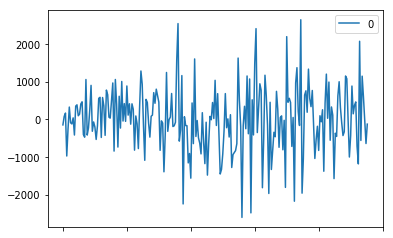

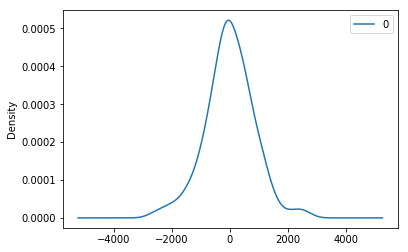

In [40]:
# plot residual errors
residuals = DataFrame(model_fit.resid)
residuals.plot()
plt.show()

# plot kernel density estimation
residuals.plot(kind='kde')
plt.show()

In [41]:
# descriptive statistics on residual
print(residuals.describe())

                 0
count   239.000000
mean      1.740369
std     842.930634
min   -2603.951766
25%    -460.324424
50%     -12.413748
75%     481.351488
max    2639.978807


In [ ]:
#
# rolling prediction (verify model): month +2, since the train
#     includes 2017-01.
#
# Note: rolling prediction is required since there is an implicit
#       dependence on observations in prior time steps inheritted
#       when autogressive (AR) model was defined.
#
history = [x for x in df_train]
predictions = list()
iterations = (12-len(df_test)) + 18

for t in range(iterations):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)

    if t > 10:
        year = 2018
        month = (t+2) % 12
        if month == 0:
            month = 12
    else:
        year = 2017
        month = t+2
        if month == 0:
            month = 12

    print('\n===============================================')
    print('date: {}-{:01d}'.format(year, month))
    print('-----------------------------------------------')

    #
    # observation: if current value doesn't exist from test, append current
    #     predition, to ensure successive rolling prediction computed.
    #
    try:
        obs = df_test[t]
        print('predicted={:03f}, expected={:03f}'.format(float(yhat), obs))
        print('prediction difference: {:03f}'.format(abs(1-float(yhat)/obs)))
        print('\n===============================================')
        error = mean_squared_error(df_test, predictions)
        print('Test MSE: {:03f}\n\n'.format(error))
    except:
        obs = yhat
        print('predicted={:03f}'.format(float(yhat)))

    history.append(obs)

C:\Users\jeff1\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
C:\Users\jeff1\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
C:\Users\jeff1\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an arra


date: 2017-2
-----------------------------------------------
predicted=352651.824387, expected=356350.000000
prediction difference: 0.010378

predicted=352651.824387

date: 2017-3
-----------------------------------------------
predicted=354530.719940, expected=357950.000000
prediction difference: 0.009552

predicted=354530.719940


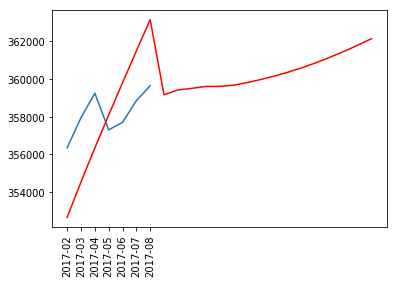

In [17]:
# plot rolling prediction
plt.plot(df_test)
plt.plot(predictions, color='red')
plt.xticks(rotation=90)
plt.show()

In [22]:
# stationarity test
def difference(dataset, delta):
    diff = list()
    for i in range(1, len(dataset)):
        value = dataset[i] - dataset[i - delta]
        diff.append(value)
    return pd.Series(diff)

def compute_arima(df_train):
    #
    # Note: rolling prediction is required since there is an implicit
    #       dependence on observations in prior time steps inheritted
    #       when autogressive (AR) model was defined.
    #
    history = [x for x in df_train]
    predictions = list()
    iterations = (12-len(df_test)) + 18

    for t in range(iterations):
        #
        # determine stationarity value: no need to difference more than
        #     one third the length of the given series.
        #
        # @delta, the difference factor.
        #
        for delta in range(int(len(history) / 3)):
            stationary = difference(history, delta)
            stationary.index = history[1:]
            result = adfuller(stationary)
            print('delta: {}, p: {}'.format(delta, result[1]))

            #
            # generate model: use dickey-fuller significance test using
            #     custom 'difference' function. Sometimes, statsmodel's
            #     arima algorithm will not agree with our pvalue, so it
            #     is forced to search for another significant difference.
            #
            if (result[1] <= 0.05):
                try:
                    model = ARIMA(history, order=(delta, 2, 2))
                    model_fit = model.fit(disp=0)
                    break
                except:
                    model_fit = False
                    print('stationarity not adequate')
                    continue

        #
        # bad condition: no significant stationarity found on given delta,
        #     so have to pick any next one that works.
        #        
        if not model_fit:
            for delta2 in range(delta, history):
                model = ARIMA(history, order=(delta, 2, 2))
                model_fit = model.fit(disp=0)
                try:
                    model = ARIMA(history, order=(delta2, 2, 2))
                    model_fit = model.fit(disp=0)
                    break
                except:
                    model_fit = False
                    print('bad condition: stationarity not adequate')
                    continue

        # generate forecast
        output = model_fit.forecast()
        yhat = output[0]

        #
        # observation: if current value doesn't exist from test, append current
        #     predition, to ensure successive rolling prediction computed.
        #
        try:
            obs = df_test[t]
        except:
            obs = yhat
        history.append(obs)
        
        predictions.append(yhat)
        print('predictions: {}'.format(predictions))

    return(predictions)

def get_zipcode(city, state):
    result = zipcodes.filter_by(
        zipcodes.list_all(),
        active=True,
        city=city,
        state=state
    )

    if result and result[0] and result[0]['zip_code']:
        return(result[0]['zip_code'])
    else:
        return(0)

In [19]:
# add zipcode column
df['zip_code'] = df[['City', 'State']].apply(
    lambda x: get_zipcode(
        x['City'].upper(),
        x['State'].upper()
    ),
    axis=1
)

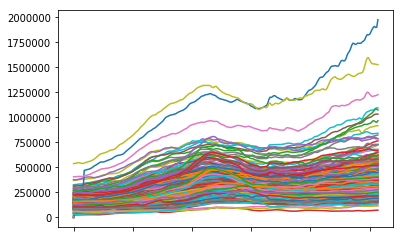

In [20]:
# group by zipcode
df_zipcode = df.groupby('zip_code').agg(np.median).dropna().T

#
# remove columns: column 0 indicates an NaN column
#
df_zipcode_clean = df_zipcode.drop([
    'RegionName',
    'RegionID',
    'SizeRank'
], axis=0)
df_zipcode_clean = df_zipcode_clean.drop([0], axis=1)

df_zipcode_clean.plot(legend=None)
plt.show()

In [23]:
# iterate columns
results = []
for column in df_zipcode_clean:
    predictions = compute_arima(df_zipcode_clean[column])
    results.append({
        'zip_code': df_zipcode_clean[column].name,
        'predictions': predictions
    })

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:846: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:1100: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
C:\Users\jeff1\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\jeff1\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\jeff1\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1738: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= self.b) & cond0


delta: 0, p: nan
delta: 1, p: 0.43581480343739437
delta: 2, p: 0.09602268561265981
delta: 3, p: 0.12330830782157487
delta: 4, p: 0.13016438413596815
delta: 5, p: 0.10373052767375313
delta: 6, p: 0.1603877865387051
delta: 7, p: 0.042705747735187594
predictions: [array([343970.13104049])]
delta: 0, p: nan
delta: 1, p: 0.803479384907082
delta: 2, p: 0.5858174147921911
delta: 3, p: 0.4905951809167539
delta: 4, p: 0.6352038915219083
delta: 5, p: 0.5339802889265176
delta: 6, p: 0.5145835730456775
delta: 7, p: 0.2100479142753809
delta: 8, p: 0.09267183040773197
delta: 9, p: 1.2471231454619788e-29


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:674: RuntimeWarning: invalid value encountered in double_scalars
  tmp[kiter] = (macoefs[kiter]-b *macoefs[j-kiter-1])/(1-b**2)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:676: RuntimeWarning: divide by zero encountered in log
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))


stationarity not adequate
delta: 10, p: 1.4604156810534592e-13
predictions: [array([343970.13104049]), array([375742.41165911])]
delta: 0, p: nan
delta: 1, p: 0.07300563080716499
delta: 2, p: 0.016393091796733494
predictions: [array([343970.13104049]), array([375742.41165911]), array([354616.6154621])]
delta: 0, p: nan
delta: 1, p: 0.01955523947984029
predictions: [array([343970.13104049]), array([375742.41165911]), array([354616.6154621]), array([362401.67226232])]
delta: 0, p: nan
delta: 1, p: 0.015378042382430518
predictions: [array([343970.13104049]), array([375742.41165911]), array([354616.6154621]), array([362401.67226232]), array([356351.11904271])]
delta: 0, p: nan
delta: 1, p: 0.005467578110466673
stationarity not adequate
delta: 2, p: 0.0038685256225786547
predictions: [array([343970.13104049]), array([375742.41165911]), array([354616.6154621]), array([362401.67226232]), array([356351.11904271]), array([359877.29217599])]
delta: 0, p: nan
delta: 1, p: 0.005722751589500754
pre

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\adfvalues.py:207: RuntimeWarning: invalid value encountered in greater
  if teststat > maxstat[N-1]:
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\adfvalues.py:209: RuntimeWarning: invalid value encountered in less
  elif teststat < minstat[N-1]:
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\adfvalues.py:211: RuntimeWarning: invalid value encountered in less_equal
  if teststat <= starstat[N-1]:
C:\Users\jeff1\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in less_equal


delta: 1, p: [5.42177308e-05]
predictions: [array([343970.13104049]), array([375742.41165911]), array([354616.6154621]), array([362401.67226232]), array([356351.11904271]), array([359877.29217599]), array([360177.01073446]), array([360751.42724862]), array([362096.88164207])]
delta: 0, p: [nan]
delta: 1, p: [5.22014134e-05]
predictions: [array([343970.13104049]), array([375742.41165911]), array([354616.6154621]), array([362401.67226232]), array([356351.11904271]), array([359877.29217599]), array([360177.01073446]), array([360751.42724862]), array([362096.88164207]), array([363531.40484366])]
delta: 0, p: [nan]
delta: 1, p: [5.04307235e-05]
predictions: [array([343970.13104049]), array([375742.41165911]), array([354616.6154621]), array([362401.67226232]), array([356351.11904271]), array([359877.29217599]), array([360177.01073446]), array([360751.42724862]), array([362096.88164207]), array([363531.40484366]), array([364999.24655593])]
delta: 0, p: [nan]
delta: 1, p: [4.89639068e-05]
pred

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:607: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:609: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:650: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:651: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:634: RuntimeWarning: invalid value encountered in log
  invarcoefs = -np.log((1-params)/(1+params))


stationarity not adequate
delta: 8, p: 1.8510848557543063e-06
stationarity not adequate
delta: 9, p: 4.222089952338704e-07
stationarity not adequate
delta: 10, p: 0.00010546651779715653
stationarity not adequate
delta: 11, p: 0.0003965359118261057
stationarity not adequate
delta: 12, p: 0.0011514255366822834
stationarity not adequate
delta: 13, p: 0.00277494320914523
stationarity not adequate
delta: 14, p: 0.0056337135778882505
stationarity not adequate
delta: 15, p: 0.009876911526231704
stationarity not adequate
delta: 16, p: 0.0005959289512536749
stationarity not adequate
delta: 17, p: 0.0010429076466532464
stationarity not adequate
delta: 18, p: 0.03184380730554397
stationarity not adequate
delta: 19, p: 0.0428452786947904
stationarity not adequate
delta: 20, p: 0.05544982106698026
delta: 21, p: 0.07101846902958575
delta: 22, p: 0.08778485839305611
delta: 23, p: 0.10495615628549015
delta: 24, p: 0.12249667563469557
delta: 25, p: 0.1402871263963803
delta: 26, p: 0.15819235881319155
d

delta: 101, p: 0.6080426197308995
delta: 102, p: 0.6012896074408366
delta: 103, p: 0.6275286899984545
delta: 104, p: 0.6251422125527959
delta: 105, p: 0.6256644808101253
delta: 106, p: 0.6285435157440515
delta: 107, p: 0.6320991761220627
delta: 108, p: 0.6339823693370863
delta: 109, p: 0.633561240944314
delta: 110, p: 0.6303147834772361
delta: 111, p: 0.6255734586369743
delta: 112, p: 0.6175592766566388
delta: 113, p: 0.60904330963418
delta: 114, p: 0.6020449457081043
delta: 115, p: 0.5961129426023485
delta: 116, p: 0.5891235820143365
delta: 117, p: 0.5839050931574636
delta: 118, p: 0.5785256571973802
delta: 119, p: 0.5720792484998917
delta: 120, p: 0.5670740594672679
delta: 121, p: 0.5616957917508418
delta: 122, p: 0.5544189458765235
delta: 123, p: 0.5475316215151992
delta: 124, p: 0.5392137377291573
delta: 125, p: 0.5301519359652633
delta: 126, p: 0.5272435602748327
delta: 127, p: 0.528850113646172
delta: 128, p: 0.530397801745907
delta: 129, p: 0.5320424533120743
predictions: [array

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:676: RuntimeWarning: divide by zero encountered in true_divide
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))


stationarity not adequate
delta: 2, p: 2.677836604032454e-26
stationarity not adequate
delta: 3, p: 0.8123090338872787
delta: 4, p: 0.9290595419969089
delta: 5, p: 4.2996358867416894e-29
stationarity not adequate
delta: 6, p: 1.2382330902423492e-05
stationarity not adequate
delta: 7, p: 3.0832551943311346e-05
stationarity not adequate
delta: 8, p: 7.021130526235338e-05
stationarity not adequate
delta: 9, p: 0.00015849570342332133
stationarity not adequate
delta: 10, p: 0.0003451790809214926
stationarity not adequate
delta: 11, p: 0.0006684742561735625
stationarity not adequate
delta: 12, p: 0.0011911100227103581
stationarity not adequate
delta: 13, p: 0.0020260124311119866
stationarity not adequate
delta: 14, p: 0.00315151016190712
stationarity not adequate
delta: 15, p: 0.004602947368255569
stationarity not adequate
delta: 16, p: 0.006265506029975987
stationarity not adequate
delta: 17, p: 0.008190152697339689
stationarity not adequate
delta: 18, p: 0.042341556637158655
stationarity n

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([237935.5319805]), array([237935.5319805]), array([237935.5319805]), array([237935.5319805]), array([367350.60780762])]
delta: 0, p: nan
delta: 1, p: 1.0610136987867687e-28


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([237935.5319805]), array([237935.5319805]), array([237935.5319805]), array([237935.5319805]), array([367350.60780762]), array([359565.50666012])]
delta: 0, p: nan
delta: 1, p: 9.804955723710645e-29
stationarity not adequate
delta: 2, p: 0.7918889183596036
delta: 3, p: 1.1585753499682012e-10
stationarity not adequate
delta: 4, p: 1.4214808686817362e-07
stationarity not adequate
delta: 5, p: 1.5094981032356517e-06


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([237935.5319805]), array([237935.5319805]), array([237935.5319805]), array([237935.5319805]), array([367350.60780762]), array([359565.50666012]), array([404209.51953415])]
delta: 0, p: nan
delta: 1, p: 9.074048365331419e-29
stationarity not adequate
delta: 2, p: 8.037933773406925e-12
stationarity not adequate
delta: 3, p: 2.2326390645428693e-08
stationarity not adequate
delta: 4, p: 1.4405181583837817e-07
stationarity not adequate
delta: 5, p: 9.402096628398966e-06
stationarity not adequate
delta: 6, p: 6.6612327286000195e-06
stationarity not adequate
delta: 7, p: 1.4470399030413198e-06
stationarity not adequate
delta: 8, p: 1.1545359917702169e-05
stationarity not adequate
delta: 9, p: 0.011056788117704554
stationarity not adequate
delta: 10, p: 0.01304181095505855
stationarity not adequate
delta: 11, p: 0.015308724513061292
stationarity not adequate
delta: 12, p: 0.017990705941205467
stationarity not adequate
delta: 13, p: 0.022201804870262305
stationarity not adeq

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:634: RuntimeWarning: divide by zero encountered in log
  invarcoefs = -np.log((1-params)/(1+params))


stationarity not adequate
delta: 13, p: [0.14004072]
delta: 14, p: [0.14511302]
delta: 15, p: [0.15269801]
delta: 16, p: [0.16083816]
delta: 17, p: [0.17100536]
delta: 18, p: [0.18404967]
delta: 19, p: [0.01814565]
stationarity not adequate
delta: 20, p: [0.03732874]
stationarity not adequate
delta: 21, p: [0.05696399]
delta: 22, p: [0.07731824]
delta: 23, p: [0.0961473]
delta: 24, p: [0.38774112]
delta: 25, p: [0.3973103]
delta: 26, p: [0.40481501]
delta: 27, p: [0.41547074]
delta: 28, p: [0.42992645]
delta: 29, p: [0.30942702]
delta: 30, p: [0.31924197]
delta: 31, p: [0.32855705]
delta: 32, p: [0.33548268]
delta: 33, p: [0.34443238]
delta: 34, p: [0.48705823]
delta: 35, p: [0.36045491]
delta: 36, p: [0.36781934]
delta: 37, p: [0.37657851]
delta: 38, p: [0.3817717]
delta: 39, p: [0.5271071]
delta: 40, p: [0.53412961]
delta: 41, p: [0.37366944]
delta: 42, p: [0.37791357]
delta: 43, p: [0.38244232]
delta: 44, p: [0.38267421]
delta: 45, p: [0.38213519]
delta: 46, p: [0.38294685]
delta: 4

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([237935.5319805]), array([237935.5319805]), array([237935.5319805]), array([237935.5319805]), array([367350.60780762]), array([359565.50666012]), array([404209.51953415]), array([404209.51953415]), array([439304.88057704]), array([460157.97580476]), array([477785.53336115]), array([477785.53336115]), array([477785.53336115]), array([478812.09584287])]
delta: 0, p: [nan]
delta: 1, p: [0.93348074]
delta: 2, p: [0.9005491]
delta: 3, p: [0.30133634]
delta: 4, p: [0.9549322]
delta: 5, p: [0.91000254]
delta: 6, p: [0.97446659]
delta: 7, p: [0.93764882]
delta: 8, p: [0.94562965]
delta: 9, p: [0.78557964]
delta: 10, p: [0.61828098]
delta: 11, p: [6.97634517e-06]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([237935.5319805]), array([237935.5319805]), array([237935.5319805]), array([237935.5319805]), array([367350.60780762]), array([359565.50666012]), array([404209.51953415]), array([404209.51953415]), array([439304.88057704]), array([460157.97580476]), array([477785.53336115]), array([477785.53336115]), array([477785.53336115]), array([478812.09584287]), array([498291.39480932])]
delta: 0, p: [nan]
delta: 1, p: [0.93819172]
delta: 2, p: [0.04656544]
stationarity not adequate
delta: 3, p: [0.9091591]
delta: 4, p: [0.9678879]
delta: 5, p: [0.91494978]
delta: 6, p: [0.35788271]
delta: 7, p: [0.68666784]
delta: 8, p: [0.9796025]
delta: 9, p: [0.88333721]
delta: 10, p: [0.77034151]
delta: 11, p: [4.92857917e-06]
stationarity not adequate
delta: 12, p: [8.89103384e-06]
stationarity not adequate
delta: 13, p: [0.01102368]
stationarity not adequate
delta: 14, p: [0.00888897]
stationarity not adequate
delta: 15, p: [0.1376005]
delta: 16, p: [0.15409668]
delta: 17, p: [0.3599486

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([237935.5319805]), array([237935.5319805]), array([237935.5319805]), array([237935.5319805]), array([367350.60780762]), array([359565.50666012]), array([404209.51953415]), array([404209.51953415]), array([439304.88057704]), array([460157.97580476]), array([477785.53336115]), array([477785.53336115]), array([477785.53336115]), array([478812.09584287]), array([498291.39480932]), array([498291.39480932]), array([524734.96630297])]
delta: 0, p: [nan]
delta: 1, p: [0.5496951]
delta: 2, p: [0.6109412]
delta: 3, p: [0.70334305]
delta: 4, p: [0.82001851]
delta: 5, p: [0.81202008]
delta: 6, p: [0.16343521]
delta: 7, p: [0.2797389]
delta: 8, p: [0.50435058]
delta: 9, p: [0.79133643]
delta: 10, p: [0.88565626]
delta: 11, p: [1.47450847e-06]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([237935.5319805]), array([237935.5319805]), array([237935.5319805]), array([237935.5319805]), array([367350.60780762]), array([359565.50666012]), array([404209.51953415]), array([404209.51953415]), array([439304.88057704]), array([460157.97580476]), array([477785.53336115]), array([477785.53336115]), array([477785.53336115]), array([478812.09584287]), array([498291.39480932]), array([498291.39480932]), array([524734.96630297]), array([540268.74151722])]
delta: 0, p: [nan]
delta: 1, p: [0.39295944]
delta: 2, p: [0.79994135]
delta: 3, p: [0.32104028]
delta: 4, p: [0.74646743]
delta: 5, p: [0.58180288]
delta: 6, p: [0.1126454]
delta: 7, p: [0.23648683]
delta: 8, p: [0.44693383]
delta: 9, p: [0.6107654]
delta: 10, p: [0.72881949]
delta: 11, p: [1.15751989e-07]
stationarity not adequate
delta: 12, p: [3.94286759e-05]
stationarity not adequate
delta: 13, p: [0.00041304]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:676: RuntimeWarning: invalid value encountered in log
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))


stationarity not adequate
delta: 14, p: [0.02963218]
stationarity not adequate
delta: 15, p: [0.0416911]
predictions: [array([237935.5319805]), array([237935.5319805]), array([237935.5319805]), array([237935.5319805]), array([367350.60780762]), array([359565.50666012]), array([404209.51953415]), array([404209.51953415]), array([439304.88057704]), array([460157.97580476]), array([477785.53336115]), array([477785.53336115]), array([477785.53336115]), array([478812.09584287]), array([498291.39480932]), array([498291.39480932]), array([524734.96630297]), array([540268.74151722]), array([555402.31369313])]
delta: 0, p: [nan]
delta: 1, p: [0.37477367]
delta: 2, p: [0.79052418]
delta: 3, p: [0.71048451]
delta: 4, p: [0.77001963]
delta: 5, p: [0.44880742]
delta: 6, p: [0.29159491]
delta: 7, p: [0.36599887]
delta: 8, p: [0.42661977]
delta: 9, p: [0.4705893]
delta: 10, p: [0.56120142]
delta: 11, p: [0.74238417]
delta: 12, p: [8.9928121e-05]
stationarity not adequate
delta: 13, p: [0.00059285]
st

delta: 118, p: [0.67180447]
delta: 119, p: [0.6716772]
delta: 120, p: [0.66949331]
delta: 121, p: [0.6664194]
delta: 122, p: [0.66253518]
delta: 123, p: [0.65885021]
delta: 124, p: [0.65415234]
delta: 125, p: [0.64775855]
delta: 126, p: [0.64076315]
delta: 127, p: [0.63918327]
delta: 128, p: [0.63840112]
delta: 129, p: [0.6323436]
delta: 130, p: [0.62400561]
delta: 131, p: [0.62357641]
delta: 132, p: [0.62558426]
delta: 133, p: [0.62326998]
delta: 134, p: [0.62109407]
delta: 135, p: [0.61840916]
delta: 136, p: [0.60704158]
delta: 137, p: [0.59479224]
delta: 138, p: [0.58867551]
predictions: [array([237935.5319805]), array([237935.5319805]), array([237935.5319805]), array([237935.5319805]), array([367350.60780762]), array([359565.50666012]), array([404209.51953415]), array([404209.51953415]), array([439304.88057704]), array([460157.97580476]), array([477785.53336115]), array([477785.53336115]), array([477785.53336115]), array([478812.09584287]), array([498291.39480932]), array([498291.3

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([237935.5319805]), array([237935.5319805]), array([237935.5319805]), array([237935.5319805]), array([367350.60780762]), array([359565.50666012]), array([404209.51953415]), array([404209.51953415]), array([439304.88057704]), array([460157.97580476]), array([477785.53336115]), array([477785.53336115]), array([477785.53336115]), array([478812.09584287]), array([498291.39480932]), array([498291.39480932]), array([524734.96630297]), array([540268.74151722]), array([555402.31369313]), array([555402.31369313]), array([555402.31369313]), array([560657.0398215])]
delta: 0, p: [nan]
delta: 1, p: [0.16357585]
delta: 2, p: [0.62810297]
delta: 3, p: [0.49319471]
delta: 4, p: [0.5769461]
delta: 5, p: [0.39260023]
delta: 6, p: [0.22231079]
delta: 7, p: [0.27854532]
delta: 8, p: [0.46732446]
delta: 9, p: [0.36174947]
delta: 10, p: [0.25157219]
delta: 11, p: [0.28319453]
delta: 12, p: [3.29353873e-06]
predictions: [array([237935.5319805]), array([237935.5319805]), array([237935.5319

delta: 0, p: [nan]
delta: 1, p: [7.11167127e-21]
predictions: [array([312522.13336231]), array([416058.70693379]), array([362163.61360351]), array([361420.97214449]), array([357921.5407507]), array([358964.31803037]), array([359564.12673381]), array([361027.5309963]), array([362582.5768832]), array([364207.49412657]), array([365860.58772925]), array([367525.80009703]), array([369196.91488812]), array([370871.56526997]), array([372548.81786432]), array([374228.25605157]), array([375910.01956925]), array([377593.98412987]), array([379280.14393025]), array([380968.65724166]), array([382659.47936021])]
delta: 0, p: [nan]
delta: 1, p: [6.41634389e-21]
predictions: [array([312522.13336231]), array([416058.70693379]), array([362163.61360351]), array([361420.97214449]), array([357921.5407507]), array([358964.31803037]), array([359564.12673381]), array([361027.5309963]), array([362582.5768832]), array([364207.49412657]), array([365860.58772925]), array([367525.80009703]), array([369196.91488812

delta: 1, p: [6.97499947e-25]
predictions: [array([306702.13218105]), array([416290.28452736]), array([369432.7642413]), array([368591.29413274]), array([359609.60342384]), array([359968.68348253]), array([361096.0023929]), array([361686.86719398]), array([363922.68529907]), array([366223.20365323]), array([368548.39457048]), array([370886.22807287]), array([373233.1266626]), array([375588.05413081]), array([377950.7294154]), array([380320.93002287]), array([382698.92793925]), array([385084.54416188]), array([387477.82015498]), array([389878.91362975])]
delta: 0, p: [nan]
delta: 1, p: [6.46308792e-25]
predictions: [array([306702.13218105]), array([416290.28452736]), array([369432.7642413]), array([368591.29413274]), array([359609.60342384]), array([359968.68348253]), array([361096.0023929]), array([361686.86719398]), array([363922.68529907]), array([366223.20365323]), array([368548.39457048]), array([370886.22807287]), array([373233.1266626]), array([375588.05413081]), array([377950.72

delta: 28, p: 0.2271872650176333
delta: 29, p: 0.25285283413018
delta: 30, p: 0.2685330308306763
delta: 31, p: 0.2798144430696595
delta: 32, p: 0.3004204081189642
delta: 33, p: 0.32159557297592
delta: 34, p: 0.338901284080933
delta: 35, p: 0.3516710419827498
delta: 36, p: 0.3713282119562424
delta: 37, p: 0.39437028937708934
delta: 38, p: 0.4213392158867094
delta: 39, p: 0.44249468115604534
delta: 40, p: 0.4622091816815175
delta: 41, p: 0.4835228408875175
delta: 42, p: 0.5062467613173831
delta: 43, p: 0.5249518546864759
delta: 44, p: 0.5334677949846045
delta: 45, p: 0.5366789332885007
delta: 46, p: 0.5372835187117676
delta: 47, p: 0.5363116155231096
delta: 48, p: 0.5378336461012678
delta: 49, p: 0.5508158305499831
delta: 50, p: 0.5619893631634336
delta: 51, p: 0.563436998513535
delta: 52, p: 0.5663703308401314
delta: 53, p: 0.5832761496115205
delta: 54, p: 0.6055508538054948
delta: 55, p: 0.6252561908571195
delta: 56, p: 0.6386461126196148
delta: 57, p: 0.6471018496538901
delta: 58, p: 

delta: 6, p: 0.5211617810558832
delta: 7, p: 0.8404435896598524
delta: 8, p: 0.8752767671702562
delta: 9, p: 7.269960587804031e-05
stationarity not adequate
delta: 10, p: 0.0005183829037673181
stationarity not adequate
delta: 11, p: 0.0010979009327857115
stationarity not adequate
delta: 12, p: 0.0021515059645505355
stationarity not adequate
delta: 13, p: 0.0038952171810454415
stationarity not adequate
delta: 14, p: 0.00705627862708302
stationarity not adequate
delta: 15, p: 0.006977716184041845
stationarity not adequate
delta: 16, p: 0.013063736144657459
stationarity not adequate
delta: 17, p: 0.03281672074131888
stationarity not adequate
delta: 18, p: 0.03769668204617038
stationarity not adequate
delta: 19, p: 0.05638158631857832
delta: 20, p: 0.07765328623727187
delta: 21, p: 0.09728126796763942
delta: 22, p: 0.1167512767208671
delta: 23, p: 0.13991707069668963
delta: 24, p: 0.15484274433831763
delta: 25, p: 0.16918538828630308
delta: 26, p: 0.18769532417370938
delta: 27, p: 0.209776

delta: 109, p: 0.48548375707317265
delta: 110, p: 0.47309123471055353
delta: 111, p: 0.4619352219512004
delta: 112, p: 0.45103869825302867
delta: 113, p: 0.4427733187168523
delta: 114, p: 0.4368747974434168
delta: 115, p: 0.43099242091460044
delta: 116, p: 0.42618356387099515
delta: 117, p: 0.42122650735942363
delta: 118, p: 0.41529522738488334
delta: 119, p: 0.40801225207774716
delta: 120, p: 0.4012523987635522
delta: 121, p: 0.3913278533273787
delta: 122, p: 0.38114333322358507
delta: 123, p: 0.3673904137091536
delta: 124, p: 0.3474522495838726
delta: 125, p: 0.32360407060326235
delta: 126, p: 0.30109159325455526
delta: 127, p: 0.2810749080942321
delta: 128, p: 0.2571432205615448
delta: 129, p: 0.23966735745729317
delta: 130, p: 0.22911411203457077
predictions: [array([281419.81548216]), array([281419.81548216]), array([281419.81548216]), array([281419.81548216]), array([281419.81548216]), array([281419.81548216])]
delta: 0, p: nan
delta: 1, p: 8.359799420173381e-27
predictions: [arr

predictions: [array([297887.28999929])]
delta: 0, p: nan
delta: 1, p: 0.5963843392804806
delta: 2, p: 0.6943660940393647
delta: 3, p: 0.9317228268306628
delta: 4, p: 0.9300702685366422
delta: 5, p: 4.015709281164611e-18
predictions: [array([297887.28999929]), array([411241.53653286])]
delta: 0, p: nan
delta: 1, p: 0.22276560314326238
delta: 2, p: 0.0006719281532072052
stationarity not adequate
delta: 3, p: 0.3863411638558902
delta: 4, p: 0.6942301701605009
delta: 5, p: 9.643313034421135e-13
stationarity not adequate
delta: 6, p: 0.821890117828209
delta: 7, p: 0.5645770977045274
delta: 8, p: 0.712074658876197
delta: 9, p: 4.0522234504043954e-08
stationarity not adequate
delta: 10, p: 2.5985261760792088e-05
stationarity not adequate
delta: 11, p: 1.3881296417973996e-07
stationarity not adequate
delta: 12, p: 0.00031769818844148685
stationarity not adequate
delta: 13, p: 0.0003184135466445973
stationarity not adequate
delta: 14, p: 0.0017330924433037358
stationarity not adequate
delta: 15

delta: 1, p: [3.3588438e-26]
predictions: [array([297887.28999929]), array([411241.53653286]), array([411241.53653286]), array([366580.67871943]), array([361426.66516828]), array([361481.75436552]), array([362380.44077439]), array([362902.2745591]), array([366346.99910061]), array([369804.77661745]), array([373273.74862633]), array([376754.21449233]), array([380245.8858235]), array([383749.05558636]), array([387263.65755001])]
delta: 0, p: [nan]
delta: 1, p: [3.2741113e-26]
predictions: [array([297887.28999929]), array([411241.53653286]), array([411241.53653286]), array([366580.67871943]), array([361426.66516828]), array([361481.75436552]), array([362380.44077439]), array([362902.2745591]), array([366346.99910061]), array([369804.77661745]), array([373273.74862633]), array([376754.21449233]), array([380245.8858235]), array([383749.05558636]), array([387263.65755001]), array([390789.63600847])]
delta: 0, p: [nan]
delta: 1, p: [3.19243622e-26]
predictions: [array([297887.28999929]), arra

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:632: RuntimeWarning: divide by zero encountered in double_scalars
  (1-a**2)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:632: RuntimeWarning: invalid value encountered in double_scalars
  (1-a**2)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:634: RuntimeWarning: divide by zero encountered in true_divide
  invarcoefs = -np.log((1-params)/(1+params))
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:634: RuntimeWarning: invalid value encountered in true_divide
  invarcoefs = -np.log((1-params)/(1+params))


stationarity not adequate
delta: 7, p: 4.814042782148915e-10
stationarity not adequate
delta: 8, p: 6.3451491825827e-09


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([225735.27429445]), array([528481.29955219])]
delta: 0, p: nan
delta: 1, p: 1.4252727934788163e-28
stationarity not adequate
delta: 2, p: 0.9248078098302237
delta: 3, p: 0.0
stationarity not adequate
delta: 4, p: 6.329905685422893e-25
stationarity not adequate
delta: 5, p: 4.4472405088707924e-08
stationarity not adequate
delta: 6, p: 2.0401985633467566e-07
stationarity not adequate
delta: 7, p: 7.75446977469587e-07
stationarity not adequate
delta: 8, p: 2.5947701884487225e-06
stationarity not adequate
delta: 9, p: 7.76752400591547e-06
stationarity not adequate
delta: 10, p: 2.0935896660362044e-05
stationarity not adequate
delta: 11, p: 4.8779518959305754e-05
stationarity not adequate
delta: 12, p: 0.00010640758401522163
stationarity not adequate
delta: 13, p: 0.00021359314571782275
stationarity not adequate
delta: 14, p: 0.0003925631448094668
stationarity not adequate
delta: 15, p: 0.0006631765372044736
stationarity not adequate
delta: 16, p: 0.0011208019727352834
s

delta: 77, p: 0.6087746822652053
delta: 78, p: 0.6068203407519699
delta: 79, p: 0.6032413279482636
delta: 80, p: 0.6026413045565714
delta: 81, p: 0.6039917765670283
delta: 82, p: 0.6038528325472853
delta: 83, p: 0.5983851937665648
delta: 84, p: 0.5922451794350095
delta: 85, p: 0.5903012917797499
delta: 86, p: 0.5908679043321552
delta: 87, p: 0.5919323877668441
delta: 88, p: 0.5929966410274972
delta: 89, p: 0.5932606779794763
delta: 90, p: 0.589214544205029
delta: 91, p: 0.581082562582294
delta: 92, p: 0.5779936501750729
delta: 93, p: 0.5809180152229333
delta: 94, p: 0.5826129202457884
delta: 95, p: 0.581913915455629
delta: 96, p: 0.582052072095881
delta: 97, p: 0.5831076221943232
delta: 98, p: 0.582454853729268
delta: 99, p: 0.5798951860512078
delta: 100, p: 0.5750051346826239
delta: 101, p: 0.5644129961428446
delta: 102, p: 0.5499452407886181
delta: 103, p: 0.5419066646439226
delta: 104, p: 0.5427498569744622
delta: 105, p: 0.5440762111293721
delta: 106, p: 0.5413053777621077
delta: 1

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([225735.27429445]), array([528481.29955219]), array([528481.29955219]), array([363688.09875206]), array([361881.66680335]), array([361881.66680335]), array([364259.62669164]), array([361609.37781627])]
delta: 0, p: [nan]
delta: 1, p: [8.8813685e-29]
predictions: [array([225735.27429445]), array([528481.29955219]), array([528481.29955219]), array([363688.09875206]), array([361881.66680335]), array([361881.66680335]), array([364259.62669164]), array([361609.37781627]), array([365675.1346413])]
delta: 0, p: [nan]
delta: 1, p: [8.37281213e-29]
predictions: [array([225735.27429445]), array([528481.29955219]), array([528481.29955219]), array([363688.09875206]), array([361881.66680335]), array([361881.66680335]), array([364259.62669164]), array([361609.37781627]), array([365675.1346413]), array([373100.92632728])]
delta: 0, p: [nan]
delta: 1, p: [8.43000515e-29]
predictions: [array([225735.27429445]), array([528481.29955219]), array([528481.29955219]), array([363688.098752

delta: 1, p: [5.20508525e-29]
predictions: [array([225735.27429445]), array([528481.29955219]), array([528481.29955219]), array([363688.09875206]), array([361881.66680335]), array([361881.66680335]), array([364259.62669164]), array([361609.37781627]), array([365675.1346413]), array([373100.92632728]), array([377473.47921586]), array([377473.47921586]), array([381809.82709009]), array([385676.18956059]), array([390021.26891429]), array([393926.56792545]), array([398282.35392745]), array([402228.98131599]), array([406596.5144184])]
delta: 0, p: [nan]
delta: 1, p: [4.96982554e-29]
predictions: [array([225735.27429445]), array([528481.29955219]), array([528481.29955219]), array([363688.09875206]), array([361881.66680335]), array([361881.66680335]), array([364259.62669164]), array([361609.37781627]), array([365675.1346413]), array([373100.92632728]), array([377473.47921586]), array([377473.47921586]), array([381809.82709009]), array([385676.18956059]), array([390021.26891429]), array([39392

stationarity not adequate
delta: 3, p: 3.580839129814063e-17
stationarity not adequate
delta: 4, p: 1.7852786734706576e-07
stationarity not adequate
delta: 5, p: 4.3311296508003805e-07
stationarity not adequate
delta: 6, p: 1.0452569667888267e-06
stationarity not adequate
delta: 7, p: 2.4000112616980754e-06
stationarity not adequate
delta: 8, p: 4.938265378852728e-06
stationarity not adequate
delta: 9, p: 8.77167496672553e-06
stationarity not adequate
delta: 10, p: 1.3756847574959404e-05
stationarity not adequate
delta: 11, p: 2.1017251671813007e-05
stationarity not adequate
delta: 12, p: 3.146675980463966e-05
stationarity not adequate
delta: 13, p: 4.7159861036340995e-05
stationarity not adequate
delta: 14, p: 6.700473098095468e-05
stationarity not adequate
delta: 15, p: 0.00010098753636428937
stationarity not adequate
delta: 16, p: 0.00015956109915772585
stationarity not adequate
delta: 17, p: 0.00025440450867617585
stationarity not adequate
delta: 18, p: 0.052387864939471104
delta: 

delta: 91, p: 0.5788225259009319
delta: 92, p: 0.5731916258906423
delta: 93, p: 0.5681665151256705
delta: 94, p: 0.5634241169467176
delta: 95, p: 0.5569212726931664
delta: 96, p: 0.5489240164322139
delta: 97, p: 0.5429398340651346
delta: 98, p: 0.540617601624285
delta: 99, p: 0.5385223261910026
delta: 100, p: 0.5343001481833076
delta: 101, p: 0.5298411890861956
delta: 102, p: 0.52635148769972
delta: 103, p: 0.522444180881761
delta: 104, p: 0.5173187850252554
delta: 105, p: 0.5100088445438978
delta: 106, p: 0.5023053606982653
delta: 107, p: 0.4957099318979299
delta: 108, p: 0.48633279165950377
delta: 109, p: 0.474483118380155
delta: 110, p: 0.4628884974801486
delta: 111, p: 0.44681860358811104
delta: 112, p: 0.4292543676148314
delta: 113, p: 0.4126794861320881
delta: 114, p: 0.39723164363319785
delta: 115, p: 0.38319629226763086
delta: 116, p: 0.3730451986268911
delta: 117, p: 0.36723243214397994
delta: 118, p: 0.36371510696167647
delta: 119, p: 0.3569941679175734
delta: 120, p: 0.35128

delta: 46, p: 0.5837149411853672
delta: 47, p: 0.5889053232195839
delta: 48, p: 0.5905367031178506
delta: 49, p: 0.5906458075798682
delta: 50, p: 0.5933030182418985
delta: 51, p: 0.5981314070638349
delta: 52, p: 0.6009695472091388
delta: 53, p: 0.5990679470000925
delta: 54, p: 0.5938109044841944
delta: 55, p: 0.5895471384790877
delta: 56, p: 0.589997357543867
delta: 57, p: 0.5919106613547567
delta: 58, p: 0.5946730703069556
delta: 59, p: 0.5995868162874322
delta: 60, p: 0.6019357312648763
delta: 61, p: 0.5985012227300305
delta: 62, p: 0.597481763114907
delta: 63, p: 0.6063356982905217
delta: 64, p: 0.6189151670243846
delta: 65, p: 0.6274668420316181
delta: 66, p: 0.6266123343229116
delta: 67, p: 0.620954425181961
delta: 68, p: 0.6186129050010082
delta: 69, p: 0.6210164309721374
delta: 70, p: 0.6227137569317844
delta: 71, p: 0.6213137397990655
delta: 72, p: 0.6210271107843621
delta: 73, p: 0.6232807427874509
delta: 74, p: 0.6221025264107596
delta: 75, p: 0.6167775923608031
delta: 76, p:

delta: 1, p: [4.44596254e-29]
stationarity not adequate
delta: 2, p: [6.18183272e-05]
stationarity not adequate
delta: 3, p: [0.89833838]
delta: 4, p: [0.00023653]
stationarity not adequate
delta: 5, p: [0.00034726]
stationarity not adequate
delta: 6, p: [0.00048519]
stationarity not adequate
delta: 7, p: [0.00181145]
stationarity not adequate
delta: 8, p: [0.0046809]
stationarity not adequate
delta: 9, p: [0.00486356]
stationarity not adequate
delta: 10, p: [0.01231691]
stationarity not adequate
delta: 11, p: [0.00755723]
stationarity not adequate
delta: 12, p: [0.01232206]
stationarity not adequate
delta: 13, p: [0.17831909]
delta: 14, p: [0.18079537]
delta: 15, p: [0.18439753]
delta: 16, p: [0.19245504]
delta: 17, p: [0.20163023]
delta: 18, p: [0.00288777]
stationarity not adequate
delta: 19, p: [0.00580465]
stationarity not adequate
delta: 20, p: [0.01000648]
stationarity not adequate
delta: 21, p: [0.01461056]
stationarity not adequate
delta: 22, p: [0.02248069]
stationarity not a

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([179092.74075274]), array([179092.74075274]), array([179092.74075274]), array([179092.74075274]), array([179092.74075274]), array([179092.74075274]), array([361453.75835059]), array([362238.26006799]), array([364838.362059]), array([367450.71238083]), array([367450.71238083]), array([367450.71238083]), array([370019.64986521]), array([372743.93923684])]
delta: 0, p: [nan]
delta: 1, p: [3.63226185e-29]
predictions: [array([179092.74075274]), array([179092.74075274]), array([179092.74075274]), array([179092.74075274]), array([179092.74075274]), array([179092.74075274]), array([361453.75835059]), array([362238.26006799]), array([364838.362059]), array([367450.71238083]), array([367450.71238083]), array([367450.71238083]), array([370019.64986521]), array([372743.93923684]), array([375339.21987897])]
delta: 0, p: [nan]
delta: 1, p: [3.40692275e-29]
predictions: [array([179092.74075274]), array([179092.74075274]), array([179092.74075274]), array([179092.74075274]), array(

delta: 67, p: 0.6109063550862079
delta: 68, p: 0.6115249907640304
delta: 69, p: 0.5766269085642409
delta: 70, p: 0.625799991186587
delta: 71, p: 0.6330051305695533
delta: 72, p: 0.5952271869125756
delta: 73, p: 0.6019481629595088
delta: 74, p: 0.603885843734466
delta: 75, p: 0.5977705100919107
delta: 76, p: 0.5920166907738483
delta: 77, p: 0.5942851964854353
delta: 78, p: 0.5990739556974074
delta: 79, p: 0.5986826045746352
delta: 80, p: 0.6404288434660614
delta: 81, p: 0.6379839763082725
delta: 82, p: 0.5977653101883734
delta: 83, p: 0.5982467866717605
delta: 84, p: 0.5870731468171169
delta: 85, p: 0.5744366342264942
delta: 86, p: 0.5732754822830837
delta: 87, p: 0.5833775418512638
delta: 88, p: 0.5945950881594718
delta: 89, p: 0.6004683277472269
delta: 90, p: 0.6381556516254636
delta: 91, p: 0.6325521908085616
delta: 92, p: 0.6238771553204668
delta: 93, p: 0.579014990290111
delta: 94, p: 0.6066632264144539
delta: 95, p: 0.6060846320207773
delta: 96, p: 0.6084191881153749
delta: 97, p:

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([208990.81544587]), array([208990.81544587]), array([208990.81544587]), array([365757.19735403])]
delta: 0, p: nan
delta: 1, p: 7.927174182372876e-29
stationarity not adequate
delta: 2, p: 0.37268141687770145
delta: 3, p: 2.2694049435398556e-13
stationarity not adequate
delta: 4, p: 9.219413341853226e-12
stationarity not adequate
delta: 5, p: 3.000188485704443e-09
stationarity not adequate
delta: 6, p: 0.00043360164950115597
stationarity not adequate
delta: 7, p: 0.0005997044194412925
stationarity not adequate
delta: 8, p: 0.0008379426538190382
stationarity not adequate
delta: 9, p: 0.001125955882204391
stationarity not adequate
delta: 10, p: 0.0014927413750948145
stationarity not adequate
delta: 11, p: 0.002155393481850019
stationarity not adequate
delta: 12, p: 0.003090278738595399
stationarity not adequate
delta: 13, p: 0.004303155490016991
stationarity not adequate
delta: 14, p: 0.005809250060584091
stationarity not adequate
delta: 15, p: 0.007617624374061337
st

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([208990.81544587]), array([208990.81544587]), array([208990.81544587]), array([365757.19735403]), array([365757.19735403]), array([359893.93714267])]
delta: 0, p: nan
delta: 1, p: 6.778519570978935e-29
stationarity not adequate
delta: 2, p: 2.5349785408411136e-10
stationarity not adequate
delta: 3, p: 7.749422444101634e-10
stationarity not adequate
delta: 4, p: 5.732044565918356e-07
stationarity not adequate
delta: 5, p: 4.944733497751596e-06
predictions: [array([208990.81544587]), array([208990.81544587]), array([208990.81544587]), array([365757.19735403]), array([365757.19735403]), array([359893.93714267]), array([384301.41641821])]
delta: 0, p: nan
delta: 1, p: 6.292170841858722e-29
stationarity not adequate
delta: 2, p: 6.29463600334686e-12
stationarity not adequate
delta: 3, p: 4.6900116404893674e-08
stationarity not adequate
delta: 4, p: 6.67898683012128e-07
stationarity not adequate
delta: 5, p: 2.7381479979476236e-05
stationarity not adequate
delta: 6, p: 1.

delta: 1, p: [0.68943561]
delta: 2, p: [0.85782432]
delta: 3, p: [0.1490383]
delta: 4, p: [0.0469915]
stationarity not adequate
delta: 5, p: [0.44248731]
delta: 6, p: [0.92936016]
delta: 7, p: [0.61667906]
delta: 8, p: [0.84276688]
delta: 9, p: [0.78568308]
delta: 10, p: [0.67819505]
delta: 11, p: [0.00140652]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([208990.81544587]), array([208990.81544587]), array([208990.81544587]), array([365757.19735403]), array([365757.19735403]), array([359893.93714267]), array([384301.41641821]), array([384301.41641821]), array([420317.86975576]), array([447636.8919017]), array([472237.25279904]), array([485867.94675164]), array([491099.15696466]), array([493839.48816089])]
delta: 0, p: [nan]
delta: 1, p: [0.68462118]
delta: 2, p: [0.99852395]
delta: 3, p: [0.0585236]
delta: 4, p: [0.36934837]
delta: 5, p: [0.92443726]
delta: 6, p: [0.9450421]
delta: 7, p: [0.6644893]
delta: 8, p: [0.85832717]
delta: 9, p: [0.81051225]
delta: 10, p: [0.71914591]
delta: 11, p: [0.00231413]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([208990.81544587]), array([208990.81544587]), array([208990.81544587]), array([365757.19735403]), array([365757.19735403]), array([359893.93714267]), array([384301.41641821]), array([384301.41641821]), array([420317.86975576]), array([447636.8919017]), array([472237.25279904]), array([485867.94675164]), array([491099.15696466]), array([493839.48816089]), array([500133.14055655])]
delta: 0, p: [nan]
delta: 1, p: [0.667992]
delta: 2, p: [0.87461733]
delta: 3, p: 1.0
delta: 4, p: [0.91791848]
delta: 5, p: [0.92808202]
delta: 6, p: [0.95076927]
delta: 7, p: [0.55631526]
delta: 8, p: [0.88865116]
delta: 9, p: [0.83701333]
delta: 10, p: [0.76423232]
delta: 11, p: [0.00370499]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([208990.81544587]), array([208990.81544587]), array([208990.81544587]), array([365757.19735403]), array([365757.19735403]), array([359893.93714267]), array([384301.41641821]), array([384301.41641821]), array([420317.86975576]), array([447636.8919017]), array([472237.25279904]), array([485867.94675164]), array([491099.15696466]), array([493839.48816089]), array([500133.14055655]), array([514000.12358074])]
delta: 0, p: [nan]
delta: 1, p: [0.65029819]
delta: 2, p: [0.99875224]
delta: 3, p: [0.89379007]
delta: 4, p: [0.91969478]
delta: 5, p: [0.80754281]
delta: 6, p: [0.95494939]
delta: 7, p: [0.40251506]
delta: 8, p: [0.85513793]
delta: 9, p: [0.89184614]
delta: 10, p: [0.82561857]
delta: 11, p: [0.00561927]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([208990.81544587]), array([208990.81544587]), array([208990.81544587]), array([365757.19735403]), array([365757.19735403]), array([359893.93714267]), array([384301.41641821]), array([384301.41641821]), array([420317.86975576]), array([447636.8919017]), array([472237.25279904]), array([485867.94675164]), array([491099.15696466]), array([493839.48816089]), array([500133.14055655]), array([514000.12358074]), array([533270.72562816])]
delta: 0, p: [nan]
delta: 1, p: [0.63191615]
delta: 2, p: [0.87249154]
delta: 3, p: [0.89476929]
delta: 4, p: [0.84558109]
delta: 5, p: [0.92175314]
delta: 6, p: [0.95562176]
delta: 7, p: [0.35432419]
delta: 8, p: [0.54687124]
delta: 9, p: [0.88633096]
delta: 10, p: [0.89648155]
delta: 11, p: [1.77873932e-05]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([208990.81544587]), array([208990.81544587]), array([208990.81544587]), array([365757.19735403]), array([365757.19735403]), array([359893.93714267]), array([384301.41641821]), array([384301.41641821]), array([420317.86975576]), array([447636.8919017]), array([472237.25279904]), array([485867.94675164]), array([491099.15696466]), array([493839.48816089]), array([500133.14055655]), array([514000.12358074]), array([533270.72562816]), array([555673.61473309])]
delta: 0, p: [nan]
delta: 1, p: [0.60955165]
delta: 2, p: [0.20206611]
delta: 3, p: [0.8590577]
delta: 4, p: [0.89516154]
delta: 5, p: [0.91845008]
delta: 6, p: [0.01007897]
predictions: [array([208990.81544587]), array([208990.81544587]), array([208990.81544587]), array([365757.19735403]), array([365757.19735403]), array([359893.93714267]), array([384301.41641821]), array([384301.41641821]), array([420317.86975576]), array([447636.8919017]), array([472237.25279904]), array([485867.94675164]), array([491099.156964

delta: 107, p: 0.6438920035369354
delta: 108, p: 0.6390065090735696
delta: 109, p: 0.634642377183477
delta: 110, p: 0.6283128066451706
delta: 111, p: 0.6196750002450298
delta: 112, p: 0.609124095906846
delta: 113, p: 0.5963304644396119
delta: 114, p: 0.5824140388335213
delta: 115, p: 0.5671328295056401
delta: 116, p: 0.5531121545251638
delta: 117, p: 0.5407221873413702
delta: 118, p: 0.5278182491499084
delta: 119, p: 0.5138543461068386
delta: 120, p: 0.4995654360874677
delta: 121, p: 0.4847205310150396
delta: 122, p: 0.47003931455219533
delta: 123, p: 0.4584822989332658
delta: 124, p: 0.44995718858043915
delta: 125, p: 0.4437245041099471
delta: 126, p: 0.43998427367978626
delta: 127, p: 0.4368814918935257
delta: 128, p: 0.43168715709667527
predictions: [array([174137.73037884]), array([174137.73037884])]
delta: 0, p: nan
delta: 1, p: 9.557689431862752e-29
predictions: [array([174137.73037884]), array([174137.73037884]), array([494128.78037099])]
delta: 0, p: nan
delta: 1, p: 8.83760863

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([174137.73037884]), array([174137.73037884]), array([494128.78037099]), array([362032.20567584])]
delta: 0, p: nan
delta: 1, p: 8.21477652941564e-29
stationarity not adequate
delta: 2, p: 0.9102895330871827
delta: 3, p: 1.4513756288944458e-12
stationarity not adequate
delta: 4, p: 1.7061046763801943e-09
stationarity not adequate
delta: 5, p: 1.576277828113145e-07
stationarity not adequate
delta: 6, p: 0.002024487720079174
stationarity not adequate
delta: 7, p: 0.0024600884430556343
stationarity not adequate
delta: 8, p: 0.00278075141572446
stationarity not adequate
delta: 9, p: 0.003214275394665871
stationarity not adequate
delta: 10, p: 0.0037568329112586223
stationarity not adequate
delta: 11, p: 0.004288343484993969
stationarity not adequate
delta: 12, p: 0.0049887296696898495
stationarity not adequate
delta: 13, p: 0.005620509723112165
stationarity not adequate
delta: 14, p: 0.006184390203262367
stationarity not adequate
delta: 15, p: 0.006901926933332642
statio

delta: 76, p: [0.55315101]
delta: 77, p: [0.55434896]
delta: 78, p: [0.55095687]
delta: 79, p: [0.54399304]
delta: 80, p: [0.53609574]
delta: 81, p: [0.52787016]
delta: 82, p: [0.52359265]
delta: 83, p: [0.52583388]
delta: 84, p: [0.53265646]
delta: 85, p: [0.54001301]
delta: 86, p: [0.54611898]
delta: 87, p: [0.54715486]
delta: 88, p: [0.54332551]
delta: 89, p: [0.53802293]
delta: 90, p: [0.53201356]
delta: 91, p: [0.5267938]
delta: 92, p: [0.52197795]
delta: 93, p: [0.51904257]
delta: 94, p: [0.51638323]
delta: 95, p: [0.51320675]
delta: 96, p: [0.51184122]
delta: 97, p: [0.51036775]
delta: 98, p: [0.50485742]
delta: 99, p: [0.49897452]
delta: 100, p: [0.4971925]
delta: 101, p: [0.49650964]
delta: 102, p: [0.49354906]
delta: 103, p: [0.4930017]
delta: 104, p: [0.49627268]
delta: 105, p: [0.49634827]
delta: 106, p: [0.49364287]
delta: 107, p: [0.49061839]
delta: 108, p: [0.48514137]
delta: 109, p: [0.47863485]
delta: 110, p: [0.47654047]
delta: 111, p: [0.47777267]
delta: 112, p: [0.4

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([174137.73037884]), array([174137.73037884]), array([494128.78037099]), array([362032.20567584]), array([362032.20567584]), array([360176.0890927]), array([361900.54642252]), array([362206.09063638]), array([362206.09063638]), array([365011.44191147])]
delta: 0, p: [nan]
delta: 1, p: [5.23092829e-29]
stationarity not adequate
delta: 2, p: [0.91496898]
delta: 3, p: [9.03468263e-07]
stationarity not adequate
delta: 4, p: [0.00015027]
stationarity not adequate
delta: 5, p: [5.65890007e-05]
stationarity not adequate
delta: 6, p: [0.00039343]
stationarity not adequate
delta: 7, p: [0.00126078]
stationarity not adequate
delta: 8, p: [0.00337517]
stationarity not adequate
delta: 9, p: [0.00387391]
stationarity not adequate
delta: 10, p: [0.00410158]
stationarity not adequate
delta: 11, p: [0.00740963]
stationarity not adequate
delta: 12, p: [0.14870932]
delta: 13, p: [0.15288655]
delta: 14, p: [0.15249788]
delta: 15, p: [0.15414469]
delta: 16, p: [0.1587155]
delta: 17, p: 

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([174137.73037884]), array([174137.73037884]), array([494128.78037099]), array([362032.20567584]), array([362032.20567584]), array([360176.0890927]), array([361900.54642252]), array([362206.09063638]), array([362206.09063638]), array([365011.44191147]), array([365011.44191147]), array([367952.12805916])]
delta: 0, p: [nan]
delta: 1, p: [4.52347197e-29]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([174137.73037884]), array([174137.73037884]), array([494128.78037099]), array([362032.20567584]), array([362032.20567584]), array([360176.0890927]), array([361900.54642252]), array([362206.09063638]), array([362206.09063638]), array([365011.44191147]), array([365011.44191147]), array([367952.12805916]), array([370585.43700673])]
delta: 0, p: [nan]
delta: 1, p: [4.23198657e-29]
predictions: [array([174137.73037884]), array([174137.73037884]), array([494128.78037099]), array([362032.20567584]), array([362032.20567584]), array([360176.0890927]), array([361900.54642252]), array([362206.09063638]), array([362206.09063638]), array([365011.44191147]), array([365011.44191147]), array([367952.12805916]), array([370585.43700673]), array([373517.28189797])]
delta: 0, p: [nan]
delta: 1, p: [3.96705152e-29]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([174137.73037884]), array([174137.73037884]), array([494128.78037099]), array([362032.20567584]), array([362032.20567584]), array([360176.0890927]), array([361900.54642252]), array([362206.09063638]), array([362206.09063638]), array([365011.44191147]), array([365011.44191147]), array([367952.12805916]), array([370585.43700673]), array([373517.28189797]), array([375884.56829536])]
delta: 0, p: [nan]
delta: 1, p: [3.71385614e-29]
predictions: [array([174137.73037884]), array([174137.73037884]), array([494128.78037099]), array([362032.20567584]), array([362032.20567584]), array([360176.0890927]), array([361900.54642252]), array([362206.09063638]), array([362206.09063638]), array([365011.44191147]), array([365011.44191147]), array([367952.12805916]), array([370585.43700673]), array([373517.28189797]), array([375884.56829536]), array([378829.91217153])]
delta: 0, p: [nan]
delta: 1, p: [3.48665223e-29]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([174137.73037884]), array([174137.73037884]), array([494128.78037099]), array([362032.20567584]), array([362032.20567584]), array([360176.0890927]), array([361900.54642252]), array([362206.09063638]), array([362206.09063638]), array([365011.44191147]), array([365011.44191147]), array([367952.12805916]), array([370585.43700673]), array([373517.28189797]), array([375884.56829536]), array([378829.91217153]), array([381232.90925768])]
delta: 0, p: [nan]
delta: 1, p: [3.26981514e-29]
predictions: [array([174137.73037884]), array([174137.73037884]), array([494128.78037099]), array([362032.20567584]), array([362032.20567584]), array([360176.0890927]), array([361900.54642252]), array([362206.09063638]), array([362206.09063638]), array([365011.44191147]), array([365011.44191147]), array([367952.12805916]), array([370585.43700673]), array([373517.28189797]), array([375884.56829536]), array([378829.91217153]), array([381232.90925768]), array([384191.88186597])]
delta: 0, p: [n

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([174137.73037884]), array([174137.73037884]), array([494128.78037099]), array([362032.20567584]), array([362032.20567584]), array([360176.0890927]), array([361900.54642252]), array([362206.09063638]), array([362206.09063638]), array([365011.44191147]), array([365011.44191147]), array([367952.12805916]), array([370585.43700673]), array([373517.28189797]), array([375884.56829536]), array([378829.91217153]), array([381232.90925768]), array([384191.88186597]), array([386628.1496352]), array([389600.14530525])]
delta: 0, p: [nan]
delta: 1, p: [2.72067234e-29]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([174137.73037884]), array([174137.73037884]), array([494128.78037099]), array([362032.20567584]), array([362032.20567584]), array([360176.0890927]), array([361900.54642252]), array([362206.09063638]), array([362206.09063638]), array([365011.44191147]), array([365011.44191147]), array([367952.12805916]), array([370585.43700673]), array([373517.28189797]), array([375884.56829536]), array([378829.91217153]), array([381232.90925768]), array([384191.88186597]), array([386628.1496352]), array([389600.14530525]), array([392069.77770593])]
delta: 0, p: [nan]
delta: 1, p: [2.56020255e-29]
predictions: [array([174137.73037884]), array([174137.73037884]), array([494128.78037099]), array([362032.20567584]), array([362032.20567584]), array([360176.0890927]), array([361900.54642252]), array([362206.09063638]), array([362206.09063638]), array([365011.44191147]), array([365011.44191147]), array([367952.12805916]), array([370585.43700673]), array([373517.28189797]), array([375884.56

delta: 41, p: 0.472042893476205
delta: 42, p: 0.48725469001164834
delta: 43, p: 0.4994123327072639
delta: 44, p: 0.5075250755201945
delta: 45, p: 0.51485746521388
delta: 46, p: 0.5250936401480321
delta: 47, p: 0.5390591942283036
delta: 48, p: 0.5548688152957935
delta: 49, p: 0.571273354050407
delta: 50, p: 0.5860893704790122
delta: 51, p: 0.5980694125144644
delta: 52, p: 0.6098202464902004
delta: 53, p: 0.6191434903192485
delta: 54, p: 0.6259347561463268
delta: 55, p: 0.6311501738381433
delta: 56, p: 0.6403263256690657
delta: 57, p: 0.6516478874295542
delta: 58, p: 0.6658698358802682
delta: 59, p: 0.6774795031808295
delta: 60, p: 0.6833887424381628
delta: 61, p: 0.6826649647629699
delta: 62, p: 0.6810610676538119
delta: 63, p: 0.679995715354786
delta: 64, p: 0.6806962052937952
delta: 65, p: 0.6824284670187266
delta: 66, p: 0.6868881087095846
delta: 67, p: 0.690241368485396
delta: 68, p: 0.6932357669458477
delta: 69, p: 0.6973384945949216
delta: 70, p: 0.7021791910027236
delta: 71, p: 0

stationarity not adequate
delta: 8, p: 0.001422545764413785
stationarity not adequate
delta: 9, p: 0.002283543265167924
stationarity not adequate
delta: 10, p: 0.003511939152235165
stationarity not adequate
delta: 11, p: 0.005177597647970816
stationarity not adequate
delta: 12, p: 0.007098090644811172
stationarity not adequate
delta: 13, p: 0.009377868164753477
stationarity not adequate
delta: 14, p: 0.012073420499868407
stationarity not adequate
delta: 15, p: 0.015382148218531396
stationarity not adequate
delta: 16, p: 0.019906895432257047
stationarity not adequate
delta: 17, p: 0.025256794923958263
stationarity not adequate
delta: 18, p: 0.07349665585630309
delta: 19, p: 0.09635027943038693
delta: 20, p: 0.11732327778730078
delta: 21, p: 0.1349484785104601
delta: 22, p: 0.15883486055096913
delta: 23, p: 0.17380814615683238
delta: 24, p: 0.18727990284480972
delta: 25, p: 0.19802786911902026
delta: 26, p: 0.20732810968237458
delta: 27, p: 0.21511969637793404
delta: 28, p: 0.22221863139

delta: 103, p: 0.5787009800845618
delta: 104, p: 0.5849918840937762
delta: 105, p: 0.590875379647527
delta: 106, p: 0.5879979605875265
delta: 107, p: 0.5750029863011072
delta: 108, p: 0.5622486238683341
delta: 109, p: 0.553196398711436
delta: 110, p: 0.5454901438649592
delta: 111, p: 0.539717987400867
delta: 112, p: 0.5334650697342685
delta: 113, p: 0.5287018971625442
delta: 114, p: 0.5247283344394623
delta: 115, p: 0.5160797005872009
delta: 116, p: 0.5029599674740769
delta: 117, p: 0.49017070661542417
delta: 118, p: 0.48349408874425237
delta: 119, p: 0.4809123076407625
delta: 120, p: 0.4766037466518494
delta: 121, p: 0.4764553095009685
delta: 122, p: 0.4833166439187415
delta: 123, p: 0.4856026632240964
delta: 124, p: 0.48336556457613783
delta: 125, p: 0.48213624662103927
delta: 126, p: 0.4818834986306003
delta: 127, p: 0.4786699432158488
delta: 128, p: 0.472845222079994
delta: 129, p: 0.46518994576648603
delta: 130, p: 0.45676127298041985
delta: 131, p: 0.4507888301323857
predictions:

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([219879.02356002]), array([219879.02356002]), array([219879.02356002]), array([219879.02356002]), array([219879.02356002]), array([359854.65702755]), array([359854.65702755]), array([359854.65702755]), array([361975.53170404])]
delta: 0, p: [nan]
delta: 1, p: [9.54856878e-29]
predictions: [array([219879.02356002]), array([219879.02356002]), array([219879.02356002]), array([219879.02356002]), array([219879.02356002]), array([359854.65702755]), array([359854.65702755]), array([359854.65702755]), array([361975.53170404]), array([364134.5817972])]
delta: 0, p: [nan]
delta: 1, p: [8.87460365e-29]
predictions: [array([219879.02356002]), array([219879.02356002]), array([219879.02356002]), array([219879.02356002]), array([219879.02356002]), array([359854.65702755]), array([359854.65702755]), array([359854.65702755]), array([361975.53170404]), array([364134.5817972]), array([366311.79573135])]
delta: 0, p: [nan]
delta: 1, p: [8.25555598e-29]
predictions: [array([219879.02356

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([219879.02356002]), array([219879.02356002]), array([219879.02356002]), array([219879.02356002]), array([219879.02356002]), array([359854.65702755]), array([359854.65702755]), array([359854.65702755]), array([361975.53170404]), array([364134.5817972]), array([366311.79573135]), array([368500.01396088]), array([370698.15472563]), array([372905.13323594]), array([375121.7775341]), array([377347.68313614]), array([379582.30657433]), array([381826.01744256])]
delta: 0, p: [nan]
delta: 1, p: [5.09432021e-29]
predictions: [array([219879.02356002]), array([219879.02356002]), array([219879.02356002]), array([219879.02356002]), array([219879.02356002]), array([359854.65702755]), array([359854.65702755]), array([359854.65702755]), array([361975.53170404]), array([364134.5817972]), array([366311.79573135]), array([368500.01396088]), array([370698.15472563]), array([372905.13323594]), array([375121.7775341]), array([377347.68313614]), array([379582.30657433]), array([381826.017

delta: 127, p: 0.41670507108455895
delta: 128, p: 0.423999808931376
predictions: [array([287006.03513073]), array([287006.03513073])]
delta: 0, p: nan
delta: 1, p: 0.021322941320193075
stationarity not adequate
delta: 2, p: 0.7142844660401166
delta: 3, p: 0.0031220483031982374
predictions: [array([287006.03513073]), array([287006.03513073]), array([398701.72269305])]
delta: 0, p: nan
delta: 1, p: 0.0005624380700251005
predictions: [array([287006.03513073]), array([287006.03513073]), array([398701.72269305]), array([366192.08154273])]
delta: 0, p: nan
delta: 1, p: 2.0264131954657827e-26
predictions: [array([287006.03513073]), array([287006.03513073]), array([398701.72269305]), array([366192.08154273]), array([360565.49172427])]
delta: 0, p: nan
delta: 1, p: 1.7631091614941325e-26
predictions: [array([287006.03513073]), array([287006.03513073]), array([398701.72269305]), array([366192.08154273]), array([360565.49172427]), array([360727.56720427])]
delta: 0, p: nan
delta: 1, p: 1.58673433

delta: 6, p: 0.27875180292787916
delta: 7, p: 0.08359537683953011
delta: 8, p: 0.04346663612108037
predictions: [array([187004.95803247])]
delta: 0, p: nan
delta: 1, p: 0.9347878448741432
delta: 2, p: 0.0
stationarity not adequate
delta: 3, p: 9.688077527238768e-17
stationarity not adequate
delta: 4, p: 2.700885087537225e-14
stationarity not adequate
delta: 5, p: 7.487245126856231e-08
stationarity not adequate
delta: 6, p: 1.4455733805239021e-06
stationarity not adequate
delta: 7, p: 5.9979233667605274e-05
stationarity not adequate
delta: 8, p: 1.371299043481798e-08
stationarity not adequate
delta: 9, p: 1.0609685456376573e-07
stationarity not adequate
delta: 10, p: 6.347739461070797e-07
stationarity not adequate
delta: 11, p: 0.002686013752645742
stationarity not adequate
delta: 12, p: 0.00571514430763618
stationarity not adequate
delta: 13, p: 0.0113222112031948
stationarity not adequate
delta: 14, p: 8.124841821511105e-05
stationarity not adequate
delta: 15, p: 0.0001880048459757207

delta: 92, p: 0.68500752661379
delta: 93, p: 0.6798034285038757
delta: 94, p: 0.6752924355619453
delta: 95, p: 0.672064536502086
delta: 96, p: 0.6668182622345139
delta: 97, p: 0.6547256121912434
delta: 98, p: 0.6434534945848749
delta: 99, p: 0.6371896044781657
delta: 100, p: 0.6320336415901293
delta: 101, p: 0.6284196995332286
delta: 102, p: 0.6305742911076839
delta: 103, p: 0.6329514230551575
delta: 104, p: 0.6305721276928831
delta: 105, p: 0.6261039083577007
delta: 106, p: 0.6171212728733112
delta: 107, p: 0.6031695375682626
delta: 108, p: 0.5856435452753512
delta: 109, p: 0.5672350403390314
delta: 110, p: 0.5487445530562035
delta: 111, p: 0.528129148248451
delta: 112, p: 0.5051365223040604
delta: 113, p: 0.4823303939260414
delta: 114, p: 0.4639457710047171
delta: 115, p: 0.4443183402102112
delta: 116, p: 0.41847896153631803
delta: 117, p: 0.39773290183512666
delta: 118, p: 0.3796104286194937
delta: 119, p: 0.3555972350934973
delta: 120, p: 0.33638918673039175
delta: 121, p: 0.319254

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([187004.95803247]), array([187004.95803247]), array([187004.95803247]), array([361768.25694669])]
delta: 0, p: nan
delta: 1, p: 1.532794823950506e-28
predictions: [array([187004.95803247]), array([187004.95803247]), array([187004.95803247]), array([361768.25694669]), array([368516.15318475])]
delta: 0, p: nan
delta: 1, p: 1.4080754878550327e-28
predictions: [array([187004.95803247]), array([187004.95803247]), array([187004.95803247]), array([361768.25694669]), array([368516.15318475]), array([370676.16587301])]
delta: 0, p: nan
delta: 1, p: 1.2988872790622582e-28
predictions: [array([187004.95803247]), array([187004.95803247]), array([187004.95803247]), array([361768.25694669]), array([368516.15318475]), array([370676.16587301]), array([366436.76656184])]
delta: 0, p: nan
delta: 1, p: 1.1997122238944226e-28
stationarity not adequate
delta: 2, p: 8.662272672579889e-12
stationarity not adequate
delta: 3, p: 6.94236452857199e-08
stationarity not adequate
delta: 4, p: 2

delta: 1, p: [1.36679219e-28]
predictions: [array([187004.95803247]), array([187004.95803247]), array([187004.95803247]), array([361768.25694669]), array([368516.15318475]), array([370676.16587301]), array([366436.76656184]), array([366436.76656184]), array([375285.96053888]), array([384598.71805641]), array([394319.00993729]), array([404397.62110454]), array([414787.46561568]), array([425451.68452534]), array([436359.9415486]), array([447484.59482821])]
delta: 0, p: [nan]
delta: 1, p: [1.43809419e-28]
predictions: [array([187004.95803247]), array([187004.95803247]), array([187004.95803247]), array([361768.25694669]), array([368516.15318475]), array([370676.16587301]), array([366436.76656184]), array([366436.76656184]), array([375285.96053888]), array([384598.71805641]), array([394319.00993729]), array([404397.62110454]), array([414787.46561568]), array([425451.68452534]), array([436359.9415486]), array([447484.59482821]), array([458801.13807016])]
delta: 0, p: [nan]
delta: 1, p: [1.51

delta: 89, p: 0.5908123049643283
delta: 90, p: 0.592874189344691
delta: 91, p: 0.5920292823047755
delta: 92, p: 0.589900347209194
delta: 93, p: 0.5836315301183536
delta: 94, p: 0.593967113742514
delta: 95, p: 0.6077299287023686
delta: 96, p: 0.6192619049652344
delta: 97, p: 0.6184364405641145
delta: 98, p: 0.6251674510329399
delta: 99, p: 0.631842467001174
delta: 100, p: 0.6376492830412985
delta: 101, p: 0.6345426240371674
delta: 102, p: 0.6316133613996686
delta: 103, p: 0.6286722055387495
delta: 104, p: 0.6217609600835134
delta: 105, p: 0.6072047201560535
delta: 106, p: 0.5921485062908803
delta: 107, p: 0.5782581232076109
delta: 108, p: 0.5647465243038859
delta: 109, p: 0.5553542778877083
delta: 110, p: 0.5490445233051374
delta: 111, p: 0.5357753196512306
delta: 112, p: 0.5157806154307292
delta: 113, p: 0.4944579495150166
delta: 114, p: 0.4732951551697295
delta: 115, p: 0.4512440945971542
delta: 116, p: 0.43718611330400214
delta: 117, p: 0.42558926899815974
delta: 118, p: 0.4036753845

delta: 0, p: [nan]
delta: 1, p: [3.34575758e-28]
predictions: [array([241234.10782305]), array([501010.41793406]), array([501010.41793406]), array([367990.09321067]), array([364928.54832672]), array([364673.70778221]), array([365243.44186551]), array([365131.63694956]), array([370345.7865399]), array([375563.43295739]), array([380803.25203268]), array([386059.74923698]), array([391239.84983829]), array([396659.90309247]), array([401897.8179851]), array([407357.90834323]), array([412651.8413754]), array([418134.06811742]), array([423482.78672655]), array([428988.98632295]), array([434385.87962774]), array([439911.07844119])]
delta: 0, p: [nan]
delta: 1, p: [3.25404209e-28]
predictions: [array([241234.10782305]), array([501010.41793406]), array([501010.41793406]), array([367990.09321067]), array([364928.54832672]), array([364673.70778221]), array([365243.44186551]), array([365131.63694956]), array([370345.7865399]), array([375563.43295739]), array([380803.25203268]), array([386059.749236

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([181214.18149658]), array([539470.73866459]), array([539470.73866459]), array([361823.00266379])]
delta: 0, p: nan
delta: 1, p: 1.1712433913834899e-28
stationarity not adequate
delta: 2, p: 7.120159344673996e-15
stationarity not adequate
delta: 3, p: 0.9176266604066625
delta: 4, p: 3.5149382729815235e-10
stationarity not adequate
delta: 5, p: 5.850588421124843e-08
stationarity not adequate
delta: 6, p: 0.0016862880824304097
stationarity not adequate
delta: 7, p: 0.002314137413555664
stationarity not adequate
delta: 8, p: 0.00322079175296055
stationarity not adequate
delta: 9, p: 0.004409887275094552
stationarity not adequate
delta: 10, p: 0.005467272416006232
stationarity not adequate
delta: 11, p: 0.00666976014559351
stationarity not adequate
delta: 12, p: 0.008161442099607672
stationarity not adequate
delta: 13, p: 0.01051245579403581
stationarity not adequate
delta: 14, p: 0.01352212914387925
stationarity not adequate
delta: 15, p: 0.017389728119887187
stationari

delta: 83, p: 0.5800852672057869
delta: 84, p: 0.5789796836480003
delta: 85, p: 0.577454234923972
delta: 86, p: 0.5692227487824022
delta: 87, p: 0.5610775828832613
delta: 88, p: 0.5575673694498866
delta: 89, p: 0.5567244825052582
delta: 90, p: 0.5540541273389827
delta: 91, p: 0.5509594315986406
delta: 92, p: 0.5426823111070889
delta: 93, p: 0.533376840873433
delta: 94, p: 0.5221210819026089
delta: 95, p: 0.5116208099337086
delta: 96, p: 0.5049087727101657
delta: 97, p: 0.5021127122528255
delta: 98, p: 0.49272596716265515
delta: 99, p: 0.4763634065957339
delta: 100, p: 0.45684850736429655
delta: 101, p: 0.441151172301687
delta: 102, p: 0.4304110725253998
delta: 103, p: 0.4257353288205282
delta: 104, p: 0.42653007860312664
delta: 105, p: 0.4267797768710031
delta: 106, p: 0.4158594844676646
delta: 107, p: 0.39846770028415857
delta: 108, p: 0.3817357894576976
delta: 109, p: 0.3664004345251724
delta: 110, p: 0.35534351843491185
delta: 111, p: 0.3492447779402867
delta: 112, p: 0.343872307541

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([181214.18149658]), array([539470.73866459]), array([539470.73866459]), array([361823.00266379]), array([361823.00266379]), array([369311.75965056]), array([369311.75965056]), array([369311.75965056]), array([394903.37244753]), array([416043.64021101])]
delta: 0, p: [nan]
delta: 1, p: [2.32658007e-28]
predictions: [array([181214.18149658]), array([539470.73866459]), array([539470.73866459]), array([361823.00266379]), array([361823.00266379]), array([369311.75965056]), array([369311.75965056]), array([369311.75965056]), array([394903.37244753]), array([416043.64021101]), array([439122.17980627])]
delta: 0, p: [nan]
delta: 1, p: [4.01710021e-28]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([181214.18149658]), array([539470.73866459]), array([539470.73866459]), array([361823.00266379]), array([361823.00266379]), array([369311.75965056]), array([369311.75965056]), array([369311.75965056]), array([394903.37244753]), array([416043.64021101]), array([439122.17980627]), array([463779.53706685])]
delta: 0, p: [nan]
delta: 1, p: [7.63452892e-28]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([181214.18149658]), array([539470.73866459]), array([539470.73866459]), array([361823.00266379]), array([361823.00266379]), array([369311.75965056]), array([369311.75965056]), array([369311.75965056]), array([394903.37244753]), array([416043.64021101]), array([439122.17980627]), array([463779.53706685]), array([489911.12654189])]
delta: 0, p: [nan]
delta: 1, p: [0.54300461]
delta: 2, p: [0.00815538]
stationarity not adequate
delta: 3, p: [0.18121015]
delta: 4, p: [0.29126922]
delta: 5, p: [0.51278764]
delta: 6, p: [0.53407238]
delta: 7, p: [0.17257268]
delta: 8, p: [0.35460903]
delta: 9, p: [0.47278539]
delta: 10, p: [0.49515708]
delta: 11, p: [0.00099654]
stationarity not adequate
delta: 12, p: [0.00204202]
stationarity not adequate
delta: 13, p: [0.10334531]
delta: 14, p: [0.12607607]
delta: 15, p: [0.37007546]
delta: 16, p: [0.37918797]
delta: 17, p: [0.38936656]
delta: 18, p: [0.01093766]
stationarity not adequate
delta: 19, p: [0.03040127]
stationarity not adeq

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([181214.18149658]), array([539470.73866459]), array([539470.73866459]), array([361823.00266379]), array([361823.00266379]), array([369311.75965056]), array([369311.75965056]), array([369311.75965056]), array([394903.37244753]), array([416043.64021101]), array([439122.17980627]), array([463779.53706685]), array([489911.12654189]), array([489911.12654189]), array([492462.32495828])]
delta: 0, p: [nan]
delta: 1, p: [0.52434765]
delta: 2, p: [0.02326731]
stationarity not adequate
delta: 3, p: [0.60837379]
delta: 4, p: [0.6491253]
delta: 5, p: [0.51727262]
delta: 6, p: [0.73798518]
delta: 7, p: [0.106121]
delta: 8, p: [0.38243442]
delta: 9, p: [0.52457646]
delta: 10, p: [0.57682513]
delta: 11, p: [0.00252725]
predictions: [array([181214.18149658]), array([539470.73866459]), array([539470.73866459]), array([361823.00266379]), array([361823.00266379]), array([369311.75965056]), array([369311.75965056]), array([369311.75965056]), array([394903.37244753]), array([416043.6402

delta: 44, p: 0.5694359673576515
delta: 45, p: 0.5664030719357098
delta: 46, p: 0.564452830825092
delta: 47, p: 0.5662289228829804
delta: 48, p: 0.5730141908930687
delta: 49, p: 0.5791153327021632
delta: 50, p: 0.5860414304958079
delta: 51, p: 0.6013900530299776
delta: 52, p: 0.6252586123359306
delta: 53, p: 0.651852149291287
delta: 54, p: 0.6729581497703162
delta: 55, p: 0.6849643297620209
delta: 56, p: 0.6956800403213981
delta: 57, p: 0.7084572315335183
delta: 58, p: 0.7184519705458866
delta: 59, p: 0.7227826474748157
delta: 60, p: 0.7225930443562376
delta: 61, p: 0.7197619137509745
delta: 62, p: 0.7169951685534299
delta: 63, p: 0.7172532909163237
delta: 64, p: 0.71912709143089
delta: 65, p: 0.7206653407828888
delta: 66, p: 0.7235286403708193
delta: 67, p: 0.7279489808497
delta: 68, p: 0.7291299284307304
delta: 69, p: 0.7305241218713139
delta: 70, p: 0.7342132076174045
delta: 71, p: 0.7330230147568274
delta: 72, p: 0.7305818045078512
delta: 73, p: 0.7346860829445487
delta: 74, p: 0.7

stationarity not adequate
delta: 17, p: 0.02380996509921464
stationarity not adequate
delta: 18, p: 0.038143881689906664
stationarity not adequate
delta: 19, p: 0.05202351461793968
delta: 20, p: 0.06965703920595456
delta: 21, p: 0.09089120075757856
delta: 22, p: 0.11104885227704958
delta: 23, p: 0.1308438323031072
delta: 24, p: 0.1526733779794699
delta: 25, p: 0.1789848285688932
delta: 26, p: 0.20982255090396873
delta: 27, p: 0.23992263859785495
delta: 28, p: 0.26668513375904856
delta: 29, p: 0.29484384589180235
delta: 30, p: 0.32602321622976205
delta: 31, p: 0.35439154933203676
delta: 32, p: 0.3769156717949233
delta: 33, p: 0.39432190023842667
delta: 34, p: 0.4114299308720948
delta: 35, p: 0.4260970967699022
delta: 36, p: 0.4392400483008281
delta: 37, p: 0.45565979797915707
delta: 38, p: 0.47558917490778596
delta: 39, p: 0.500122190928561
delta: 40, p: 0.5212329706406618
delta: 41, p: 0.5317093352196
delta: 42, p: 0.5368412359059633
delta: 43, p: 0.5443269886562173
delta: 44, p: 0.552

delta: 122, p: 0.33164274938489924
delta: 123, p: 0.3111621892489347
delta: 124, p: 0.28922615935979556
delta: 125, p: 0.26760920619288475
delta: 126, p: 0.24875386137151234
delta: 127, p: 0.23266139770944477
delta: 128, p: 0.2191876818626295
delta: 129, p: 0.20534028332316956
delta: 130, p: 0.19462715983150525
predictions: [array([280826.23371662]), array([280826.23371662]), array([280826.23371662]), array([280826.23371662]), array([280826.23371662])]
delta: 0, p: nan
delta: 1, p: 0.6737768092910257
delta: 2, p: 0.7134556657747264
delta: 3, p: 0.026686753650684698
predictions: [array([280826.23371662]), array([280826.23371662]), array([280826.23371662]), array([280826.23371662]), array([280826.23371662]), array([361932.84494382])]
delta: 0, p: nan
delta: 1, p: 0.3458636534841052
delta: 2, p: 0.034872781518824975
predictions: [array([280826.23371662]), array([280826.23371662]), array([280826.23371662]), array([280826.23371662]), array([280826.23371662]), array([361932.84494382]), array

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([280826.23371662]), array([280826.23371662]), array([280826.23371662]), array([280826.23371662]), array([280826.23371662]), array([361932.84494382]), array([364521.88575746]), array([363959.8374804]), array([369027.30836928]), array([373688.5085036]), array([378358.96192472]), array([383044.05527544]), array([387785.60103965]), array([392645.52621563]), array([397422.20952016]), array([402292.1204587])]
delta: 0, p: [nan]
delta: 1, p: [1.23279462e-16]
predictions: [array([280826.23371662]), array([280826.23371662]), array([280826.23371662]), array([280826.23371662]), array([280826.23371662]), array([361932.84494382]), array([364521.88575746]), array([363959.8374804]), array([369027.30836928]), array([373688.5085036]), array([378358.96192472]), array([383044.05527544]), array([387785.60103965]), array([392645.52621563]), array([397422.20952016]), array([402292.1204587]), array([407103.15278895])]
delta: 0, p: [nan]
delta: 1, p: [1.27607895e-16]
predictions: [array([2

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([280826.23371662]), array([280826.23371662]), array([280826.23371662]), array([280826.23371662]), array([280826.23371662]), array([361932.84494382]), array([364521.88575746]), array([363959.8374804]), array([369027.30836928]), array([373688.5085036]), array([378358.96192472]), array([383044.05527544]), array([387785.60103965]), array([392645.52621563]), array([397422.20952016]), array([402292.1204587]), array([407103.15278895]), array([412023.46659801]), array([416870.54678765]), array([421822.07974953]), array([426703.4916302]), array([431685.83626386]), array([436623.68736309])]
delta: 0, p: nan
delta: 1, p: 0.20104000450446313
delta: 2, p: 0.10442949443925942
delta: 3, p: 0.11895655803914423
delta: 4, p: 0.2801252337526511
delta: 5, p: 0.08119331219292408
delta: 6, p: 0.20723884656638508
delta: 7, p: 0.009728206197508017
predictions: [array([464407.87145015])]
delta: 0, p: nan
delta: 1, p: 0.8894234086116033
delta: 2, p: 0.6543667410010037
delta: 3, p: 0.86193751

delta: 62, p: 0.3166194823790308
delta: 63, p: 0.3172665264403817
delta: 64, p: 0.3220935297384225
delta: 65, p: 0.3874972410417385
delta: 66, p: 0.3867135499951586
delta: 67, p: 0.39831458494922234
delta: 68, p: 0.32813828742389234
delta: 69, p: 0.3423585806498912
delta: 70, p: 0.3532710087452263
delta: 71, p: 0.3458177243073336
delta: 72, p: 0.33258203302102735
delta: 73, p: 0.3416768794995697
delta: 74, p: 0.40798040421691534
delta: 75, p: 0.35517734006347534
delta: 76, p: 0.3506529399675433
delta: 77, p: 0.40510308943748385
delta: 78, p: 0.41765164806451727
delta: 79, p: 0.35018172458703145
delta: 80, p: 0.35411833422953326
delta: 81, p: 0.4377397340277086
delta: 82, p: 0.4313179997670744
delta: 83, p: 0.3733014774060164
delta: 84, p: 0.36757140456060744
delta: 85, p: 0.373225082812538
delta: 86, p: 0.35573748986616804
delta: 87, p: 0.319323448333208
delta: 88, p: 0.30740476902725855
delta: 89, p: 0.4032220079690404
delta: 90, p: 0.387141356793261
delta: 91, p: 0.3367695800610492
d

stationarity not adequate
delta: 20, p: 1.4722545098361162e-05
stationarity not adequate
delta: 21, p: 6.726629533606778e-05
stationarity not adequate
delta: 22, p: 0.005356364691311169
stationarity not adequate
delta: 23, p: 0.00739383296053748
stationarity not adequate
delta: 24, p: 0.01162606029002379
stationarity not adequate
delta: 25, p: 0.020439500541253444
stationarity not adequate
delta: 26, p: 0.03432668689425376
stationarity not adequate
delta: 27, p: 0.058965270619263675
delta: 28, p: 0.007226553739860128
stationarity not adequate
delta: 29, p: 0.08297428517500288
delta: 30, p: 0.087022476259207
delta: 31, p: 0.10292700335942573
delta: 32, p: 0.10818881173570694
delta: 33, p: 0.11581204936790224
delta: 34, p: 0.1199011961598801
delta: 35, p: 0.11948673032569657
delta: 36, p: 0.12567253019734992
delta: 37, p: 0.1347488580921017
delta: 38, p: 0.06210115032742421
delta: 39, p: 0.07162532348445119
delta: 40, p: 0.15216554625269912
delta: 41, p: 0.16313423872207744
delta: 42, p:

delta: 101, p: 0.3583474404829866
delta: 102, p: 0.3605302767787969
delta: 103, p: 0.26605008570618205
delta: 104, p: 0.2479149804972372
delta: 105, p: 0.24348740280767223
delta: 106, p: 0.24707483011576614
delta: 107, p: 0.2485332463428757
delta: 108, p: 0.25595950772688375
delta: 109, p: 0.25600993350757995
delta: 110, p: 0.2478383284443299
delta: 111, p: 0.24747931541392804
delta: 112, p: 0.25742793560640675
delta: 113, p: 0.24886901922917226
delta: 114, p: 0.25472308510373176
delta: 115, p: 0.28415504995774366
delta: 116, p: 0.3041742783295813
delta: 117, p: 0.3023935520749786
delta: 118, p: 0.30948610082932493
delta: 119, p: 0.3242246808395101
delta: 120, p: 0.3411794717211613
delta: 121, p: 0.4120648098105178
delta: 122, p: 0.39145738630925264
delta: 123, p: 0.41188316667140595
delta: 124, p: 0.41802340508972363
delta: 125, p: 0.41982775905504854
delta: 126, p: 0.4020356994646673
delta: 127, p: 0.36785624754141233
delta: 128, p: 0.3400542470736752
delta: 129, p: 0.328096403216107

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([464407.87145015]), array([464407.87145015]), array([464407.87145015]), array([464407.87145015]), array([464407.87145015]), array([464407.87145015]), array([357128.86342143]), array([358398.30582174])]
delta: 0, p: [nan]
delta: 1, p: [0.50978175]
delta: 2, p: [0.3507818]
delta: 3, p: [0.61547457]
delta: 4, p: [0.27485241]
delta: 5, p: [0.03194506]
stationarity not adequate
delta: 6, p: [0.42148357]
delta: 7, p: [6.5305244e-05]
stationarity not adequate
delta: 8, p: [0.57344516]
delta: 9, p: [6.3812568e-05]
stationarity not adequate
delta: 10, p: [0.00204763]
stationarity not adequate
delta: 11, p: [0.02526853]
stationarity not adequate
delta: 12, p: [2.88127164e-06]
stationarity not adequate
delta: 13, p: [1.76971481e-05]
stationarity not adequate
delta: 14, p: [6.48052764e-05]
stationarity not adequate
delta: 15, p: [6.76477675e-05]
stationarity not adequate
delta: 16, p: [0.00060575]
stationarity not adequate
delta: 17, p: [0.00279555]
stationarity not adequate
de

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([464407.87145015]), array([464407.87145015]), array([464407.87145015]), array([464407.87145015]), array([464407.87145015]), array([464407.87145015]), array([357128.86342143]), array([358398.30582174]), array([358398.30582174]), array([356555.92923825]), array([355176.35905319])]
delta: 0, p: [nan]
delta: 1, p: [0.22597487]
delta: 2, p: [0.51082722]
delta: 3, p: [0.40384639]
delta: 4, p: [0.38328558]
delta: 5, p: [0.00648411]
stationarity not adequate
delta: 6, p: [0.00368596]
stationarity not adequate
delta: 7, p: [0.01351989]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([464407.87145015]), array([464407.87145015]), array([464407.87145015]), array([464407.87145015]), array([464407.87145015]), array([464407.87145015]), array([357128.86342143]), array([358398.30582174]), array([358398.30582174]), array([356555.92923825]), array([355176.35905319]), array([352760.44626501])]
delta: 0, p: [nan]
delta: 1, p: [0.44302874]
delta: 2, p: [0.04614909]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([464407.87145015]), array([464407.87145015]), array([464407.87145015]), array([464407.87145015]), array([464407.87145015]), array([464407.87145015]), array([357128.86342143]), array([358398.30582174]), array([358398.30582174]), array([356555.92923825]), array([355176.35905319]), array([352760.44626501]), array([351195.16138279])]
delta: 0, p: [nan]
delta: 1, p: [0.36357078]
delta: 2, p: [0.03901929]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([464407.87145015]), array([464407.87145015]), array([464407.87145015]), array([464407.87145015]), array([464407.87145015]), array([464407.87145015]), array([357128.86342143]), array([358398.30582174]), array([358398.30582174]), array([356555.92923825]), array([355176.35905319]), array([352760.44626501]), array([351195.16138279]), array([349663.25597139])]
delta: 0, p: [nan]
delta: 1, p: [1.58634241e-27]
predictions: [array([464407.87145015]), array([464407.87145015]), array([464407.87145015]), array([464407.87145015]), array([464407.87145015]), array([464407.87145015]), array([357128.86342143]), array([358398.30582174]), array([358398.30582174]), array([356555.92923825]), array([355176.35905319]), array([352760.44626501]), array([351195.16138279]), array([349663.25597139]), array([348098.22126205])]
delta: 0, p: [nan]
delta: 1, p: [1.46858151e-27]
stationarity not adequate
delta: 2, p: [0.87281518]
delta: 3, p: [0.01990203]
stationarity not adequate
delta: 4, p: [0.

delta: 40, p: [0.00167199]
stationarity not adequate
delta: 41, p: [0.00225847]
stationarity not adequate
delta: 42, p: [0.00306414]
stationarity not adequate
delta: 43, p: [0.00434832]
stationarity not adequate
delta: 44, p: [0.00488078]
stationarity not adequate
delta: 45, p: [0.00472354]
stationarity not adequate
delta: 46, p: [0.00543682]
stationarity not adequate
delta: 47, p: [0.00848885]
stationarity not adequate
delta: 48, p: [0.00915884]
stationarity not adequate
delta: 49, p: [0.00774241]
stationarity not adequate
delta: 50, p: [0.00728033]
stationarity not adequate
delta: 51, p: [0.00846412]
stationarity not adequate
delta: 52, p: [0.00876757]
stationarity not adequate
delta: 53, p: [0.00847599]
stationarity not adequate
delta: 54, p: [0.00788316]
stationarity not adequate
delta: 55, p: [0.00827192]
stationarity not adequate
delta: 56, p: [0.00943231]
stationarity not adequate
delta: 57, p: [0.00984889]
stationarity not adequate
delta: 58, p: [0.0089959]
stationarity not ade

delta: 131, p: [0.38992512]
delta: 132, p: [0.38223891]
delta: 133, p: [0.36990401]
delta: 134, p: [0.35823083]
delta: 135, p: [0.34397348]
delta: 136, p: [0.32895197]
predictions: [array([464407.87145015]), array([464407.87145015]), array([464407.87145015]), array([464407.87145015]), array([464407.87145015]), array([464407.87145015]), array([357128.86342143]), array([358398.30582174]), array([358398.30582174]), array([356555.92923825]), array([355176.35905319]), array([352760.44626501]), array([351195.16138279]), array([349663.25597139]), array([348098.22126205]), array([348098.22126205]), array([348098.22126205]), array([348098.22126205])]
delta: 0, p: [nan]
delta: 1, p: [1.11846118e-27]
stationarity not adequate
delta: 2, p: [0.00316953]
stationarity not adequate
delta: 3, p: [0.00764573]
stationarity not adequate
delta: 4, p: [0.01425258]
stationarity not adequate
delta: 5, p: [0.01403535]
stationarity not adequate
delta: 6, p: [0.08269107]
delta: 7, p: [0.10032899]
delta: 8, p: [0

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([464407.87145015]), array([464407.87145015]), array([464407.87145015]), array([464407.87145015]), array([464407.87145015]), array([464407.87145015]), array([357128.86342143]), array([358398.30582174]), array([358398.30582174]), array([356555.92923825]), array([355176.35905319]), array([352760.44626501]), array([351195.16138279]), array([349663.25597139]), array([348098.22126205]), array([348098.22126205]), array([348098.22126205]), array([348098.22126205]), array([348098.22126205]), array([346696.2338193]), array([346056.68655094])]
delta: 0, p: [nan]
delta: 1, p: [8.70645583e-28]
stationarity not adequate
delta: 2, p: [0.00303491]
stationarity not adequate
delta: 3, p: [0.00736611]
stationarity not adequate
delta: 4, p: [0.01376246]
stationarity not adequate
delta: 5, p: [0.01349766]
stationarity not adequate
delta: 6, p: [0.03262794]
predictions: [array([464407.87145015]), array([464407.87145015]), array([464407.87145015]), array([464407.87145015]), array([464407.

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([464407.87145015]), array([464407.87145015]), array([464407.87145015]), array([464407.87145015]), array([464407.87145015]), array([464407.87145015]), array([357128.86342143]), array([358398.30582174]), array([358398.30582174]), array([356555.92923825]), array([355176.35905319]), array([352760.44626501]), array([351195.16138279]), array([349663.25597139]), array([348098.22126205]), array([348098.22126205]), array([348098.22126205]), array([348098.22126205]), array([348098.22126205]), array([346696.2338193]), array([346056.68655094]), array([344584.22349102]), array([343835.42851365])]
delta: 0, p: nan
delta: 1, p: 0.4698058196847129
delta: 2, p: 0.0425603133125811
predictions: [array([625178.48894681])]
delta: 0, p: nan
delta: 1, p: 0.5941579412882485
delta: 2, p: 0.8106447905224243
delta: 3, p: 0.7999795552874269
delta: 4, p: 0.8982221170369874
delta: 5, p: 0.9587214245612707
delta: 6, p: 0.9280571357802415
delta: 7, p: 8.99749534654836e-16
stationarity not adequate

delta: 86, p: 0.4952737617074786
delta: 87, p: 0.49047429918517643
delta: 88, p: 0.48416612430659456
delta: 89, p: 0.48625095372636146
delta: 90, p: 0.4886894134108131
delta: 91, p: 0.4882543010013294
delta: 92, p: 0.48367226246622247
delta: 93, p: 0.4765701440711706
delta: 94, p: 0.47168676512279467
delta: 95, p: 0.46975591031872876
delta: 96, p: 0.47899617633594194
delta: 97, p: 0.49017626172232626
delta: 98, p: 0.487483863872427
delta: 99, p: 0.47575098927718534
delta: 100, p: 0.47007960473244953
delta: 101, p: 0.4682374370348737
delta: 102, p: 0.467499195177975
delta: 103, p: 0.4720899213460224
delta: 104, p: 0.47743773705996423
delta: 105, p: 0.4820896326220856
delta: 106, p: 0.4835710651726495
delta: 107, p: 0.4799438460774059
delta: 108, p: 0.4680282538788822
delta: 109, p: 0.4545183782813339
delta: 110, p: 0.4502789862400902
delta: 111, p: 0.45582607202880326
delta: 112, p: 0.4642753964037637
delta: 113, p: 0.46913021049455683
delta: 114, p: 0.46679773706521893
delta: 115, p: 0

delta: 51, p: 0.3597337081251194
delta: 52, p: 0.3636863276895146
delta: 53, p: 0.37102854397464735
delta: 54, p: 0.37364418971599905
delta: 55, p: 0.3702327450447115
delta: 56, p: 0.36451877332755894
delta: 57, p: 0.3623281978992687
delta: 58, p: 0.36049067803679924
delta: 59, p: 0.35788818797718086
delta: 60, p: 0.3547321746858091
delta: 61, p: 0.3514491147751273
delta: 62, p: 0.3488576575955963
delta: 63, p: 0.3553765626956287
delta: 64, p: 0.356675696482469
delta: 65, p: 0.3525331619675103
delta: 66, p: 0.3606990131929263
delta: 67, p: 0.38230452445127383
delta: 68, p: 0.4004458961969588
delta: 69, p: 0.4105162861141024
delta: 70, p: 0.41744766746978446
delta: 71, p: 0.4240766780709947
delta: 72, p: 0.4364489289675819
delta: 73, p: 0.45566776409855575
delta: 74, p: 0.46843733123634146
delta: 75, p: 0.46296468023706117
delta: 76, p: 0.45559807240268235
delta: 77, p: 0.4553737591630144
delta: 78, p: 0.4605770989214907
delta: 79, p: 0.47025449540073033
delta: 80, p: 0.4752858537207431

delta: 12, p: 0.0007937146085121712
stationarity not adequate
delta: 13, p: 0.003084905591647874
stationarity not adequate
delta: 14, p: 0.011964697320590108
stationarity not adequate
delta: 15, p: 0.011798209966291426
stationarity not adequate
delta: 16, p: 0.013464625059778851
stationarity not adequate
delta: 17, p: 0.02064047657188391
stationarity not adequate
delta: 18, p: 0.0020576021626407173
stationarity not adequate
delta: 19, p: 0.003393907673352523
stationarity not adequate
delta: 20, p: 0.004719403444424109
stationarity not adequate
delta: 21, p: 0.005459089324604291
stationarity not adequate
delta: 22, p: 0.007575045344632136
stationarity not adequate
delta: 23, p: 0.013454701459460832
stationarity not adequate
delta: 24, p: 0.023139944648332668
stationarity not adequate
delta: 25, p: 0.0382286452623871
stationarity not adequate
delta: 26, p: 0.05877331325391133
delta: 27, p: 0.07758631618115519
delta: 28, p: 0.09028813208228104
delta: 29, p: 0.1004954887330416
delta: 30, p

delta: 100, p: 0.3720023583910229
delta: 101, p: 0.3658696346882957
delta: 102, p: 0.3582038481508205
delta: 103, p: 0.3471530906411352
delta: 104, p: 0.33845093085569716
delta: 105, p: 0.34039738928592495
delta: 106, p: 0.35075158637678433
delta: 107, p: 0.36186022040819116
delta: 108, p: 0.3619863814046814
delta: 109, p: 0.3544496063014301
delta: 110, p: 0.35149907858982465
delta: 111, p: 0.35737622547302805
delta: 112, p: 0.37141771340265256
delta: 113, p: 0.38817472537078374
delta: 114, p: 0.39808600502539404
delta: 115, p: 0.4038947196750763
delta: 116, p: 0.40983438324493776
delta: 117, p: 0.41345542827666404
delta: 118, p: 0.40922097610258606
delta: 119, p: 0.4007079568749898
delta: 120, p: 0.4002277429305825
delta: 121, p: 0.4094045735347135
delta: 122, p: 0.4230246637264225
delta: 123, p: 0.439345440436015
delta: 124, p: 0.45240590516616225
delta: 125, p: 0.45747816032033706
delta: 126, p: 0.457847824793839
delta: 127, p: 0.4656500631873398
delta: 128, p: 0.4798167378046175
de

delta: 0, p: [nan]
delta: 1, p: [0.63917299]
delta: 2, p: [0.95857916]
delta: 3, p: [0.98809885]
delta: 4, p: [0.4875688]
delta: 5, p: [0.89075907]
delta: 6, p: [0.89901245]
delta: 7, p: [0.96544725]
delta: 8, p: [0.71286233]
delta: 9, p: [9.28922486e-13]
predictions: [array([625178.48894681]), array([625178.48894681]), array([625178.48894681]), array([625178.48894681]), array([625178.48894681]), array([625178.48894681]), array([625178.48894681]), array([625178.48894681]), array([722408.80495876]), array([840603.93206219]), array([983170.10380149]), array([1144867.69465448]), array([1309045.6937825]), array([1463251.47498786]), array([1612090.23303265]), array([1762431.53885266]), array([1915988.14249014]), array([2054810.63908833]), array([2196628.35544308]), array([2348424.16224267]), array([2477498.9351756]), array([2618481.31505065]), array([2756854.31054669])]
delta: 0, p: nan
delta: 1, p: 0.29133386874437767
delta: 2, p: 0.1436818273292083
delta: 3, p: 0.0902632074351799
delta: 4

delta: 48, p: 0.1777908157867522
delta: 49, p: 0.18526199543528915
delta: 50, p: 0.18807377094940286
delta: 51, p: 0.19173194894380635
delta: 52, p: 0.2876674681667296
delta: 53, p: 0.21555096224533543
delta: 54, p: 0.22199172364712466
delta: 55, p: 0.22851540774271029
delta: 56, p: 0.23089422937896653
delta: 57, p: 0.22704372309149617
delta: 58, p: 0.23619806686856537
delta: 59, p: 0.25378860570966943
delta: 60, p: 0.25958008343397776
delta: 61, p: 0.26446474107379314
delta: 62, p: 0.27819616647985457
delta: 63, p: 0.28552563523162416
delta: 64, p: 0.2859054039431161
delta: 65, p: 0.2991927616865411
delta: 66, p: 0.37900352542972776
delta: 67, p: 0.30890076069147765
delta: 68, p: 0.31147518192062024
delta: 69, p: 0.3305305666958317
delta: 70, p: 0.34122058473477185
delta: 71, p: 0.33648615848312
delta: 72, p: 0.3327556853960484
delta: 73, p: 0.33941455200003323
delta: 74, p: 0.40531149593586335
delta: 75, p: 0.34171192782589643
delta: 76, p: 0.3356524704962072
delta: 77, p: 0.39574508

stationarity not adequate
delta: 10, p: 4.1250200698947234e-05
stationarity not adequate
delta: 11, p: 4.503259366997669e-09
stationarity not adequate
delta: 12, p: 1.0811433217095776e-05
stationarity not adequate
delta: 13, p: 5.97057460204933e-05
stationarity not adequate
delta: 14, p: 0.00024980740176392367
stationarity not adequate
delta: 15, p: 0.001868750821660577
stationarity not adequate
delta: 16, p: 0.003612358697295291
stationarity not adequate
delta: 17, p: 0.005738098556185434
stationarity not adequate
delta: 18, p: 1.8754118567808885e-05
stationarity not adequate
delta: 19, p: 9.443610017518372e-05
stationarity not adequate
delta: 20, p: 0.0003687345241441405
stationarity not adequate
delta: 21, p: 0.0011568156209370896
stationarity not adequate
delta: 22, p: 0.002890369520034245
stationarity not adequate
delta: 23, p: 0.005560583228868599
stationarity not adequate
delta: 24, p: 0.009744001703885122
stationarity not adequate
delta: 25, p: 0.01564309123161314
stationarity 

delta: 82, p: 0.2523097106701919
delta: 83, p: 0.38383861304449945
delta: 84, p: 0.37361569073323053
delta: 85, p: 0.37238501709949434
delta: 86, p: 0.3807361562232936
delta: 87, p: 0.3866291550635199
delta: 88, p: 0.21524792553660577
delta: 89, p: 0.21372222355511244
delta: 90, p: 0.3703020732065161
delta: 91, p: 0.36217611004498035
delta: 92, p: 0.35794166338076133
delta: 93, p: 0.35747104361793536
delta: 94, p: 0.3588038915808745
delta: 95, p: 0.3664472237879282
delta: 96, p: 0.3712740154825426
delta: 97, p: 0.37255869262873587
delta: 98, p: 0.3748259524645219
delta: 99, p: 0.37271980729803916
delta: 100, p: 0.36350602197499476
delta: 101, p: 0.35381713253937475
delta: 102, p: 0.34532947509736783
delta: 103, p: 0.3363486690986605
delta: 104, p: 0.33204816233224377
delta: 105, p: 0.3407654079816611
delta: 106, p: 0.3589377717766426
delta: 107, p: 0.3744846985579948
delta: 108, p: 0.36978714773616633
delta: 109, p: 0.3610243230357316
delta: 110, p: 0.3609842762784231
delta: 111, p: 0.

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([463637.83886035]), array([463637.83886035]), array([463637.83886035]), array([463637.83886035]), array([463637.83886035]), array([463637.83886035]), array([356379.8677205]), array([370172.52729017])]
delta: 0, p: [nan]
delta: 1, p: [0.26558378]
delta: 2, p: [0.0485749]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([463637.83886035]), array([463637.83886035]), array([463637.83886035]), array([463637.83886035]), array([463637.83886035]), array([463637.83886035]), array([356379.8677205]), array([370172.52729017]), array([369678.56842314])]
delta: 0, p: [nan]
delta: 1, p: [5.33762697e-28]
predictions: [array([463637.83886035]), array([463637.83886035]), array([463637.83886035]), array([463637.83886035]), array([463637.83886035]), array([463637.83886035]), array([356379.8677205]), array([370172.52729017]), array([369678.56842314]), array([369175.92462491])]
delta: 0, p: [nan]
delta: 1, p: [4.9146733e-28]
predictions: [array([463637.83886035]), array([463637.83886035]), array([463637.83886035]), array([463637.83886035]), array([463637.83886035]), array([463637.83886035]), array([356379.8677205]), array([370172.52729017]), array([369678.56842314]), array([369175.92462491]), array([368496.97502836])]
delta: 0, p: [nan]
delta: 1, p: [4.5355148e-28]
predictions: [array([463637.83886035

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([463637.83886035]), array([463637.83886035]), array([463637.83886035]), array([463637.83886035]), array([463637.83886035]), array([463637.83886035]), array([356379.8677205]), array([370172.52729017]), array([369678.56842314]), array([369175.92462491]), array([368496.97502836]), array([367720.53949943]), array([366879.48617415])]
delta: 0, p: [nan]
delta: 1, p: [3.88015913e-28]
predictions: [array([463637.83886035]), array([463637.83886035]), array([463637.83886035]), array([463637.83886035]), array([463637.83886035]), array([463637.83886035]), array([356379.8677205]), array([370172.52729017]), array([369678.56842314]), array([369175.92462491]), array([368496.97502836]), array([367720.53949943]), array([366879.48617415]), array([365994.67808479])]
delta: 0, p: [nan]
delta: 1, p: [3.595144e-28]
predictions: [array([463637.83886035]), array([463637.83886035]), array([463637.83886035]), array([463637.83886035]), array([463637.83886035]), array([463637.83886035]), array(

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([463637.83886035]), array([463637.83886035]), array([463637.83886035]), array([463637.83886035]), array([463637.83886035]), array([463637.83886035]), array([356379.8677205]), array([370172.52729017]), array([369678.56842314]), array([369175.92462491]), array([368496.97502836]), array([367720.53949943]), array([366879.48617415]), array([365994.67808479]), array([365078.69955]), array([364139.0741157]), array([363180.40497831]), array([362205.77628378]), array([361216.7597363]), array([360214.33233628]), array([359199.24846128]), array([358171.93315453]), array([357132.53870075])]
delta: 0, p: nan
delta: 1, p: 0.39355394409580535
delta: 2, p: 0.11284813672982508
delta: 3, p: 0.3209027657575456
delta: 4, p: 0.017175438451841225
predictions: [array([209792.78456135])]
delta: 0, p: nan
delta: 1, p: 0.9894304763862766
delta: 2, p: 0.9841736851034874
delta: 3, p: 0.9724219261671964
delta: 4, p: 0.9828727915608977
delta: 5, p: 0.9936117243784395
delta: 6, p: 7.3329396214114

delta: 81, p: 0.7022226301462287
delta: 82, p: 0.6978381492886059
delta: 83, p: 0.6903643610535812
delta: 84, p: 0.6810127241428756
delta: 85, p: 0.6755154770806194
delta: 86, p: 0.6701045452519176
delta: 87, p: 0.6654322034305999
delta: 88, p: 0.6598205621127329
delta: 89, p: 0.6554120286177318
delta: 90, p: 0.6507157231673177
delta: 91, p: 0.6464201482720884
delta: 92, p: 0.6410891977160655
delta: 93, p: 0.633203753359143
delta: 94, p: 0.6265052848071929
delta: 95, p: 0.6233001480973898
delta: 96, p: 0.6231767256991504
delta: 97, p: 0.6235264454307121
delta: 98, p: 0.6250270702445487
delta: 99, p: 0.6255658391997408
delta: 100, p: 0.6304589339760465
delta: 101, p: 0.6315913617457203
delta: 102, p: 0.6255843626224051
delta: 103, p: 0.615954947479719
delta: 104, p: 0.6088453578990819
delta: 105, p: 0.6004976720911727
delta: 106, p: 0.5908417887941965
delta: 107, p: 0.5772929114092957
delta: 108, p: 0.5627624065367076
delta: 109, p: 0.5441539133382541
delta: 110, p: 0.5227107817912013
d

delta: 49, p: 0.5585884132857619
delta: 50, p: 0.5648270346668965
delta: 51, p: 0.5741546006482107
delta: 52, p: 0.582744151961067
delta: 53, p: 0.5922412231977517
delta: 54, p: 0.6027075109042599
delta: 55, p: 0.6092394473129549
delta: 56, p: 0.6130925185100251
delta: 57, p: 0.6193057278154185
delta: 58, p: 0.6264836296706974
delta: 59, p: 0.630420234062324
delta: 60, p: 0.6341562941191017
delta: 61, p: 0.6405902464752464
delta: 62, p: 0.6503095916877879
delta: 63, p: 0.6568465007736337
delta: 64, p: 0.6596145501422968
delta: 65, p: 0.6602627201716302
delta: 66, p: 0.7075094763393348
delta: 67, p: 0.6608076118637329
delta: 68, p: 0.6595027222450972
delta: 69, p: 0.6601762701696576
delta: 70, p: 0.6611933931655797
delta: 71, p: 0.6592881497150501
delta: 72, p: 0.6603355111850311
delta: 73, p: 0.6633062234725082
delta: 74, p: 0.6619298773645764
delta: 75, p: 0.7093455301745011
delta: 76, p: 0.6474640664153111
delta: 77, p: 0.6374785161917045
delta: 78, p: 0.6311593174752954
delta: 79, p

delta: 1, p: [1.42337448e-28]
predictions: [array([209792.78456135]), array([209792.78456135]), array([209792.78456135]), array([209792.78456135]), array([209792.78456135]), array([365028.25832848]), array([365028.25832848]), array([366248.84780788]), array([373372.09502044])]
delta: 0, p: [nan]
delta: 1, p: [1.40604559e-28]
predictions: [array([209792.78456135]), array([209792.78456135]), array([209792.78456135]), array([209792.78456135]), array([209792.78456135]), array([365028.25832848]), array([365028.25832848]), array([366248.84780788]), array([373372.09502044]), array([380979.31747662])]
delta: 0, p: [nan]
delta: 1, p: [1.4038466e-28]
predictions: [array([209792.78456135]), array([209792.78456135]), array([209792.78456135]), array([209792.78456135]), array([209792.78456135]), array([365028.25832848]), array([365028.25832848]), array([366248.84780788]), array([373372.09502044]), array([380979.31747662]), array([389019.82088119])]
delta: 0, p: [nan]
delta: 1, p: [1.41574519e-28]
pr

delta: 21, p: 0.1031452421002691
delta: 22, p: 0.1316661755404251
delta: 23, p: 0.16133416472470924
delta: 24, p: 0.1878219393490042
delta: 25, p: 0.2086731194608184
delta: 26, p: 0.2307399052024428
delta: 27, p: 0.25898289364287247
delta: 28, p: 0.28885667937391596
delta: 29, p: 0.3139264738302911
delta: 30, p: 0.3338486961629469
delta: 31, p: 0.34980447438608986
delta: 32, p: 0.36183637435874816
delta: 33, p: 0.3718712524822013
delta: 34, p: 0.3873659401383853
delta: 35, p: 0.41240800640882497
delta: 36, p: 0.44155320920409485
delta: 37, p: 0.46677451274791754
delta: 38, p: 0.48396269620016513
delta: 39, p: 0.49906593007986544
delta: 40, p: 0.5195118371961237
delta: 41, p: 0.5414971560105472
delta: 42, p: 0.5554148342073578
delta: 43, p: 0.5216549059384055
delta: 44, p: 0.5331847853893177
delta: 45, p: 0.5427347711388854
delta: 46, p: 0.5516561847519014
delta: 47, p: 0.5632920004228925
delta: 48, p: 0.5749285323665891
delta: 49, p: 0.5841623478292262
delta: 50, p: 0.5947976086544646


predictions: [array([254771.64784013]), array([254771.64784013]), array([254771.64784013]), array([431344.97872302])]
delta: 0, p: nan
delta: 1, p: 0.8362147969164961
delta: 2, p: 2.6900325173920957e-16
stationarity not adequate
delta: 3, p: 0.745448007984514
delta: 4, p: 2.3102275990770726e-14
stationarity not adequate
delta: 5, p: 8.291721038093717e-11
stationarity not adequate
delta: 6, p: 7.944957616928666e-05
stationarity not adequate
delta: 7, p: 0.9103606606282932
delta: 8, p: 0.9365610606864829
delta: 9, p: 0.0010471209064478878
stationarity not adequate
delta: 10, p: 0.0017577308897288064
stationarity not adequate
delta: 11, p: 0.002659611360649532
stationarity not adequate
delta: 12, p: 0.003839248361596729
stationarity not adequate
delta: 13, p: 0.005555921245835242
stationarity not adequate
delta: 14, p: 0.007972362491148232
stationarity not adequate
delta: 15, p: 0.011661511124676727
stationarity not adequate
delta: 16, p: 0.016012445291400043
stationarity not adequate
del

delta: 84, p: 0.6505373352969054
delta: 85, p: 0.6486485236283003
delta: 86, p: 0.6423023252632322
delta: 87, p: 0.6385577086501069
delta: 88, p: 0.6352908685768235
delta: 89, p: 0.6309480039849863
delta: 90, p: 0.6238938193516855
delta: 91, p: 0.615618008824386
delta: 92, p: 0.6087618986722747
delta: 93, p: 0.6066399713235469
delta: 94, p: 0.5997311322162574
delta: 95, p: 0.5854288856522103
delta: 96, p: 0.5738593006395403
delta: 97, p: 0.5666773696419487
delta: 98, p: 0.561789937997963
delta: 99, p: 0.558376108264047
delta: 100, p: 0.5571353971808977
delta: 101, p: 0.5567761923834557
delta: 102, p: 0.5575390677439449
delta: 103, p: 0.5554386206001611
delta: 104, p: 0.5565938804718432
delta: 105, p: 0.5567543804787912
delta: 106, p: 0.5587680229526225
delta: 107, p: 0.5607808527238282
delta: 108, p: 0.5587365189554004
delta: 109, p: 0.5526613909455014
delta: 110, p: 0.54716299365855
delta: 111, p: 0.5390336397017002
delta: 112, p: 0.5307022038348597
delta: 113, p: 0.5222722849458725
d

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([254771.64784013]), array([254771.64784013]), array([254771.64784013]), array([431344.97872302]), array([431344.97872302]), array([362818.62666535]), array([362818.62666535]), array([364762.67560419]), array([369454.45350634]), array([374157.75327778]), array([378877.72097005]), array([378877.72097005]), array([383241.03139408])]
delta: 0, p: [nan]
delta: 1, p: [4.12653006e-28]
predictions: [array([254771.64784013]), array([254771.64784013]), array([254771.64784013]), array([431344.97872302]), array([431344.97872302]), array([362818.62666535]), array([362818.62666535]), array([364762.67560419]), array([369454.45350634]), array([374157.75327778]), array([378877.72097005]), array([378877.72097005]), array([383241.03139408]), array([387622.40453702])]
delta: 0, p: [nan]
delta: 1, p: [3.95885413e-28]
predictions: [array([254771.64784013]), array([254771.64784013]), array([254771.64784013]), array([431344.97872302]), array([431344.97872302]), array([362818.62666535]), ar

delta: 58, p: 0.41725326578557553
delta: 59, p: 0.4190378970000494
delta: 60, p: 0.42582236418833863
delta: 61, p: 0.4070594497015928
delta: 62, p: 0.4234609525009801
delta: 63, p: 0.42386992051735056
delta: 64, p: 0.47749015070449674
delta: 65, p: 0.4824990581960936
delta: 66, p: 0.43826937032897856
delta: 67, p: 0.4437681455003004
delta: 68, p: 0.43851650610942
delta: 69, p: 0.43230053687770476
delta: 70, p: 0.4330348575960114
delta: 71, p: 0.4331269874777516
delta: 72, p: 0.4383133190146044
delta: 73, p: 0.44944639664786823
delta: 74, p: 0.45977643529537165
delta: 75, p: 0.45861375865203724
delta: 76, p: 0.465082238734307
delta: 77, p: 0.45935925915890957
delta: 78, p: 0.4501919427327249
delta: 79, p: 0.4938663929602676
delta: 80, p: 0.49381687328754054
delta: 81, p: 0.43326202148469883
delta: 82, p: 0.4253420633659629
delta: 83, p: 0.4354559690057132
delta: 84, p: 0.49613521721352455
delta: 85, p: 0.5060929601321963
delta: 86, p: 0.4973398610226111
delta: 87, p: 0.44859986131618523

predictions: [array([423342.69207638]), array([423342.69207638]), array([423342.69207638]), array([356700.61249164]), array([354631.77899249]), array([355787.8390651]), array([357480.33480984]), array([358535.31403703])]
delta: 0, p: [nan]
delta: 1, p: [1.32616345e-15]
predictions: [array([423342.69207638]), array([423342.69207638]), array([423342.69207638]), array([356700.61249164]), array([354631.77899249]), array([355787.8390651]), array([357480.33480984]), array([358535.31403703]), array([357207.40930496])]
delta: 0, p: [nan]
delta: 1, p: [1.24100031e-15]
predictions: [array([423342.69207638]), array([423342.69207638]), array([423342.69207638]), array([356700.61249164]), array([354631.77899249]), array([355787.8390651]), array([357480.33480984]), array([358535.31403703]), array([357207.40930496]), array([355794.79738306])]
delta: 0, p: [nan]
delta: 1, p: [1.17069197e-15]
predictions: [array([423342.69207638]), array([423342.69207638]), array([423342.69207638]), array([356700.612491

stationarity not adequate
delta: 14, p: 0.0062099500091789585
stationarity not adequate
delta: 15, p: 0.011627173054885545
stationarity not adequate
delta: 16, p: 0.023362229252782744
stationarity not adequate
delta: 17, p: 0.01740972699592336
stationarity not adequate
delta: 18, p: 0.04477122232613279
stationarity not adequate
delta: 19, p: 0.0542085373484112
delta: 20, p: 0.06654398845405803
delta: 21, p: 0.08320367393153416
delta: 22, p: 0.10298876823897735
delta: 23, p: 0.12604560175596496
delta: 24, p: 0.15255878188663324
delta: 25, p: 0.1842878526205578
delta: 26, p: 0.21937027746642634
delta: 27, p: 0.2535257257231457
delta: 28, p: 0.2837423838000688
delta: 29, p: 0.3085642053805755
delta: 30, p: 0.3316272540211315
delta: 31, p: 0.3535631966457272
delta: 32, p: 0.3688334036336084
delta: 33, p: 0.3826448800897952
delta: 34, p: 0.4015340862146192
delta: 35, p: 0.42065665039733335
delta: 36, p: 0.4420864857503241
delta: 37, p: 0.467641449866626
delta: 38, p: 0.4962802743174552
delt

delta: 118, p: 0.3934538727089232
delta: 119, p: 0.3612753402241892
delta: 120, p: 0.33073450499338897
delta: 121, p: 0.30509608211332234
delta: 122, p: 0.2817636468326157
delta: 123, p: 0.26196676039153327
delta: 124, p: 0.2457827379748992
delta: 125, p: 0.23080028877675124
delta: 126, p: 0.21692871069990222
delta: 127, p: 0.2074648579184773
delta: 128, p: 0.20178702835426726
delta: 129, p: 0.19732736550094293
predictions: [array([294481.73770589]), array([294481.73770589]), array([294481.73770589])]
delta: 0, p: nan
delta: 1, p: 0.8266141461583628
delta: 2, p: 0.4882694852041622
delta: 3, p: 0.8171939043564667
delta: 4, p: 0.7754346021907944
delta: 5, p: 1.610271072034119e-23
stationarity not adequate
delta: 6, p: 0.6091349591270225
delta: 7, p: 0.7268327284061118
delta: 8, p: 7.749828575322908e-07
stationarity not adequate
delta: 9, p: 8.060567435026977e-06
stationarity not adequate
delta: 10, p: 1.2967488160014731e-12
stationarity not adequate
delta: 11, p: 0.0001122951048875815
st

delta: 1, p: [1.21095906e-14]
predictions: [array([294481.73770589]), array([294481.73770589]), array([294481.73770589]), array([294481.73770589]), array([363033.54613338]), array([361854.59613648]), array([363774.60295033]), array([363339.43416672]), array([367450.38381869]), array([371671.07365281]), array([375936.74317719]), array([380227.37608271]), array([384536.3435343]), array([388861.45121061])]
delta: 0, p: [nan]
delta: 1, p: [1.24219478e-14]
predictions: [array([294481.73770589]), array([294481.73770589]), array([294481.73770589]), array([294481.73770589]), array([363033.54613338]), array([361854.59613648]), array([363774.60295033]), array([363339.43416672]), array([367450.38381869]), array([371671.07365281]), array([375936.74317719]), array([380227.37608271]), array([384536.3435343]), array([388861.45121061]), array([393202.05707256])]
delta: 0, p: [nan]
delta: 1, p: [1.27416489e-14]
predictions: [array([294481.73770589]), array([294481.73770589]), array([294481.73770589]), 

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:649: RuntimeWarning: divide by zero encountered in true_divide
  R_mat, T_mat)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([388048.5047105]), array([306073.36921801]), array([354193.22905328])]
delta: 0, p: nan
delta: 1, p: 0.022251981973895597
predictions: [array([388048.5047105]), array([306073.36921801]), array([354193.22905328]), array([359112.26032437])]
delta: 0, p: nan
delta: 1, p: 0.02693211028103464
predictions: [array([388048.5047105]), array([306073.36921801]), array([354193.22905328]), array([359112.26032437]), array([356017.65530864])]
delta: 0, p: nan
delta: 1, p: 0.024372235166849762
predictions: [array([388048.5047105]), array([306073.36921801]), array([354193.22905328]), array([359112.26032437]), array([356017.65530864]), array([357261.44290228])]
delta: 0, p: nan
delta: 1, p: 0.0599592038288542
delta: 2, p: 0.043959965011620486
predictions: [array([388048.5047105]), array([306073.36921801]), array([354193.22905328]), array([359112.26032437]), array([356017.65530864]), array([357261.44290228]), array([358587.96938996])]
delta: 0, p: nan
delta: 1, p: 0.00684764788317604


predictions: [array([296503.78693042])]
delta: 0, p: nan
delta: 1, p: 0.9622089320387129
delta: 2, p: 0.8278919256025618
delta: 3, p: 0.8346200119278745
delta: 4, p: 1.392569137862529e-18
stationarity not adequate
delta: 5, p: 0.9226667472096597
delta: 6, p: 0.0
stationarity not adequate
delta: 7, p: 0.8617038955432231
delta: 8, p: 0.8739330101057485
delta: 9, p: 1.4319371660412653e-29
stationarity not adequate
delta: 10, p: 1.6880158218114592e-05
stationarity not adequate
delta: 11, p: 6.316192001540747e-08
stationarity not adequate
delta: 12, p: 3.989114862983212e-05
stationarity not adequate
delta: 13, p: 0.00014977839530748313
stationarity not adequate
delta: 14, p: 0.0021906303836009165
stationarity not adequate
delta: 15, p: 0.004826608668910113
stationarity not adequate
delta: 16, p: 0.012002005687230984
stationarity not adequate
delta: 17, p: 0.012120723913369958
stationarity not adequate
delta: 18, p: 0.030662518867791814
stationarity not adequate
delta: 19, p: 0.0431374306213

delta: 96, p: 0.5979182154943135
delta: 97, p: 0.5922940512301084
delta: 98, p: 0.5939857374842779
delta: 99, p: 0.6002723100646861
delta: 100, p: 0.6036600500640446
delta: 101, p: 0.602635080383094
delta: 102, p: 0.6037303351512745
delta: 103, p: 0.6040731417496614
delta: 104, p: 0.5994784625802533
delta: 105, p: 0.5904561418935782
delta: 106, p: 0.5802303235422871
delta: 107, p: 0.5722881547822354
delta: 108, p: 0.5653332761114982
delta: 109, p: 0.5591528586987324
delta: 110, p: 0.5529411665348049
delta: 111, p: 0.5422168391728144
delta: 112, p: 0.5251676133266282
delta: 113, p: 0.505316366702779
delta: 114, p: 0.487741581100717
delta: 115, p: 0.4719332520510973
delta: 116, p: 0.45710348261751954
delta: 117, p: 0.440499723335531
delta: 118, p: 0.4235657545743198
delta: 119, p: 0.40486490489088905
delta: 120, p: 0.38279387571584356
delta: 121, p: 0.35996005306056755
delta: 122, p: 0.33728109267402995
delta: 123, p: 0.32045736685269505
delta: 124, p: 0.30785645640001447
delta: 125, p: 

delta: 0, p: [nan]
delta: 1, p: [5.53593913e-16]
predictions: [array([296503.78693042]), array([296503.78693042]), array([296503.78693042]), array([383732.86008656]), array([383732.86008656]), array([362159.69151856]), array([362647.34309719]), array([363152.89521596]), array([366816.99791288]), array([370514.78428739]), array([374228.48724105]), array([377955.47239849]), array([381695.50854574])]
delta: 0, p: [nan]
delta: 1, p: [5.57670963e-16]
predictions: [array([296503.78693042]), array([296503.78693042]), array([296503.78693042]), array([383732.86008656]), array([383732.86008656]), array([362159.69151856]), array([362647.34309719]), array([363152.89521596]), array([366816.99791288]), array([370514.78428739]), array([374228.48724105]), array([377955.47239849]), array([381695.50854574]), array([385448.42962764])]
delta: 0, p: [nan]
delta: 1, p: [5.6185009e-16]
predictions: [array([296503.78693042]), array([296503.78693042]), array([296503.78693042]), array([383732.86008656]), array(

delta: 56, p: 0.732540137595795
delta: 57, p: 0.7415680101632649
delta: 58, p: 0.7499415348195734
delta: 59, p: 0.7561349437703
delta: 60, p: 0.7581737543289631
delta: 61, p: 0.7569731154179821
delta: 62, p: 0.7561923145908407
delta: 63, p: 0.7545319617175712
delta: 64, p: 0.7521819361355488
delta: 65, p: 0.7512254568046011
delta: 66, p: 0.7505777419403542
delta: 67, p: 0.7475846043605898
delta: 68, p: 0.7432422849317677
delta: 69, p: 0.7439515390762346
delta: 70, p: 0.7488292194136886
delta: 71, p: 0.7495962357410881
delta: 72, p: 0.7449725013117694
delta: 73, p: 0.7735610194569372
delta: 74, p: 0.7404872052580938
delta: 75, p: 0.7365634683722417
delta: 76, p: 0.7280695202140136
delta: 77, p: 0.7212774156154689
delta: 78, p: 0.7208120022790723
delta: 79, p: 0.7223200651562944
delta: 80, p: 0.7210079612612554
delta: 81, p: 0.7118112597351169
delta: 82, p: 0.6968513342061455
delta: 83, p: 0.6872704298074915
delta: 84, p: 0.68248250292442
delta: 85, p: 0.6704570837301227
delta: 86, p: 0.

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([253714.65528336]), array([253714.65528336]), array([385380.14149116])]
delta: 0, p: nan
delta: 1, p: 0.6635370652423279
delta: 2, p: 6.766461042827574e-23
predictions: [array([253714.65528336]), array([253714.65528336]), array([385380.14149116]), array([382924.33333821])]
delta: 0, p: nan
delta: 1, p: 0.640795142358417
delta: 2, p: 2.459335169750466e-16
predictions: [array([253714.65528336]), array([253714.65528336]), array([385380.14149116]), array([382924.33333821]), array([363921.65204606])]
delta: 0, p: nan
delta: 1, p: 5.147920815613596e-28
predictions: [array([253714.65528336]), array([253714.65528336]), array([385380.14149116]), array([382924.33333821]), array([363921.65204606]), array([367302.23309755])]
delta: 0, p: nan
delta: 1, p: 4.707055822536197e-28
stationarity not adequate
delta: 2, p: 0.9822545004226115
delta: 3, p: 0.8962360437250846
delta: 4, p: 0.7278016129880845
delta: 5, p: 0.8466272191906745
delta: 6, p: 1.698276400924834e-08
stationarity not

delta: 39, p: [0.50762519]
delta: 40, p: [0.52771642]
delta: 41, p: [0.54873388]
delta: 42, p: [0.56233976]
delta: 43, p: [0.57095279]
delta: 44, p: [0.57824441]
delta: 45, p: [0.58633476]
delta: 46, p: [0.59581316]
delta: 47, p: [0.60530092]
delta: 48, p: [0.60812283]
delta: 49, p: [0.60676417]
delta: 50, p: [0.60410663]
delta: 51, p: [0.59952866]
delta: 52, p: [0.59273376]
delta: 53, p: [0.58830301]
delta: 54, p: [0.59081292]
delta: 55, p: [0.59708971]
delta: 56, p: [0.60098893]
delta: 57, p: [0.60579552]
delta: 58, p: [0.6152763]
delta: 59, p: [0.62740472]
delta: 60, p: [0.64306743]
delta: 61, p: [0.65876649]
delta: 62, p: [0.66836041]
delta: 63, p: [0.67548427]
delta: 64, p: [0.68021083]
delta: 65, p: [0.67934867]
delta: 66, p: [0.6665776]
delta: 67, p: [0.67380508]
delta: 68, p: [0.66935883]
delta: 69, p: [0.66968484]
delta: 70, p: [0.6686571]
delta: 71, p: [0.66320168]
delta: 72, p: [0.68476997]
delta: 73, p: [0.67707544]
delta: 74, p: [0.67313447]
delta: 75, p: [0.66807679]
delt

predictions: [array([314685.81707565])]
delta: 0, p: nan
delta: 1, p: 0.8064082747662222
delta: 2, p: 0.7256117175453695
delta: 3, p: 0.7810157557615582
delta: 4, p: 0.7500818404339656
delta: 5, p: 0.9184525252557507
delta: 6, p: 0.0
stationarity not adequate
delta: 7, p: 0.9072970789784738
delta: 8, p: 0.8552780067662878
delta: 9, p: 1.3993671692771196e-28
stationarity not adequate
delta: 10, p: 6.97332643485468e-11
stationarity not adequate
delta: 11, p: 2.3867813671829968e-08
stationarity not adequate
delta: 12, p: 8.129320967128781e-05
stationarity not adequate
delta: 13, p: 0.00024525219925777684
stationarity not adequate
delta: 14, p: 0.0007266392304934301
stationarity not adequate
delta: 15, p: 0.0038923217587725255
stationarity not adequate
delta: 16, p: 0.01126532539326327
stationarity not adequate
delta: 17, p: 0.015003512421808312
stationarity not adequate
delta: 18, p: 0.026308159260353077
stationarity not adequate
delta: 19, p: 0.036050622422668245
stationarity not adequat

delta: 98, p: 0.5926922636026015
delta: 99, p: 0.6021436382763613
delta: 100, p: 0.6017701111285692
delta: 101, p: 0.5946594689326152
delta: 102, p: 0.5916158503024614
delta: 103, p: 0.5801658035464761
delta: 104, p: 0.5623462149962123
delta: 105, p: 0.5500941661818368
delta: 106, p: 0.5436256357458213
delta: 107, p: 0.5332976719771192
delta: 108, p: 0.5215084266932846
delta: 109, p: 0.5094643541352654
delta: 110, p: 0.49324855492938746
delta: 111, p: 0.471373955699888
delta: 112, p: 0.45328415316179926
delta: 113, p: 0.4394983532543561
delta: 114, p: 0.4255721406704399
delta: 115, p: 0.4134944863144362
delta: 116, p: 0.4053548587620189
delta: 117, p: 0.39477843392926065
delta: 118, p: 0.3788273868531177
delta: 119, p: 0.36101733534800595
delta: 120, p: 0.34649394527314353
delta: 121, p: 0.33445024408212515
delta: 122, p: 0.31967868829925294
delta: 123, p: 0.30539929860201437
delta: 124, p: 0.29478535743644063
delta: 125, p: 0.2844789291004767
delta: 126, p: 0.2734401268906214
delta: 1

delta: 67, p: 0.672470722923467
delta: 68, p: 0.6741502918854851
delta: 69, p: 0.6720935275010311
delta: 70, p: 0.6662643963805903
delta: 71, p: 0.6583772886832471
delta: 72, p: 0.6578181614832027
delta: 73, p: 0.6623503784829304
delta: 74, p: 0.6674571439728062
delta: 75, p: 0.6653349116423275
delta: 76, p: 0.6605250243159061
delta: 77, p: 0.6541528205125158
delta: 78, p: 0.6518652968339609
delta: 79, p: 0.6493653755774971
delta: 80, p: 0.6465130073340646
delta: 81, p: 0.6427158703251973
delta: 82, p: 0.6434282703390319
delta: 83, p: 0.6501590938593551
delta: 84, p: 0.6529984180563784
delta: 85, p: 0.6506411609662323
delta: 86, p: 0.6408464697589362
delta: 87, p: 0.627802069831918
delta: 88, p: 0.6153050093105673
delta: 89, p: 0.6050068759600441
delta: 90, p: 0.5892767828043105
delta: 91, p: 0.575150423142816
delta: 92, p: 0.567346930427672
delta: 93, p: 0.5629249258726136
delta: 94, p: 0.5608829148916505
delta: 95, p: 0.5584058431082236
delta: 96, p: 0.5603652468356737
delta: 97, p: 

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([314685.81707565]), array([314685.81707565]), array([314685.81707565]), array([314685.81707565]), array([314685.81707565]), array([364618.70928833]), array([361799.78089431]), array([362106.18486264]), array([365422.02032405]), array([371192.1793208]), array([377371.39450798]), array([382536.91744748]), array([387812.73532246]), array([392354.08892466])]
delta: 0, p: [nan]
delta: 1, p: [0.1341585]
delta: 2, p: [0.45302881]
delta: 3, p: [0.69946553]
delta: 4, p: [0.21455591]
delta: 5, p: [0.26034416]
delta: 6, p: [0.01266488]
stationarity not adequate
delta: 7, p: [0.03684596]
predictions: [array([314685.81707565]), array([314685.81707565]), array([314685.81707565]), array([314685.81707565]), array([314685.81707565]), array([364618.70928833]), array([361799.78089431]), array([362106.18486264]), array([365422.02032405]), array([371192.1793208]), array([377371.39450798]), array([382536.91744748]), array([387812.73532246]), array([392354.08892466]), array([396666.292870

predictions: [array([402519.62615377]), array([290668.00565959]), array([359805.28906356]), array([357262.79568572]), array([353947.48177333]), array([355808.95587122])]
delta: 0, p: nan
delta: 1, p: 0.041342471411066964
predictions: [array([402519.62615377]), array([290668.00565959]), array([359805.28906356]), array([357262.79568572]), array([353947.48177333]), array([355808.95587122]), array([357607.16038487])]
delta: 0, p: nan
delta: 1, p: 0.049910385311434075
predictions: [array([402519.62615377]), array([290668.00565959]), array([359805.28906356]), array([357262.79568572]), array([353947.48177333]), array([355808.95587122]), array([357607.16038487]), array([358526.66196565])]
delta: 0, p: [nan]
delta: 1, p: [0.00701566]
predictions: [array([402519.62615377]), array([290668.00565959]), array([359805.28906356]), array([357262.79568572]), array([353947.48177333]), array([355808.95587122]), array([357607.16038487]), array([358526.66196565]), array([357209.71963231])]
delta: 0, p: [nan

predictions: [array([301194.71792578]), array([447908.02688404])]
delta: 0, p: nan
delta: 1, p: 0.8697557618843343
delta: 2, p: 0.5553262552408103
delta: 3, p: 0.0
stationarity not adequate
delta: 4, p: 0.9478903210139019
delta: 5, p: 0.6994489666783618
delta: 6, p: 0.9382113001673663
delta: 7, p: 0.9402452963023783
delta: 8, p: 0.7764280850308725
delta: 9, p: 0.941334396821236
delta: 10, p: 1.4968031774364407e-06
stationarity not adequate
delta: 11, p: 2.941478671670244e-06
stationarity not adequate
delta: 12, p: 2.7954309801388855e-05
stationarity not adequate
delta: 13, p: 0.0011925897102872942
stationarity not adequate
delta: 14, p: 0.0027236900054621576
stationarity not adequate
delta: 15, p: 0.005671824978620482
stationarity not adequate
delta: 16, p: 0.006361737739016789
stationarity not adequate
delta: 17, p: 0.013903560458541589
stationarity not adequate
delta: 18, p: 0.02732783553866872
stationarity not adequate
delta: 19, p: 0.040079106772110455
stationarity not adequate
del

delta: 80, p: 0.649993583492836
delta: 81, p: 0.6411266213174096
delta: 82, p: 0.6374851266264794
delta: 83, p: 0.6522586626067416
delta: 84, p: 0.6512845191349154
delta: 85, p: 0.6478097004534317
delta: 86, p: 0.6425444655365535
delta: 87, p: 0.640334479895098
delta: 88, p: 0.6408305451703709
delta: 89, p: 0.6104071016657743
delta: 90, p: 0.6025972255604359
delta: 91, p: 0.5909706054967881
delta: 92, p: 0.5799601942110044
delta: 93, p: 0.6122538120996778
delta: 94, p: 0.6062639638025005
delta: 95, p: 0.6051875167282668
delta: 96, p: 0.6017002869134276
delta: 97, p: 0.5927933640264805
delta: 98, p: 0.5666756126094525
delta: 99, p: 0.5692251485438973
delta: 100, p: 0.5670453398638455
delta: 101, p: 0.5662937114285954
delta: 102, p: 0.5662500775621566
delta: 103, p: 0.5632070878337908
delta: 104, p: 0.5602292455616641
delta: 105, p: 0.556785073884682
delta: 106, p: 0.5494976005438499
delta: 107, p: 0.5364806335069001
delta: 108, p: 0.5248391111784607
delta: 109, p: 0.4860025472775597
del

delta: 1, p: [1.72399277e-15]
predictions: [array([301194.71792578]), array([447908.02688404]), array([447908.02688404]), array([377263.16776205]), array([360869.33549185]), array([360869.33549185]), array([362577.4493139]), array([363084.67462108]), array([366667.67370444]), array([370276.40613814]), array([373898.16288676]), array([377531.70838759]), array([381176.812565]), array([384833.46284745]), array([388501.72743251]), array([392181.43544552]), array([395872.73275236]), array([399575.571663]), array([403289.93568827]), array([407015.82753291]), array([410753.36986851]), array([414502.35204292])]
delta: 0, p: [nan]
delta: 1, p: [1.75588074e-15]
predictions: [array([301194.71792578]), array([447908.02688404]), array([447908.02688404]), array([377263.16776205]), array([360869.33549185]), array([360869.33549185]), array([362577.4493139]), array([363084.67462108]), array([366667.67370444]), array([370276.40613814]), array([373898.16288676]), array([377531.70838759]), array([381176.8

delta: 1, p: [4.69775414e-06]
predictions: [array([320350.55103844]), array([413713.06406871]), array([364194.10333973]), array([362839.17443227]), array([359306.34451763]), array([359976.05950424]), array([361200.1202332]), array([361795.05546961]), array([364241.88992147]), array([366786.17287099]), array([369365.63342662]), array([371961.06795651]), array([374566.56677529]), array([377180.27140414]), array([379801.70647181]), array([382430.58910978]), array([385067.0253428]), array([387710.87334724]), array([390362.23941693]), array([393021.09425135]), array([395687.47158973])]
delta: 0, p: [nan]
delta: 1, p: [4.64052579e-06]
predictions: [array([320350.55103844]), array([413713.06406871]), array([364194.10333973]), array([362839.17443227]), array([359306.34451763]), array([359976.05950424]), array([361200.1202332]), array([361795.05546961]), array([364241.88992147]), array([366786.17287099]), array([369365.63342662]), array([371961.06795651]), array([374566.56677529]), array([37718

delta: 33, p: 0.39968828117723965
delta: 34, p: 0.4172181055084252
delta: 35, p: 0.435132202535955
delta: 36, p: 0.455525440022752
delta: 37, p: 0.4778641182630637
delta: 38, p: 0.5014235326290166
delta: 39, p: 0.5181995765250751
delta: 40, p: 0.5332608199820437
delta: 41, p: 0.5510384104131713
delta: 42, p: 0.5748709257796519
delta: 43, p: 0.5928345439893254
delta: 44, p: 0.6043653801451971
delta: 45, p: 0.6139238855804012
delta: 46, p: 0.6286129014710065
delta: 47, p: 0.6430655563496305
delta: 48, p: 0.656609092529003
delta: 49, p: 0.6721760241651233
delta: 50, p: 0.6863204122598952
delta: 51, p: 0.6927599945687455
delta: 52, p: 0.6972123149789649
delta: 53, p: 0.7060624085427781
delta: 54, p: 0.7172499858969671
delta: 55, p: 0.7269641804556317
delta: 56, p: 0.733536269504653
delta: 57, p: 0.7358782943338176
delta: 58, p: 0.7361966538244644
delta: 59, p: 0.7365284365866438
delta: 60, p: 0.7364510029022124
delta: 61, p: 0.735202474075529
delta: 62, p: 0.7339966956009681
delta: 63, p: 

predictions: [array([252111.31253457]), array([252111.31253457]), array([252111.31253457]), array([252111.31253457]), array([365268.583011]), array([363327.62768938])]
delta: 0, p: nan
delta: 1, p: 7.072344830346828e-28
predictions: [array([252111.31253457]), array([252111.31253457]), array([252111.31253457]), array([252111.31253457]), array([365268.583011]), array([363327.62768938]), array([364702.99645886])]
delta: 0, p: nan
delta: 1, p: 6.463416620590452e-28


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([252111.31253457]), array([252111.31253457]), array([252111.31253457]), array([252111.31253457]), array([365268.583011]), array([363327.62768938]), array([364702.99645886]), array([364550.86444041])]
delta: 0, p: [nan]
delta: 1, p: [6.08883469e-28]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([252111.31253457]), array([252111.31253457]), array([252111.31253457]), array([252111.31253457]), array([365268.583011]), array([363327.62768938]), array([364702.99645886]), array([364550.86444041]), array([369471.5809937])]
delta: 0, p: [nan]
delta: 1, p: [5.91144817e-28]
predictions: [array([252111.31253457]), array([252111.31253457]), array([252111.31253457]), array([252111.31253457]), array([365268.583011]), array([363327.62768938]), array([364702.99645886]), array([364550.86444041]), array([369471.5809937]), array([374361.70441032])]
delta: 0, p: [nan]
delta: 1, p: [5.73231391e-28]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([252111.31253457]), array([252111.31253457]), array([252111.31253457]), array([252111.31253457]), array([365268.583011]), array([363327.62768938]), array([364702.99645886]), array([364550.86444041]), array([369471.5809937]), array([374361.70441032]), array([379314.39237271])]
delta: 0, p: [nan]
delta: 1, p: [5.56883353e-28]
stationarity not adequate
delta: 2, p: [2.70060655e-05]
stationarity not adequate
delta: 3, p: [0.93340826]
delta: 4, p: [0.0014917]
stationarity not adequate
delta: 5, p: [0.00711512]
stationarity not adequate
delta: 6, p: [0.00084411]
stationarity not adequate
delta: 7, p: [0.00485716]
stationarity not adequate
delta: 8, p: [0.01614792]
stationarity not adequate
delta: 9, p: [0.03585906]
stationarity not adequate
delta: 10, p: [0.03850129]
stationarity not adequate
delta: 11, p: [0.00096821]
stationarity not adequate
delta: 12, p: [0.00222691]
stationarity not adequate
delta: 13, p: [0.07759195]
delta: 14, p: [0.09054815]
delta: 15, p: [0.10245

delta: 0, p: [nan]
delta: 1, p: [3.51761403e-28]
predictions: [array([252111.31253457]), array([252111.31253457]), array([252111.31253457]), array([252111.31253457]), array([365268.583011]), array([363327.62768938]), array([364702.99645886]), array([364550.86444041]), array([369471.5809937]), array([374361.70441032]), array([379314.39237271]), array([379314.39237271]), array([383870.96388048]), array([388502.0157202]), array([393398.50645953]), array([397914.08141719]), array([402836.25107077]), array([407391.7789657]), array([412340.01863857]), array([416935.42858909]), array([421910.22184068])]
delta: 0, p: [nan]
delta: 1, p: [3.4197854e-28]
predictions: [array([252111.31253457]), array([252111.31253457]), array([252111.31253457]), array([252111.31253457]), array([365268.583011]), array([363327.62768938]), array([364702.99645886]), array([364550.86444041]), array([369471.5809937]), array([374361.70441032]), array([379314.39237271]), array([379314.39237271]), array([383870.96388048]),

delta: 35, p: 0.38030903299800156
delta: 36, p: 0.40586153419162524
delta: 37, p: 0.43226893880101824
delta: 38, p: 0.46055736153644755
delta: 39, p: 0.48328257296890564
delta: 40, p: 0.5024396892342774
delta: 41, p: 0.5192205237927509
delta: 42, p: 0.5400828123974815
delta: 43, p: 0.5565102320697705
delta: 44, p: 0.5662055528754345
delta: 45, p: 0.5733980470218322
delta: 46, p: 0.5820212443280199
delta: 47, p: 0.5873004096799622
delta: 48, p: 0.5918148917037312
delta: 49, p: 0.6015493840058054
delta: 50, p: 0.6125538616307874
delta: 51, p: 0.6196935541074147
delta: 52, p: 0.6273175210616999
delta: 53, p: 0.6376521940780577
delta: 54, p: 0.6491303039394808
delta: 55, p: 0.6605199527559291
delta: 56, p: 0.6712947819848073
delta: 57, p: 0.6807213952347563
delta: 58, p: 0.6898620621891547
delta: 59, p: 0.6987570016579636
delta: 60, p: 0.7048272687279556
delta: 61, p: 0.7090734677495725
delta: 62, p: 0.7111697923096307
delta: 63, p: 0.7137772131035367
delta: 64, p: 0.7156094747557823
delta

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([271031.00730057]), array([271031.00730057]), array([271031.00730057]), array([379494.45517869])]
delta: 0, p: nan
delta: 1, p: 0.9076194841728015
delta: 2, p: 0.8303313762507
delta: 3, p: 0.4121321410016566
delta: 4, p: 1.3665980928389285e-15
stationarity not adequate
delta: 5, p: 1.1789394471860099e-11
stationarity not adequate
delta: 6, p: 0.7506905280120151
delta: 7, p: 0.8095898611346806
delta: 8, p: 1.1719810707772162e-26
stationarity not adequate
delta: 9, p: 0.00048644276298725694
stationarity not adequate
delta: 10, p: 0.0010031733557049837
stationarity not adequate
delta: 11, p: 0.0017974125088144265
stationarity not adequate
delta: 12, p: 0.0030344637255973637
stationarity not adequate
delta: 13, p: 0.005152227522728611
stationarity not adequate
delta: 14, p: 0.008973080999246813
stationarity not adequate
delta: 15, p: 0.015107674452185523
stationarity not adequate
delta: 16, p: 0.022792290682720526
stationarity not adequate
delta: 17, p: 0.03132507801307

delta: 89, p: 0.6340985618107526
delta: 90, p: 0.6251932902377814
delta: 91, p: 0.6242238496695918
delta: 92, p: 0.6226807436359825
delta: 93, p: 0.6146164739578952
delta: 94, p: 0.6053124619164482
delta: 95, p: 0.5997659892666752
delta: 96, p: 0.5908129227850833
delta: 97, p: 0.5791206393824122
delta: 98, p: 0.5693831082063715
delta: 99, p: 0.5648081468733783
delta: 100, p: 0.5610760945232545
delta: 101, p: 0.5552965409259691
delta: 102, p: 0.5463587707329717
delta: 103, p: 0.541163431147713
delta: 104, p: 0.5437345110014761
delta: 105, p: 0.5491386472667668
delta: 106, p: 0.54967171701819
delta: 107, p: 0.5442232073968776
delta: 108, p: 0.5407517056875508
delta: 109, p: 0.5347571305130865
delta: 110, p: 0.5261326648167782
delta: 111, p: 0.5154551989850816
delta: 112, p: 0.5095790491465959
delta: 113, p: 0.5089422680522504
delta: 114, p: 0.5016322289919855
delta: 115, p: 0.4862660951396226
delta: 116, p: 0.466704939508972
delta: 117, p: 0.4508619164509653
delta: 118, p: 0.434813458047

delta: 0, p: [nan]
delta: 1, p: [4.39567337e-17]
predictions: [array([271031.00730057]), array([271031.00730057]), array([271031.00730057]), array([379494.45517869]), array([379494.45517869]), array([379494.45517869]), array([366611.85941543]), array([366158.38580626]), array([373512.02781795]), array([381367.43652812]), array([386615.47585349]), array([393073.86861339]), array([399705.43889271]), array([406494.53001003]), array([413427.37613479]), array([420492.65798111]), array([427679.10942592]), array([434978.08540955]), array([442379.85769246]), array([449876.99460921]), array([457463.2297996]), array([465132.00327585])]
delta: 0, p: [nan]
delta: 1, p: [5.52855705e-17]
predictions: [array([271031.00730057]), array([271031.00730057]), array([271031.00730057]), array([379494.45517869]), array([379494.45517869]), array([379494.45517869]), array([366611.85941543]), array([366158.38580626]), array([373512.02781795]), array([381367.43652812]), array([386615.47585349]), array([393073.868

delta: 43, p: 0.5087376249605904
delta: 44, p: 0.5073741770131305
delta: 45, p: 0.5141886398352221
delta: 46, p: 0.5269662792237951
delta: 47, p: 0.5394098280983112
delta: 48, p: 0.5448768074375542
delta: 49, p: 0.5463468521232168
delta: 50, p: 0.54717402924552
delta: 51, p: 0.5504890917646011
delta: 52, p: 0.5586552075733309
delta: 53, p: 0.5739768306527202
delta: 54, p: 0.5901107288292368
delta: 55, p: 0.6108609075357168
delta: 56, p: 0.6276738886336845
delta: 57, p: 0.644663543790855
delta: 58, p: 0.6580935172884028
delta: 59, p: 0.6701567462397724
delta: 60, p: 0.6822676687622543
delta: 61, p: 0.6980381897299592
delta: 62, p: 0.70619016665625
delta: 63, p: 0.7086039435831311
delta: 64, p: 0.7073592424053964
delta: 65, p: 0.7066483215205012
delta: 66, p: 0.7074720106949033
delta: 67, p: 0.7064927121618196
delta: 68, p: 0.7032403164650268
delta: 69, p: 0.6945087730394337
delta: 70, p: 0.6841230098426887
delta: 71, p: 0.6824320227434569
delta: 72, p: 0.6842484148937231
delta: 73, p: 0

delta: 0, p: [nan]
delta: 1, p: [2.46357678e-05]
predictions: [array([329647.73539353]), array([400494.10954216]), array([400494.10954216]), array([400494.10954216]), array([358777.47924348]), array([359881.43087243]), array([361223.78995325]), array([361754.6103639]), array([364358.82026974]), array([367180.35156585]), array([370099.80952161]), array([373066.65959344]), array([376059.49116778]), array([379069.26856088]), array([382092.20592679]), array([385126.64480985]), array([388171.90102539]), array([391227.64251483]), array([394293.79901464]), array([397370.43281674])]
delta: 0, p: [nan]
delta: 1, p: [2.46905813e-05]
predictions: [array([329647.73539353]), array([400494.10954216]), array([400494.10954216]), array([400494.10954216]), array([358777.47924348]), array([359881.43087243]), array([361223.78995325]), array([361754.6103639]), array([364358.82026974]), array([367180.35156585]), array([370099.80952161]), array([373066.65959344]), array([376059.49116778]), array([379069.2685

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([322722.64791589]), array([322722.64791589]), array([365660.42348269]), array([365158.0341028]), array([371437.32237083])]
delta: 0, p: nan
delta: 1, p: 0.11352992643817145
delta: 2, p: 0.3518102086498417
delta: 3, p: 0.5212842906505071
delta: 4, p: 9.608940717949568e-05
stationarity not adequate
delta: 5, p: 0.17843526815673894
delta: 6, p: 0.4598058995238701
delta: 7, p: 0.642041043512149
delta: 8, p: 0.22906762648510381
delta: 9, p: 0.8126703249897833
delta: 10, p: 7.490121497183953e-05
stationarity not adequate
delta: 11, p: 7.530506024833342e-06
stationarity not adequate
delta: 12, p: 0.0008517453057261408
stationarity not adequate
delta: 13, p: 0.0019942836415039263
stationarity not adequate
delta: 14, p: 0.0035025014521482332
stationarity not adequate
delta: 15, p: 0.0055963752113763416
stationarity not adequate
delta: 16, p: 0.00903085842704307
stationarity not adequate
delta: 17, p: 0.021141902789390227
stationarity not adequate
delta: 18, p: 0.030264022451

delta: 1, p: [0.00081771]
predictions: [array([322722.64791589]), array([322722.64791589]), array([365660.42348269]), array([365158.0341028]), array([371437.32237083]), array([371437.32237083]), array([361479.43153768]), array([362028.66685026]), array([364672.71583933]), array([367362.41278422]), array([370067.4148515]), array([372783.53973812]), array([375510.183345]), array([378247.31401718]), array([380994.95229714]), array([383752.98193481]), array([386521.5134922])]
delta: 0, p: [nan]
delta: 1, p: [0.00081762]
predictions: [array([322722.64791589]), array([322722.64791589]), array([365660.42348269]), array([365158.0341028]), array([371437.32237083]), array([371437.32237083]), array([361479.43153768]), array([362028.66685026]), array([364672.71583933]), array([367362.41278422]), array([370067.4148515]), array([372783.53973812]), array([375510.183345]), array([378247.31401718]), array([380994.95229714]), array([383752.98193481]), array([386521.5134922]), array([389300.46248254])]
d

delta: 0, p: [nan]
delta: 1, p: [0.00068437]
predictions: [array([360603.78680567]), array([351573.0821024]), array([364443.98229872]), array([358936.85777541]), array([352961.54569467]), array([362572.5343411]), array([357842.11259019]), array([360514.78927978]), array([361362.61070304]), array([362202.86644456]), array([363039.41818665]), array([363873.86947728]), array([364706.88928244]), array([365538.72735464])]
delta: 0, p: [nan]
delta: 1, p: [0.00066353]
predictions: [array([360603.78680567]), array([351573.0821024]), array([364443.98229872]), array([358936.85777541]), array([352961.54569467]), array([362572.5343411]), array([357842.11259019]), array([360514.78927978]), array([361362.61070304]), array([362202.86644456]), array([363039.41818665]), array([363873.86947728]), array([364706.88928244]), array([365538.72735464]), array([366369.4772165])]
delta: 0, p: [nan]
delta: 1, p: [0.00064332]
predictions: [array([360603.78680567]), array([351573.0821024]), array([364443.98229872]

delta: 72, p: 0.4639893971805987
delta: 73, p: 0.4706568562069544
delta: 74, p: 0.47626669431611723
delta: 75, p: 0.46752203472817516
delta: 76, p: 0.4565552824681194
delta: 77, p: 0.4492628488884663
delta: 78, p: 0.44293205070683916
delta: 79, p: 0.443122768351063
delta: 80, p: 0.4480133718390079
delta: 81, p: 0.44534280556173095
delta: 82, p: 0.4388678534083234
delta: 83, p: 0.4453695437427966
delta: 84, p: 0.4575772473875288
delta: 85, p: 0.4581526302655993
delta: 86, p: 0.4530959469983173
delta: 87, p: 0.4508353154311563
delta: 88, p: 0.44412686666814954
delta: 89, p: 0.4279904437161821
delta: 90, p: 0.408515321495537
delta: 91, p: 0.39347377171694264
delta: 92, p: 0.3894372790046838
delta: 93, p: 0.38977730274789574
delta: 94, p: 0.3927667226562065
delta: 95, p: 0.39656379968191735
delta: 96, p: 0.39709722313792944
delta: 97, p: 0.3888454524833075
delta: 98, p: 0.38147285697378763
delta: 99, p: 0.378047867739564
delta: 100, p: 0.37741630978451673
delta: 101, p: 0.37966201958787127

delta: 1, p: [3.48744968e-25]
predictions: [array([425243.94920884]), array([425243.94920884]), array([425243.94920884]), array([356268.55635644]), array([353833.67661349]), array([355011.46161073]), array([336015.06216718]), array([358146.5682326]), array([356431.57018277])]
delta: 0, p: [nan]
delta: 1, p: [3.28170845e-25]
predictions: [array([425243.94920884]), array([425243.94920884]), array([425243.94920884]), array([356268.55635644]), array([353833.67661349]), array([355011.46161073]), array([336015.06216718]), array([358146.5682326]), array([356431.57018277]), array([354671.63670168])]
delta: 0, p: [nan]
delta: 1, p: [3.09007032e-25]
predictions: [array([425243.94920884]), array([425243.94920884]), array([425243.94920884]), array([356268.55635644]), array([353833.67661349]), array([355011.46161073]), array([336015.06216718]), array([358146.5682326]), array([356431.57018277]), array([354671.63670168]), array([352895.91443828])]
delta: 0, p: [nan]
delta: 1, p: [2.91079708e-25]
pred

stationarity not adequate
delta: 17, p: 0.016203710673677017
stationarity not adequate
delta: 18, p: 0.024720955855450553
stationarity not adequate
delta: 19, p: 0.03646316978104506
stationarity not adequate
delta: 20, p: 0.050571011663771905
delta: 21, p: 0.06310200437849615
delta: 22, p: 0.07542350795684548
delta: 23, p: 0.09223526940849919
delta: 24, p: 0.11629946413922793
delta: 25, p: 0.14540472765096785
delta: 26, p: 0.17241443759882963
delta: 27, p: 0.195144408183066
delta: 28, p: 0.2161035918887883
delta: 29, p: 0.2374717530577854
delta: 30, p: 0.2567973488048617
delta: 31, p: 0.2754684310395851
delta: 32, p: 0.293157273115354
delta: 33, p: 0.312533626635494
delta: 34, p: 0.3263733199445658
delta: 35, p: 0.33745325452131403
delta: 36, p: 0.3497442771873202
delta: 37, p: 0.37570502442463105
delta: 38, p: 0.406244386511471
delta: 39, p: 0.44118265475421053
delta: 40, p: 0.467072059937707
delta: 41, p: 0.48087971894902676
delta: 42, p: 0.4789024233537759
delta: 43, p: 0.4746872375

delta: 120, p: 0.28307666486890626
delta: 121, p: 0.26869745703751335
delta: 122, p: 0.2579840321478609
delta: 123, p: 0.24767646992790798
delta: 124, p: 0.23786115902751787
delta: 125, p: 0.2279267999136333
delta: 126, p: 0.22059998992231078
delta: 127, p: 0.21396494899145263
delta: 128, p: 0.20753046744197706
delta: 129, p: 0.20521081189885165
predictions: [array([333971.01318118]), array([333971.01318118]), array([333971.01318118])]
delta: 0, p: nan
delta: 1, p: 0.43336762672889306
delta: 2, p: 0.4515721527086837
delta: 3, p: 0.13990745356102274
delta: 4, p: 0.4087778806508012
delta: 5, p: 0.3434621947424201
delta: 6, p: 0.4289065974212836
delta: 7, p: 0.031059455847648843


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([333971.01318118]), array([333971.01318118]), array([333971.01318118]), array([363391.23867006])]
delta: 0, p: nan
delta: 1, p: 0.41734224718144686
delta: 2, p: 0.45552459368273596
delta: 3, p: 0.10871937521888914
delta: 4, p: 0.41751441882583595
delta: 5, p: 0.31871834018020007
delta: 6, p: 0.5847533966643428
delta: 7, p: 0.019568714319660358
stationarity not adequate
delta: 8, p: 0.0885737716551383
delta: 9, p: 0.6759072130687619
delta: 10, p: 2.6578162842068848e-11
stationarity not adequate
delta: 11, p: 9.581029153920941e-11
stationarity not adequate
delta: 12, p: 1.8389525392359014e-06
stationarity not adequate
delta: 13, p: 0.00023065980210979376
stationarity not adequate
delta: 14, p: 0.0005015745204700652
stationarity not adequate
delta: 15, p: 0.0006667721386779543
stationarity not adequate
delta: 16, p: 0.0030047216184754667
stationarity not adequate
delta: 17, p: 0.010869058639005023
stationarity not adequate
delta: 18, p: 0.021143149990029007
stationarit

delta: 98, p: 0.5653411605278053
delta: 99, p: 0.560732836481991
delta: 100, p: 0.5542999335330454
delta: 101, p: 0.5474782591193963
delta: 102, p: 0.5351838198092828
delta: 103, p: 0.5194868856242773
delta: 104, p: 0.5103085176333882
delta: 105, p: 0.5036127003681864
delta: 106, p: 0.496740152139045
delta: 107, p: 0.4912557430061809
delta: 108, p: 0.48186594959806955
delta: 109, p: 0.4695635817572691
delta: 110, p: 0.4538947481329848
delta: 111, p: 0.4369180490477226
delta: 112, p: 0.4219904383685748
delta: 113, p: 0.40883098143869756
delta: 114, p: 0.3943280355768827
delta: 115, p: 0.3841542017370785
delta: 116, p: 0.37755263934566885
delta: 117, p: 0.36886102895592776
delta: 118, p: 0.3582922095809513
delta: 119, p: 0.34352774400126673
delta: 120, p: 0.3237049576479847
delta: 121, p: 0.30145335421509345
delta: 122, p: 0.2809482787025832
delta: 123, p: 0.26275503837408537
delta: 124, p: 0.2483898252559194
delta: 125, p: 0.23637542074681345
delta: 126, p: 0.2259408370860817
delta: 127

delta: 6, p: [0.00387114]
predictions: [array([333971.01318118]), array([333971.01318118]), array([333971.01318118]), array([363391.23867006]), array([363391.23867006]), array([363391.23867006]), array([351335.92037498]), array([351335.92037498]), array([348003.74722419]), array([348812.81521403]), array([350853.37462247]), array([352090.54351938])]
delta: 0, p: [nan]
delta: 1, p: [0.39079424]
delta: 2, p: [0.36151619]
delta: 3, p: [0.56638279]
delta: 4, p: [0.53785341]
delta: 5, p: [0.32739966]
delta: 6, p: [0.00423803]
predictions: [array([333971.01318118]), array([333971.01318118]), array([333971.01318118]), array([363391.23867006]), array([363391.23867006]), array([363391.23867006]), array([351335.92037498]), array([351335.92037498]), array([348003.74722419]), array([348812.81521403]), array([350853.37462247]), array([352090.54351938]), array([353504.40952746])]
delta: 0, p: [nan]
delta: 1, p: [0.32301977]
delta: 2, p: [0.42835726]
delta: 3, p: [0.56705744]
delta: 4, p: [0.4096084]

stationarity not adequate
delta: 12, p: 1.2912582116821874e-05
stationarity not adequate
delta: 13, p: 6.671022513740141e-05
stationarity not adequate
delta: 14, p: 0.00032118069220278165
stationarity not adequate
delta: 15, p: 0.0022768444419093265
stationarity not adequate
delta: 16, p: 0.0044166585737784566
stationarity not adequate
delta: 17, p: 0.007691975557791459
stationarity not adequate
delta: 18, p: 0.007121347778051065
stationarity not adequate
delta: 19, p: 0.01159157506314272
stationarity not adequate
delta: 20, p: 0.017054412104093586
stationarity not adequate
delta: 21, p: 0.03313234214272051
stationarity not adequate
delta: 22, p: 0.04382805588346253
stationarity not adequate
delta: 23, p: 0.05247903358477017
delta: 24, p: 0.06018528538208112
delta: 25, p: 0.06955196222188519
delta: 26, p: 0.08574884246997394
delta: 27, p: 0.07729988647911987
delta: 28, p: 0.09679204800530389
delta: 29, p: 0.11718442860043121
delta: 30, p: 0.16647451260883944
delta: 31, p: 0.14867202313

delta: 108, p: 0.45746417326171557
delta: 109, p: 0.45139263070157953
delta: 110, p: 0.3793662658902053
delta: 111, p: 0.3675364369327368
delta: 112, p: 0.3584904220869845
delta: 113, p: 0.3510785559101007
delta: 114, p: 0.39212618991314174
delta: 115, p: 0.38557471333698534
delta: 116, p: 0.3798089070981271
delta: 117, p: 0.37595533195708614
delta: 118, p: 0.3733225514419087
delta: 119, p: 0.3677780043612565
delta: 120, p: 0.3578866395093234
delta: 121, p: 0.3490575848932722
delta: 122, p: 0.3416464396899106
delta: 123, p: 0.327282363863715
delta: 124, p: 0.3070754529115006
delta: 125, p: 0.2940277945330112
delta: 126, p: 0.2841940188437345
delta: 127, p: 0.27493861279843673
delta: 128, p: 0.2641445822334234
delta: 129, p: 0.2524676896110044
predictions: [array([435396.41415901]), array([435396.41415901]), array([435396.41415901])]
delta: 0, p: nan
delta: 1, p: 0.517816659304382
delta: 2, p: 0.009079852685733627
stationarity not adequate
delta: 3, p: 0.3207257403467125
delta: 4, p: 0.

delta: 27, p: [0.00885272]
stationarity not adequate
delta: 28, p: [0.01212411]
stationarity not adequate
delta: 29, p: [0.01626683]
stationarity not adequate
delta: 30, p: [0.02102003]
stationarity not adequate
delta: 31, p: [0.02607462]
stationarity not adequate
delta: 32, p: [0.02968954]
stationarity not adequate
delta: 33, p: [0.03405642]
stationarity not adequate
delta: 34, p: [0.04141517]
stationarity not adequate
delta: 35, p: [0.04971182]
stationarity not adequate
delta: 36, p: [0.05376771]
delta: 37, p: [0.0569788]
delta: 38, p: [0.06358845]
delta: 39, p: [0.0750395]
delta: 40, p: [0.0867642]
delta: 41, p: [0.09300998]
delta: 42, p: [0.09308508]
delta: 43, p: [0.09318565]
delta: 44, p: [0.097203]
delta: 45, p: [0.09952896]
delta: 46, p: [0.09417802]
delta: 47, p: [0.09105158]
delta: 48, p: [0.10080129]
delta: 49, p: [0.11645295]
delta: 50, p: [0.12353872]
delta: 51, p: [0.12159027]
delta: 52, p: [0.12046764]
delta: 53, p: [0.1275111]
delta: 54, p: [0.13915331]
delta: 55, p: [0

delta: 0, p: [nan]
delta: 1, p: [1.80402555e-11]
predictions: [array([435396.41415901]), array([435396.41415901]), array([435396.41415901]), array([435396.41415901]), array([353347.85400328]), array([354234.79921674]), array([356366.11252179]), array([357500.20767343]), array([357500.20767343]), array([358746.31476711]), array([357271.85254536]), array([355633.16404788]), array([353938.94879396]), array([352220.86149647]), array([350488.58234295]), array([348744.60918205]), array([346989.46697489]), array([345223.8859082]), array([343447.66119826]), array([341660.93665942]), array([339863.38767329])]
delta: 0, p: [nan]
delta: 1, p: [1.73917941e-11]
predictions: [array([435396.41415901]), array([435396.41415901]), array([435396.41415901]), array([435396.41415901]), array([353347.85400328]), array([354234.79921674]), array([356366.11252179]), array([357500.20767343]), array([357500.20767343]), array([358746.31476711]), array([357271.85254536]), array([355633.16404788]), array([353938.948

delta: 31, p: 0.3580350522110549
delta: 32, p: 0.3829371674503805
delta: 33, p: 0.4023939870635117
delta: 34, p: 0.41978174173357286
delta: 35, p: 0.4381069602763714
delta: 36, p: 0.4587143660023416
delta: 37, p: 0.4803280373282735
delta: 38, p: 0.5013517451282575
delta: 39, p: 0.5156176237794843
delta: 40, p: 0.5247686423010309
delta: 41, p: 0.5353949750705047
delta: 42, p: 0.5482962492434759
delta: 43, p: 0.5574799908006127
delta: 44, p: 0.5605449331900881
delta: 45, p: 0.5628219664646633
delta: 46, p: 0.5653868063101174
delta: 47, p: 0.5685644690273546
delta: 48, p: 0.5730210501818006
delta: 49, p: 0.5846198982907959
delta: 50, p: 0.5976288139588725
delta: 51, p: 0.6076153477591499
delta: 52, p: 0.617500550139489
delta: 53, p: 0.6297386987558479
delta: 54, p: 0.6416192921947972
delta: 55, p: 0.6522923551099066
delta: 56, p: 0.6618422942251587
delta: 57, p: 0.6695405775869939
delta: 58, p: 0.677814428572483
delta: 59, p: 0.6850515866064074
delta: 60, p: 0.6881877583506563
delta: 61, 

delta: 3, p: 0.8427996146709134
delta: 4, p: 3.502862775277017e-18
stationarity not adequate
delta: 5, p: 1.0294855998200436e-10
stationarity not adequate
delta: 6, p: 0.8220178398171947
delta: 7, p: 0.9178921243944682
delta: 8, p: 0.0013394474916410377
stationarity not adequate
delta: 9, p: 0.002574249493829984
stationarity not adequate
delta: 10, p: 0.004513448883419337
stationarity not adequate
delta: 11, p: 0.0068830516856930295
stationarity not adequate
delta: 12, p: 0.009638430785774952
stationarity not adequate
delta: 13, p: 0.012587250520233727
stationarity not adequate
delta: 14, p: 0.016669493039360463
stationarity not adequate
delta: 15, p: 0.022466483620060106
stationarity not adequate
delta: 16, p: 0.030160736309388276
stationarity not adequate
delta: 17, p: 0.03935938462820811
stationarity not adequate
delta: 18, p: 0.05858460733359433
delta: 19, p: 0.07071930494788041
delta: 20, p: 0.08672145481898419
delta: 21, p: 0.1084152819270926
delta: 22, p: 0.1307635975527251
delt

delta: 94, p: 0.6137885275581914
delta: 95, p: 0.6025282883874575
delta: 96, p: 0.5968512150749795
delta: 97, p: 0.5937894827548442
delta: 98, p: 0.5925661000593238
delta: 99, p: 0.5922070169620035
delta: 100, p: 0.5907627339574737
delta: 101, p: 0.5841990835334961
delta: 102, p: 0.5806751718002952
delta: 103, p: 0.5804341056148852
delta: 104, p: 0.582069624699223
delta: 105, p: 0.5770573648436642
delta: 106, p: 0.5733135524541522
delta: 107, p: 0.5731364097197296
delta: 108, p: 0.5684424059554887
delta: 109, p: 0.5555262065370192
delta: 110, p: 0.5412638261628652
delta: 111, p: 0.5273299465954306
delta: 112, p: 0.5165163280506578
delta: 113, p: 0.5112785038728895
delta: 114, p: 0.5048578721800882
delta: 115, p: 0.4940913989083814
delta: 116, p: 0.4790024310098478
delta: 117, p: 0.4640205088594958
delta: 118, p: 0.4493962189797399
delta: 119, p: 0.4358441515668988
delta: 120, p: 0.42046401691607027
delta: 121, p: 0.40450655781286
delta: 122, p: 0.3862818710580967
delta: 123, p: 0.36850

delta: 1, p: [6.58115262e-17]
predictions: [array([256377.49587059]), array([256377.49587059]), array([256377.49587059]), array([431565.67350394]), array([431565.67350394]), array([431565.67350394]), array([431565.67350394]), array([365070.23549566]), array([371265.3232342]), array([378088.87260623]), array([385306.47304573]), array([393073.31647816]), array([401362.53457448]), array([410322.67927719]), array([419593.70641145]), array([429493.12493707]), array([439815.85224884]), array([450566.67892379]), array([461560.61436534]), array([473085.20168161]), array([484985.50459323]), array([493245.35983785]), array([505968.01247402])]
delta: 0, p: nan
delta: 1, p: 0.20071585284112653
delta: 2, p: 0.13294227270560205
delta: 3, p: 0.045713557229196546
predictions: [array([480718.54073365])]
delta: 0, p: nan
delta: 1, p: 0.9344558581936461
delta: 2, p: 0.8919594594330906
delta: 3, p: 0.8871319777110398
delta: 4, p: 8.434226349731643e-11
stationarity not adequate
delta: 5, p: 8.1228896888991

delta: 61, p: 0.21897715073785845
delta: 62, p: 0.23917985160401328
delta: 63, p: 0.25504324304759246
delta: 64, p: 0.2675883246901985
delta: 65, p: 0.28552513146962866
delta: 66, p: 0.2894223978318795
delta: 67, p: 0.2834368533172906
delta: 68, p: 0.29835404421303213
delta: 69, p: 0.317916272264379
delta: 70, p: 0.31198000881615817
delta: 71, p: 0.29918039132919005
delta: 72, p: 0.2981878205260936
delta: 73, p: 0.3538028606427378
delta: 74, p: 0.2862335633549452
delta: 75, p: 0.30854301131324585
delta: 76, p: 0.31328703023253757
delta: 77, p: 0.28456440835047814
delta: 78, p: 0.27943952747527917
delta: 79, p: 0.3116995802372281
delta: 80, p: 0.32605840441275774
delta: 81, p: 0.31069411299687444
delta: 82, p: 0.3040909875771124
delta: 83, p: 0.307796700158304
delta: 84, p: 0.30748706584443913
delta: 85, p: 0.3136830344893953
delta: 86, p: 0.3122291543547375
delta: 87, p: 0.2923102165172646
delta: 88, p: 0.2876190496350679
delta: 89, p: 0.3159975492528546
delta: 90, p: 0.326333001040327

predictions: [array([480718.54073365]), array([480718.54073365]), array([480718.54073365]), array([480718.54073365]), array([351954.45892588]), array([353493.99198284]), array([356057.40854728]), array([358041.40893536])]
delta: 0, p: [nan]
delta: 1, p: [2.75047881e-27]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([480718.54073365]), array([480718.54073365]), array([480718.54073365]), array([480718.54073365]), array([351954.45892588]), array([353493.99198284]), array([356057.40854728]), array([358041.40893536]), array([356446.45760719])]
delta: 0, p: [nan]
delta: 1, p: [2.53188266e-27]
stationarity not adequate
delta: 2, p: [3.35853691e-08]
stationarity not adequate
delta: 3, p: [0.04636715]
stationarity not adequate
delta: 4, p: [8.42963387e-05]
stationarity not adequate
delta: 5, p: [0.04624554]
stationarity not adequate
delta: 6, p: [1.69599824e-05]
stationarity not adequate
delta: 7, p: [0.00099982]
stationarity not adequate
delta: 8, p: [0.00512491]
predictions: [array([480718.54073365]), array([480718.54073365]), array([480718.54073365]), array([480718.54073365]), array([351954.45892588]), array([353493.99198284]), array([356057.40854728]), array([358041.40893536]), array([356446.45760719]), array([356545.99760357])]
delta: 0, p: [nan]
delta: 1, p: [2.29221067e-27]
pred

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([480718.54073365]), array([480718.54073365]), array([480718.54073365]), array([480718.54073365]), array([351954.45892588]), array([353493.99198284]), array([356057.40854728]), array([358041.40893536]), array([356446.45760719]), array([356545.99760357]), array([355080.8949408]), array([353103.27158746])]
delta: 0, p: [nan]
delta: 1, p: [1.95058524e-27]
stationarity not adequate
delta: 2, p: [0.46912188]
delta: 3, p: [0.26671165]
delta: 4, p: [0.35070712]
delta: 5, p: [0.00101441]
predictions: [array([480718.54073365]), array([480718.54073365]), array([480718.54073365]), array([480718.54073365]), array([351954.45892588]), array([353493.99198284]), array([356057.40854728]), array([358041.40893536]), array([356446.45760719]), array([356545.99760357]), array([355080.8949408]), array([353103.27158746]), array([351358.65921574])]
delta: 0, p: [nan]
delta: 1, p: [1.80221791e-27]
stationarity not adequate
delta: 2, p: [8.58858694e-05]
stationarity not adequate
delta: 3, p: [

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([480718.54073365]), array([480718.54073365]), array([480718.54073365]), array([480718.54073365]), array([351954.45892588]), array([353493.99198284]), array([356057.40854728]), array([358041.40893536]), array([356446.45760719]), array([356545.99760357]), array([355080.8949408]), array([353103.27158746]), array([351358.65921574]), array([349440.1515312])]
delta: 0, p: [nan]
delta: 1, p: [1.67051748e-27]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([480718.54073365]), array([480718.54073365]), array([480718.54073365]), array([480718.54073365]), array([351954.45892588]), array([353493.99198284]), array([356057.40854728]), array([358041.40893536]), array([356446.45760719]), array([356545.99760357]), array([355080.8949408]), array([353103.27158746]), array([351358.65921574]), array([349440.1515312]), array([347783.49004462])]
delta: 0, p: [nan]
delta: 1, p: [1.54341893e-27]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([480718.54073365]), array([480718.54073365]), array([480718.54073365]), array([480718.54073365]), array([351954.45892588]), array([353493.99198284]), array([356057.40854728]), array([358041.40893536]), array([356446.45760719]), array([356545.99760357]), array([355080.8949408]), array([353103.27158746]), array([351358.65921574]), array([349440.1515312]), array([347783.49004462]), array([346116.07239127])]
delta: 0, p: [nan]
delta: 1, p: [1.42756634e-27]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([480718.54073365]), array([480718.54073365]), array([480718.54073365]), array([480718.54073365]), array([351954.45892588]), array([353493.99198284]), array([356057.40854728]), array([358041.40893536]), array([356446.45760719]), array([356545.99760357]), array([355080.8949408]), array([353103.27158746]), array([351358.65921574]), array([349440.1515312]), array([347783.49004462]), array([346116.07239127]), array([344437.76872597])]
delta: 0, p: [nan]
delta: 1, p: [1.3212771e-27]
stationarity not adequate
delta: 2, p: [0.01565435]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([480718.54073365]), array([480718.54073365]), array([480718.54073365]), array([480718.54073365]), array([351954.45892588]), array([353493.99198284]), array([356057.40854728]), array([358041.40893536]), array([356446.45760719]), array([356545.99760357]), array([355080.8949408]), array([353103.27158746]), array([351358.65921574]), array([349440.1515312]), array([347783.49004462]), array([346116.07239127]), array([344437.76872597]), array([339946.88585202])]
delta: 0, p: [nan]
delta: 1, p: [1.2805572e-27]
stationarity not adequate
delta: 2, p: [0.00085361]
stationarity not adequate
delta: 3, p: [0.00797742]
stationarity not adequate
delta: 4, p: [0.01368807]
stationarity not adequate
delta: 5, p: [0.12119561]
delta: 6, p: [0.08623729]
delta: 7, p: [0.12748106]
delta: 8, p: [0.14753356]
delta: 9, p: [0.14235088]
delta: 10, p: [0.210712]
delta: 11, p: [0.20538782]
delta: 12, p: [0.23664532]
delta: 13, p: [0.30796279]
delta: 14, p: [0.30074522]
delta: 15, p: [0.32885526]


predictions: [array([284244.33304114]), array([432877.95858484])]
delta: 0, p: nan
delta: 1, p: 0.9141735775809737
delta: 2, p: 0.6732317272942766
delta: 3, p: 0.8188274758786028
delta: 4, p: 1.495297313099781e-11
stationarity not adequate
delta: 5, p: 0.0
stationarity not adequate
delta: 6, p: 0.9554564289477149
delta: 7, p: 0.9625001183843376
delta: 8, p: 8.891122081442854e-06
stationarity not adequate
delta: 9, p: 2.316976886229614e-05
stationarity not adequate
delta: 10, p: 1.0642348640234543e-05
stationarity not adequate
delta: 11, p: 0.0005952407014644172
stationarity not adequate
delta: 12, p: 0.0017002962237906308
stationarity not adequate
delta: 13, p: 0.001524643790388983
stationarity not adequate
delta: 14, p: 0.007824899580662294
stationarity not adequate
delta: 15, p: 0.01492109831595845
stationarity not adequate
delta: 16, p: 0.008964367242555109
stationarity not adequate
delta: 17, p: 0.0191632521769531
stationarity not adequate
delta: 18, p: 0.049625519980406305
station

delta: 80, p: 0.6747239854794143
delta: 81, p: 0.6737406846817984
delta: 82, p: 0.6725181860285929
delta: 83, p: 0.6666977382109769
delta: 84, p: 0.6642630618868303
delta: 85, p: 0.6657393928481818
delta: 86, p: 0.6680660419111148
delta: 87, p: 0.6685654041572835
delta: 88, p: 0.66649223221044
delta: 89, p: 0.6602704680932211
delta: 90, p: 0.6515304096793142
delta: 91, p: 0.6438561523108335
delta: 92, p: 0.6326455522366322
delta: 93, p: 0.6188034449445411
delta: 94, p: 0.607813320235759
delta: 95, p: 0.6026572689558066
delta: 96, p: 0.5964918665066695
delta: 97, p: 0.5842434167044581
delta: 98, p: 0.568158040110489
delta: 99, p: 0.5543189229594411
delta: 100, p: 0.5447938279238609
delta: 101, p: 0.5393607324129506
delta: 102, p: 0.5405655333208017
delta: 103, p: 0.5459292786870508
delta: 104, p: 0.5497430910372065
delta: 105, p: 0.5507752508374533
delta: 106, p: 0.5479275345999869
delta: 107, p: 0.5413527266604836
delta: 108, p: 0.5315869546948399
delta: 109, p: 0.5211836644871537
delt

delta: 1, p: [7.56074143e-17]
predictions: [array([284244.33304114]), array([432877.95858484]), array([432877.95858484]), array([387244.67946474]), array([363799.79770073]), array([363799.79770073]), array([372529.10776328]), array([364676.10664907]), array([369128.81249369]), array([373586.16272106]), array([378058.67498989]), array([383723.11983844]), array([388176.9130242]), array([392940.85158792]), array([397437.2099555]), array([402220.19004056]), array([406757.915886]), array([411561.45280705]), array([416140.04551286]), array([420964.76001381]), array([425583.48079324]), array([430430.03367863])]
delta: 0, p: [nan]
delta: 1, p: [7.99127468e-17]
predictions: [array([284244.33304114]), array([432877.95858484]), array([432877.95858484]), array([387244.67946474]), array([363799.79770073]), array([363799.79770073]), array([372529.10776328]), array([364676.10664907]), array([369128.81249369]), array([373586.16272106]), array([378058.67498989]), array([383723.11983844]), array([388176

delta: 40, p: 0.3618714238375485
delta: 41, p: 0.39573553179493454
delta: 42, p: 0.416641683999529
delta: 43, p: 0.42385527320637045
delta: 44, p: 0.4195874719682823
delta: 45, p: 0.4157011943777824
delta: 46, p: 0.4118601992790861
delta: 47, p: 0.4109741780915608
delta: 48, p: 0.4165487554235837
delta: 49, p: 0.4220783890320424
delta: 50, p: 0.41712667474602894
delta: 51, p: 0.4111816531969532
delta: 52, p: 0.4192513593883042
delta: 53, p: 0.43659494836155643
delta: 54, p: 0.45250248108448987
delta: 55, p: 0.4740520179739752
delta: 56, p: 0.5059565878600129
delta: 57, p: 0.5412416193218219
delta: 58, p: 0.5702925497565973
delta: 59, p: 0.5894212050798581
delta: 60, p: 0.6014309593661474
delta: 61, p: 0.6104117480788489
delta: 62, p: 0.6180133813252834
delta: 63, p: 0.6205984853644255
delta: 64, p: 0.6200179731312964
delta: 65, p: 0.6199635212668009
delta: 66, p: 0.6219172079581737
delta: 67, p: 0.6199115184427467
delta: 68, p: 0.6178474433141619
delta: 69, p: 0.617433301156389
delta: 

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([371033.41742265]), array([333916.97435106]), array([333916.97435106]), array([333916.97435106]), array([351465.792242]), array([357027.42621918])]
delta: 0, p: nan
delta: 1, p: 0.23581090169495567
delta: 2, p: 0.13899646464632043
delta: 3, p: 0.19868962241581895
delta: 4, p: 0.2523539085725124
delta: 5, p: 0.23138413938717373
delta: 6, p: 0.2345232694990282
delta: 7, p: 0.10387855090068782
delta: 8, p: 0.12484677883080786
delta: 9, p: 0.5906014748982695
delta: 10, p: 9.801330397041315e-08
stationarity not adequate
delta: 11, p: 3.25006092658831e-10
stationarity not adequate
delta: 12, p: 3.5555248929413236e-06
predictions: [array([371033.41742265]), array([333916.97435106]), array([333916.97435106]), array([333916.97435106]), array([351465.792242]), array([357027.42621918]), array([359343.20795899])]
delta: 0, p: nan
delta: 1, p: 0.2342586519181536
delta: 2, p: 0.13760027290909388
delta: 3, p: 0.15829621215740225
delta: 4, p: 0.24754438449737048
delta: 5, p: 0.2310

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([371033.41742265]), array([333916.97435106]), array([333916.97435106]), array([333916.97435106]), array([351465.792242]), array([357027.42621918]), array([359343.20795899]), array([358835.79311926]), array([359154.54381123])]
delta: 0, p: [nan]
delta: 1, p: [0.22385175]
delta: 2, p: [0.01133364]
predictions: [array([371033.41742265]), array([333916.97435106]), array([333916.97435106]), array([333916.97435106]), array([351465.792242]), array([357027.42621918]), array([359343.20795899]), array([358835.79311926]), array([359154.54381123]), array([359659.82793265])]
delta: 0, p: [nan]
delta: 1, p: [0.23046132]
delta: 2, p: [0.29613003]
delta: 3, p: [0.18788704]
delta: 4, p: [0.25126058]
delta: 5, p: [0.01620004]
predictions: [array([371033.41742265]), array([333916.97435106]), array([333916.97435106]), array([333916.97435106]), array([351465.792242]), array([357027.42621918]), array([359343.20795899]), array([358835.79311926]), array([359154.54381123]), array([359659.82

delta: 19, p: 0.04539834966021966
stationarity not adequate
delta: 20, p: 0.06080343556369463
delta: 21, p: 0.07751891951369853
delta: 22, p: 0.09652396690939019
delta: 23, p: 0.11845384548004906
delta: 24, p: 0.1427372877649966
delta: 25, p: 0.17324675319507704
delta: 26, p: 0.20721470298230982
delta: 27, p: 0.23475794945717232
delta: 28, p: 0.25356383045000175
delta: 29, p: 0.2696283113024972
delta: 30, p: 0.2845100878293176
delta: 31, p: 0.3009374548957452
delta: 32, p: 0.3201726145518249
delta: 33, p: 0.3395530786285308
delta: 34, p: 0.3576540280506937
delta: 35, p: 0.374106042815128
delta: 36, p: 0.3918948949921667
delta: 37, p: 0.4132518185220834
delta: 38, p: 0.4370986590692296
delta: 39, p: 0.46185869503082383
delta: 40, p: 0.4861413003829698
delta: 41, p: 0.5039851377521546
delta: 42, p: 0.5152191551448123
delta: 43, p: 0.5250231792449583
delta: 44, p: 0.5355556973499248
delta: 45, p: 0.5418237299956341
delta: 46, p: 0.5435739725169682
delta: 47, p: 0.5498428381981062
delta: 4

delta: 2, p: 6.677507063622703e-19
predictions: [array([297423.69563226]), array([297423.69563226]), array([297423.69563226]), array([370554.51887785])]
delta: 0, p: nan
delta: 1, p: 0.15966790234365663
delta: 2, p: 0.5940441409391729
delta: 3, p: 0.40960115495108357
delta: 4, p: 0.0
predictions: [array([297423.69563226]), array([297423.69563226]), array([297423.69563226]), array([370554.51887785]), array([382025.90757283])]
delta: 0, p: nan
delta: 1, p: 0.04510957115891635
predictions: [array([297423.69563226]), array([297423.69563226]), array([297423.69563226]), array([370554.51887785]), array([382025.90757283]), array([361520.54625501])]
delta: 0, p: nan
delta: 1, p: 7.100595553452378e-16
predictions: [array([297423.69563226]), array([297423.69563226]), array([297423.69563226]), array([370554.51887785]), array([382025.90757283]), array([361520.54625501]), array([362436.08860492])]
delta: 0, p: nan
delta: 1, p: 6.384037163471286e-16
predictions: [array([297423.69563226]), array([2974

delta: 1, p: 0.5854532302226467
delta: 2, p: 0.2961150872054086
delta: 3, p: 0.3352963975378742
delta: 4, p: 0.1366238791490585
delta: 5, p: 0.33654280275942705
delta: 6, p: 0.43342474367677497
delta: 7, p: 0.02683712911590584
predictions: [array([391532.73758551])]
delta: 0, p: nan
delta: 1, p: 0.7010110226858624
delta: 2, p: 0.7544440032978378
delta: 3, p: 0.6676244517823844
delta: 4, p: 0.6132690256588982
delta: 5, p: 0.6936682598251036
delta: 6, p: 3.910690122011301e-30
stationarity not adequate
delta: 7, p: 3.0371468668852514e-24
stationarity not adequate
delta: 8, p: 1.50509495702743e-25
stationarity not adequate
delta: 9, p: 0.7202970622906169
delta: 10, p: 1.8051190076317697e-09
stationarity not adequate
delta: 11, p: 1.0164387373135233e-07
stationarity not adequate
delta: 12, p: 1.9247715090200112e-07
stationarity not adequate
delta: 13, p: 1.5654700929604536e-05
stationarity not adequate
delta: 14, p: 0.0002570849899868422
stationarity not adequate
delta: 15, p: 0.00144275091

delta: 90, p: 0.4817468982846694
delta: 91, p: 0.4668023793013303
delta: 92, p: 0.4542177697173161
delta: 93, p: 0.4487648217938174
delta: 94, p: 0.4405234165324601
delta: 95, p: 0.4332986909925185
delta: 96, p: 0.4354611580018553
delta: 97, p: 0.43834242078230606
delta: 98, p: 0.4336902787863999
delta: 99, p: 0.43000991230179364
delta: 100, p: 0.43073712488250504
delta: 101, p: 0.43376301968088127
delta: 102, p: 0.437102392670279
delta: 103, p: 0.4385864877779095
delta: 104, p: 0.4322411084243644
delta: 105, p: 0.41904460052229475
delta: 106, p: 0.4069506474168389
delta: 107, p: 0.39327298592206983
delta: 108, p: 0.3751634021155266
delta: 109, p: 0.35944832518652964
delta: 110, p: 0.3531631850386644
delta: 111, p: 0.34777542577615167
delta: 112, p: 0.33635510116768996
delta: 113, p: 0.32290542544585943
delta: 114, p: 0.31594489673746284
delta: 115, p: 0.3131290443587599
delta: 116, p: 0.30503303586142705
delta: 117, p: 0.29020485131099716
delta: 118, p: 0.27692082688731795
delta: 119,

delta: 0, p: [nan]
delta: 1, p: [0.00014402]
predictions: [array([391532.73758551]), array([391532.73758551]), array([391532.73758551]), array([343665.76790202]), array([355022.81303363]), array([354545.68588314]), array([357643.15665253]), array([359227.47995608]), array([358684.42712232]), array([358068.49315597]), array([357407.34003354]), array([356717.62101039]), array([356008.65904228]), array([355286.37655855]), array([354553.82461986]), array([353813.12066607]), array([353065.34188526]), array([352311.1556315]), array([351551.02937887]), array([350785.08894582]), array([350013.59808704]), array([349236.45416588])]
delta: 0, p: [nan]
delta: 1, p: [0.00014163]
predictions: [array([391532.73758551]), array([391532.73758551]), array([391532.73758551]), array([343665.76790202]), array([355022.81303363]), array([354545.68588314]), array([357643.15665253]), array([359227.47995608]), array([358684.42712232]), array([358068.49315597]), array([357407.34003354]), array([356717.62101039]),

delta: 57, p: 0.32043699027945827
delta: 58, p: 0.31815640764827935
delta: 59, p: 0.3103876062975267
delta: 60, p: 0.3069139324845163
delta: 61, p: 0.3082878158745501
delta: 62, p: 0.31098770054453073
delta: 63, p: 0.3183511242060862
delta: 64, p: 0.3271809802935754
delta: 65, p: 0.33763581661722236
delta: 66, p: 0.34846458482545906
delta: 67, p: 0.35413463338340057
delta: 68, p: 0.3618178175096928
delta: 69, p: 0.3790235941356749
delta: 70, p: 0.39215267559424266
delta: 71, p: 0.3953471383769978
delta: 72, p: 0.3918477303789
delta: 73, p: 0.38465516387468796
delta: 74, p: 0.3785522963812327
delta: 75, p: 0.37881561959429844
delta: 76, p: 0.3799518969665387
delta: 77, p: 0.3767403920710232
delta: 78, p: 0.37003431646034535
delta: 79, p: 0.3657110491408696
delta: 80, p: 0.3632167521824468
delta: 81, p: 0.3559136619076881
delta: 82, p: 0.35132996930383487
delta: 83, p: 0.3560504933593013
delta: 84, p: 0.360242365173554
delta: 85, p: 0.36431029511916635
delta: 86, p: 0.3697927432583513
de

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([590582.09813292]), array([590582.09813292]), array([590582.09813292]), array([590582.09813292]), array([350497.40605019])]
delta: 0, p: nan
delta: 1, p: 3.2108795264977357e-28
predictions: [array([590582.09813292]), array([590582.09813292]), array([590582.09813292]), array([590582.09813292]), array([350497.40605019]), array([353228.20176797])]
delta: 0, p: nan
delta: 1, p: 2.947723123476326e-28


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([590582.09813292]), array([590582.09813292]), array([590582.09813292]), array([590582.09813292]), array([350497.40605019]), array([353228.20176797]), array([355577.13288462])]
delta: 0, p: nan
delta: 1, p: 2.7079868892157507e-28


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([590582.09813292]), array([590582.09813292]), array([590582.09813292]), array([590582.09813292]), array([350497.40605019]), array([353228.20176797]), array([355577.13288462]), array([356681.14615537])]
delta: 0, p: [nan]
delta: 1, p: [2.49763844e-28]
stationarity not adequate
delta: 2, p: [0.57805363]
delta: 3, p: [0.15852517]
delta: 4, p: [0.2544678]
delta: 5, p: [0.26674342]
delta: 6, p: [0.00138646]
stationarity not adequate
delta: 7, p: [0.03555603]
stationarity not adequate
delta: 8, p: [0.74576764]
delta: 9, p: [0.79014246]
delta: 10, p: [1.62966136e-05]
stationarity not adequate
delta: 11, p: [8.30739721e-05]
stationarity not adequate
delta: 12, p: [0.00026132]
stationarity not adequate
delta: 13, p: [0.00068457]
stationarity not adequate
delta: 14, p: [0.00166332]
stationarity not adequate
delta: 15, p: [0.0035635]
stationarity not adequate
delta: 16, p: [0.00621284]
stationarity not adequate
delta: 17, p: [0.00968238]
stationarity not adequate
delta: 18, p:

delta: 107, p: [0.27427243]
delta: 108, p: [0.27401476]
delta: 109, p: [0.2781561]
delta: 110, p: [0.28546078]
delta: 111, p: [0.28817169]
delta: 112, p: [0.28869588]
delta: 113, p: [0.29543576]
delta: 114, p: [0.30699688]
delta: 115, p: [0.4663053]
delta: 116, p: [0.46091599]
delta: 117, p: [0.44957653]
delta: 118, p: [0.43798851]
delta: 119, p: [0.37164544]
delta: 120, p: [0.37202679]
delta: 121, p: [0.42527174]
delta: 122, p: [0.41772673]
delta: 123, p: [0.41914638]
delta: 124, p: [0.42591807]
delta: 125, p: [0.42648472]
delta: 126, p: [0.41984565]
delta: 127, p: [0.40883408]
delta: 128, p: [0.40060047]
delta: 129, p: [0.40283476]
delta: 130, p: [0.40527816]
delta: 131, p: [0.40241861]
delta: 132, p: [0.40194702]
predictions: [array([590582.09813292]), array([590582.09813292]), array([590582.09813292]), array([590582.09813292]), array([350497.40605019]), array([353228.20176797]), array([355577.13288462]), array([356681.14615537]), array([356681.14615537]), array([356681.14615537])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([590582.09813292]), array([590582.09813292]), array([590582.09813292]), array([590582.09813292]), array([350497.40605019]), array([353228.20176797]), array([355577.13288462]), array([356681.14615537]), array([356681.14615537]), array([356681.14615537]), array([353798.11505418])]
delta: 0, p: [nan]
delta: 1, p: [1.95347511e-28]
predictions: [array([590582.09813292]), array([590582.09813292]), array([590582.09813292]), array([590582.09813292]), array([350497.40605019]), array([353228.20176797]), array([355577.13288462]), array([356681.14615537]), array([356681.14615537]), array([356681.14615537]), array([353798.11505418]), array([350825.84815764])]
delta: 0, p: [nan]
delta: 1, p: [1.81617958e-28]
stationarity not adequate
delta: 2, p: [0.20084167]
delta: 3, p: [0.44818832]
delta: 4, p: [0.41402026]
delta: 5, p: [0.06078463]
delta: 6, p: [0.66788506]
delta: 7, p: [0.60702404]
delta: 8, p: [0.61859049]
delta: 9, p: [0.17025435]
delta: 10, p: [0.20353301]
delta: 11, p: [

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([590582.09813292]), array([590582.09813292]), array([590582.09813292]), array([590582.09813292]), array([350497.40605019]), array([353228.20176797]), array([355577.13288462]), array([356681.14615537]), array([356681.14615537]), array([356681.14615537]), array([353798.11505418]), array([350825.84815764]), array([350825.84815764]), array([347868.91861553]), array([344847.54999262])]
delta: 0, p: [nan]
delta: 1, p: [1.44555463e-28]
stationarity not adequate
delta: 2, p: [0.82310592]
delta: 3, p: [0.470435]
delta: 4, p: [0.48896738]
delta: 5, p: [0.70975001]
delta: 6, p: [0.19869163]
delta: 7, p: [0.25328311]
delta: 8, p: [0.81321996]
delta: 9, p: [0.80864078]
delta: 10, p: [0.62092108]
delta: 11, p: [0.716521]
delta: 12, p: [0.28292305]
delta: 13, p: [0.32912406]
delta: 14, p: [0.37146636]
delta: 15, p: [0.90234184]
delta: 16, p: [0.91520896]
delta: 17, p: [0.00611624]
stationarity not adequate
delta: 18, p: [0.6542854]
delta: 19, p: [0.65872965]
delta: 20, p: [0.66707

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([590582.09813292]), array([590582.09813292]), array([590582.09813292]), array([590582.09813292]), array([350497.40605019]), array([353228.20176797]), array([355577.13288462]), array([356681.14615537]), array([356681.14615537]), array([356681.14615537]), array([353798.11505418]), array([350825.84815764]), array([350825.84815764]), array([347868.91861553]), array([344847.54999262]), array([344847.54999262]), array([341857.72270523]), array([338724.3200418])]
delta: 0, p: [nan]
delta: 1, p: [1.15893944e-28]
predictions: [array([590582.09813292]), array([590582.09813292]), array([590582.09813292]), array([590582.09813292]), array([350497.40605019]), array([353228.20176797]), array([355577.13288462]), array([356681.14615537]), array([356681.14615537]), array([356681.14615537]), array([353798.11505418]), array([350825.84815764]), array([350825.84815764]), array([347868.91861553]), array([344847.54999262]), array([344847.54999262]), array([341857.72270523]), array([338724.

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([590582.09813292]), array([590582.09813292]), array([590582.09813292]), array([590582.09813292]), array([350497.40605019]), array([353228.20176797]), array([355577.13288462]), array([356681.14615537]), array([356681.14615537]), array([356681.14615537]), array([353798.11505418]), array([350825.84815764]), array([350825.84815764]), array([347868.91861553]), array([344847.54999262]), array([344847.54999262]), array([341857.72270523]), array([338724.3200418]), array([335610.59795746]), array([332397.8024665])]
delta: 0, p: [nan]
delta: 1, p: [1.01402324e-28]
predictions: [array([590582.09813292]), array([590582.09813292]), array([590582.09813292]), array([590582.09813292]), array([350497.40605019]), array([353228.20176797]), array([355577.13288462]), array([356681.14615537]), array([356681.14615537]), array([356681.14615537]), array([353798.11505418]), array([350825.84815764]), array([350825.84815764]), array([347868.91861553]), array([344847.54999262]), array([344847.5

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:631: RuntimeWarning: invalid value encountered in double_scalars
  tmp[kiter] = (params[kiter] + a * params[j-kiter-1])/\


stationarity not adequate
delta: 10, p: 5.990201746449193e-11
stationarity not adequate
delta: 11, p: 3.153346525231501e-07
stationarity not adequate
delta: 12, p: 9.407400797982529e-05
stationarity not adequate
delta: 13, p: 3.934157467723409e-05
stationarity not adequate
delta: 14, p: 0.0003144793664039053
stationarity not adequate
delta: 15, p: 0.0016793109733692967
stationarity not adequate
delta: 16, p: 0.003506972722799522
stationarity not adequate
delta: 17, p: 0.009246182147484103
stationarity not adequate
delta: 18, p: 0.011717409496362992
stationarity not adequate
delta: 19, p: 0.016147754234555528
stationarity not adequate
delta: 20, p: 0.016977151577738474
stationarity not adequate
delta: 21, p: 0.01754063914210076
stationarity not adequate
delta: 22, p: 0.023248170926829563
stationarity not adequate
delta: 23, p: 0.027413078822092447
stationarity not adequate
delta: 24, p: 0.025550377349106562
stationarity not adequate
delta: 25, p: 0.03050419535513548
stationarity not ade

delta: 98, p: 0.2928293634489342
delta: 99, p: 0.3596130188310357
delta: 100, p: 0.361272697346259
delta: 101, p: 0.301907722276058
delta: 102, p: 0.30073456084131456
delta: 103, p: 0.3009782501059094
delta: 104, p: 0.3088325542488067
delta: 105, p: 0.3159270733299607
delta: 106, p: 0.3190873330321834
delta: 107, p: 0.3864239955368607
delta: 108, p: 0.3965329884647098
delta: 109, p: 0.4019290253526502
delta: 110, p: 0.3992318734435293
delta: 111, p: 0.391042463846498
delta: 112, p: 0.3843424615557929
delta: 113, p: 0.37972128880679873
delta: 114, p: 0.3703455059598607
delta: 115, p: 0.30076022698933946
delta: 116, p: 0.34481641955765624
delta: 117, p: 0.33870260080331127
delta: 118, p: 0.33118715892366174
delta: 119, p: 0.31492528780088863
delta: 120, p: 0.29402935980163813
delta: 121, p: 0.2732494567440106
delta: 122, p: 0.2492450970049339
delta: 123, p: 0.23332807514194176
delta: 124, p: 0.2260060792191823
delta: 125, p: 0.22259213657769084
delta: 126, p: 0.2222867725273846
delta: 12

delta: 47, p: 0.17016172089170895
delta: 48, p: 0.16832842548365123
delta: 49, p: 0.17513227019827243
delta: 50, p: 0.18384344280267734
delta: 51, p: 0.19187851810575585
delta: 52, p: 0.19592012542213266
delta: 53, p: 0.2019807374321429
delta: 54, p: 0.21014873014768554
delta: 55, p: 0.21731068897962802
delta: 56, p: 0.22315421054530066
delta: 57, p: 0.22262693540052647
delta: 58, p: 0.22388445155607634
delta: 59, p: 0.23157246011720234
delta: 60, p: 0.2363214289521119
delta: 61, p: 0.24581550137886804
delta: 62, p: 0.25759603954365384
delta: 63, p: 0.26889252138127295
delta: 64, p: 0.28113951996295133
delta: 65, p: 0.290882742202045
delta: 66, p: 0.3000467732938128
delta: 67, p: 0.31095695931926276
delta: 68, p: 0.32129714724597186
delta: 69, p: 0.33415245132856836
delta: 70, p: 0.34557864153511675
delta: 71, p: 0.3537274448618971
delta: 72, p: 0.357682477365206
delta: 73, p: 0.35717166938880823
delta: 74, p: 0.3505540468338817
delta: 75, p: 0.34141408548276175
delta: 76, p: 0.3349519

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([436696.46431363]), array([436696.46431363]), array([436696.46431363]), array([436696.46431363]), array([436696.46431363]), array([356774.16793877]), array([358183.11769176])]
delta: 0, p: nan
delta: 1, p: 0.6074543359042559
delta: 2, p: 0.7180463730454792
delta: 3, p: 0.03880144155500285
predictions: [array([436696.46431363]), array([436696.46431363]), array([436696.46431363]), array([436696.46431363]), array([436696.46431363]), array([356774.16793877]), array([358183.11769176]), array([358228.50826738])]
delta: 0, p: [nan]
delta: 1, p: [0.55708478]
delta: 2, p: [0.64936246]
delta: 3, p: [0.04747719]
predictions: [array([436696.46431363]), array([436696.46431363]), array([436696.46431363]), array([436696.46431363]), array([436696.46431363]), array([356774.16793877]), array([358183.11769176]), array([358228.50826738]), array([356680.6254472])]
delta: 0, p: [nan]
delta: 1, p: [0.54870558]
delta: 2, p: [0.70923336]
delta: 3, p: [0.48963359]
delta: 4, p: [0.09801894]
d

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([436696.46431363]), array([436696.46431363]), array([436696.46431363]), array([436696.46431363]), array([436696.46431363]), array([356774.16793877]), array([358183.11769176]), array([358228.50826738]), array([356680.6254472]), array([355881.62508039])]
delta: 0, p: [nan]
delta: 1, p: [0.55647772]
delta: 2, p: [0.64794143]
delta: 3, p: [0.60668969]
delta: 4, p: [0.15004009]
delta: 5, p: [0.08816613]
delta: 6, p: [0.55491159]
delta: 7, p: [0.00787079]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([436696.46431363]), array([436696.46431363]), array([436696.46431363]), array([436696.46431363]), array([436696.46431363]), array([356774.16793877]), array([358183.11769176]), array([358228.50826738]), array([356680.6254472]), array([355881.62508039]), array([354955.40730084])]
delta: 0, p: [nan]
delta: 1, p: [0.37472869]
delta: 2, p: [0.59354263]
delta: 3, p: [0.50845627]
delta: 4, p: [0.25904019]
delta: 5, p: [0.00034106]
predictions: [array([436696.46431363]), array([436696.46431363]), array([436696.46431363]), array([436696.46431363]), array([436696.46431363]), array([356774.16793877]), array([358183.11769176]), array([358228.50826738]), array([356680.6254472]), array([355881.62508039]), array([354955.40730084]), array([351755.16069165])]
delta: 0, p: [nan]
delta: 1, p: [0.63833763]
delta: 2, p: [0.64444063]
delta: 3, p: [0.57234566]
delta: 4, p: [0.32929691]
delta: 5, p: [0.02738399]
predictions: [array([436696.46431363]), array([436696.46431363]), array([43669

predictions: [array([680320.30877255])]
delta: 0, p: nan
delta: 1, p: 0.9845188244543913
delta: 2, p: 0.9657829723810962
delta: 3, p: 0.8820980419372391
delta: 4, p: 2.1572743417341886e-26
predictions: [array([680320.30877255]), array([-38774.12311894])]
delta: 0, p: nan
delta: 1, p: 0.6969980568516527
delta: 2, p: 0.5951090822425408
delta: 3, p: 0.8196759472273303
delta: 4, p: 0.8488334099114745
delta: 5, p: 0.582562526016741
delta: 6, p: 0.8686674612001135
delta: 7, p: 1.8578018970765397e-17
stationarity not adequate
delta: 8, p: 2.1293647027105123e-05
stationarity not adequate
delta: 9, p: 7.16474292465192e-16
stationarity not adequate
delta: 10, p: 3.3908528796874406e-05
stationarity not adequate
delta: 11, p: 3.925329157758036e-05
stationarity not adequate
delta: 12, p: 5.39256607897429e-05
stationarity not adequate
delta: 13, p: 0.007011544375930806
stationarity not adequate
delta: 14, p: 0.004232640097748713
stationarity not adequate
delta: 15, p: 8.457413849129056e-05
stationar

delta: 82, p: 0.3566941948418285
delta: 83, p: 0.35756224880911464
delta: 84, p: 0.3581177051272954
delta: 85, p: 0.35869147515176775
delta: 86, p: 0.3637249346623888
delta: 87, p: 0.36755064840995505
delta: 88, p: 0.36677190759403533
delta: 89, p: 0.35726002321965256
delta: 90, p: 0.3418964784905704
delta: 91, p: 0.3248141776692883
delta: 92, p: 0.3144352244364662
delta: 93, p: 0.3037186377530081
delta: 94, p: 0.2924357506042522
delta: 95, p: 0.27993034192638905
delta: 96, p: 0.27269219558395896
delta: 97, p: 0.27239676627954945
delta: 98, p: 0.2775037596174806
delta: 99, p: 0.27911763224800923
delta: 100, p: 0.27927785668433613
delta: 101, p: 0.2817926561808781
delta: 102, p: 0.28958591465396927
delta: 103, p: 0.2987484487787985
delta: 104, p: 0.3040519437777852
delta: 105, p: 0.3027230655513819
delta: 106, p: 0.2999557682371745
delta: 107, p: 0.3037140348836287
delta: 108, p: 0.3082557033574057
delta: 109, p: 0.30578548977929176
delta: 110, p: 0.30093693727406945
delta: 111, p: 0.30

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([680320.30877255]), array([-38774.12311894]), array([-38774.12311894]), array([-38774.12311894]), array([353763.25736234])]
delta: 0, p: nan
delta: 1, p: 1.099245261385324e-28


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([680320.30877255]), array([-38774.12311894]), array([-38774.12311894]), array([-38774.12311894]), array([353763.25736234]), array([354190.14620111])]
delta: 0, p: nan
delta: 1, p: 1.0163747767529698e-28


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([680320.30877255]), array([-38774.12311894]), array([-38774.12311894]), array([-38774.12311894]), array([353763.25736234]), array([354190.14620111]), array([355382.27905967])]
delta: 0, p: nan
delta: 1, p: 9.405098374653831e-29
stationarity not adequate
delta: 2, p: 0.35521577406769583
delta: 3, p: 0.5163700416135913
delta: 4, p: 0.5967258362867723
delta: 5, p: 0.47289125993856534
delta: 6, p: 0.13395401244151267
delta: 7, p: 0.8542070750739521
delta: 8, p: 0.8659147124191868
delta: 9, p: 3.0184921745554035e-06
stationarity not adequate
delta: 10, p: 2.697248671183487e-05
stationarity not adequate
delta: 11, p: 0.00013331496591905236
stationarity not adequate
delta: 12, p: 0.0005442257068118615
stationarity not adequate
delta: 13, p: 0.001635075281822291
stationarity not adequate
delta: 14, p: 0.0036718619473748728
stationarity not adequate
delta: 15, p: 0.006918766516776608
stationarity not adequate
delta: 16, p: 0.011780109804973054
stationarity not adequate
delta

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([680320.30877255]), array([-38774.12311894]), array([-38774.12311894]), array([-38774.12311894]), array([353763.25736234]), array([354190.14620111]), array([355382.27905967]), array([355382.27905967]), array([351960.74986722])]
delta: 0, p: [nan]
delta: 1, p: [8.14017972e-29]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([680320.30877255]), array([-38774.12311894]), array([-38774.12311894]), array([-38774.12311894]), array([353763.25736234]), array([354190.14620111]), array([355382.27905967]), array([355382.27905967]), array([351960.74986722]), array([348974.2736479])]
delta: 0, p: [nan]
delta: 1, p: [7.58127804e-29]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([680320.30877255]), array([-38774.12311894]), array([-38774.12311894]), array([-38774.12311894]), array([353763.25736234]), array([354190.14620111]), array([355382.27905967]), array([355382.27905967]), array([351960.74986722]), array([348974.2736479]), array([345516.82147454])]
delta: 0, p: [nan]
delta: 1, p: [7.07502508e-29]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([680320.30877255]), array([-38774.12311894]), array([-38774.12311894]), array([-38774.12311894]), array([353763.25736234]), array([354190.14620111]), array([355382.27905967]), array([355382.27905967]), array([351960.74986722]), array([348974.2736479]), array([345516.82147454]), array([344697.80160181])]
delta: 0, p: [nan]
delta: 1, p: [6.56861982e-29]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([680320.30877255]), array([-38774.12311894]), array([-38774.12311894]), array([-38774.12311894]), array([353763.25736234]), array([354190.14620111]), array([355382.27905967]), array([355382.27905967]), array([351960.74986722]), array([348974.2736479]), array([345516.82147454]), array([344697.80160181]), array([343863.76346298])]
delta: 0, p: [nan]
delta: 1, p: [6.11215564e-29]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([680320.30877255]), array([-38774.12311894]), array([-38774.12311894]), array([-38774.12311894]), array([353763.25736234]), array([354190.14620111]), array([355382.27905967]), array([355382.27905967]), array([351960.74986722]), array([348974.2736479]), array([345516.82147454]), array([344697.80160181]), array([343863.76346298]), array([340293.63954798])]
delta: 0, p: [nan]
delta: 1, p: [5.71242493e-29]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([680320.30877255]), array([-38774.12311894]), array([-38774.12311894]), array([-38774.12311894]), array([353763.25736234]), array([354190.14620111]), array([355382.27905967]), array([355382.27905967]), array([351960.74986722]), array([348974.2736479]), array([345516.82147454]), array([344697.80160181]), array([343863.76346298]), array([340293.63954798]), array([336788.86708564])]
delta: 0, p: [nan]
delta: 1, p: [5.34843959e-29]
stationarity not adequate
delta: 2, p: [0.72416122]
delta: 3, p: [0.80446808]
delta: 4, p: [0.77242139]
delta: 5, p: [0.89807506]
delta: 6, p: [0.80223067]
delta: 7, p: [0.5052221]
delta: 8, p: [0.91150845]
delta: 9, p: [0.88646642]
delta: 10, p: [0.82347164]
delta: 11, p: [0.75476008]
delta: 12, p: [0.72500587]
delta: 13, p: [0.63568112]
delta: 14, p: [0.49474759]
delta: 15, p: [0.9521554]
delta: 16, p: [0.95189586]
delta: 17, p: [0.00904091]
stationarity not adequate
delta: 18, p: [0.01366447]
stationarity not adequate
delta: 19, p: [0.0191

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([680320.30877255]), array([-38774.12311894]), array([-38774.12311894]), array([-38774.12311894]), array([353763.25736234]), array([354190.14620111]), array([355382.27905967]), array([355382.27905967]), array([351960.74986722]), array([348974.2736479]), array([345516.82147454]), array([344697.80160181]), array([343863.76346298]), array([340293.63954798]), array([336788.86708564]), array([336788.86708564]), array([333241.91393741])]
delta: 0, p: [nan]
delta: 1, p: [4.65697871e-29]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([680320.30877255]), array([-38774.12311894]), array([-38774.12311894]), array([-38774.12311894]), array([353763.25736234]), array([354190.14620111]), array([355382.27905967]), array([355382.27905967]), array([351960.74986722]), array([348974.2736479]), array([345516.82147454]), array([344697.80160181]), array([343863.76346298]), array([340293.63954798]), array([336788.86708564]), array([336788.86708564]), array([333241.91393741]), array([329570.72133256])]
delta: 0, p: [nan]
delta: 1, p: [4.37228031e-29]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([680320.30877255]), array([-38774.12311894]), array([-38774.12311894]), array([-38774.12311894]), array([353763.25736234]), array([354190.14620111]), array([355382.27905967]), array([355382.27905967]), array([351960.74986722]), array([348974.2736479]), array([345516.82147454]), array([344697.80160181]), array([343863.76346298]), array([340293.63954798]), array([336788.86708564]), array([336788.86708564]), array([333241.91393741]), array([329570.72133256]), array([325979.19648683])]
delta: 0, p: [nan]
delta: 1, p: [4.10705796e-29]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([680320.30877255]), array([-38774.12311894]), array([-38774.12311894]), array([-38774.12311894]), array([353763.25736234]), array([354190.14620111]), array([355382.27905967]), array([355382.27905967]), array([351960.74986722]), array([348974.2736479]), array([345516.82147454]), array([344697.80160181]), array([343863.76346298]), array([340293.63954798]), array([336788.86708564]), array([336788.86708564]), array([333241.91393741]), array([329570.72133256]), array([325979.19648683]), array([322343.74535177])]
delta: 0, p: [nan]
delta: 1, p: [3.86117574e-29]
predictions: [array([680320.30877255]), array([-38774.12311894]), array([-38774.12311894]), array([-38774.12311894]), array([353763.25736234]), array([354190.14620111]), array([355382.27905967]), array([355382.27905967]), array([351960.74986722]), array([348974.2736479]), array([345516.82147454]), array([344697.80160181]), array([343863.76346298]), array([340293.63954798]), array([336788.86708564]), array([336788.8

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


delta: 0, p: [nan]
delta: 1, p: [3.63271956e-29]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([680320.30877255]), array([-38774.12311894]), array([-38774.12311894]), array([-38774.12311894]), array([353763.25736234]), array([354190.14620111]), array([355382.27905967]), array([355382.27905967]), array([351960.74986722]), array([348974.2736479]), array([345516.82147454]), array([344697.80160181]), array([343863.76346298]), array([340293.63954798]), array([336788.86708564]), array([336788.86708564]), array([333241.91393741]), array([329570.72133256]), array([325979.19648683]), array([322343.74535177]), array([318696.82116409]), array([315006.8533882])]
delta: 0, p: [nan]
delta: 1, p: [3.42059815e-29]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([680320.30877255]), array([-38774.12311894]), array([-38774.12311894]), array([-38774.12311894]), array([353763.25736234]), array([354190.14620111]), array([355382.27905967]), array([355382.27905967]), array([351960.74986722]), array([348974.2736479]), array([345516.82147454]), array([344697.80160181]), array([343863.76346298]), array([340293.63954798]), array([336788.86708564]), array([336788.86708564]), array([333241.91393741]), array([329570.72133256]), array([325979.19648683]), array([322343.74535177]), array([318696.82116409]), array([315006.8533882]), array([311303.73265588])]
delta: 0, p: nan
delta: 1, p: 0.27468609868899624
delta: 2, p: 0.14454583053298076
delta: 3, p: 0.18454621389742826
delta: 4, p: 0.11674429895181437
delta: 5, p: 0.12493114285710771
delta: 6, p: 0.07611473465965696
delta: 7, p: 0.0017703243987102198
predictions: [array([543305.35079152])]
delta: 0, p: nan
delta: 1, p: 0.9409545178776331
delta: 2, p: 0.5703085801554543
delta: 3, p: 0.7808

delta: 66, p: 0.35736841125214136
delta: 67, p: 0.3622219811159142
delta: 68, p: 0.35334892578992105
delta: 69, p: 0.35366574773383697
delta: 70, p: 0.35797341320393333
delta: 71, p: 0.3117891145302829
delta: 72, p: 0.3012345151273003
delta: 73, p: 0.3447264980496697
delta: 74, p: 0.3681906784241157
delta: 75, p: 0.44795675820800585
delta: 76, p: 0.3940977675037018
delta: 77, p: 0.3440374849154121
delta: 78, p: 0.3338845483664722
delta: 79, p: 0.3554290644947108
delta: 80, p: 0.3855178528079388
delta: 81, p: 0.3779060800780042
delta: 82, p: 0.35569756034842637
delta: 83, p: 0.3385387007244276
delta: 84, p: 0.3315767324789514
delta: 85, p: 0.3430564409810767
delta: 86, p: 0.3458818195638512
delta: 87, p: 0.3347712541465062
delta: 88, p: 0.3462187882549178
delta: 89, p: 0.3857926871566638
delta: 90, p: 0.39353043205266164
delta: 91, p: 0.3621469916863739
delta: 92, p: 0.3492189195581129
delta: 93, p: 0.3702619399035274
delta: 94, p: 0.3812512947029191
delta: 95, p: 0.3615566985927493
del

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([543305.35079152]), array([543305.35079152]), array([543305.35079152]), array([353240.16207912])]
delta: 0, p: nan
delta: 1, p: 4.385567386016411e-28
predictions: [array([543305.35079152]), array([543305.35079152]), array([543305.35079152]), array([353240.16207912]), array([352134.23334113])]
delta: 0, p: nan
delta: 1, p: 4.0019345569518116e-28
predictions: [array([543305.35079152]), array([543305.35079152]), array([543305.35079152]), array([353240.16207912]), array([352134.23334113]), array([353338.14554931])]
delta: 0, p: nan
delta: 1, p: 3.669382691135929e-28
stationarity not adequate
delta: 2, p: 0.1925483455069355
delta: 3, p: 0.24393341589397777
delta: 4, p: 0.0002975067702693695
stationarity not adequate
delta: 5, p: 0.3387018344185664
delta: 6, p: 0.28827167242447055
delta: 7, p: 0.3194942845530754
delta: 8, p: 1.0671996357551353e-08
stationarity not adequate
delta: 9, p: 1.5009815863512973e-08
stationarity not adequate
delta: 10, p: 7.770957299629514e-07
st

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([543305.35079152]), array([543305.35079152]), array([543305.35079152]), array([353240.16207912]), array([352134.23334113]), array([353338.14554931]), array([353338.14554931]), array([357155.92609801]), array([354804.67706902])]
delta: 0, p: [nan]
delta: 1, p: [2.87524375e-28]
stationarity not adequate
delta: 2, p: [0.02702901]
predictions: [array([543305.35079152]), array([543305.35079152]), array([543305.35079152]), array([353240.16207912]), array([352134.23334113]), array([353338.14554931]), array([353338.14554931]), array([357155.92609801]), array([354804.67706902]), array([351943.6726458])]
delta: 0, p: [nan]
delta: 1, p: [2.67576193e-28]
stationarity not adequate
delta: 2, p: [0.02739729]
predictions: [array([543305.35079152]), array([543305.35079152]), array([543305.35079152]), array([353240.16207912]), array([352134.23334113]), array([353338.14554931]), array([353338.14554931]), array([357155.92609801]), array([354804.67706902]), array([351943.6726458]), arra

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([543305.35079152]), array([543305.35079152]), array([543305.35079152]), array([353240.16207912]), array([352134.23334113]), array([353338.14554931]), array([353338.14554931]), array([357155.92609801]), array([354804.67706902]), array([351943.6726458]), array([349517.6658404]), array([346626.63014386]), array([344156.13491591]), array([341453.61729682])]
delta: 0, p: [nan]
delta: 1, p: [2.00534254e-28]
stationarity not adequate
delta: 2, p: [0.72228192]
delta: 3, p: [0.04896504]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([543305.35079152]), array([543305.35079152]), array([543305.35079152]), array([353240.16207912]), array([352134.23334113]), array([353338.14554931]), array([353338.14554931]), array([357155.92609801]), array([354804.67706902]), array([351943.6726458]), array([349517.6658404]), array([346626.63014386]), array([344156.13491591]), array([341453.61729682]), array([340787.29609347])]
delta: 0, p: [nan]
delta: 1, p: [1.84805439e-28]
predictions: [array([543305.35079152]), array([543305.35079152]), array([543305.35079152]), array([353240.16207912]), array([352134.23334113]), array([353338.14554931]), array([353338.14554931]), array([357155.92609801]), array([354804.67706902]), array([351943.6726458]), array([349517.6658404]), array([346626.63014386]), array([344156.13491591]), array([341453.61729682]), array([340787.29609347]), array([338121.06047779])]
delta: 0, p: [nan]
delta: 1, p: [1.72096428e-28]
predictions: [array([543305.35079152]), array([543305.35079152]), array(

delta: 86, p: 0.40761027246208614
delta: 87, p: 0.40596504012683354
delta: 88, p: 0.40257239512790527
delta: 89, p: 0.39515616333523385
delta: 90, p: 0.38564628724444916
delta: 91, p: 0.3777203732007588
delta: 92, p: 0.3786814194537122
delta: 93, p: 0.38674352679343293
delta: 94, p: 0.389697272288543
delta: 95, p: 0.38194518044736314
delta: 96, p: 0.36994006768895227
delta: 97, p: 0.3627191681750082
delta: 98, p: 0.3603834319933936
delta: 99, p: 0.35760971669359265
delta: 100, p: 0.3527800857012614
delta: 101, p: 0.35109277605666744
delta: 102, p: 0.35368073185201765
delta: 103, p: 0.35814272350968457
delta: 104, p: 0.35932468950932206
delta: 105, p: 0.3522072007455471
delta: 106, p: 0.3408345975650742
delta: 107, p: 0.3347385038117454
delta: 108, p: 0.33643798184021545
delta: 109, p: 0.3386859671738965
delta: 110, p: 0.3357721559696455
delta: 111, p: 0.3274484469827182
delta: 112, p: 0.3188552400572
delta: 113, p: 0.31765158477330624
delta: 114, p: 0.32253255502019507
delta: 115, p: 0

delta: 62, p: 0.43584548365249653
delta: 63, p: 0.4395009688333997
delta: 64, p: 0.4453116695070766
delta: 65, p: 0.44228242907490767
delta: 66, p: 0.43824754142062844
delta: 67, p: 0.4405806490687024
delta: 68, p: 0.43855843555030505
delta: 69, p: 0.4345018913600981
delta: 70, p: 0.4420227710506842
delta: 71, p: 0.44860700932218206
delta: 72, p: 0.43951957288902443
delta: 73, p: 0.4338608147900571
delta: 74, p: 0.43783494911403187
delta: 75, p: 0.44013495082197845
delta: 76, p: 0.4375234464651105
delta: 77, p: 0.43645906040797916
delta: 78, p: 0.4369624277348023
delta: 79, p: 0.4341125285742333
delta: 80, p: 0.4278649027332136
delta: 81, p: 0.4228651057275278
delta: 82, p: 0.4236734686029179
delta: 83, p: 0.42030842796104617
delta: 84, p: 0.41254356807840137
delta: 85, p: 0.41176584019139195
delta: 86, p: 0.41950230958425017
delta: 87, p: 0.419243091147973
delta: 88, p: 0.41413006885801174
delta: 89, p: 0.41119654365789554
delta: 90, p: 0.40841629788103734
delta: 91, p: 0.403780408617

delta: 29, p: 0.21679244034592565
delta: 30, p: 0.2315695910017393
delta: 31, p: 0.2300622543775243
delta: 32, p: 0.22825413851380288
delta: 33, p: 0.2426822638728348
delta: 34, p: 0.26657379238564083
delta: 35, p: 0.28576742843258107
delta: 36, p: 0.2893541964858212
delta: 37, p: 0.29618668300209383
delta: 38, p: 0.3172192324545542
delta: 39, p: 0.33621453305022375
delta: 40, p: 0.34355064364293814
delta: 41, p: 0.3503635946696757
delta: 42, p: 0.3545375847815776
delta: 43, p: 0.3575748249768491
delta: 44, p: 0.3660943192611111
delta: 45, p: 0.37660117686847
delta: 46, p: 0.38547423314236534
delta: 47, p: 0.39251911185206845
delta: 48, p: 0.39336278855588913
delta: 49, p: 0.39636697588216196
delta: 50, p: 0.40817093290059164
delta: 51, p: 0.41931073206543673
delta: 52, p: 0.4246644581231792
delta: 53, p: 0.4285213873549398
delta: 54, p: 0.4275758356760164
delta: 55, p: 0.42625122802420295
delta: 56, p: 0.4304850040653112
delta: 57, p: 0.4399265488243809
delta: 58, p: 0.447895170725615

delta: 5, p: 0.8721366190316477
delta: 6, p: 0.9124684637397468
delta: 7, p: 0.854424950293553
delta: 8, p: 0.8161069254547451
delta: 9, p: 0.9153178739685794
delta: 10, p: 0.9779743396760711
delta: 11, p: 0.8936187586013504
delta: 12, p: 0.8876841002193854
delta: 13, p: 0.008196342534159727
stationarity not adequate
delta: 14, p: 0.015129544648974754
stationarity not adequate
delta: 15, p: 0.0222739264188469
stationarity not adequate
delta: 16, p: 0.028522841365157547
stationarity not adequate
delta: 17, p: 0.03661440002173756
stationarity not adequate
delta: 18, p: 0.046127979395294734
stationarity not adequate
delta: 19, p: 0.05124104572805005
delta: 20, p: 0.06064586427551021
delta: 21, p: 0.08853250847539335
delta: 22, p: 0.13370927866113674
delta: 23, p: 0.16031265069580997
delta: 24, p: 0.15440268528050205
delta: 25, p: 0.15055850307885915
delta: 26, p: 0.16144085190118518
delta: 27, p: 0.17705943020191883
delta: 28, p: 0.1910040536660496
delta: 29, p: 0.20705731546091904
delta:

delta: 108, p: [0.29186095]
delta: 109, p: [0.29486633]
delta: 110, p: [0.29592356]
delta: 111, p: [0.29425629]
delta: 112, p: [0.28856402]
delta: 113, p: [0.28478901]
delta: 114, p: [0.28867385]
delta: 115, p: [0.29790753]
delta: 116, p: [0.30427865]
delta: 117, p: [0.30520769]
delta: 118, p: [0.3038543]
delta: 119, p: [0.30281727]
delta: 120, p: [0.30226101]
delta: 121, p: [0.30118684]
delta: 122, p: [0.29843642]
delta: 123, p: [0.29611879]
delta: 124, p: [0.2981335]
delta: 125, p: [0.30415078]
delta: 126, p: [0.30770374]
delta: 127, p: [0.30380381]
delta: 128, p: [0.29564308]
delta: 129, p: [0.2882263]
delta: 130, p: [0.28284028]
delta: 131, p: [0.27882436]
delta: 132, p: [0.27594107]
predictions: [array([915761.28137699]), array([915761.28137699]), array([915761.28137699]), array([915761.28137699]), array([915761.28137699]), array([915761.28137699]), array([915761.28137699]), array([915761.28137699]), array([915761.28137699])]
delta: 0, p: [nan]
delta: 1, p: [0.73623951]
delta: 2, 

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([915761.28137699]), array([915761.28137699]), array([915761.28137699]), array([915761.28137699]), array([915761.28137699]), array([915761.28137699]), array([915761.28137699]), array([915761.28137699]), array([915761.28137699]), array([915761.28137699]), array([1223486.06930597])]
delta: 0, p: [nan]
delta: 1, p: [0.65589291]
delta: 2, p: [0.43110395]
delta: 3, p: [0.815025]
delta: 4, p: [1.59789484e-05]
stationarity not adequate
delta: 5, p: [5.94888243e-05]
stationarity not adequate
delta: 6, p: [1.94789099e-17]
stationarity not adequate
delta: 7, p: [1.69976966e-11]
stationarity not adequate
delta: 8, p: [6.54692968e-07]
stationarity not adequate
delta: 9, p: [6.26388875e-06]
stationarity not adequate
delta: 10, p: [7.32558459e-05]
stationarity not adequate
delta: 11, p: [0.00412353]
stationarity not adequate
delta: 12, p: [3.28770034e-06]
stationarity not adequate
delta: 13, p: [0.00196989]
stationarity not adequate
delta: 14, p: [0.00031228]
stationarity not adeq

delta: 0, p: [nan]
delta: 1, p: [1.49317951e-07]
predictions: [array([915761.28137699]), array([915761.28137699]), array([915761.28137699]), array([915761.28137699]), array([915761.28137699]), array([915761.28137699]), array([915761.28137699]), array([915761.28137699]), array([915761.28137699]), array([915761.28137699]), array([1223486.06930597]), array([1223486.06930597]), array([1323807.58318959]), array([1478804.6762986]), array([1490308.08865479]), array([1513741.80664826]), array([1617902.84546001]), array([1633483.78640766]), array([1641990.03801])]
delta: 0, p: [nan]
delta: 1, p: [1.03544211e-11]
stationarity not adequate
delta: 2, p: [0.04321494]
predictions: [array([915761.28137699]), array([915761.28137699]), array([915761.28137699]), array([915761.28137699]), array([915761.28137699]), array([915761.28137699]), array([915761.28137699]), array([915761.28137699]), array([915761.28137699]), array([915761.28137699]), array([1223486.06930597]), array([1223486.06930597]), array([13

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([915761.28137699]), array([915761.28137699]), array([915761.28137699]), array([915761.28137699]), array([915761.28137699]), array([915761.28137699]), array([915761.28137699]), array([915761.28137699]), array([915761.28137699]), array([915761.28137699]), array([1223486.06930597]), array([1223486.06930597]), array([1323807.58318959]), array([1478804.6762986]), array([1490308.08865479]), array([1513741.80664826]), array([1617902.84546001]), array([1633483.78640766]), array([1641990.03801]), array([1709442.34347635]), array([1733557.20082901])]
delta: 0, p: [nan]
delta: 1, p: [8.29806561e-07]
predictions: [array([915761.28137699]), array([915761.28137699]), array([915761.28137699]), array([915761.28137699]), array([915761.28137699]), array([915761.28137699]), array([915761.28137699]), array([915761.28137699]), array([915761.28137699]), array([915761.28137699]), array([1223486.06930597]), array([1223486.06930597]), array([1323807.58318959]), array([1478804.6762986]), arr

stationarity not adequate
delta: 22, p: 0.024093558096559987
stationarity not adequate
delta: 23, p: 0.024083850783666073
stationarity not adequate
delta: 24, p: 0.02623397026510662
stationarity not adequate
delta: 25, p: 0.031311075451676405
stationarity not adequate
delta: 26, p: 0.03652126590141884
stationarity not adequate
delta: 27, p: 0.04471710173547889
stationarity not adequate
delta: 28, p: 0.052277798877128946
delta: 29, p: 0.058109356826573554
delta: 30, p: 0.06838907759801169
delta: 31, p: 0.08250806245876868
delta: 32, p: 0.09160635712975185
delta: 33, p: 0.09601728117868646
delta: 34, p: 0.10876695358593363
delta: 35, p: 0.13229579565501354
delta: 36, p: 0.1546071092651759
delta: 37, p: 0.1718757329538685
delta: 38, p: 0.1909909117428824
delta: 39, p: 0.20362623083486525
delta: 40, p: 0.20233834981999554
delta: 41, p: 0.20164302331167144
delta: 42, p: 0.20742833036151176
delta: 43, p: 0.2132997470172464
delta: 44, p: 0.21627793430568137
delta: 45, p: 0.22572598807658478
d

delta: 121, p: 0.3359746708161736
delta: 122, p: 0.3295564391969831
delta: 123, p: 0.32450549272310547
delta: 124, p: 0.31668595243931874
delta: 125, p: 0.3027593680381133
delta: 126, p: 0.2915292959425033
delta: 127, p: 0.2772205269948451
delta: 128, p: 0.26364316156558015
delta: 129, p: 0.25724867840189786
predictions: [array([443519.30392287]), array([443519.30392287]), array([443519.30392287]), array([443519.30392287])]
delta: 0, p: nan
delta: 1, p: 0.8071288069223275
delta: 2, p: 0.2800177718190986
delta: 3, p: 0.8312953779364246
delta: 4, p: 0.2246027217287414
delta: 5, p: 0.27626345440907374
delta: 6, p: 0.07169718577477151
delta: 7, p: 0.22077379081110265
delta: 8, p: 0.28327238998816573
delta: 9, p: 7.154438696701469e-11
stationarity not adequate
delta: 10, p: 1.5948177317185173e-06
stationarity not adequate
delta: 11, p: 8.353533021973507e-11
stationarity not adequate
delta: 12, p: 1.37141328451069e-05
stationarity not adequate
delta: 13, p: 8.425445619617048e-05
stationarity

delta: 58, p: 0.1879613482736946
delta: 59, p: 0.1869584327486029
delta: 60, p: 0.19384618134863185
delta: 61, p: 0.20794849321412046
delta: 62, p: 0.21928447305855336
delta: 63, p: 0.2278657510061849
delta: 64, p: 0.2302412212381349
delta: 65, p: 0.22737655627147096
delta: 66, p: 0.23150478837916438
delta: 67, p: 0.24844658814959464
delta: 68, p: 0.26258111634763426
delta: 69, p: 0.26759977805740565
delta: 70, p: 0.2720594120289945
delta: 71, p: 0.276438669671237
delta: 72, p: 0.27653418402277247
delta: 73, p: 0.2755928149572384
delta: 74, p: 0.2798693910075314
delta: 75, p: 0.28554976545485306
delta: 76, p: 0.29100405112692496
delta: 77, p: 0.291841120248546
delta: 78, p: 0.28520791339488605
delta: 79, p: 0.2795219202394994
delta: 80, p: 0.28370920658607246
delta: 81, p: 0.29427449536104133
delta: 82, p: 0.30066746941258626
delta: 83, p: 0.30425108615594076
delta: 84, p: 0.29854910519643885
delta: 85, p: 0.286023185134084
delta: 86, p: 0.2781374718660369
delta: 87, p: 0.2751582805276

delta: 4, p: 0.13045846419092566
delta: 5, p: 0.10987145312679752
delta: 6, p: 2.3753202255422656e-07
predictions: [array([443519.30392287]), array([443519.30392287]), array([443519.30392287]), array([443519.30392287]), array([443519.30392287]), array([443519.30392287]), array([443519.30392287]), array([360365.51935453])]
delta: 0, p: [nan]
delta: 1, p: [0.59218935]
delta: 2, p: [0.51047777]
delta: 3, p: [0.73005242]
delta: 4, p: [0.21079705]
delta: 5, p: [0.18863035]
delta: 6, p: [0.37320702]
delta: 7, p: [0.0005029]
predictions: [array([443519.30392287]), array([443519.30392287]), array([443519.30392287]), array([443519.30392287]), array([443519.30392287]), array([443519.30392287]), array([443519.30392287]), array([360365.51935453]), array([360375.39157356])]
delta: 0, p: [nan]
delta: 1, p: [0.69970838]
delta: 2, p: [0.7482098]
delta: 3, p: [0.649559]
delta: 4, p: [0.17853272]
delta: 5, p: [0.39001952]
delta: 6, p: [6.78693573e-06]
predictions: [array([443519.30392287]), array([44351

predictions: [array([349067.51607095])]
delta: 0, p: nan
delta: 1, p: 0.5771767425491615
delta: 2, p: 0.38179419856753466
delta: 3, p: 0.4439753911202645
delta: 4, p: 0.326239746570867
delta: 5, p: 0.4468063367828115
delta: 6, p: 0.5823806833375743
delta: 7, p: 0.1302426312173416
delta: 8, p: 0.12460326106341618
delta: 9, p: 1.4441141227393088e-27
stationarity not adequate
delta: 10, p: 5.561581671857409e-09
stationarity not adequate
delta: 11, p: 1.2585117762482491e-08
predictions: [array([349067.51607095]), array([367921.27761662])]
delta: 0, p: nan
delta: 1, p: 0.16420415388477272
delta: 2, p: 0.27440851575011815
delta: 3, p: 0.08715477941909738
delta: 4, p: 0.12069036648536369
delta: 5, p: 0.21645089596963557
delta: 6, p: 0.304890967089928
delta: 7, p: 0.1002720324131176
delta: 8, p: 0.26158815776732836
delta: 9, p: 0.7769388819722842
delta: 10, p: 1.0971121202461843e-07


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([349067.51607095]), array([367921.27761662]), array([358449.56600876])]
delta: 0, p: nan
delta: 1, p: 0.17007317818620465
delta: 2, p: 0.3048993923871424
delta: 3, p: 0.3341669012705643
delta: 4, p: 0.27062114985395824
delta: 5, p: 0.22569774651156838
delta: 6, p: 0.3315429073067254
delta: 7, p: 0.10528146859048054
delta: 8, p: 0.2574031609508098
delta: 9, p: 0.7747465747781603
delta: 10, p: 4.041598173962207e-18
predictions: [array([349067.51607095]), array([367921.27761662]), array([358449.56600876]), array([359922.85967917])]
delta: 0, p: nan
delta: 1, p: 0.15510296320679362
delta: 2, p: 0.29470264082392517
delta: 3, p: 0.27637636028113777
delta: 4, p: 0.21996051568443936
delta: 5, p: 0.24905517350628342
delta: 6, p: 0.29615785172653425
delta: 7, p: 0.0641630150670619
delta: 8, p: 0.22065582445069531
delta: 9, p: 0.7434397609163294
delta: 10, p: 1.95289567126397e-18
predictions: [array([349067.51607095]), array([367921.27761662]), array([358449.56600876]), array(

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([349067.51607095]), array([367921.27761662]), array([358449.56600876]), array([359922.85967917]), array([359617.98355307]), array([354976.51869864])]
delta: 0, p: nan
delta: 1, p: 0.1255012844085575
delta: 2, p: 0.12858080831830693
delta: 3, p: 0.2942177063593262
delta: 4, p: 0.2769660912680141
delta: 5, p: 0.19412806822130624
delta: 6, p: 0.3685647196374982
delta: 7, p: 0.05563233009938268
delta: 8, p: 0.24426109092475973
delta: 9, p: 0.7358230397551192
delta: 10, p: 1.4081154190729023e-11
predictions: [array([349067.51607095]), array([367921.27761662]), array([358449.56600876]), array([359922.85967917]), array([359617.98355307]), array([354976.51869864]), array([361073.11695884])]
delta: 0, p: nan
delta: 1, p: 0.25296741447643883
delta: 2, p: 0.09522766225586932
delta: 3, p: 0.2639805660545612
delta: 4, p: 0.27191382899222327
delta: 5, p: 0.18039582140959998
delta: 6, p: 0.4339863847725528
delta: 7, p: 0.05310167507045909
delta: 8, p: 0.2393648652136649
delta: 9, 

delta: 1, p: [0.16590392]
delta: 2, p: [0.24235619]
delta: 3, p: [0.3261193]
delta: 4, p: [0.25641709]
delta: 5, p: [0.07864119]
delta: 6, p: [0.45659729]
delta: 7, p: [0.03445792]
predictions: [array([349067.51607095]), array([367921.27761662]), array([358449.56600876]), array([359922.85967917]), array([359617.98355307]), array([354976.51869864]), array([361073.11695884]), array([361174.12044038]), array([361922.88766173]), array([363798.76604251]), array([364252.13315622]), array([365796.02255469]), array([366451.25455321]), array([367979.23773035]), array([368886.17293003]), array([370211.49545881]), array([371345.74401342]), array([372525.59606845]), array([373785.12228831]), array([374857.69110824]), array([376196.17940723])]
delta: 0, p: [nan]
delta: 1, p: [0.16441739]
delta: 2, p: [0.24344893]
delta: 3, p: [0.32410847]
delta: 4, p: [0.25798447]
delta: 5, p: [0.07871739]
delta: 6, p: [0.45804093]
delta: 7, p: [0.03349924]
predictions: [array([349067.51607095]), array([367921.2776

delta: 6, p: 0.38331589377372577
delta: 7, p: 0.03735636466256161
predictions: [array([378250.06236371]), array([322750.59064307]), array([356339.03710677]), array([355966.94857315]), array([355966.94857315]), array([363560.71277456])]
delta: 0, p: nan
delta: 1, p: 0.2662043859320037
delta: 2, p: 0.1058026349338842
delta: 3, p: 0.23821552315529376
delta: 4, p: 0.25401183063487864
delta: 5, p: 0.18694144570246912
delta: 6, p: 0.5137660701357833
delta: 7, p: 0.03978573927098654
predictions: [array([378250.06236371]), array([322750.59064307]), array([356339.03710677]), array([355966.94857315]), array([355966.94857315]), array([363560.71277456]), array([360161.38396434])]
delta: 0, p: nan
delta: 1, p: 0.2699468529622604
delta: 2, p: 0.05024585337853429
delta: 3, p: 0.18829514915312928
delta: 4, p: 0.2702963215793339
delta: 5, p: 0.20085411575778717
delta: 6, p: 0.5262948843973233
delta: 7, p: 0.05456824502098432
delta: 8, p: 0.13861689299983965
delta: 9, p: 0.7364003239762899
delta: 10, p:

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([378250.06236371]), array([322750.59064307]), array([356339.03710677]), array([355966.94857315]), array([355966.94857315]), array([363560.71277456]), array([360161.38396434]), array([360908.96657677])]
delta: 0, p: [nan]
delta: 1, p: [0.26931949]
delta: 2, p: [0.06463559]
delta: 3, p: [0.25470189]
delta: 4, p: [0.2354183]
delta: 5, p: [0.20468254]
delta: 6, p: [0.62466075]
delta: 7, p: [0.00809627]
predictions: [array([378250.06236371]), array([322750.59064307]), array([356339.03710677]), array([355966.94857315]), array([355966.94857315]), array([363560.71277456]), array([360161.38396434]), array([360908.96657677]), array([359738.94240675])]
delta: 0, p: [nan]
delta: 1, p: [0.20791627]
delta: 2, p: [0.02691117]
predictions: [array([378250.06236371]), array([322750.59064307]), array([356339.03710677]), array([355966.94857315]), array([355966.94857315]), array([363560.71277456]), array([360161.38396434]), array([360908.96657677]), array([359738.94240675]), array([3592

predictions: [array([434251.58482434])]
delta: 0, p: nan
delta: 1, p: 0.5999896343552995
delta: 2, p: 0.8257958446113893
delta: 3, p: 0.7239070435685353
delta: 4, p: 0.7796618692144868
delta: 5, p: 0.5486942421614385
delta: 6, p: 8.840364686666376e-25
stationarity not adequate
delta: 7, p: 7.116167504959258e-16
stationarity not adequate
delta: 8, p: 1.378389142316045e-14
stationarity not adequate
delta: 9, p: 3.790567445576495e-07
stationarity not adequate
delta: 10, p: 7.355983229722244e-13
stationarity not adequate
delta: 11, p: 4.8366705472976025e-08
stationarity not adequate
delta: 12, p: 2.6639074112793705e-05
stationarity not adequate
delta: 13, p: 7.95967606739013e-05
stationarity not adequate
delta: 14, p: 0.00019599999330478286
stationarity not adequate
delta: 15, p: 0.0024121964718298488
stationarity not adequate
delta: 16, p: 0.004383046296811992
stationarity not adequate
delta: 17, p: 0.0075110698327662895
stationarity not adequate
delta: 18, p: 0.00620555119304194
stationa

delta: 82, p: 0.37809107125516195
delta: 83, p: 0.3694365980721379
delta: 84, p: 0.3697758238145038
delta: 85, p: 0.38884705820017845
delta: 86, p: 0.3905855168561714
delta: 87, p: 0.37379152966917384
delta: 88, p: 0.36243762356571874
delta: 89, p: 0.36426427080493373
delta: 90, p: 0.3549792548623941
delta: 91, p: 0.4021432167278634
delta: 92, p: 0.3300626179506284
delta: 93, p: 0.3328916977542319
delta: 94, p: 0.33229072973298296
delta: 95, p: 0.33121380439030956
delta: 96, p: 0.3296233038994058
delta: 97, p: 0.3191516109569017
delta: 98, p: 0.3267264352657243
delta: 99, p: 0.36677949087362394
delta: 100, p: 0.37776821351154427
delta: 101, p: 0.3623066195014057
delta: 102, p: 0.36590717750404445
delta: 103, p: 0.3643327134390002
delta: 104, p: 0.3637318150565661
delta: 105, p: 0.36089381365987583
delta: 106, p: 0.3597415547815861
delta: 107, p: 0.3566143552267109
delta: 108, p: 0.4173260512530481
delta: 109, p: 0.4185117584551532
delta: 110, p: 0.33324292657656235
delta: 111, p: 0.325

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([434251.58482434]), array([434251.58482434]), array([434251.58482434]), array([353863.47807524]), array([342388.14976708]), array([336203.90776933]), array([356682.99307204]), array([357929.64126702])]
delta: 0, p: [nan]
delta: 1, p: [7.71942349e-11]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([434251.58482434]), array([434251.58482434]), array([434251.58482434]), array([353863.47807524]), array([342388.14976708]), array([336203.90776933]), array([356682.99307204]), array([357929.64126702]), array([356553.47615912])]
delta: 0, p: [nan]
delta: 1, p: [7.29139199e-11]
predictions: [array([434251.58482434]), array([434251.58482434]), array([434251.58482434]), array([353863.47807524]), array([342388.14976708]), array([336203.90776933]), array([356682.99307204]), array([357929.64126702]), array([356553.47615912]), array([355232.54999691])]
delta: 0, p: [nan]
delta: 1, p: [6.93815842e-11]
predictions: [array([434251.58482434]), array([434251.58482434]), array([434251.58482434]), array([353863.47807524]), array([342388.14976708]), array([336203.90776933]), array([356682.99307204]), array([357929.64126702]), array([356553.47615912]), array([355232.54999691]), array([353961.98483377])]
delta: 0, p: [nan]
delta: 1, p: [6.55269855e-11]
predictions: [array([434251.584

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([434251.58482434]), array([434251.58482434]), array([434251.58482434]), array([353863.47807524]), array([342388.14976708]), array([336203.90776933]), array([356682.99307204]), array([357929.64126702]), array([356553.47615912]), array([355232.54999691]), array([353961.98483377]), array([352730.01338607]), array([351527.26484028])]
delta: 0, p: [nan]
delta: 1, p: [5.84872304e-11]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([434251.58482434]), array([434251.58482434]), array([434251.58482434]), array([353863.47807524]), array([342388.14976708]), array([336203.90776933]), array([356682.99307204]), array([357929.64126702]), array([356553.47615912]), array([355232.54999691]), array([353961.98483377]), array([352730.01338607]), array([351527.26484028]), array([350346.6203405])]
delta: 0, p: [nan]
delta: 1, p: [5.52207585e-11]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([434251.58482434]), array([434251.58482434]), array([434251.58482434]), array([353863.47807524]), array([342388.14976708]), array([336203.90776933]), array([356682.99307204]), array([357929.64126702]), array([356553.47615912]), array([355232.54999691]), array([353961.98483377]), array([352730.01338607]), array([351527.26484028]), array([350346.6203405]), array([349182.07160174])]
delta: 0, p: [nan]
delta: 1, p: [5.21236394e-11]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([434251.58482434]), array([434251.58482434]), array([434251.58482434]), array([353863.47807524]), array([342388.14976708]), array([336203.90776933]), array([356682.99307204]), array([357929.64126702]), array([356553.47615912]), array([355232.54999691]), array([353961.98483377]), array([352730.01338607]), array([351527.26484028]), array([350346.6203405]), array([349182.07160174]), array([348028.7708077])]
delta: 0, p: [nan]
delta: 1, p: [4.9192627e-11]
predictions: [array([434251.58482434]), array([434251.58482434]), array([434251.58482434]), array([353863.47807524]), array([342388.14976708]), array([336203.90776933]), array([356682.99307204]), array([357929.64126702]), array([356553.47615912]), array([355232.54999691]), array([353961.98483377]), array([352730.01338607]), array([351527.26484028]), array([350346.6203405]), array([349182.07160174]), array([348028.7708077]), array([346880.16866728])]
delta: 0, p: [nan]
delta: 1, p: [4.64277556e-11]
predictions: [array([

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([434251.58482434]), array([434251.58482434]), array([434251.58482434]), array([353863.47807524]), array([342388.14976708]), array([336203.90776933]), array([356682.99307204]), array([357929.64126702]), array([356553.47615912]), array([355232.54999691]), array([353961.98483377]), array([352730.01338607]), array([351527.26484028]), array([350346.6203405]), array([349182.07160174]), array([348028.7708077]), array([346880.16866728]), array([345736.90873055]), array([344593.20984529])]
delta: 0, p: [nan]
delta: 1, p: [4.13538653e-11]
predictions: [array([434251.58482434]), array([434251.58482434]), array([434251.58482434]), array([353863.47807524]), array([342388.14976708]), array([336203.90776933]), array([356682.99307204]), array([357929.64126702]), array([356553.47615912]), array([355232.54999691]), array([353961.98483377]), array([352730.01338607]), array([351527.26484028]), array([350346.6203405]), array([349182.07160174]), array([348028.7708077]), array([346880.168

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([434251.58482434]), array([434251.58482434]), array([434251.58482434]), array([353863.47807524]), array([342388.14976708]), array([336203.90776933]), array([356682.99307204]), array([357929.64126702]), array([356553.47615912]), array([355232.54999691]), array([353961.98483377]), array([352730.01338607]), array([351527.26484028]), array([350346.6203405]), array([349182.07160174]), array([348028.7708077]), array([346880.16866728]), array([345736.90873055]), array([344593.20984529]), array([343449.37154436]), array([342302.29773521])]
delta: 0, p: [nan]
delta: 1, p: [3.68477765e-11]
predictions: [array([434251.58482434]), array([434251.58482434]), array([434251.58482434]), array([353863.47807524]), array([342388.14976708]), array([336203.90776933]), array([356682.99307204]), array([357929.64126702]), array([356553.47615912]), array([355232.54999691]), array([353961.98483377]), array([352730.01338607]), array([351527.26484028]), array([350346.6203405]), array([349182.07

delta: 20, p: 0.0112884310436557
stationarity not adequate
delta: 21, p: 0.013597882838031608
stationarity not adequate
delta: 22, p: 0.018669765211560024
stationarity not adequate
delta: 23, p: 0.02843572018759158
stationarity not adequate
delta: 24, p: 0.037466723048560455
stationarity not adequate
delta: 25, p: 0.03831423289220499
stationarity not adequate
delta: 26, p: 0.04200524938080612
stationarity not adequate
delta: 27, p: 0.04531939571704901
stationarity not adequate
delta: 28, p: 0.05395683933533061
delta: 29, p: 0.06386725850881964
delta: 30, p: 0.06822736537616395
delta: 31, p: 0.07419941351800563
delta: 32, p: 0.08544289640961039
delta: 33, p: 0.0983614645237374
delta: 34, p: 0.10629306840503694
delta: 35, p: 0.11224124629371607
delta: 36, p: 0.12440834404145024
delta: 37, p: 0.1423210336873767
delta: 38, p: 0.17867128053860637
delta: 39, p: 0.16667672912707404
delta: 40, p: 0.17877551251776186
delta: 41, p: 0.19272548339867868
delta: 42, p: 0.19899850237022604
delta: 43,

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([562396.18904089]), array([562396.18904089]), array([562396.18904089]), array([357293.44589942])]
delta: 0, p: nan
delta: 1, p: 1.564583303682288e-28
stationarity not adequate
delta: 2, p: 0.8228534860011585
delta: 3, p: 3.1689713461362117e-08
stationarity not adequate
delta: 4, p: 0.00309934600392357
stationarity not adequate
delta: 5, p: 0.008426348556629642
stationarity not adequate
delta: 6, p: 9.101401384707214e-15
stationarity not adequate
delta: 7, p: 0.43494289779288414
delta: 8, p: 0.4486062279363592
delta: 9, p: 5.259454544444815e-07
stationarity not adequate
delta: 10, p: 6.740243824549085e-06
stationarity not adequate
delta: 11, p: 4.3747467881768e-05
stationarity not adequate
delta: 12, p: 0.0001706097520252248
stationarity not adequate
delta: 13, p: 0.0005035859396878354
stationarity not adequate
delta: 14, p: 0.0013526261042003263
stationarity not adequate
delta: 15, p: 0.003109898933590263
stationarity not adequate
delta: 16, p: 0.005664834825140959


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([562396.18904089]), array([562396.18904089]), array([562396.18904089]), array([357293.44589942]), array([357293.44589942]), array([355056.20524602]), array([356922.00629642])]
delta: 0, p: nan
delta: 1, p: 1.2255256287171713e-28
predictions: [array([562396.18904089]), array([562396.18904089]), array([562396.18904089]), array([357293.44589942]), array([357293.44589942]), array([355056.20524602]), array([356922.00629642]), array([357812.35047238])]
delta: 0, p: [nan]
delta: 1, p: [1.13559908e-28]
stationarity not adequate
delta: 2, p: [0.33519552]
delta: 3, p: [0.26786532]
delta: 4, p: [0.36975464]
delta: 5, p: [0.69729176]
delta: 6, p: [1.34415887e-05]
stationarity not adequate
delta: 7, p: [0.00178217]
stationarity not adequate
delta: 8, p: [0.79374223]
delta: 9, p: [0.14751434]
delta: 10, p: [2.43507229e-08]
stationarity not adequate
delta: 11, p: [6.16946346e-07]
stationarity not adequate
delta: 12, p: [6.16571927e-06]
stationarity not adequate
delta: 13, p: [3.61

delta: 84, p: [0.17869713]
delta: 85, p: [0.17429786]
delta: 86, p: [0.17347235]
delta: 87, p: [0.17612585]
delta: 88, p: [0.18479055]
delta: 89, p: [0.19193393]
delta: 90, p: [0.19605072]
delta: 91, p: [0.19844658]
delta: 92, p: [0.20338087]
delta: 93, p: [0.20554325]
delta: 94, p: [0.20062862]
delta: 95, p: [0.19523374]
delta: 96, p: [0.19350515]
delta: 97, p: [0.19811252]
delta: 98, p: [0.19961069]
delta: 99, p: [0.19697964]
delta: 100, p: [0.19304509]
delta: 101, p: [0.19052947]
delta: 102, p: [0.186393]
delta: 103, p: [0.18141566]
delta: 104, p: [0.17847397]
delta: 105, p: [0.17832485]
delta: 106, p: [0.17328558]
delta: 107, p: [0.16845397]
delta: 108, p: [0.16927573]
delta: 109, p: [0.17218844]
delta: 110, p: [0.1750531]
delta: 111, p: [0.17676354]
delta: 112, p: [0.18561914]
delta: 113, p: [0.20854098]
delta: 114, p: [0.23144752]
delta: 115, p: [0.24125168]
delta: 116, p: [0.24393575]
delta: 117, p: [0.24767595]
delta: 118, p: [0.25468773]
delta: 119, p: [0.26243803]
delta: 120,

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([562396.18904089]), array([562396.18904089]), array([562396.18904089]), array([357293.44589942]), array([357293.44589942]), array([355056.20524602]), array([356922.00629642]), array([357812.35047238]), array([357812.35047238]), array([357812.35047238]), array([355974.37101543]), array([354063.10547937])]
delta: 0, p: [nan]
delta: 1, p: [8.43318778e-29]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([562396.18904089]), array([562396.18904089]), array([562396.18904089]), array([357293.44589942]), array([357293.44589942]), array([355056.20524602]), array([356922.00629642]), array([357812.35047238]), array([357812.35047238]), array([357812.35047238]), array([355974.37101543]), array([354063.10547937]), array([352141.7036133])]
delta: 0, p: [nan]
delta: 1, p: [7.87195361e-29]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([562396.18904089]), array([562396.18904089]), array([562396.18904089]), array([357293.44589942]), array([357293.44589942]), array([355056.20524602]), array([356922.00629642]), array([357812.35047238]), array([357812.35047238]), array([357812.35047238]), array([355974.37101543]), array([354063.10547937]), array([352141.7036133]), array([350162.86244332])]
delta: 0, p: [nan]
delta: 1, p: [7.35532464e-29]
predictions: [array([562396.18904089]), array([562396.18904089]), array([562396.18904089]), array([357293.44589942]), array([357293.44589942]), array([355056.20524602]), array([356922.00629642]), array([357812.35047238]), array([357812.35047238]), array([357812.35047238]), array([355974.37101543]), array([354063.10547937]), array([352141.7036133]), array([350162.86244332]), array([348231.1733832])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


delta: 0, p: [nan]
delta: 1, p: [6.87604447e-29]
stationarity not adequate
delta: 2, p: [0.0063074]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([562396.18904089]), array([562396.18904089]), array([562396.18904089]), array([357293.44589942]), array([357293.44589942]), array([355056.20524602]), array([356922.00629642]), array([357812.35047238]), array([357812.35047238]), array([357812.35047238]), array([355974.37101543]), array([354063.10547937]), array([352141.7036133]), array([350162.86244332]), array([348231.1733832]), array([346169.99010439])]
delta: 0, p: [nan]
delta: 1, p: [6.43640823e-29]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([562396.18904089]), array([562396.18904089]), array([562396.18904089]), array([357293.44589942]), array([357293.44589942]), array([355056.20524602]), array([356922.00629642]), array([357812.35047238]), array([357812.35047238]), array([357812.35047238]), array([355974.37101543]), array([354063.10547937]), array([352141.7036133]), array([350162.86244332]), array([348231.1733832]), array([346169.99010439]), array([344193.10664833])]
delta: 0, p: [nan]
delta: 1, p: [6.02677105e-29]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([562396.18904089]), array([562396.18904089]), array([562396.18904089]), array([357293.44589942]), array([357293.44589942]), array([355056.20524602]), array([356922.00629642]), array([357812.35047238]), array([357812.35047238]), array([357812.35047238]), array([355974.37101543]), array([354063.10547937]), array([352141.7036133]), array([350162.86244332]), array([348231.1733832]), array([346169.99010439]), array([344193.10664833]), array([342139.7672615])]
delta: 0, p: [nan]
delta: 1, p: [5.64921818e-29]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([562396.18904089]), array([562396.18904089]), array([562396.18904089]), array([357293.44589942]), array([357293.44589942]), array([355056.20524602]), array([356922.00629642]), array([357812.35047238]), array([357812.35047238]), array([357812.35047238]), array([355974.37101543]), array([354063.10547937]), array([352141.7036133]), array([350162.86244332]), array([348231.1733832]), array([346169.99010439]), array([344193.10664833]), array([342139.7672615]), array([340122.25353484])]
delta: 0, p: [nan]
delta: 1, p: [5.29815412e-29]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([562396.18904089]), array([562396.18904089]), array([562396.18904089]), array([357293.44589942]), array([357293.44589942]), array([355056.20524602]), array([356922.00629642]), array([357812.35047238]), array([357812.35047238]), array([357812.35047238]), array([355974.37101543]), array([354063.10547937]), array([352141.7036133]), array([350162.86244332]), array([348231.1733832]), array([346169.99010439]), array([344193.10664833]), array([342139.7672615]), array([340122.25353484]), array([338037.07677655])]
delta: 0, p: [nan]
delta: 1, p: [4.97390663e-29]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([562396.18904089]), array([562396.18904089]), array([562396.18904089]), array([357293.44589942]), array([357293.44589942]), array([355056.20524602]), array([356922.00629642]), array([357812.35047238]), array([357812.35047238]), array([357812.35047238]), array([355974.37101543]), array([354063.10547937]), array([352141.7036133]), array([350162.86244332]), array([348231.1733832]), array([346169.99010439]), array([344193.10664833]), array([342139.7672615]), array([340122.25353484]), array([338037.07677655]), array([335986.65987159])]
delta: 0, p: [nan]
delta: 1, p: [4.67199898e-29]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([562396.18904089]), array([562396.18904089]), array([562396.18904089]), array([357293.44589942]), array([357293.44589942]), array([355056.20524602]), array([356922.00629642]), array([357812.35047238]), array([357812.35047238]), array([357812.35047238]), array([355974.37101543]), array([354063.10547937]), array([352141.7036133]), array([350162.86244332]), array([348231.1733832]), array([346169.99010439]), array([344193.10664833]), array([342139.7672615]), array([340122.25353484]), array([338037.07677655]), array([335986.65987159]), array([333863.4763254])]
delta: 0, p: [nan]
delta: 1, p: [4.39288006e-29]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([562396.18904089]), array([562396.18904089]), array([562396.18904089]), array([357293.44589942]), array([357293.44589942]), array([355056.20524602]), array([356922.00629642]), array([357812.35047238]), array([357812.35047238]), array([357812.35047238]), array([355974.37101543]), array([354063.10547937]), array([352141.7036133]), array([350162.86244332]), array([348231.1733832]), array([346169.99010439]), array([344193.10664833]), array([342139.7672615]), array([340122.25353484]), array([338037.07677655]), array([335986.65987159]), array([333863.4763254]), array([331794.00721821])]
delta: 0, p: nan
delta: 1, p: 0.23919995555022183
delta: 2, p: 0.3535184537664673
delta: 3, p: 0.27408295407181804
delta: 4, p: 0.07302850823470475
delta: 5, p: 0.12630984882710194
delta: 6, p: 0.16681556966979016
delta: 7, p: 0.011753618126161354
predictions: [array([782427.45843364])]
delta: 0, p: nan
delta: 1, p: 0.9807824365354741
delta: 2, p: 0.9720714696613719
delta: 3, p: 0.99625442

delta: 80, p: 0.5331374659873559
delta: 81, p: 0.5384294172950375
delta: 82, p: 0.5469314549657106
delta: 83, p: 0.5470428038211471
delta: 84, p: 0.5400573359083326
delta: 85, p: 0.5412506652009293
delta: 86, p: 0.5427746461264441
delta: 87, p: 0.5413972443676409
delta: 88, p: 0.5468173756068301
delta: 89, p: 0.5577176709564972
delta: 90, p: 0.5562505729131854
delta: 91, p: 0.5458521104640764
delta: 92, p: 0.5291836047090442
delta: 93, p: 0.5262121806350485
delta: 94, p: 0.5291727724852016
delta: 95, p: 0.517805067575715
delta: 96, p: 0.51034827545701
delta: 97, p: 0.5237908685465456
delta: 98, p: 0.5314446491230013
delta: 99, p: 0.5286139951529711
delta: 100, p: 0.5236472093018726
delta: 101, p: 0.5211663386232042
delta: 102, p: 0.528759851429788
delta: 103, p: 0.5347998791283937
delta: 104, p: 0.5329839484538409
delta: 105, p: 0.5278937663937652
delta: 106, p: 0.5199626765237504
delta: 107, p: 0.5123511123871077
delta: 108, p: 0.5103668331470609
delta: 109, p: 0.507722679742913
delta

delta: 56, p: 0.5150914510999488
delta: 57, p: 0.5308428576255433
delta: 58, p: 0.5486498333386363
delta: 59, p: 0.5441816798621266
delta: 60, p: 0.5340971200343271
delta: 61, p: 0.540880273306443
delta: 62, p: 0.5474861119236213
delta: 63, p: 0.5433090356260911
delta: 64, p: 0.5410038666393652
delta: 65, p: 0.5435851367796467
delta: 66, p: 0.5437411448741926
delta: 67, p: 0.5429811198344181
delta: 68, p: 0.5467151719963447
delta: 69, p: 0.5513469129096951
delta: 70, p: 0.5545619602796593
delta: 71, p: 0.5600248389162873
delta: 72, p: 0.5696821958641314
delta: 73, p: 0.5725632564532871
delta: 74, p: 0.5659249328099776
delta: 75, p: 0.5598758053309769
delta: 76, p: 0.5628327731527376
delta: 77, p: 0.5672419556406989
delta: 78, p: 0.5665425661668736
delta: 79, p: 0.5652199435860824
delta: 80, p: 0.5623755592166454
delta: 81, p: 0.5541131096194878
delta: 82, p: 0.5454053600304718
delta: 83, p: 0.5508299773675318
delta: 84, p: 0.5586902706981238
delta: 85, p: 0.5597928120751489
delta: 86, 

delta: 30, p: 0.33129723017572976
delta: 31, p: 0.33501666748325853
delta: 32, p: 0.3374857655373978
delta: 33, p: 0.34593082034295
delta: 34, p: 0.3596864483328033
delta: 35, p: 0.3770822286391865
delta: 36, p: 0.3873371434276355
delta: 37, p: 0.3870591510582331
delta: 38, p: 0.3956835214815004
delta: 39, p: 0.41892511256428
delta: 40, p: 0.4390761730989103
delta: 41, p: 0.4525727331447311
delta: 42, p: 0.4592471782878794
delta: 43, p: 0.46124911947074837
delta: 44, p: 0.46567140533858586
delta: 45, p: 0.4759905182322849
delta: 46, p: 0.4895587035470379
delta: 47, p: 0.4969289532695242
delta: 48, p: 0.5006746774799447
delta: 49, p: 0.49711417751032794
delta: 50, p: 0.4967259998091275
delta: 51, p: 0.5026590015470437
delta: 52, p: 0.5167336344725195
delta: 53, p: 0.5262193198415486
delta: 54, p: 0.5304996163258165
delta: 55, p: 0.5274971938611012
delta: 56, p: 0.5283892626009355
delta: 57, p: 0.5306067402059259
delta: 58, p: 0.530349487275501
delta: 59, p: 0.5396659845864877
delta: 60,

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([782427.45843364]), array([782427.45843364]), array([782427.45843364]), array([782427.45843364]), array([782427.45843364]), array([782427.45843364]), array([782427.45843364]), array([352967.89217902])]
delta: 0, p: [nan]
delta: 1, p: [1.34129886e-28]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([782427.45843364]), array([782427.45843364]), array([782427.45843364]), array([782427.45843364]), array([782427.45843364]), array([782427.45843364]), array([782427.45843364]), array([352967.89217902]), array([346332.85193957])]
delta: 0, p: [nan]
delta: 1, p: [1.25065081e-28]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([782427.45843364]), array([782427.45843364]), array([782427.45843364]), array([782427.45843364]), array([782427.45843364]), array([782427.45843364]), array([782427.45843364]), array([352967.89217902]), array([346332.85193957]), array([339573.39966928])]
delta: 0, p: [nan]
delta: 1, p: [1.16732759e-28]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([782427.45843364]), array([782427.45843364]), array([782427.45843364]), array([782427.45843364]), array([782427.45843364]), array([782427.45843364]), array([782427.45843364]), array([352967.89217902]), array([346332.85193957]), array([339573.39966928]), array([332873.18172401])]
delta: 0, p: [nan]
delta: 1, p: [1.09007897e-28]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([782427.45843364]), array([782427.45843364]), array([782427.45843364]), array([782427.45843364]), array([782427.45843364]), array([782427.45843364]), array([782427.45843364]), array([352967.89217902]), array([346332.85193957]), array([339573.39966928]), array([332873.18172401]), array([325996.26416824])]
delta: 0, p: [nan]
delta: 1, p: [1.01912913e-28]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([782427.45843364]), array([782427.45843364]), array([782427.45843364]), array([782427.45843364]), array([782427.45843364]), array([782427.45843364]), array([782427.45843364]), array([352967.89217902]), array([346332.85193957]), array([339573.39966928]), array([332873.18172401]), array([325996.26416824]), array([319212.80983617])]
delta: 0, p: [nan]
delta: 1, p: [9.53149283e-29]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([782427.45843364]), array([782427.45843364]), array([782427.45843364]), array([782427.45843364]), array([782427.45843364]), array([782427.45843364]), array([782427.45843364]), array([352967.89217902]), array([346332.85193957]), array([339573.39966928]), array([332873.18172401]), array([325996.26416824]), array([319212.80983617]), array([312224.09612407])]
delta: 0, p: [nan]
delta: 1, p: [8.92543954e-29]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([782427.45843364]), array([782427.45843364]), array([782427.45843364]), array([782427.45843364]), array([782427.45843364]), array([782427.45843364]), array([782427.45843364]), array([352967.89217902]), array([346332.85193957]), array([339573.39966928]), array([332873.18172401]), array([325996.26416824]), array([319212.80983617]), array([312224.09612407]), array([305344.77700702])]
delta: 0, p: [nan]
delta: 1, p: [8.3605424e-29]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([782427.45843364]), array([782427.45843364]), array([782427.45843364]), array([782427.45843364]), array([782427.45843364]), array([782427.45843364]), array([782427.45843364]), array([352967.89217902]), array([346332.85193957]), array([339573.39966928]), array([332873.18172401]), array([325996.26416824]), array([319212.80983617]), array([312224.09612407]), array([305344.77700702]), array([298256.3015788])]
delta: 0, p: [nan]
delta: 1, p: [7.84108172e-29]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([782427.45843364]), array([782427.45843364]), array([782427.45843364]), array([782427.45843364]), array([782427.45843364]), array([782427.45843364]), array([782427.45843364]), array([352967.89217902]), array([346332.85193957]), array([339573.39966928]), array([332873.18172401]), array([325996.26416824]), array([319212.80983617]), array([312224.09612407]), array([305344.77700702]), array([298256.3015788]), array([291287.10303012])]
delta: 0, p: [nan]
delta: 1, p: [7.35593876e-29]
predictions: [array([782427.45843364]), array([782427.45843364]), array([782427.45843364]), array([782427.45843364]), array([782427.45843364]), array([782427.45843364]), array([782427.45843364]), array([352967.89217902]), array([346332.85193957]), array([339573.39966928]), array([332873.18172401]), array([325996.26416824]), array([319212.80983617]), array([312224.09612407]), array([305344.77700702]), array([298256.3015788]), array([291287.10303012]), array([284187.37279129])]
delta: 0, p: [n

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([782427.45843364]), array([782427.45843364]), array([782427.45843364]), array([782427.45843364]), array([782427.45843364]), array([782427.45843364]), array([782427.45843364]), array([352967.89217902]), array([346332.85193957]), array([339573.39966928]), array([332873.18172401]), array([325996.26416824]), array([319212.80983617]), array([312224.09612407]), array([305344.77700702]), array([298256.3015788]), array([291287.10303012]), array([284187.37279129]), array([277135.45948184])]
delta: 0, p: [nan]
delta: 1, p: [6.48998875e-29]
predictions: [array([782427.45843364]), array([782427.45843364]), array([782427.45843364]), array([782427.45843364]), array([782427.45843364]), array([782427.45843364]), array([782427.45843364]), array([352967.89217902]), array([346332.85193957]), array([339573.39966928]), array([332873.18172401]), array([325996.26416824]), array([319212.80983617]), array([312224.09612407]), array([305344.77700702]), array([298256.3015788]), array([291287.1

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([782427.45843364]), array([782427.45843364]), array([782427.45843364]), array([782427.45843364]), array([782427.45843364]), array([782427.45843364]), array([782427.45843364]), array([352967.89217902]), array([346332.85193957]), array([339573.39966928]), array([332873.18172401]), array([325996.26416824]), array([319212.80983617]), array([312224.09612407]), array([305344.77700702]), array([298256.3015788]), array([291287.10303012]), array([284187.37279129]), array([277135.45948184]), array([269939.8348664]), array([262785.06681824])]
delta: 0, p: [nan]
delta: 1, p: [5.74326036e-29]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([782427.45843364]), array([782427.45843364]), array([782427.45843364]), array([782427.45843364]), array([782427.45843364]), array([782427.45843364]), array([782427.45843364]), array([352967.89217902]), array([346332.85193957]), array([339573.39966928]), array([332873.18172401]), array([325996.26416824]), array([319212.80983617]), array([312224.09612407]), array([305344.77700702]), array([298256.3015788]), array([291287.10303012]), array([284187.37279129]), array([277135.45948184]), array([269939.8348664]), array([262785.06681824]), array([255775.75786985])]
delta: 0, p: [nan]
delta: 1, p: [5.40531806e-29]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([782427.45843364]), array([782427.45843364]), array([782427.45843364]), array([782427.45843364]), array([782427.45843364]), array([782427.45843364]), array([782427.45843364]), array([352967.89217902]), array([346332.85193957]), array([339573.39966928]), array([332873.18172401]), array([325996.26416824]), array([319212.80983617]), array([312224.09612407]), array([305344.77700702]), array([298256.3015788]), array([291287.10303012]), array([284187.37279129]), array([277135.45948184]), array([269939.8348664]), array([262785.06681824]), array([255775.75786985]), array([248513.10786853])]
delta: 0, p: nan
delta: 1, p: 0.38467350352077156
delta: 2, p: 0.08815540735707877
delta: 3, p: 0.21018938352707434
delta: 4, p: 0.14867694236766232
delta: 5, p: 0.20999657257657706
delta: 6, p: 0.17412006268657176
delta: 7, p: 0.07898517452324333
delta: 8, p: 0.0009438064511496139
predictions: [array([627286.68859181])]
delta: 0, p: nan
delta: 1, p: 0.7175075828866482
delta: 2, p: 0.807

delta: 70, p: 0.4219938880203092
delta: 71, p: 0.4153505470297438
delta: 72, p: 0.41790960221420426
delta: 73, p: 0.4195095506423138
delta: 74, p: 0.42473156130668005
delta: 75, p: 0.4369731430781319
delta: 76, p: 0.436668016031902
delta: 77, p: 0.41602923271175124
delta: 78, p: 0.40446806106156424
delta: 79, p: 0.4077889838628158
delta: 80, p: 0.4080959065150199
delta: 81, p: 0.4043395108120789
delta: 82, p: 0.40919710439833457
delta: 83, p: 0.41290280869220064
delta: 84, p: 0.41550863856198694
delta: 85, p: 0.4280760711626246
delta: 86, p: 0.43150815936584214
delta: 87, p: 0.41489207492991176
delta: 88, p: 0.40111876228693605
delta: 89, p: 0.40481651794287815
delta: 90, p: 0.4076068104100077
delta: 91, p: 0.4027996332559157
delta: 92, p: 0.3917753038594329
delta: 93, p: 0.3800348748423737
delta: 94, p: 0.37592873249116515
delta: 95, p: 0.38233699215718386
delta: 96, p: 0.39307762759377884
delta: 97, p: 0.39500711302592595
delta: 98, p: 0.38661486076710705
delta: 99, p: 0.381163380262

delta: 28, p: 0.10313611247828236
delta: 29, p: 0.1021512310987272
delta: 30, p: 0.1047419146705002
delta: 31, p: 0.1139675369606481
delta: 32, p: 0.12644475754071977
delta: 33, p: 0.1400778686891614
delta: 34, p: 0.1524136767928761
delta: 35, p: 0.16431217657918273
delta: 36, p: 0.1742171449017102
delta: 37, p: 0.18489055069195337
delta: 38, p: 0.19677463811333146
delta: 39, p: 0.20334636744293638
delta: 40, p: 0.21000030788979168
delta: 41, p: 0.2249606191367194
delta: 42, p: 0.24371667899951166
delta: 43, p: 0.2594627172595899
delta: 44, p: 0.27428291554183226
delta: 45, p: 0.29138326375657947
delta: 46, p: 0.3101137496868697
delta: 47, p: 0.31803944281254976
delta: 48, p: 0.3118110711352458
delta: 49, p: 0.30401281155823473
delta: 50, p: 0.3055269427052183
delta: 51, p: 0.3115943619996443
delta: 52, p: 0.31682623689593936
delta: 53, p: 0.3232145614591546
delta: 54, p: 0.3300474697066672
delta: 55, p: 0.3251400255131869
delta: 56, p: 0.3122732773207989
delta: 57, p: 0.30689191339017

delta: 2, p: 0.94977727478096
delta: 3, p: 0.9188083714381511
delta: 4, p: 0.5773013976327662
delta: 5, p: 0.69265042099272
delta: 6, p: 0.7667428041659559
delta: 7, p: 0.7898807554570484
delta: 8, p: 1.285519509333897e-07
stationarity not adequate
delta: 9, p: 0.5612135441907814
delta: 10, p: 0.5668050007097657
delta: 11, p: 3.239929575433033e-05
stationarity not adequate
delta: 12, p: 0.00024751983962144065
stationarity not adequate
delta: 13, p: 0.003863383015561779
stationarity not adequate
delta: 14, p: 0.007751116232278215
stationarity not adequate
delta: 15, p: 0.008897571188750154
stationarity not adequate
delta: 16, p: 0.009256856773756842
stationarity not adequate
delta: 17, p: 0.013046227815022026
stationarity not adequate
delta: 18, p: 0.000983030547511356
stationarity not adequate
delta: 19, p: 0.001657610619211934
stationarity not adequate
delta: 20, p: 0.0026761911455219375
stationarity not adequate
delta: 21, p: 0.003760144316663881
stationarity not adequate
delta: 22, 

delta: 83, p: 0.28288446266428896
delta: 84, p: 0.28010337053521195
delta: 85, p: 0.2866797278020335
delta: 86, p: 0.2864220830135743
delta: 87, p: 0.27187676841966646
delta: 88, p: 0.2620369608679589
delta: 89, p: 0.26728614991436883
delta: 90, p: 0.2770875127127117
delta: 91, p: 0.281343334466568
delta: 92, p: 0.2802316256172671
delta: 93, p: 0.28471898410861285
delta: 94, p: 0.2982162158485284
delta: 95, p: 0.31721703170344484
delta: 96, p: 0.3284955526791728
delta: 97, p: 0.32690215676875684
delta: 98, p: 0.32343636872875137
delta: 99, p: 0.325320323134221
delta: 100, p: 0.3221412403392303
delta: 101, p: 0.31210760291216155
delta: 102, p: 0.29954190237607337
delta: 103, p: 0.2872547608406456
delta: 104, p: 0.28451969853745634
delta: 105, p: 0.2912492471217476
delta: 106, p: 0.30034116319632054
delta: 107, p: 0.30616394942024827
delta: 108, p: 0.3102457632256263
delta: 109, p: 0.31563960515326445
delta: 110, p: 0.3263739063682441
delta: 111, p: 0.3370456927048501
delta: 112, p: 0.34

delta: 0, p: [nan]
delta: 1, p: [0.00221649]
predictions: [array([627286.68859181]), array([627286.68859181]), array([627286.68859181]), array([627286.68859181]), array([627286.68859181]), array([627286.68859181]), array([627286.68859181]), array([627286.68859181]), array([839943.06660087]), array([992382.29844132]), array([1144455.22215527]), array([1297365.10172744]), array([1450798.29935104]), array([1604835.5047084]), array([1759456.27332528]), array([1914665.91344309]), array([2070463.13304195]), array([2197875.2779463]), array([2340534.85330706]), array([2485749.51162557]), array([2631015.24140374]), array([2776946.87136101]), array([2923388.92572375])]
delta: 0, p: nan
delta: 1, p: 0.40271311312542446
delta: 2, p: 0.05564829418380088
delta: 3, p: 0.0789702179343314
delta: 4, p: 0.14347913538990037
delta: 5, p: 0.13625505249705083
delta: 6, p: 0.19573916606595054
delta: 7, p: 0.0005223428649882538
predictions: [array([510574.3087869])]
delta: 0, p: nan
delta: 1, p: 0.976310850048

delta: 66, p: 0.3302610007686543
delta: 67, p: 0.3259205739927993
delta: 68, p: 0.4155254317262236
delta: 69, p: 0.4132487660550157
delta: 70, p: 0.35447235088863804
delta: 71, p: 0.3567155121802607
delta: 72, p: 0.3537805705577717
delta: 73, p: 0.36301876337141337
delta: 74, p: 0.42530493297662764
delta: 75, p: 0.44829743820063295
delta: 76, p: 0.3761743380264091
delta: 77, p: 0.39506089953591356
delta: 78, p: 0.3985000473382955
delta: 79, p: 0.3937644731552856
delta: 80, p: 0.4003010825250782
delta: 81, p: 0.4047359269162862
delta: 82, p: 0.40501870268900014
delta: 83, p: 0.4107047100924324
delta: 84, p: 0.4680561523131493
delta: 85, p: 0.4882337668355795
delta: 86, p: 0.3822145048867637
delta: 87, p: 0.39362033406138286
delta: 88, p: 0.44865937464650146
delta: 89, p: 0.4571371040196328
delta: 90, p: 0.37321612651153213
delta: 91, p: 0.3816703177336188
delta: 92, p: 0.4514812698550861
delta: 93, p: 0.459604012957262
delta: 94, p: 0.4613095204764857
delta: 95, p: 0.46304053644745496
d

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([510574.3087869]), array([510574.3087869]), array([510574.3087869]), array([357075.39619512])]
delta: 0, p: nan
delta: 1, p: 5.622958183597027e-28


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([510574.3087869]), array([510574.3087869]), array([510574.3087869]), array([357075.39619512]), array([355239.35644117])]
delta: 0, p: nan
delta: 1, p: 5.11395978177921e-28
predictions: [array([510574.3087869]), array([510574.3087869]), array([510574.3087869]), array([357075.39619512]), array([355239.35644117]), array([354998.40604863])]
delta: 0, p: nan
delta: 1, p: 4.682378296750177e-28
predictions: [array([510574.3087869]), array([510574.3087869]), array([510574.3087869]), array([357075.39619512]), array([355239.35644117]), array([354998.40604863]), array([356760.48108746])]
delta: 0, p: nan
delta: 1, p: 4.289731625563729e-28
predictions: [array([510574.3087869]), array([510574.3087869]), array([510574.3087869]), array([357075.39619512]), array([355239.35644117]), array([354998.40604863]), array([356760.48108746]), array([357735.12241065])]
delta: 0, p: [nan]
delta: 1, p: [3.94795079e-28]
stationarity not adequate
delta: 2, p: [0.42610299]
delta: 3, p: [7.34010573

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([510574.3087869]), array([510574.3087869]), array([510574.3087869]), array([357075.39619512]), array([355239.35644117]), array([354998.40604863]), array([356760.48108746]), array([357735.12241065]), array([357735.12241065]), array([355687.54105034])]
delta: 0, p: [nan]
delta: 1, p: [3.34079449e-28]
predictions: [array([510574.3087869]), array([510574.3087869]), array([510574.3087869]), array([357075.39619512]), array([355239.35644117]), array([354998.40604863]), array([356760.48108746]), array([357735.12241065]), array([357735.12241065]), array([355687.54105034]), array([353687.8110937])]
delta: 0, p: [nan]
delta: 1, p: [3.10137472e-28]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([510574.3087869]), array([510574.3087869]), array([510574.3087869]), array([357075.39619512]), array([355239.35644117]), array([354998.40604863]), array([356760.48108746]), array([357735.12241065]), array([357735.12241065]), array([355687.54105034]), array([353687.8110937]), array([351486.78022073])]
delta: 0, p: [nan]
delta: 1, p: [2.88603373e-28]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([510574.3087869]), array([510574.3087869]), array([510574.3087869]), array([357075.39619512]), array([355239.35644117]), array([354998.40604863]), array([356760.48108746]), array([357735.12241065]), array([357735.12241065]), array([355687.54105034]), array([353687.8110937]), array([351486.78022073]), array([349510.82741602])]
delta: 0, p: [nan]
delta: 1, p: [2.68165211e-28]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([510574.3087869]), array([510574.3087869]), array([510574.3087869]), array([357075.39619512]), array([355239.35644117]), array([354998.40604863]), array([356760.48108746]), array([357735.12241065]), array([357735.12241065]), array([355687.54105034]), array([353687.8110937]), array([351486.78022073]), array([349510.82741602]), array([347267.81782859])]
delta: 0, p: [nan]
delta: 1, p: [2.49936951e-28]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([510574.3087869]), array([510574.3087869]), array([510574.3087869]), array([357075.39619512]), array([355239.35644117]), array([354998.40604863]), array([356760.48108746]), array([357735.12241065]), array([357735.12241065]), array([355687.54105034]), array([353687.8110937]), array([351486.78022073]), array([349510.82741602]), array([347267.81782859]), array([345259.90919615])]
delta: 0, p: [nan]
delta: 1, p: [2.32578238e-28]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([510574.3087869]), array([510574.3087869]), array([510574.3087869]), array([357075.39619512]), array([355239.35644117]), array([354998.40604863]), array([356760.48108746]), array([357735.12241065]), array([357735.12241065]), array([355687.54105034]), array([353687.8110937]), array([351486.78022073]), array([349510.82741602]), array([347267.81782859]), array([345259.90919615]), array([342977.28660749])]
delta: 0, p: [nan]
delta: 1, p: [2.17099074e-28]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([510574.3087869]), array([510574.3087869]), array([510574.3087869]), array([357075.39619512]), array([355239.35644117]), array([354998.40604863]), array([356760.48108746]), array([357735.12241065]), array([357735.12241065]), array([355687.54105034]), array([353687.8110937]), array([351486.78022073]), array([349510.82741602]), array([347267.81782859]), array([345259.90919615]), array([342977.28660749]), array([340934.91604969])]
delta: 0, p: [nan]
delta: 1, p: [2.02318836e-28]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([510574.3087869]), array([510574.3087869]), array([510574.3087869]), array([357075.39619512]), array([355239.35644117]), array([354998.40604863]), array([356760.48108746]), array([357735.12241065]), array([357735.12241065]), array([355687.54105034]), array([353687.8110937]), array([351486.78022073]), array([349510.82741602]), array([347267.81782859]), array([345259.90919615]), array([342977.28660749]), array([340934.91604969]), array([338613.11640367])]
delta: 0, p: [nan]
delta: 1, p: [1.89136643e-28]
predictions: [array([510574.3087869]), array([510574.3087869]), array([510574.3087869]), array([357075.39619512]), array([355239.35644117]), array([354998.40604863]), array([356760.48108746]), array([357735.12241065]), array([357735.12241065]), array([355687.54105034]), array([353687.8110937]), array([351486.78022073]), array([349510.82741602]), array([347267.81782859]), array([345259.90919615]), array([342977.28660749]), array([340934.91604969]), array([338613.1164036

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


delta: 0, p: [nan]
delta: 1, p: [1.76522761e-28]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([510574.3087869]), array([510574.3087869]), array([510574.3087869]), array([357075.39619512]), array([355239.35644117]), array([354998.40604863]), array([356760.48108746]), array([357735.12241065]), array([357735.12241065]), array([355687.54105034]), array([353687.8110937]), array([351486.78022073]), array([349510.82741602]), array([347267.81782859]), array([345259.90919615]), array([342977.28660749]), array([340934.91604969]), array([338613.11640367]), array([336532.25836913]), array([334172.6943755])]
delta: 0, p: [nan]
delta: 1, p: [1.6526329e-28]
predictions: [array([510574.3087869]), array([510574.3087869]), array([510574.3087869]), array([357075.39619512]), array([355239.35644117]), array([354998.40604863]), array([356760.48108746]), array([357735.12241065]), array([357735.12241065]), array([355687.54105034]), array([353687.8110937]), array([351486.78022073]), array([349510.82741602]), array([347267.81782859]), array([345259.90919615]), array([342977.28660749]

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


delta: 0, p: [nan]
delta: 1, p: [1.5446517e-28]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([510574.3087869]), array([510574.3087869]), array([510574.3087869]), array([357075.39619512]), array([355239.35644117]), array([354998.40604863]), array([356760.48108746]), array([357735.12241065]), array([357735.12241065]), array([355687.54105034]), array([353687.8110937]), array([351486.78022073]), array([349510.82741602]), array([347267.81782859]), array([345259.90919615]), array([342977.28660749]), array([340934.91604969]), array([338613.11640367]), array([336532.25836913]), array([334172.6943755]), array([332055.92833488]), array([329657.82675551])]
delta: 0, p: [nan]
delta: 1, p: [1.44822784e-28]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([510574.3087869]), array([510574.3087869]), array([510574.3087869]), array([357075.39619512]), array([355239.35644117]), array([354998.40604863]), array([356760.48108746]), array([357735.12241065]), array([357735.12241065]), array([355687.54105034]), array([353687.8110937]), array([351486.78022073]), array([349510.82741602]), array([347267.81782859]), array([345259.90919615]), array([342977.28660749]), array([340934.91604969]), array([338613.11640367]), array([336532.25836913]), array([334172.6943755]), array([332055.92833488]), array([329657.82675551]), array([327501.87558657])]
delta: 0, p: nan
delta: 1, p: 0.128609468858774
delta: 2, p: 0.06038261671482873
delta: 3, p: 0.013653298229626317
predictions: [array([726922.26784058])]
delta: 0, p: nan
delta: 1, p: 0.9790068725175635
delta: 2, p: 0.9836119897568352
delta: 3, p: 0.8385220394064927
delta: 4, p: 0.9221109730967882
delta: 5, p: 0.9362500528491542
delta: 6, p: 0.9056991268030409
delta: 7, p: 0.90984650157399

delta: 83, p: 0.5047816739349182
delta: 84, p: 0.5104046050159315
delta: 85, p: 0.5156353378080601
delta: 86, p: 0.5155296142649656
delta: 87, p: 0.5123875062513289
delta: 88, p: 0.5104765158921509
delta: 89, p: 0.5053135105853669
delta: 90, p: 0.49902507787815936
delta: 91, p: 0.4978963582068129
delta: 92, p: 0.4925764208376806
delta: 93, p: 0.49183226920107026
delta: 94, p: 0.4952014967638471
delta: 95, p: 0.485884060359761
delta: 96, p: 0.47549316301578354
delta: 97, p: 0.4827828804791758
delta: 98, p: 0.48842427615261197
delta: 99, p: 0.4852573760355619
delta: 100, p: 0.48221414026532783
delta: 101, p: 0.4799752806133121
delta: 102, p: 0.47929256278812293
delta: 103, p: 0.4759028798798223
delta: 104, p: 0.4797915730708479
delta: 105, p: 0.4850036339011782
delta: 106, p: 0.48134174415304387
delta: 107, p: 0.47418406428674653
delta: 108, p: 0.4698445730297462
delta: 109, p: 0.4616520580689661
delta: 110, p: 0.45105969520422795
delta: 111, p: 0.44470249565731695
delta: 112, p: 0.44074

delta: 59, p: 0.48962510474606225
delta: 60, p: 0.48511824998909575
delta: 61, p: 0.4922514353070007
delta: 62, p: 0.501347410013019
delta: 63, p: 0.5052149059934166
delta: 64, p: 0.5045109223224679
delta: 65, p: 0.5075827775986403
delta: 66, p: 0.5143130481632875
delta: 67, p: 0.5173608101042488
delta: 68, p: 0.5160650077099084
delta: 69, p: 0.518890236396078
delta: 70, p: 0.5235044672780204
delta: 71, p: 0.529398354056516
delta: 72, p: 0.5348995684724596
delta: 73, p: 0.5344583975544539
delta: 74, p: 0.5310511891434435
delta: 75, p: 0.528684983065026
delta: 76, p: 0.5277863929388671
delta: 77, p: 0.5298544395074116
delta: 78, p: 0.5321290321250134
delta: 79, p: 0.528104424055963
delta: 80, p: 0.5201057853745528
delta: 81, p: 0.5198122339645045
delta: 82, p: 0.5245321902946478
delta: 83, p: 0.5215744317856952
delta: 84, p: 0.5133941749684501
delta: 85, p: 0.514514697107587
delta: 86, p: 0.520939926716085
delta: 87, p: 0.5236450535630006
delta: 88, p: 0.5213353377739269
delta: 89, p: 0

delta: 19, p: 0.05725815743050593
delta: 20, p: 0.07726066718444581
delta: 21, p: 0.10911640477077567
delta: 22, p: 0.12563779377489115
delta: 23, p: 0.12413297798158185
delta: 24, p: 0.13157690799432786
delta: 25, p: 0.14969409783387355
delta: 26, p: 0.1670906810920142
delta: 27, p: 0.18358836107338372
delta: 28, p: 0.19532646958367383
delta: 29, p: 0.20775920011634202
delta: 30, p: 0.2229865980750379
delta: 31, p: 0.24181263084200771
delta: 32, p: 0.25546766597893555
delta: 33, p: 0.26336879888333997
delta: 34, p: 0.274949818411659
delta: 35, p: 0.29928888754100913
delta: 36, p: 0.31636830363919993
delta: 37, p: 0.32703219350208346
delta: 38, p: 0.34089854726583224
delta: 39, p: 0.35835843862514305
delta: 40, p: 0.3684495766080249
delta: 41, p: 0.38449709965077616
delta: 42, p: 0.40459142311974544
delta: 43, p: 0.41700396706431575
delta: 44, p: 0.41503266608525324
delta: 45, p: 0.41573197720225297
delta: 46, p: 0.42744441868053906
delta: 47, p: 0.4313092327767653
delta: 48, p: 0.4304

delta: 130, p: 0.43954548170624214
delta: 131, p: 0.43796214299724884
predictions: [array([726922.26784058]), array([726922.26784058]), array([726922.26784058]), array([726922.26784058]), array([726922.26784058]), array([726922.26784058]), array([726922.26784058]), array([726922.26784058])]
delta: 0, p: [nan]
delta: 1, p: [0.76144267]
delta: 2, p: [0.83911215]
delta: 3, p: [0.85926875]
delta: 4, p: [0.5173083]
delta: 5, p: [9.92082792e-06]
stationarity not adequate
delta: 6, p: [7.80462414e-07]
stationarity not adequate
delta: 7, p: [0.00382218]
stationarity not adequate
delta: 8, p: [0.05457297]
delta: 9, p: [9.1875716e-06]
stationarity not adequate
delta: 10, p: [0.25405215]
delta: 11, p: [0.01513032]
stationarity not adequate
delta: 12, p: [0.28883889]
delta: 13, p: [0.16270937]
delta: 14, p: [0.16163822]
delta: 15, p: [0.17949071]
delta: 16, p: [0.20580007]
delta: 17, p: [0.18016355]
delta: 18, p: [0.47982008]
delta: 19, p: [0.521191]
delta: 20, p: [0.24274925]
delta: 21, p: [0.245

delta: 105, p: [0.33162169]
delta: 106, p: [0.33520258]
delta: 107, p: [0.34051395]
delta: 108, p: [0.3433025]
delta: 109, p: [0.34441924]
delta: 110, p: [0.34259189]
delta: 111, p: [0.33846588]
delta: 112, p: [0.3369928]
delta: 113, p: [0.34165172]
delta: 114, p: [0.34745931]
delta: 115, p: [0.35594095]
delta: 116, p: [0.36801286]
delta: 117, p: [0.37982304]
delta: 118, p: [0.38715005]
delta: 119, p: [0.45447579]
delta: 120, p: [0.44479563]
delta: 121, p: [0.43220435]
delta: 122, p: [0.44163157]
delta: 123, p: [0.45070215]
delta: 124, p: [0.39924893]
delta: 125, p: [0.39269282]
delta: 126, p: [0.39042846]
delta: 127, p: [0.38825987]
delta: 128, p: [0.3853557]
delta: 129, p: [0.38021532]
delta: 130, p: [0.37120551]
delta: 131, p: [0.3582108]
delta: 132, p: [0.34531956]
predictions: [array([726922.26784058]), array([726922.26784058]), array([726922.26784058]), array([726922.26784058]), array([726922.26784058]), array([726922.26784058]), array([726922.26784058]), array([726922.26784058])

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([726922.26784058]), array([726922.26784058]), array([726922.26784058]), array([726922.26784058]), array([726922.26784058]), array([726922.26784058]), array([726922.26784058]), array([726922.26784058]), array([726922.26784058]), array([726922.26784058]), array([726922.26784058]), array([821236.78435241]), array([1015620.16558267])]
delta: 0, p: [nan]
delta: 1, p: [0.37747478]
delta: 2, p: [0.53365606]
delta: 3, p: [0.60012132]
delta: 4, p: [4.44187134e-15]
stationarity not adequate
delta: 5, p: [9.59517953e-08]
stationarity not adequate
delta: 6, p: [0.00035584]
stationarity not adequate
delta: 7, p: [2.51823113e-06]
stationarity not adequate
delta: 8, p: [0.00042956]
stationarity not adequate
delta: 9, p: [0.01090064]
stationarity not adequate
delta: 10, p: [0.00614527]
stationarity not adequate
delta: 11, p: [4.6290569e-07]
stationarity not adequate
delta: 12, p: [9.80113261e-07]
stationarity not adequate
delta: 13, p: [9.32071364e-06]
stationarity not adequate
del

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([726922.26784058]), array([726922.26784058]), array([726922.26784058]), array([726922.26784058]), array([726922.26784058]), array([726922.26784058]), array([726922.26784058]), array([726922.26784058]), array([726922.26784058]), array([726922.26784058]), array([726922.26784058]), array([821236.78435241]), array([1015620.16558267]), array([1015620.16558267]), array([1001422.58677994])]
delta: 0, p: [nan]
delta: 1, p: [0.41697626]
delta: 2, p: [0.68229171]
delta: 3, p: [2.5976512e-05]
predictions: [array([726922.26784058]), array([726922.26784058]), array([726922.26784058]), array([726922.26784058]), array([726922.26784058]), array([726922.26784058]), array([726922.26784058]), array([726922.26784058]), array([726922.26784058]), array([726922.26784058]), array([726922.26784058]), array([821236.78435241]), array([1015620.16558267]), array([1015620.16558267]), array([1001422.58677994]), array([1023195.35713847])]
delta: 0, p: [nan]
delta: 1, p: [0.04719252]
predictions: [

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([726922.26784058]), array([726922.26784058]), array([726922.26784058]), array([726922.26784058]), array([726922.26784058]), array([726922.26784058]), array([726922.26784058]), array([726922.26784058]), array([726922.26784058]), array([726922.26784058]), array([726922.26784058]), array([821236.78435241]), array([1015620.16558267]), array([1015620.16558267]), array([1001422.58677994]), array([1023195.35713847]), array([1028900.55171116]), array([1038611.11293562]), array([1045094.42775366])]
delta: 0, p: [nan]
delta: 1, p: [9.8786279e-05]
predictions: [array([726922.26784058]), array([726922.26784058]), array([726922.26784058]), array([726922.26784058]), array([726922.26784058]), array([726922.26784058]), array([726922.26784058]), array([726922.26784058]), array([726922.26784058]), array([726922.26784058]), array([726922.26784058]), array([821236.78435241]), array([1015620.16558267]), array([1015620.16558267]), array([1001422.58677994]), array([1023195.35713847]), arr

predictions: [array([723625.64810498]), array([723625.64810498]), array([351447.23191428])]
delta: 0, p: nan
delta: 1, p: 7.28078618163712e-29


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([723625.64810498]), array([723625.64810498]), array([351447.23191428]), array([356340.04839811])]
delta: 0, p: nan
delta: 1, p: 6.748250856382324e-29


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([723625.64810498]), array([723625.64810498]), array([351447.23191428]), array([356340.04839811]), array([353930.41353561])]
delta: 0, p: nan
delta: 1, p: 6.256054923134106e-29


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([723625.64810498]), array([723625.64810498]), array([351447.23191428]), array([356340.04839811]), array([353930.41353561]), array([354231.93207647])]
delta: 0, p: nan
delta: 1, p: 5.8105543599233e-29
stationarity not adequate
delta: 2, p: 0.35505832379701163
delta: 3, p: 0.4039320342315479
delta: 4, p: 0.0825663193128528
delta: 5, p: 0.3019323419762363
delta: 6, p: 0.90131232818799
delta: 7, p: 0.8937145865217907
delta: 8, p: 4.621915211137829e-07
stationarity not adequate
delta: 9, p: 8.734788664730734e-06
stationarity not adequate
delta: 10, p: 7.054710183486522e-05
stationarity not adequate
delta: 11, p: 0.0003011492860491499
stationarity not adequate
delta: 12, p: 0.0009165606461538011
stationarity not adequate
delta: 13, p: 0.0022873572732421557
stationarity not adequate
delta: 14, p: 0.00497186575159832
stationarity not adequate
delta: 15, p: 0.009724958008840372
stationarity not adequate
delta: 16, p: 0.01683708637517452
stationarity not adequate
delta: 17, p

delta: 88, p: 0.48519499272272587
delta: 89, p: 0.48291734770110817
delta: 90, p: 0.47985150449779795
delta: 91, p: 0.4802150092791808
delta: 92, p: 0.4725758154666355
delta: 93, p: 0.4648677285574361
delta: 94, p: 0.46691369132049726
delta: 95, p: 0.46713692191747014
delta: 96, p: 0.4600039237395856
delta: 97, p: 0.45759685002478984
delta: 98, p: 0.45868695085695654
delta: 99, p: 0.4540943045866366
delta: 100, p: 0.44093383967861266
delta: 101, p: 0.44112306964649145
delta: 102, p: 0.455150958183525
delta: 103, p: 0.45718190358144406
delta: 104, p: 0.4499576059934491
delta: 105, p: 0.4467801617427293
delta: 106, p: 0.4423759871300813
delta: 107, p: 0.4385822055556937
delta: 108, p: 0.4389730291955351
delta: 109, p: 0.43685483686967486
delta: 110, p: 0.42951499333122556
delta: 111, p: 0.4215875313654157
delta: 112, p: 0.41599771245155803
delta: 113, p: 0.4150598774498416
delta: 114, p: 0.4127139329264325
delta: 115, p: 0.409357032991178
delta: 116, p: 0.4087566358792881
delta: 117, p: 

delta: 78, p: [0.5039366]
delta: 79, p: [0.50161911]
delta: 80, p: [0.50378866]
delta: 81, p: [0.50700538]
delta: 82, p: [0.50905494]
delta: 83, p: [0.51193394]
delta: 84, p: [0.51137084]
delta: 85, p: [0.50722497]
delta: 86, p: [0.50068983]
delta: 87, p: [0.49343801]
delta: 88, p: [0.49052818]
delta: 89, p: [0.49374236]
delta: 90, p: [0.49591787]
delta: 91, p: [0.49613508]
delta: 92, p: [0.48843044]
delta: 93, p: [0.48124421]
delta: 94, p: [0.48366604]
delta: 95, p: [0.48701992]
delta: 96, p: [0.48159084]
delta: 97, p: [0.47506602]
delta: 98, p: [0.47075865]
delta: 99, p: [0.46777556]
delta: 100, p: [0.46941574]
delta: 101, p: [0.46640642]
delta: 102, p: [0.45226179]
delta: 103, p: [0.44990055]
delta: 104, p: [0.46396155]
delta: 105, p: [0.46781308]
delta: 106, p: [0.461165]
delta: 107, p: [0.45723966]
delta: 108, p: [0.45383381]
delta: 109, p: [0.45174318]
delta: 110, p: [0.45112873]
delta: 111, p: [0.44871987]
delta: 112, p: [0.44226542]
delta: 113, p: [0.43509859]
delta: 114, p: [0

delta: 75, p: [0.5009587]
delta: 76, p: [0.5062618]
delta: 77, p: [0.50704881]
delta: 78, p: [0.50846956]
delta: 79, p: [0.51093867]
delta: 80, p: [0.51101262]
delta: 81, p: [0.50821044]
delta: 82, p: [0.50767687]
delta: 83, p: [0.51056042]
delta: 84, p: [0.51380448]
delta: 85, p: [0.5166404]
delta: 86, p: [0.51594308]
delta: 87, p: [0.51090653]
delta: 88, p: [0.50271066]
delta: 89, p: [0.49637859]
delta: 90, p: [0.49474275]
delta: 91, p: [0.50033633]
delta: 92, p: [0.49784851]
delta: 93, p: [0.49051424]
delta: 94, p: [0.49199273]
delta: 95, p: [0.49545497]
delta: 96, p: [0.49050315]
delta: 97, p: [0.48786059]
delta: 98, p: [0.48520229]
delta: 99, p: [0.47889906]
delta: 100, p: [0.47445818]
delta: 101, p: [0.47320949]
delta: 102, p: [0.47422761]
delta: 103, p: [0.46862859]
delta: 104, p: [0.45439454]
delta: 105, p: [0.45376568]
delta: 106, p: [0.46827815]
delta: 107, p: [0.47130133]
delta: 108, p: [0.46561626]
delta: 109, p: [0.46329479]
delta: 110, p: [0.45872642]
delta: 111, p: [0.45

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([723625.64810498]), array([723625.64810498]), array([351447.23191428]), array([356340.04839811]), array([353930.41353561]), array([354231.93207647]), array([354231.93207647]), array([354231.93207647]), array([354231.93207647]), array([354231.93207647]), array([354231.93207647]), array([354231.93207647]), array([354231.93207647]), array([353142.3789335])]
delta: 0, p: [nan]
delta: 1, p: [3.32048637e-29]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([723625.64810498]), array([723625.64810498]), array([351447.23191428]), array([356340.04839811]), array([353930.41353561]), array([354231.93207647]), array([354231.93207647]), array([354231.93207647]), array([354231.93207647]), array([354231.93207647]), array([354231.93207647]), array([354231.93207647]), array([354231.93207647]), array([353142.3789335]), array([349017.42512311])]
delta: 0, p: [nan]
delta: 1, p: [3.12028929e-29]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([723625.64810498]), array([723625.64810498]), array([351447.23191428]), array([356340.04839811]), array([353930.41353561]), array([354231.93207647]), array([354231.93207647]), array([354231.93207647]), array([354231.93207647]), array([354231.93207647]), array([354231.93207647]), array([354231.93207647]), array([354231.93207647]), array([353142.3789335]), array([349017.42512311]), array([345478.67765875])]
delta: 0, p: [nan]
delta: 1, p: [2.93408253e-29]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([723625.64810498]), array([723625.64810498]), array([351447.23191428]), array([356340.04839811]), array([353930.41353561]), array([354231.93207647]), array([354231.93207647]), array([354231.93207647]), array([354231.93207647]), array([354231.93207647]), array([354231.93207647]), array([354231.93207647]), array([354231.93207647]), array([353142.3789335]), array([349017.42512311]), array([345478.67765875]), array([343738.91172094])]
delta: 0, p: [nan]
delta: 1, p: [2.75298162e-29]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([723625.64810498]), array([723625.64810498]), array([351447.23191428]), array([356340.04839811]), array([353930.41353561]), array([354231.93207647]), array([354231.93207647]), array([354231.93207647]), array([354231.93207647]), array([354231.93207647]), array([354231.93207647]), array([354231.93207647]), array([354231.93207647]), array([353142.3789335]), array([349017.42512311]), array([345478.67765875]), array([343738.91172094]), array([342188.96920173])]
delta: 0, p: [nan]
delta: 1, p: [2.58591391e-29]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([723625.64810498]), array([723625.64810498]), array([351447.23191428]), array([356340.04839811]), array([353930.41353561]), array([354231.93207647]), array([354231.93207647]), array([354231.93207647]), array([354231.93207647]), array([354231.93207647]), array([354231.93207647]), array([354231.93207647]), array([354231.93207647]), array([353142.3789335]), array([349017.42512311]), array([345478.67765875]), array([343738.91172094]), array([342188.96920173]), array([339951.69359862])]
delta: 0, p: [nan]
delta: 1, p: [2.43265889e-29]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([723625.64810498]), array([723625.64810498]), array([351447.23191428]), array([356340.04839811]), array([353930.41353561]), array([354231.93207647]), array([354231.93207647]), array([354231.93207647]), array([354231.93207647]), array([354231.93207647]), array([354231.93207647]), array([354231.93207647]), array([354231.93207647]), array([353142.3789335]), array([349017.42512311]), array([345478.67765875]), array([343738.91172094]), array([342188.96920173]), array([339951.69359862]), array([337983.93107881])]
delta: 0, p: [nan]
delta: 1, p: [2.28977968e-29]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([723625.64810498]), array([723625.64810498]), array([351447.23191428]), array([356340.04839811]), array([353930.41353561]), array([354231.93207647]), array([354231.93207647]), array([354231.93207647]), array([354231.93207647]), array([354231.93207647]), array([354231.93207647]), array([354231.93207647]), array([354231.93207647]), array([353142.3789335]), array([349017.42512311]), array([345478.67765875]), array([343738.91172094]), array([342188.96920173]), array([339951.69359862]), array([337983.93107881]), array([335710.21911734])]
delta: 0, p: [nan]
delta: 1, p: [2.15782498e-29]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([723625.64810498]), array([723625.64810498]), array([351447.23191428]), array([356340.04839811]), array([353930.41353561]), array([354231.93207647]), array([354231.93207647]), array([354231.93207647]), array([354231.93207647]), array([354231.93207647]), array([354231.93207647]), array([354231.93207647]), array([354231.93207647]), array([353142.3789335]), array([349017.42512311]), array([345478.67765875]), array([343738.91172094]), array([342188.96920173]), array([339951.69359862]), array([337983.93107881]), array([335710.21911734]), array([333855.59603751])]
delta: 0, p: [nan]
delta: 1, p: [2.03419147e-29]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([723625.64810498]), array([723625.64810498]), array([351447.23191428]), array([356340.04839811]), array([353930.41353561]), array([354231.93207647]), array([354231.93207647]), array([354231.93207647]), array([354231.93207647]), array([354231.93207647]), array([354231.93207647]), array([354231.93207647]), array([354231.93207647]), array([353142.3789335]), array([349017.42512311]), array([345478.67765875]), array([343738.91172094]), array([342188.96920173]), array([339951.69359862]), array([337983.93107881]), array([335710.21911734]), array([333855.59603751]), array([331893.09145364])]
delta: 0, p: nan
delta: 1, p: 0.5316379296884699
delta: 2, p: 0.11438533254225064
delta: 3, p: 0.16627436137781337
delta: 4, p: 0.16638277697796272
delta: 5, p: 0.11426691697541957
delta: 6, p: 0.1656640332633873
delta: 7, p: 0.09954199053182627
delta: 8, p: 0.0011596692247861156
predictions: [array([461007.05172429])]
delta: 0, p: nan
delta: 1, p: 0.8230251531413935
delta: 2, p: 0.9086

delta: 59, p: 0.3701206869679938
delta: 60, p: 0.38209719875774
delta: 61, p: 0.38313436430148484
delta: 62, p: 0.3852781329284614
delta: 63, p: 0.39899548572425214
delta: 64, p: 0.40878667480925984
delta: 65, p: 0.40941619571213345
delta: 66, p: 0.4158879232419323
delta: 67, p: 0.42745600829044605
delta: 68, p: 0.43153554365187097
delta: 69, p: 0.42908064987294803
delta: 70, p: 0.4250992908726887
delta: 71, p: 0.4217951953876684
delta: 72, p: 0.4217956691090268
delta: 73, p: 0.425284068967978
delta: 74, p: 0.4261067504114732
delta: 75, p: 0.4194379907449771
delta: 76, p: 0.40833817626987534
delta: 77, p: 0.3999116077953133
delta: 78, p: 0.40233421137474473
delta: 79, p: 0.41553181602117545
delta: 80, p: 0.4301675137417127
delta: 81, p: 0.4408916008484658
delta: 82, p: 0.4472070502961888
delta: 83, p: 0.4415150162196934
delta: 84, p: 0.4315839459628408
delta: 85, p: 0.42875896704546246
delta: 86, p: 0.43166171015515475
delta: 87, p: 0.43575109773301424
delta: 88, p: 0.4411487899992116


delta: 17, p: 0.004176061032032501
stationarity not adequate
delta: 18, p: 0.0008150790170047962
stationarity not adequate
delta: 19, p: 0.0017460754503306089
stationarity not adequate
delta: 20, p: 0.0028838029374888977
stationarity not adequate
delta: 21, p: 0.0011577712830084014
stationarity not adequate
delta: 22, p: 0.005268330860129821
stationarity not adequate
delta: 23, p: 0.006763138765190961
stationarity not adequate
delta: 24, p: 0.009084353835447437
stationarity not adequate
delta: 25, p: 0.011842168428206198
stationarity not adequate
delta: 26, p: 0.01532449677254519
stationarity not adequate
delta: 27, p: 0.018935042892868875
stationarity not adequate
delta: 28, p: 0.024498542293180957
stationarity not adequate
delta: 29, p: 0.03453379045266
stationarity not adequate
delta: 30, p: 0.0353900453539565
stationarity not adequate
delta: 31, p: 0.04188857645251199
stationarity not adequate
delta: 32, p: 0.05027040119079405
delta: 33, p: 0.05914730323013526
delta: 34, p: 0.06803

delta: 96, p: 0.2351557154841678
delta: 97, p: 0.2298546262819432
delta: 98, p: 0.22895273643015168
delta: 99, p: 0.22367555821335733
delta: 100, p: 0.21737363896054673
delta: 101, p: 0.21710302772204387
delta: 102, p: 0.2178435128306
delta: 103, p: 0.21464200143500795
delta: 104, p: 0.21458754353638326
delta: 105, p: 0.22430400171189252
delta: 106, p: 0.23686631202842895
delta: 107, p: 0.24317505027837005
delta: 108, p: 0.24590733644464746
delta: 109, p: 0.2478792182304575
delta: 110, p: 0.24576160509260359
delta: 111, p: 0.24466018220369562
delta: 112, p: 0.2520665137990521
delta: 113, p: 0.2587185652896677
delta: 114, p: 0.2560098450364821
delta: 115, p: 0.2536661713248196
delta: 116, p: 0.25095006829410593
delta: 117, p: 0.24292320030705206
delta: 118, p: 0.23362498421935857
delta: 119, p: 0.23301237998516955
delta: 120, p: 0.24116678138084852
delta: 121, p: 0.2539732146362742
delta: 122, p: 0.2669262707303433
delta: 123, p: 0.2764742089834309
delta: 124, p: 0.27789271445679475
del

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([461007.05172429]), array([461007.05172429]), array([461007.05172429]), array([461007.05172429]), array([461007.05172429]), array([461007.05172429]), array([358979.4173079]), array([360329.84088904])]
delta: 0, p: [nan]
delta: 1, p: [0.66455526]
delta: 2, p: [0.71163466]
delta: 3, p: [0.41997471]
delta: 4, p: [0.52011346]
delta: 5, p: [2.03198322e-05]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([461007.05172429]), array([461007.05172429]), array([461007.05172429]), array([461007.05172429]), array([461007.05172429]), array([461007.05172429]), array([358979.4173079]), array([360329.84088904]), array([359880.32680881])]
delta: 0, p: [nan]
delta: 1, p: [0.6352107]
delta: 2, p: [0.64855096]
delta: 3, p: [0.61842809]
delta: 4, p: [0.34835668]
delta: 5, p: [6.94140467e-05]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([461007.05172429]), array([461007.05172429]), array([461007.05172429]), array([461007.05172429]), array([461007.05172429]), array([461007.05172429]), array([358979.4173079]), array([360329.84088904]), array([359880.32680881]), array([359348.80115795])]
delta: 0, p: [nan]
delta: 1, p: [0.57193304]
delta: 2, p: [0.65982827]
delta: 3, p: [0.47960852]
delta: 4, p: [0.50611538]
delta: 5, p: [7.91704796e-05]
stationarity not adequate
delta: 6, p: [0.00072122]
predictions: [array([461007.05172429]), array([461007.05172429]), array([461007.05172429]), array([461007.05172429]), array([461007.05172429]), array([461007.05172429]), array([358979.4173079]), array([360329.84088904]), array([359880.32680881]), array([359348.80115795]), array([357277.68390651])]
delta: 0, p: [nan]
delta: 1, p: [5.18170199e-28]
predictions: [array([461007.05172429]), array([461007.05172429]), array([461007.05172429]), array([461007.05172429]), array([461007.05172429]), array([461007.05172429]), arra

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([461007.05172429]), array([461007.05172429]), array([461007.05172429]), array([461007.05172429]), array([461007.05172429]), array([461007.05172429]), array([358979.4173079]), array([360329.84088904]), array([359880.32680881]), array([359348.80115795]), array([357277.68390651]), array([355674.30041234]), array([355029.56927792])]
delta: 0, p: [nan]
delta: 1, p: [4.45989302e-28]
predictions: [array([461007.05172429]), array([461007.05172429]), array([461007.05172429]), array([461007.05172429]), array([461007.05172429]), array([461007.05172429]), array([358979.4173079]), array([360329.84088904]), array([359880.32680881]), array([359348.80115795]), array([357277.68390651]), array([355674.30041234]), array([355029.56927792]), array([353529.67654142])]
delta: 0, p: [nan]
delta: 1, p: [4.16542821e-28]
predictions: [array([461007.05172429]), array([461007.05172429]), array([461007.05172429]), array([461007.05172429]), array([461007.05172429]), array([461007.05172429]), arra

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([461007.05172429]), array([461007.05172429]), array([461007.05172429]), array([461007.05172429]), array([461007.05172429]), array([461007.05172429]), array([358979.4173079]), array([360329.84088904]), array([359880.32680881]), array([359348.80115795]), array([357277.68390651]), array([355674.30041234]), array([355029.56927792]), array([353529.67654142]), array([352061.28256213]), array([350614.49105248])]
delta: 0, p: [nan]
delta: 1, p: [3.63810427e-28]
predictions: [array([461007.05172429]), array([461007.05172429]), array([461007.05172429]), array([461007.05172429]), array([461007.05172429]), array([461007.05172429]), array([358979.4173079]), array([360329.84088904]), array([359880.32680881]), array([359348.80115795]), array([357277.68390651]), array([355674.30041234]), array([355029.56927792]), array([353529.67654142]), array([352061.28256213]), array([350614.49105248]), array([349188.84288941])]
delta: 0, p: [nan]
delta: 1, p: [3.40091602e-28]
predictions: [arra

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([461007.05172429]), array([461007.05172429]), array([461007.05172429]), array([461007.05172429]), array([461007.05172429]), array([461007.05172429]), array([358979.4173079]), array([360329.84088904]), array([359880.32680881]), array([359348.80115795]), array([357277.68390651]), array([355674.30041234]), array([355029.56927792]), array([353529.67654142]), array([352061.28256213]), array([350614.49105248]), array([349188.84288941]), array([347785.43834977]), array([346399.48612767]), array([345025.69425105]), array([343669.56636084])]
delta: 0, p: [nan]
delta: 1, p: [2.60318979e-28]
predictions: [array([461007.05172429]), array([461007.05172429]), array([461007.05172429]), array([461007.05172429]), array([461007.05172429]), array([461007.05172429]), array([358979.4173079]), array([360329.84088904]), array([359880.32680881]), array([359348.80115795]), array([357277.68390651]), array([355674.30041234]), array([355029.56927792]), array([353529.67654142]), array([352061.2

delta: 31, p: 0.05389278548835235
delta: 32, p: 0.06281410636694214
delta: 33, p: 0.07678015391700771
delta: 34, p: 0.08888677312510457
delta: 35, p: 0.156827703309465
delta: 36, p: 0.17265143078613343
delta: 37, p: 0.13618609211845362
delta: 38, p: 0.1477648191137857
delta: 39, p: 0.14192462449641435
delta: 40, p: 0.2295414999486517
delta: 41, p: 0.23418438231410732
delta: 42, p: 0.18862571198865302
delta: 43, p: 0.18253529369714044
delta: 44, p: 0.2000238373747057
delta: 45, p: 0.22309533982285307
delta: 46, p: 0.21996262660585808
delta: 47, p: 0.21138996380114078
delta: 48, p: 0.2143844415559163
delta: 49, p: 0.21431965781957246
delta: 50, p: 0.21131033147334155
delta: 51, p: 0.21296903919125132
delta: 52, p: 0.20678624339302953
delta: 53, p: 0.19753601217644362
delta: 54, p: 0.21433097023905007
delta: 55, p: 0.3011475620541074
delta: 56, p: 0.31725239714449904
delta: 57, p: 0.24505006612771407
delta: 58, p: 0.2555069891630789
delta: 59, p: 0.26412262529642644
delta: 60, p: 0.258241

delta: 116, p: 0.33618291065715844
delta: 117, p: 0.3483577075608447
delta: 118, p: 0.4154409157522493
delta: 119, p: 0.40953502349792525
delta: 120, p: 0.4040720076571075
delta: 121, p: 0.40561937022687267
delta: 122, p: 0.40628853205209525
delta: 123, p: 0.40150355504750407
delta: 124, p: 0.3987289174555508
delta: 125, p: 0.39752162789064427
delta: 126, p: 0.39583515802054253
delta: 127, p: 0.39600744171362917
delta: 128, p: 0.3918541294477061
delta: 129, p: 0.3841008978315695
delta: 130, p: 0.37343441835456137
predictions: [array([533422.10969882]), array([533422.10969882]), array([533422.10969882]), array([356760.72517476]), array([356760.72517476])]
delta: 0, p: nan
delta: 1, p: 9.601336298842477e-29


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([533422.10969882]), array([533422.10969882]), array([533422.10969882]), array([356760.72517476]), array([356760.72517476]), array([356116.9612311])]
delta: 0, p: nan
delta: 1, p: 8.885208924234137e-29


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([533422.10969882]), array([533422.10969882]), array([533422.10969882]), array([356760.72517476]), array([356760.72517476]), array([356116.9612311]), array([357376.96502004])]
delta: 0, p: nan
delta: 1, p: 8.229676547835212e-29
stationarity not adequate
delta: 2, p: 0.07611846443386373
delta: 3, p: 0.4300886165518541
delta: 4, p: 0.2765462454508151
delta: 5, p: 0.33255516340289537
delta: 6, p: 5.732175009563303e-06
stationarity not adequate
delta: 7, p: 0.01679251809427324
stationarity not adequate
delta: 8, p: 0.5357659537437868
delta: 9, p: 3.768618402419577e-10
stationarity not adequate
delta: 10, p: 4.455187751254839e-08
stationarity not adequate
delta: 11, p: 1.0337412057326822e-06
stationarity not adequate
delta: 12, p: 9.365684246370287e-06
stationarity not adequate
delta: 13, p: 5.7322291586604015e-05
stationarity not adequate
delta: 14, p: 0.00021829380536890415
stationarity not adequate
delta: 15, p: 0.0005723682354392332
stationarity not adequate
delta: 16

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([533422.10969882]), array([533422.10969882]), array([533422.10969882]), array([356760.72517476]), array([356760.72517476]), array([356116.9612311]), array([357376.96502004]), array([357376.96502004]), array([430936.08696795])]
delta: 0, p: [nan]
delta: 1, p: [0.33622474]
delta: 2, p: [0.04055074]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([533422.10969882]), array([533422.10969882]), array([533422.10969882]), array([356760.72517476]), array([356760.72517476]), array([356116.9612311]), array([357376.96502004]), array([357376.96502004]), array([430936.08696795]), array([421244.38288408])]
delta: 0, p: [nan]
delta: 1, p: [0.33396023]
delta: 2, p: [0.1852127]
delta: 3, p: [0.41622782]
delta: 4, p: [0.41123086]
delta: 5, p: [0.09917577]
delta: 6, p: [5.89721195e-08]
stationarity not adequate
delta: 7, p: [9.15729893e-05]
stationarity not adequate
delta: 8, p: [0.00045912]
predictions: [array([533422.10969882]), array([533422.10969882]), array([533422.10969882]), array([356760.72517476]), array([356760.72517476]), array([356116.9612311]), array([357376.96502004]), array([357376.96502004]), array([430936.08696795]), array([421244.38288408]), array([420889.12882803])]
delta: 0, p: [nan]
delta: 1, p: [0.2567219]
delta: 2, p: [0.23459647]
delta: 3, p: [0.39122836]
delta: 4, p: [0.17057293]
delta: 5, p: [5.9464

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([533422.10969882]), array([533422.10969882]), array([533422.10969882]), array([356760.72517476]), array([356760.72517476]), array([356116.9612311]), array([357376.96502004]), array([357376.96502004]), array([430936.08696795]), array([421244.38288408]), array([420889.12882803]), array([409648.09847411])]
delta: 0, p: [nan]
delta: 1, p: [0.29394174]
delta: 2, p: [0.06074131]
delta: 3, p: [0.19127534]
delta: 4, p: [0.63476023]
delta: 5, p: [1.80944406e-06]
stationarity not adequate
delta: 6, p: [7.50624406e-06]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([533422.10969882]), array([533422.10969882]), array([533422.10969882]), array([356760.72517476]), array([356760.72517476]), array([356116.9612311]), array([357376.96502004]), array([357376.96502004]), array([430936.08696795]), array([421244.38288408]), array([420889.12882803]), array([409648.09847411]), array([423626.14947426])]
delta: 0, p: [nan]
delta: 1, p: [0.21849269]
delta: 2, p: [0.05739265]
delta: 3, p: [0.21643395]
delta: 4, p: [7.60944756e-05]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([533422.10969882]), array([533422.10969882]), array([533422.10969882]), array([356760.72517476]), array([356760.72517476]), array([356116.9612311]), array([357376.96502004]), array([357376.96502004]), array([430936.08696795]), array([421244.38288408]), array([420889.12882803]), array([409648.09847411]), array([423626.14947426]), array([417600.05649279])]
delta: 0, p: [nan]
delta: 1, p: [1.25984897e-12]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([533422.10969882]), array([533422.10969882]), array([533422.10969882]), array([356760.72517476]), array([356760.72517476]), array([356116.9612311]), array([357376.96502004]), array([357376.96502004]), array([430936.08696795]), array([421244.38288408]), array([420889.12882803]), array([409648.09847411]), array([423626.14947426]), array([417600.05649279]), array([419506.96555546])]
delta: 0, p: [nan]
delta: 1, p: [8.95675193e-13]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([533422.10969882]), array([533422.10969882]), array([533422.10969882]), array([356760.72517476]), array([356760.72517476]), array([356116.9612311]), array([357376.96502004]), array([357376.96502004]), array([430936.08696795]), array([421244.38288408]), array([420889.12882803]), array([409648.09847411]), array([423626.14947426]), array([417600.05649279]), array([419506.96555546]), array([416551.87498846])]
delta: 0, p: [nan]
delta: 1, p: [4.83384422e-13]
predictions: [array([533422.10969882]), array([533422.10969882]), array([533422.10969882]), array([356760.72517476]), array([356760.72517476]), array([356116.9612311]), array([357376.96502004]), array([357376.96502004]), array([430936.08696795]), array([421244.38288408]), array([420889.12882803]), array([409648.09847411]), array([423626.14947426]), array([417600.05649279]), array([419506.96555546]), array([416551.87498846]), array([418151.49849872])]
delta: 0, p: [nan]
delta: 1, p: [2.5039903e-12]
predictions: [array

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


delta: 0, p: [nan]
delta: 1, p: [2.61040022e-12]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([533422.10969882]), array([533422.10969882]), array([533422.10969882]), array([356760.72517476]), array([356760.72517476]), array([356116.9612311]), array([357376.96502004]), array([357376.96502004]), array([430936.08696795]), array([421244.38288408]), array([420889.12882803]), array([409648.09847411]), array([423626.14947426]), array([417600.05649279]), array([419506.96555546]), array([416551.87498846]), array([418151.49849872]), array([414952.62668428]), array([416732.36779146])]
delta: 0, p: [nan]
delta: 1, p: [2.35154367e-12]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([533422.10969882]), array([533422.10969882]), array([533422.10969882]), array([356760.72517476]), array([356760.72517476]), array([356116.9612311]), array([357376.96502004]), array([357376.96502004]), array([430936.08696795]), array([421244.38288408]), array([420889.12882803]), array([409648.09847411]), array([423626.14947426]), array([417600.05649279]), array([419506.96555546]), array([416551.87498846]), array([418151.49849872]), array([414952.62668428]), array([416732.36779146]), array([413816.45435644])]
delta: 0, p: [nan]
delta: 1, p: [2.39606341e-12]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([533422.10969882]), array([533422.10969882]), array([533422.10969882]), array([356760.72517476]), array([356760.72517476]), array([356116.9612311]), array([357376.96502004]), array([357376.96502004]), array([430936.08696795]), array([421244.38288408]), array([420889.12882803]), array([409648.09847411]), array([423626.14947426]), array([417600.05649279]), array([419506.96555546]), array([416551.87498846]), array([418151.49849872]), array([414952.62668428]), array([416732.36779146]), array([413816.45435644]), array([415288.44222698])]
delta: 0, p: [nan]
delta: 1, p: [2.19690128e-12]
predictions: [array([533422.10969882]), array([533422.10969882]), array([533422.10969882]), array([356760.72517476]), array([356760.72517476]), array([356116.9612311]), array([357376.96502004]), array([357376.96502004]), array([430936.08696795]), array([421244.38288408]), array([420889.12882803]), array([409648.09847411]), array([423626.14947426]), array([417600.05649279]), array([419506.9

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


delta: 0, p: [nan]
delta: 1, p: [2.18068864e-12]
predictions: [array([533422.10969882]), array([533422.10969882]), array([533422.10969882]), array([356760.72517476]), array([356760.72517476]), array([356116.9612311]), array([357376.96502004]), array([357376.96502004]), array([430936.08696795]), array([421244.38288408]), array([420889.12882803]), array([409648.09847411]), array([423626.14947426]), array([417600.05649279]), array([419506.96555546]), array([416551.87498846]), array([418151.49849872]), array([414952.62668428]), array([416732.36779146]), array([413816.45435644]), array([415288.44222698]), array([412616.85144894]), array([413341.76083155])]
delta: 0, p: nan
delta: 1, p: 0.4892729148920948
delta: 2, p: 0.11583902643054128
delta: 3, p: 0.16143320058461041
delta: 4, p: 0.4030838548983131
delta: 5, p: 0.23795365412194414
delta: 6, p: 0.2659744396154258
delta: 7, p: 0.10614441731426827
delta: 8, p: 0.31041961661295764
delta: 9, p: 0.8466898964531351
delta: 10, p: 1.00964818663483

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([424516.97403277])]
delta: 0, p: nan
delta: 1, p: 0.6623819935026964
delta: 2, p: 0.7063047535044662
delta: 3, p: 0.6528407638539678
delta: 4, p: 0.5507594271955611
delta: 5, p: 0.0
stationarity not adequate
delta: 6, p: 0.47623541597695723
delta: 7, p: 7.870363905704301e-14
stationarity not adequate
delta: 8, p: 1.720916663183439e-13
stationarity not adequate
delta: 9, p: 1.6470525681206394e-23
stationarity not adequate
delta: 10, p: 3.537622538936679e-10
stationarity not adequate
delta: 11, p: 2.7564212599892734e-08
stationarity not adequate
delta: 12, p: 6.41712540847642e-07
stationarity not adequate
delta: 13, p: 2.75101034768252e-05
stationarity not adequate
delta: 14, p: 0.00011995816713125142
stationarity not adequate
delta: 15, p: 0.0009586823560117594
stationarity not adequate
delta: 16, p: 0.002421900134771895
stationarity not adequate
delta: 17, p: 0.008574329408216294
stationarity not adequate
delta: 18, p: 0.0064804838720746855
stationarity not adequate

delta: 84, p: 0.3954439520422465
delta: 85, p: 0.39981471461563856
delta: 86, p: 0.3983004706345766
delta: 87, p: 0.3926616416180063
delta: 88, p: 0.383753926857357
delta: 89, p: 0.3733041794257031
delta: 90, p: 0.3633025026127589
delta: 91, p: 0.3489899827182136
delta: 92, p: 0.33329038840792063
delta: 93, p: 0.3203634125638906
delta: 94, p: 0.3108847717470779
delta: 95, p: 0.307034867452431
delta: 96, p: 0.3061098324756425
delta: 97, p: 0.29964265248095234
delta: 98, p: 0.29527954178184357
delta: 99, p: 0.29862336837767756
delta: 100, p: 0.3041968851059451
delta: 101, p: 0.3075163878250595
delta: 102, p: 0.31160550428759837
delta: 103, p: 0.31886749566124684
delta: 104, p: 0.32555315955758946
delta: 105, p: 0.3270506294697376
delta: 106, p: 0.3229770237219442
delta: 107, p: 0.31263484717142886
delta: 108, p: 0.2984007959416034
delta: 109, p: 0.2912900660883948
delta: 110, p: 0.28977851754500195
delta: 111, p: 0.2860759022588667
delta: 112, p: 0.2801494865077684
delta: 113, p: 0.27666

stationarity not adequate
delta: 14, p: [5.57781617e-07]
stationarity not adequate
delta: 15, p: [2.49206073e-05]
stationarity not adequate
delta: 16, p: [0.00028787]
stationarity not adequate
delta: 17, p: [0.00156474]
stationarity not adequate
delta: 18, p: [9.53970582e-08]
stationarity not adequate
delta: 19, p: [1.12631768e-06]
stationarity not adequate
delta: 20, p: [8.27807121e-06]
stationarity not adequate
delta: 21, p: [3.9509361e-05]
stationarity not adequate
delta: 22, p: [0.0001365]
stationarity not adequate
delta: 23, p: [0.00038453]
stationarity not adequate
delta: 24, p: [0.00092476]
stationarity not adequate
delta: 25, p: [0.00197807]
stationarity not adequate
delta: 26, p: [0.00385236]
stationarity not adequate
delta: 27, p: [0.00665441]
stationarity not adequate
delta: 28, p: [0.00970393]
stationarity not adequate
delta: 29, p: [0.01307473]
stationarity not adequate
delta: 30, p: [0.01754526]
stationarity not adequate
delta: 31, p: [0.02220649]
stationarity not adequat

delta: 1, p: [2.4952168e-11]
stationarity not adequate
delta: 2, p: [0.74411162]
delta: 3, p: [0.02681805]
stationarity not adequate
delta: 4, p: [0.04241904]
stationarity not adequate
delta: 5, p: [0.01693645]
stationarity not adequate
delta: 6, p: [0.00219771]
predictions: [array([424516.97403277]), array([424516.97403277]), array([424516.97403277]), array([424516.97403277]), array([354786.67087564]), array([354180.39898299]), array([357119.02308287]), array([358642.97498759]), array([358642.97498759]), array([356937.1183357]), array([356338.98246517]), array([354568.17068539]), array([353868.47277582]), array([352165.70755621]), array([351376.67966359]), array([349750.13268539]), array([348879.00286013])]
delta: 0, p: [nan]
delta: 1, p: [2.33494622e-11]
stationarity not adequate
delta: 2, p: [0.00498298]
predictions: [array([424516.97403277]), array([424516.97403277]), array([424516.97403277]), array([424516.97403277]), array([354786.67087564]), array([354180.39898299]), array([3571

delta: 65, p: 0.4641466216271954
delta: 66, p: 0.47093696918452377
delta: 67, p: 0.47942967686636684
delta: 68, p: 0.4820523403120156
delta: 69, p: 0.4814628492381179
delta: 70, p: 0.48054089316976023
delta: 71, p: 0.47686489580403796
delta: 72, p: 0.47032417380457847
delta: 73, p: 0.465551580836855
delta: 74, p: 0.46645722766324293
delta: 75, p: 0.46518070858478444
delta: 76, p: 0.4625781015462261
delta: 77, p: 0.46241646017082083
delta: 78, p: 0.4608362028240297
delta: 79, p: 0.45244823003903095
delta: 80, p: 0.4446770268154564
delta: 81, p: 0.4453333748966361
delta: 82, p: 0.44955686167023473
delta: 83, p: 0.44980455491497706
delta: 84, p: 0.44884639057892206
delta: 85, p: 0.4474111483304852
delta: 86, p: 0.4377313220982309
delta: 87, p: 0.42438370554321597
delta: 88, p: 0.41315182051485794
delta: 89, p: 0.4033030743996343
delta: 90, p: 0.39233426678002026
delta: 91, p: 0.3885295797988037
delta: 92, p: 0.3904471391099158
delta: 93, p: 0.3934198489408204
delta: 94, p: 0.3950827142906

stationarity not adequate
delta: 23, p: 0.014236362719994261
stationarity not adequate
delta: 24, p: 0.02005402787940663
stationarity not adequate
delta: 25, p: 0.027074898838700588
stationarity not adequate
delta: 26, p: 0.03509181513891923
stationarity not adequate
delta: 27, p: 0.04305785049075338
stationarity not adequate
delta: 28, p: 0.05024171895830658
delta: 29, p: 0.05753305502048829
delta: 30, p: 0.06610938837658137
delta: 31, p: 0.07416457241051996
delta: 32, p: 0.0809811919715982
delta: 33, p: 0.09068428118128796
delta: 34, p: 0.10460156657339531
delta: 35, p: 0.11768074846717658
delta: 36, p: 0.12752162424403557
delta: 37, p: 0.13478544439682794
delta: 38, p: 0.14313830351853973
delta: 39, p: 0.15384023665740593
delta: 40, p: 0.161278242653849
delta: 41, p: 0.1658143347866139
delta: 42, p: 0.17354510272412138
delta: 43, p: 0.18759239171560588
delta: 44, p: 0.20203774125607576
delta: 45, p: 0.21396694237715852
delta: 46, p: 0.22370989388628093
delta: 47, p: 0.23229838296521

delta: 118, p: 0.27144125102611694
delta: 119, p: 0.27128340023842024
delta: 120, p: 0.2649284274490027
delta: 121, p: 0.25371024484497534
delta: 122, p: 0.242123533161815
delta: 123, p: 0.22897059444081075
delta: 124, p: 0.21464986266217434
delta: 125, p: 0.20092481625505926
delta: 126, p: 0.18525393741638013
delta: 127, p: 0.17203675352319858
delta: 128, p: 0.16672468171149118
delta: 129, p: 0.1652089811290101
delta: 130, p: 0.16067776622261398
predictions: [array([397058.46143644]), array([397058.46143644]), array([397058.46143644]), array([397058.46143644]), array([397058.46143644])]
delta: 0, p: nan
delta: 1, p: 0.2567752865153672
delta: 2, p: 0.15651893583075543
delta: 3, p: 2.061305577840937e-08
stationarity not adequate
delta: 4, p: 3.83372434462151e-08
stationarity not adequate
delta: 5, p: 0.125426993963572
delta: 6, p: 0.8052960146479016
delta: 7, p: 0.24214569739516695
delta: 8, p: 5.8758182425484506e-12
stationarity not adequate
delta: 9, p: 0.8316349929091091
delta: 10, p

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([397058.46143644]), array([397058.46143644]), array([397058.46143644]), array([397058.46143644]), array([397058.46143644]), array([397058.46143644]), array([371573.93306648])]
delta: 0, p: nan
delta: 1, p: 0.2517245595168509
delta: 2, p: 0.14399931543168648
delta: 3, p: 0.08907284299536034
delta: 4, p: 0.21675786339372116
delta: 5, p: 0.451317819392706
delta: 6, p: 0.00014382676025800244


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([397058.46143644]), array([397058.46143644]), array([397058.46143644]), array([397058.46143644]), array([397058.46143644]), array([397058.46143644]), array([371573.93306648]), array([359081.45891256])]
delta: 0, p: [nan]
delta: 1, p: [0.26118467]
delta: 2, p: [0.06466711]
delta: 3, p: [0.36275311]
delta: 4, p: [0.28311897]
delta: 5, p: [0.56399783]
delta: 6, p: [0.52877264]
delta: 7, p: [0.00284359]
stationarity not adequate
delta: 8, p: [9.41019717e-12]
stationarity not adequate
delta: 9, p: [1.70734853e-09]
stationarity not adequate
delta: 10, p: [4.60228586e-08]
stationarity not adequate
delta: 11, p: [8.04522472e-07]
stationarity not adequate
delta: 12, p: [7.14256468e-06]
stationarity not adequate
delta: 13, p: [2.06595048e-07]
stationarity not adequate
delta: 14, p: [1.87283501e-06]
stationarity not adequate
delta: 15, p: [3.76810059e-05]
stationarity not adequate
delta: 16, p: [0.00035166]
stationarity not adequate
delta: 17, p: [0.00178014]
stationarity not 

predictions: [array([397058.46143644]), array([397058.46143644]), array([397058.46143644]), array([397058.46143644]), array([397058.46143644]), array([397058.46143644]), array([371573.93306648]), array([359081.45891256]), array([359081.45891256]), array([357974.91995866]), array([356933.30717774]), array([356183.15405107]), array([355432.98335371]), array([354680.33252331]), array([353923.7312834]), array([353162.21041119]), array([352395.18818085]), array([351622.28859612])]
delta: 0, p: [nan]
delta: 1, p: [4.59057085e-08]
predictions: [array([397058.46143644]), array([397058.46143644]), array([397058.46143644]), array([397058.46143644]), array([397058.46143644]), array([397058.46143644]), array([371573.93306648]), array([359081.45891256]), array([359081.45891256]), array([357974.91995866]), array([356933.30717774]), array([356183.15405107]), array([355432.98335371]), array([354680.33252331]), array([353923.7312834]), array([353162.21041119]), array([352395.18818085]), array([351622.2

delta: 119, p: 0.30032908225033583
delta: 120, p: 0.2842674173962144
delta: 121, p: 0.2714888677055882
delta: 122, p: 0.2614029842308722
delta: 123, p: 0.2527924993418894
delta: 124, p: 0.24830733325500653
delta: 125, p: 0.24583940639058233
delta: 126, p: 0.2404154566784235
delta: 127, p: 0.2323176715368529
delta: 128, p: 0.22546801331315391
predictions: [array([335550.21993801]), array([335550.21993801])]
delta: 0, p: nan
delta: 1, p: 0.4321121449090861
delta: 2, p: 0.22572679871807616
delta: 3, p: 0.6651144127482808
delta: 4, p: 0.7305818402003804
delta: 5, p: 0.6122761448188201
delta: 6, p: 0.7170654815170402
delta: 7, p: 0.8127942866536313
delta: 8, p: 0.22480984887413114
delta: 9, p: 0.9404504066316706
delta: 10, p: 2.7153113858743887e-10
stationarity not adequate
delta: 11, p: 7.544566098946441e-10
stationarity not adequate
delta: 12, p: 3.533824544081221e-06
stationarity not adequate
delta: 13, p: 2.9425270515827414e-05
stationarity not adequate
delta: 14, p: 0.00052433207968102

delta: 51, p: 0.5405467187427897
delta: 52, p: 0.5539459536063834
delta: 53, p: 0.5630649276604911
delta: 54, p: 0.5696335351736155
delta: 55, p: 0.5732124218081014
delta: 56, p: 0.5774327220483679
delta: 57, p: 0.5827328474046952
delta: 58, p: 0.5885057179550643
delta: 59, p: 0.5923389200051979
delta: 60, p: 0.5967067502001043
delta: 61, p: 0.6039726851380433
delta: 62, p: 0.6119164598068644
delta: 63, p: 0.6216336990555643
delta: 64, p: 0.631444059239874
delta: 65, p: 0.6391762856879941
delta: 66, p: 0.6445924504371101
delta: 67, p: 0.6506409395854816
delta: 68, p: 0.6568251476091033
delta: 69, p: 0.662067988264345
delta: 70, p: 0.6687107068972183
delta: 71, p: 0.6774442040204885
delta: 72, p: 0.6832272816291258
delta: 73, p: 0.6828711285767333
delta: 74, p: 0.6771226766827092
delta: 75, p: 0.6688879105111607
delta: 76, p: 0.6662653280932228
delta: 77, p: 0.6696624407241314
delta: 78, p: 0.675137066569063
delta: 79, p: 0.6781550643019233
delta: 80, p: 0.677359821972489
delta: 81, p: 

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([335550.21993801]), array([335550.21993801]), array([335550.21993801]), array([361422.41551141]), array([358456.3054714]), array([359456.59195517]), array([365742.68634301]), array([365742.68634301]), array([365184.53484436])]
delta: 0, p: [nan]
delta: 1, p: [0.18937466]
delta: 2, p: [0.14779625]
delta: 3, p: [0.46378733]
delta: 4, p: [0.52733063]
delta: 5, p: [0.15121248]
delta: 6, p: [0.69603622]
delta: 7, p: [0.05391006]
delta: 8, p: [0.09001893]
delta: 9, p: [0.83434182]
delta: 10, p: [2.44134715e-08]
stationarity not adequate
delta: 11, p: [3.15986591e-07]
stationarity not adequate
delta: 12, p: [3.19576034e-06]
stationarity not adequate
delta: 13, p: [1.8610074e-05]
stationarity not adequate
delta: 14, p: [0.00118549]
stationarity not adequate
delta: 15, p: [0.00151457]
stationarity not adequate
delta: 16, p: [0.00392633]
stationarity not adequate
delta: 17, p: [0.00474278]
predictions: [array([335550.21993801]), array([335550.21993801]), array([335550.2199380

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([335550.21993801]), array([335550.21993801]), array([335550.21993801]), array([361422.41551141]), array([358456.3054714]), array([359456.59195517]), array([365742.68634301]), array([365742.68634301]), array([365184.53484436]), array([370685.81259414]), array([370251.3608934])]
delta: 0, p: [nan]
delta: 1, p: [0.18865534]
delta: 2, p: [0.67831462]
delta: 3, p: [0.49008313]
delta: 4, p: [0.44825548]
delta: 5, p: [0.04709577]
stationarity not adequate
delta: 6, p: [0.72317169]
delta: 7, p: [0.0788392]
delta: 8, p: [0.13409865]
delta: 9, p: [0.5927057]
delta: 10, p: [6.2528295e-21]
stationarity not adequate
delta: 11, p: [5.62887357e-07]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([335550.21993801]), array([335550.21993801]), array([335550.21993801]), array([361422.41551141]), array([358456.3054714]), array([359456.59195517]), array([365742.68634301]), array([365742.68634301]), array([365184.53484436]), array([370685.81259414]), array([370251.3608934]), array([372009.78895079])]
delta: 0, p: [nan]
delta: 1, p: [0.18555897]
delta: 2, p: [0.68693562]
delta: 3, p: [0.36004131]
delta: 4, p: [0.53764779]
delta: 5, p: [0.05760357]
delta: 6, p: [0.12335824]
delta: 7, p: [0.09949042]
delta: 8, p: [0.1387025]
delta: 9, p: [0.59400967]
delta: 10, p: [7.77226094e-21]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([335550.21993801]), array([335550.21993801]), array([335550.21993801]), array([361422.41551141]), array([358456.3054714]), array([359456.59195517]), array([365742.68634301]), array([365742.68634301]), array([365184.53484436]), array([370685.81259414]), array([370251.3608934]), array([372009.78895079]), array([372185.13734577])]
delta: 0, p: [nan]
delta: 1, p: [0.18341871]
delta: 2, p: [0.66242386]
delta: 3, p: [0.62106143]
delta: 4, p: [0.27918033]
delta: 5, p: [0.07473179]
delta: 6, p: [0.12317862]
delta: 7, p: [0.0942443]
delta: 8, p: [0.13523064]
delta: 9, p: [0.60319453]
delta: 10, p: [4.58723582e-21]
stationarity not adequate
delta: 11, p: [1.31425556e-09]
stationarity not adequate
delta: 12, p: [7.91766383e-07]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([335550.21993801]), array([335550.21993801]), array([335550.21993801]), array([361422.41551141]), array([358456.3054714]), array([359456.59195517]), array([365742.68634301]), array([365742.68634301]), array([365184.53484436]), array([370685.81259414]), array([370251.3608934]), array([372009.78895079]), array([372185.13734577]), array([374446.1450266])]
delta: 0, p: [nan]
delta: 1, p: [0.18961169]
delta: 2, p: [0.71230882]
delta: 3, p: [0.67022071]
delta: 4, p: [0.34748181]
delta: 5, p: [0.08205294]
delta: 6, p: [0.49677067]
delta: 7, p: [0.09627276]
delta: 8, p: [0.13535999]
delta: 9, p: [0.61415581]
delta: 10, p: [5.45527603e-21]
stationarity not adequate
delta: 11, p: [1.17158187e-05]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([335550.21993801]), array([335550.21993801]), array([335550.21993801]), array([361422.41551141]), array([358456.3054714]), array([359456.59195517]), array([365742.68634301]), array([365742.68634301]), array([365184.53484436]), array([370685.81259414]), array([370251.3608934]), array([372009.78895079]), array([372185.13734577]), array([374446.1450266]), array([378929.17147225])]
delta: 0, p: [nan]
delta: 1, p: [0.20167135]
delta: 2, p: [0.66746086]
delta: 3, p: [0.42053161]
delta: 4, p: [0.36797653]
delta: 5, p: [0.08117858]
delta: 6, p: [0.52155625]
delta: 7, p: [0.08741212]
delta: 8, p: [0.15463801]
delta: 9, p: [0.6408845]
delta: 10, p: [5.12648476e-21]
stationarity not adequate
delta: 11, p: [7.9028327e-10]
stationarity not adequate
delta: 12, p: [5.403227e-07]
stationarity not adequate
delta: 13, p: [2.30007212e-05]
predictions: [array([335550.21993801]), array([335550.21993801]), array([335550.21993801]), array([361422.41551141]), array([358456.3054714]), array

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([335550.21993801]), array([335550.21993801]), array([335550.21993801]), array([361422.41551141]), array([358456.3054714]), array([359456.59195517]), array([365742.68634301]), array([365742.68634301]), array([365184.53484436]), array([370685.81259414]), array([370251.3608934]), array([372009.78895079]), array([372185.13734577]), array([374446.1450266]), array([378929.17147225]), array([381681.4674533]), array([387243.32114373]), array([388570.49278024]), array([391809.50490305])]
delta: 0, p: [nan]
delta: 1, p: [0.22382549]
delta: 2, p: [0.5190741]
delta: 3, p: [0.29912273]
delta: 4, p: [0.39650613]
delta: 5, p: [0.36885862]
delta: 6, p: [0.59872851]
delta: 7, p: [0.11295791]
delta: 8, p: [0.1471322]
delta: 9, p: [0.64615209]
delta: 10, p: [8.64796897e-22]
stationarity not adequate
delta: 11, p: [3.55956326e-07]
stationarity not adequate
delta: 12, p: [2.99040485e-06]
stationarity not adequate
delta: 13, p: [1.71033757e-05]
predictions: [array([335550.21993801]), arr

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([335550.21993801]), array([335550.21993801]), array([335550.21993801]), array([361422.41551141]), array([358456.3054714]), array([359456.59195517]), array([365742.68634301]), array([365742.68634301]), array([365184.53484436]), array([370685.81259414]), array([370251.3608934]), array([372009.78895079]), array([372185.13734577]), array([374446.1450266]), array([378929.17147225]), array([381681.4674533]), array([387243.32114373]), array([388570.49278024]), array([391809.50490305]), array([392082.41943116]), array([393309.44660195])]
delta: 0, p: [nan]
delta: 1, p: [0.19713273]
delta: 2, p: [0.48740136]
delta: 3, p: [0.26766584]
delta: 4, p: [0.37289301]
delta: 5, p: [0.31389087]
delta: 6, p: [0.53347833]
delta: 7, p: [0.10014385]
delta: 8, p: [0.14096894]
delta: 9, p: [0.64682661]
delta: 10, p: [3.79762285e-22]
stationarity not adequate
delta: 11, p: [2.32978684e-07]
stationarity not adequate
delta: 12, p: [3.11837821e-06]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([335550.21993801]), array([335550.21993801]), array([335550.21993801]), array([361422.41551141]), array([358456.3054714]), array([359456.59195517]), array([365742.68634301]), array([365742.68634301]), array([365184.53484436]), array([370685.81259414]), array([370251.3608934]), array([372009.78895079]), array([372185.13734577]), array([374446.1450266]), array([378929.17147225]), array([381681.4674533]), array([387243.32114373]), array([388570.49278024]), array([391809.50490305]), array([392082.41943116]), array([393309.44660195]), array([394030.3927329])]
delta: 0, p: [nan]
delta: 1, p: [0.18547496]
delta: 2, p: [0.44714265]
delta: 3, p: [0.25293998]
delta: 4, p: [0.32756915]
delta: 5, p: [0.30528996]
delta: 6, p: [0.50759033]
delta: 7, p: [0.08235416]
delta: 8, p: [0.13053285]
delta: 9, p: [0.6521856]
delta: 10, p: [2.78791899e-22]
stationarity not adequate
delta: 11, p: [1.96097474e-07]
stationarity not adequate
delta: 12, p: [2.15576203e-06]
stationarity not adequ

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([335550.21993801]), array([335550.21993801]), array([335550.21993801]), array([361422.41551141]), array([358456.3054714]), array([359456.59195517]), array([365742.68634301]), array([365742.68634301]), array([365184.53484436]), array([370685.81259414]), array([370251.3608934]), array([372009.78895079]), array([372185.13734577]), array([374446.1450266]), array([378929.17147225]), array([381681.4674533]), array([387243.32114373]), array([388570.49278024]), array([391809.50490305]), array([392082.41943116]), array([393309.44660195]), array([394030.3927329]), array([395016.65806248])]
delta: 0, p: nan
delta: 1, p: 0.17073916159448693
delta: 2, p: 0.29239020298528096
delta: 3, p: 0.11873151743040011
delta: 4, p: 0.02535077867963985
predictions: [array([503324.87547877])]
delta: 0, p: nan
delta: 1, p: 0.6722145023441303
delta: 2, p: 0.3157284799019576
delta: 3, p: 0.12756249643484957
delta: 4, p: 0.15378045379953698
delta: 5, p: 0.10873604454603641
delta: 6, p: 0.445620703

delta: 58, p: 0.17733201937941445
delta: 59, p: 0.1980736575646494
delta: 60, p: 0.24540682289186072
delta: 61, p: 0.20762613641499594
delta: 62, p: 0.26939601264682045
delta: 63, p: 0.26066548546217405
delta: 64, p: 0.25828608973452805
delta: 65, p: 0.2241886982239893
delta: 66, p: 0.25072133065206154
delta: 67, p: 0.3120162481009945
delta: 68, p: 0.4134108575351204
delta: 69, p: 0.33451950154312193
delta: 70, p: 0.34053731004471566
delta: 71, p: 0.30112143354491916
delta: 72, p: 0.2921590448216662
delta: 73, p: 0.37325657498587556
delta: 74, p: 0.37497678970051296
delta: 75, p: 0.42035090993892377
delta: 76, p: 0.42734255587191017
delta: 77, p: 0.33959920354736056
delta: 78, p: 0.30028583328688585
delta: 79, p: 0.2858046251719223
delta: 80, p: 0.35688728662613944
delta: 81, p: 0.43277569995839626
delta: 82, p: 0.3080355066612601
delta: 83, p: 0.2886597507667844
delta: 84, p: 0.3485541081468593
delta: 85, p: 0.36087660784947234
delta: 86, p: 0.40151285109623935
delta: 87, p: 0.3409422

stationarity not adequate
delta: 14, p: 0.0004933430347337883
stationarity not adequate
delta: 15, p: 0.0023612805253367414
stationarity not adequate
delta: 16, p: 0.003819097246291612
stationarity not adequate
delta: 17, p: 0.007085493041190489
stationarity not adequate
delta: 18, p: 2.7335745888600455e-05
stationarity not adequate
delta: 19, p: 0.0002763237513680916
stationarity not adequate
delta: 20, p: 0.0011439628858761024
stationarity not adequate
delta: 21, p: 0.003952676837954701
stationarity not adequate
delta: 22, p: 0.005363440369778593
stationarity not adequate
delta: 23, p: 0.007011565950183614
stationarity not adequate
delta: 24, p: 0.011190426803582204
stationarity not adequate
delta: 25, p: 0.025123853569389256
stationarity not adequate
delta: 26, p: 0.04983425736264283
stationarity not adequate
delta: 27, p: 0.07243468377581615
delta: 28, p: 0.0820518352223023
delta: 29, p: 0.07459341493857932
delta: 30, p: 0.07116785651151021
delta: 31, p: 0.08396308129470631
delta: 

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([503324.87547877]), array([503324.87547877]), array([503324.87547877]), array([503324.87547877]), array([503324.87547877]), array([356779.54141549])]
delta: 0, p: nan
delta: 1, p: 0.5819995932840769
delta: 2, p: 0.18933964540429427
delta: 3, p: 0.04849975575510329


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([503324.87547877]), array([503324.87547877]), array([503324.87547877]), array([503324.87547877]), array([503324.87547877]), array([356779.54141549]), array([358076.24994685])]
delta: 0, p: nan
delta: 1, p: 0.41923740751288974
delta: 2, p: 0.13237180021409173
delta: 3, p: 0.14240312126477678
delta: 4, p: 0.021896989588810343
stationarity not adequate
delta: 5, p: 0.01429293753656626
predictions: [array([503324.87547877]), array([503324.87547877]), array([503324.87547877]), array([503324.87547877]), array([503324.87547877]), array([356779.54141549]), array([358076.24994685]), array([357493.44840152])]
delta: 0, p: [nan]
delta: 1, p: [0.3040056]
delta: 2, p: [0.0367064]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([503324.87547877]), array([503324.87547877]), array([503324.87547877]), array([503324.87547877]), array([503324.87547877]), array([356779.54141549]), array([358076.24994685]), array([357493.44840152]), array([356036.22617326])]
delta: 0, p: [nan]
delta: 1, p: [0.19068529]
delta: 2, p: [0.03329437]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([503324.87547877]), array([503324.87547877]), array([503324.87547877]), array([503324.87547877]), array([503324.87547877]), array([356779.54141549]), array([358076.24994685]), array([357493.44840152]), array([356036.22617326]), array([354530.08427958])]
delta: 0, p: [nan]
delta: 1, p: [0.23189276]
delta: 2, p: [0.22420331]
delta: 3, p: [0.00014154]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([503324.87547877]), array([503324.87547877]), array([503324.87547877]), array([503324.87547877]), array([503324.87547877]), array([356779.54141549]), array([358076.24994685]), array([357493.44840152]), array([356036.22617326]), array([354530.08427958]), array([353436.23228351])]
delta: 0, p: [nan]
delta: 1, p: [0.19324156]
delta: 2, p: [0.11710482]
delta: 3, p: [6.42164076e-05]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([503324.87547877]), array([503324.87547877]), array([503324.87547877]), array([503324.87547877]), array([503324.87547877]), array([356779.54141549]), array([358076.24994685]), array([357493.44840152]), array([356036.22617326]), array([354530.08427958]), array([353436.23228351]), array([351755.70172202])]
delta: 0, p: [nan]
delta: 1, p: [0.17150918]
delta: 2, p: [0.15710805]
delta: 3, p: [0.01011234]
predictions: [array([503324.87547877]), array([503324.87547877]), array([503324.87547877]), array([503324.87547877]), array([503324.87547877]), array([356779.54141549]), array([358076.24994685]), array([357493.44840152]), array([356036.22617326]), array([354530.08427958]), array([353436.23228351]), array([351755.70172202]), array([350044.09076194])]
delta: 0, p: [nan]
delta: 1, p: [1.76160145e-28]
stationarity not adequate
delta: 2, p: [0.15413111]
delta: 3, p: [1.78162759e-05]
predictions: [array([503324.87547877]), array([503324.87547877]), array([503324.87547877]), ar

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([503324.87547877]), array([503324.87547877]), array([503324.87547877]), array([503324.87547877]), array([503324.87547877]), array([356779.54141549]), array([358076.24994685]), array([357493.44840152]), array([356036.22617326]), array([354530.08427958]), array([353436.23228351]), array([351755.70172202]), array([350044.09076194]), array([348310.79046409]), array([346808.8318767])]
delta: 0, p: [nan]
delta: 1, p: [1.52785241e-28]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([503324.87547877]), array([503324.87547877]), array([503324.87547877]), array([503324.87547877]), array([503324.87547877]), array([356779.54141549]), array([358076.24994685]), array([357493.44840152]), array([356036.22617326]), array([354530.08427958]), array([353436.23228351]), array([351755.70172202]), array([350044.09076194]), array([348310.79046409]), array([346808.8318767]), array([345002.88114079])]
delta: 0, p: [nan]
delta: 1, p: [1.42643247e-28]
predictions: [array([503324.87547877]), array([503324.87547877]), array([503324.87547877]), array([503324.87547877]), array([503324.87547877]), array([356779.54141549]), array([358076.24994685]), array([357493.44840152]), array([356036.22617326]), array([354530.08427958]), array([353436.23228351]), array([351755.70172202]), array([350044.09076194]), array([348310.79046409]), array([346808.8318767]), array([345002.88114079]), array([343253.80318415])]
delta: 0, p: [nan]
delta: 1, p: [1.33191999e-28]
predictions: [arra

delta: 100, p: 0.5754116607230627
delta: 101, p: 0.5693117092466615
delta: 102, p: 0.5632909633682374
delta: 103, p: 0.5597856627614328
delta: 104, p: 0.5549078604954792
delta: 105, p: 0.5493733550267061
delta: 106, p: 0.5388067029793047
delta: 107, p: 0.524689685736349
delta: 108, p: 0.5081406252793697
delta: 109, p: 0.49006943521550805
delta: 110, p: 0.4649507379843866
delta: 111, p: 0.43910177088104363
delta: 112, p: 0.4155044556132109
delta: 113, p: 0.3919542974511198
delta: 114, p: 0.4137542925423548
delta: 115, p: 0.38603349137564114
delta: 116, p: 0.3599782187318583
delta: 117, p: 0.3312751848476827
delta: 118, p: 0.29801074977999376
delta: 119, p: 0.27225769230394326
delta: 120, p: 0.2577183861374708
delta: 121, p: 0.2510782912833641
delta: 122, p: 0.24711426350049426
delta: 123, p: 0.24207364144739596
delta: 124, p: 0.23715843223133753
delta: 125, p: 0.23522287882275333
delta: 126, p: 0.23378136837944763
delta: 127, p: 0.22855565477341155
delta: 128, p: 0.22019601470062805
pre

delta: 54, p: 0.59356654095283
delta: 55, p: 0.6045375317073208
delta: 56, p: 0.61710366957423
delta: 57, p: 0.6290231753951496
delta: 58, p: 0.6441777895627536
delta: 59, p: 0.6598109067708425
delta: 60, p: 0.6719671265081769
delta: 61, p: 0.6794959865489054
delta: 62, p: 0.6857865786185524
delta: 63, p: 0.6890754844330248
delta: 64, p: 0.68915984978377
delta: 65, p: 0.6915648467890744
delta: 66, p: 0.693694735695704
delta: 67, p: 0.6944005542540326
delta: 68, p: 0.7011360169284664
delta: 69, p: 0.7064147220566448
delta: 70, p: 0.709843670062245
delta: 71, p: 0.7101863161266495
delta: 72, p: 0.7083765737597838
delta: 73, p: 0.7047358659061217
delta: 74, p: 0.6979998682848346
delta: 75, p: 0.6921825547409887
delta: 76, p: 0.6888053828063658
delta: 77, p: 0.6870433123348259
delta: 78, p: 0.6892254383381028
delta: 79, p: 0.6836940016721378
delta: 80, p: 0.6755869847063525
delta: 81, p: 0.6676052313307637
delta: 82, p: 0.6626978751828738
delta: 83, p: 0.6564575996212834
delta: 84, p: 0.65

delta: 1, p: [0.02436415]
predictions: [array([325508.67160197]), array([325508.67160197]), array([325508.67160197]), array([368088.36883037]), array([368088.36883037]), array([362994.02275507]), array([361364.83497609]), array([362829.70358668]), array([365163.66060332]), array([367857.78503903]), array([370607.06526775]), array([373384.48104346]), array([376179.07166766]), array([378986.42903814]), array([381804.8374995]), array([384633.47025974]), array([387472.08222259]), array([390320.62935262]), array([393178.99527214]), array([396047.16976968])]
delta: 0, p: [nan]
delta: 1, p: [0.02442174]
predictions: [array([325508.67160197]), array([325508.67160197]), array([325508.67160197]), array([368088.36883037]), array([368088.36883037]), array([362994.02275507]), array([361364.83497609]), array([362829.70358668]), array([365163.66060332]), array([367857.78503903]), array([370607.06526775]), array([373384.48104346]), array([376179.07166766]), array([378986.42903814]), array([381804.8374

stationarity not adequate
delta: 17, p: 0.011047488523192728
stationarity not adequate
delta: 18, p: 0.0014594085569683386
stationarity not adequate
delta: 19, p: 0.0030083129298282543
stationarity not adequate
delta: 20, p: 0.017684562995187746
stationarity not adequate
delta: 21, p: 0.022785581259275753
stationarity not adequate
delta: 22, p: 0.028022168612078093
stationarity not adequate
delta: 23, p: 0.038831073914834445
stationarity not adequate
delta: 24, p: 0.051906496453934685
delta: 25, p: 0.036779295752267537
stationarity not adequate
delta: 26, p: 0.04801375994470071
stationarity not adequate
delta: 27, p: 0.055651893229996086
delta: 28, p: 0.08879987289493513
delta: 29, p: 0.0694869742114087
delta: 30, p: 0.07746602513225859
delta: 31, p: 0.08815126110878074
delta: 32, p: 0.10052098510859542
delta: 33, p: 0.10789532310625599
delta: 34, p: 0.11783328795606579
delta: 35, p: 0.13467309383564924
delta: 36, p: 0.1912723139646325
delta: 37, p: 0.1493818364066512
delta: 38, p: 0.1

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([459764.70993726]), array([459764.70993726]), array([459764.70993726]), array([317848.31859212])]
delta: 0, p: nan
delta: 1, p: 0.10543708056518142
delta: 2, p: 0.311809859583531
delta: 3, p: 3.777990103413772e-13
stationarity not adequate
delta: 4, p: 0.8398915921598793
delta: 5, p: 0.09177818289344503
delta: 6, p: 0.24542129418234543
delta: 7, p: 0.342516628575842
delta: 8, p: 0.3593828926690864
delta: 9, p: 0.6446062856342384
delta: 10, p: 2.3189650851378254e-07
stationarity not adequate
delta: 11, p: 2.7002911010747583e-06
stationarity not adequate
delta: 12, p: 1.618425178488536e-05
stationarity not adequate
delta: 13, p: 7.024588206835072e-05
stationarity not adequate
delta: 14, p: 0.00029297261714437294
stationarity not adequate
delta: 15, p: 0.0009704279610024173
stationarity not adequate
delta: 16, p: 0.0023805297044566273
stationarity not adequate
delta: 17, p: 0.007672001318149372
stationarity not adequate
delta: 18, p: 0.00012412901087951783
stationarity

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([459764.70993726]), array([459764.70993726]), array([459764.70993726]), array([317848.31859212]), array([317848.31859212]), array([354390.56332776])]
delta: 0, p: nan
delta: 1, p: 1.6810033251475845e-27
predictions: [array([459764.70993726]), array([459764.70993726]), array([459764.70993726]), array([317848.31859212]), array([317848.31859212]), array([354390.56332776]), array([356325.4294008])]
delta: 0, p: nan
delta: 1, p: 1.5297355742990157e-27
stationarity not adequate
delta: 2, p: 0.15210988986949908
delta: 3, p: 0.3336652265523883
delta: 4, p: 0.07971940649732656
delta: 5, p: 1.7964304711176468e-08
stationarity not adequate
delta: 6, p: 0.16661874459301906
delta: 7, p: 0.5810453351218791
delta: 8, p: 0.5671479084032172
delta: 9, p: 0.7365487172190727
delta: 10, p: 0.0005013563967726354
stationarity not adequate
delta: 11, p: 4.68001426843034e-08
stationarity not adequate
delta: 12, p: 9.349572334273186e-07
stationarity not adequate
delta: 13, p: 8.6355684934758

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([459764.70993726]), array([459764.70993726]), array([459764.70993726]), array([317848.31859212]), array([317848.31859212]), array([354390.56332776]), array([356325.4294008]), array([356325.4294008]), array([408484.9855201])]
delta: 0, p: [nan]
delta: 1, p: [0.21007261]
delta: 2, p: [0.09908046]
delta: 3, p: [0.23464841]
delta: 4, p: [2.46265202e-09]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([459764.70993726]), array([459764.70993726]), array([459764.70993726]), array([317848.31859212]), array([317848.31859212]), array([354390.56332776]), array([356325.4294008]), array([356325.4294008]), array([408484.9855201]), array([401691.70335966])]
delta: 0, p: [nan]
delta: 1, p: [0.23002381]
delta: 2, p: [0.07863893]
delta: 3, p: [0.2397311]
delta: 4, p: [6.75639159e-07]
predictions: [array([459764.70993726]), array([459764.70993726]), array([459764.70993726]), array([317848.31859212]), array([317848.31859212]), array([354390.56332776]), array([356325.4294008]), array([356325.4294008]), array([408484.9855201]), array([401691.70335966]), array([411316.22051669])]
delta: 0, p: [nan]
delta: 1, p: [0.20270391]
delta: 2, p: [0.19311524]
delta: 3, p: [0.23932415]
delta: 4, p: [3.21263329e-06]
predictions: [array([459764.70993726]), array([459764.70993726]), array([459764.70993726]), array([317848.31859212]), array([317848.31859212]), array([354390.56332776]), array([35

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([459764.70993726]), array([459764.70993726]), array([459764.70993726]), array([317848.31859212]), array([317848.31859212]), array([354390.56332776]), array([356325.4294008]), array([356325.4294008]), array([408484.9855201]), array([401691.70335966]), array([411316.22051669]), array([406478.27730621]), array([416985.04854815])]
delta: 0, p: [nan]
delta: 1, p: [0.23707773]
delta: 2, p: [0.35433981]
delta: 3, p: [0.32460645]
delta: 4, p: [0.00295719]
predictions: [array([459764.70993726]), array([459764.70993726]), array([459764.70993726]), array([317848.31859212]), array([317848.31859212]), array([354390.56332776]), array([356325.4294008]), array([356325.4294008]), array([408484.9855201]), array([401691.70335966]), array([411316.22051669]), array([406478.27730621]), array([416985.04854815]), array([414858.87399857])]
delta: 0, p: [nan]
delta: 1, p: [0.38447362]
delta: 2, p: [0.30647609]
delta: 3, p: [0.52869394]
delta: 4, p: [0.00372782]
predictions: [array([459764.70

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([459764.70993726]), array([459764.70993726]), array([459764.70993726]), array([317848.31859212]), array([317848.31859212]), array([354390.56332776]), array([356325.4294008]), array([356325.4294008]), array([408484.9855201]), array([401691.70335966]), array([411316.22051669]), array([406478.27730621]), array([416985.04854815]), array([414858.87399857]), array([416401.00119268]), array([415574.65716292])]
delta: 0, p: [nan]
delta: 1, p: [1.05499429e-07]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([459764.70993726]), array([459764.70993726]), array([459764.70993726]), array([317848.31859212]), array([317848.31859212]), array([354390.56332776]), array([356325.4294008]), array([356325.4294008]), array([408484.9855201]), array([401691.70335966]), array([411316.22051669]), array([406478.27730621]), array([416985.04854815]), array([414858.87399857]), array([416401.00119268]), array([415574.65716292]), array([415706.7550673])]
delta: 0, p: [nan]
delta: 1, p: [0.36672166]
delta: 2, p: [0.00117971]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([459764.70993726]), array([459764.70993726]), array([459764.70993726]), array([317848.31859212]), array([317848.31859212]), array([354390.56332776]), array([356325.4294008]), array([356325.4294008]), array([408484.9855201]), array([401691.70335966]), array([411316.22051669]), array([406478.27730621]), array([416985.04854815]), array([414858.87399857]), array([416401.00119268]), array([415574.65716292]), array([415706.7550673]), array([414898.65029198])]
delta: 0, p: [nan]
delta: 1, p: [0.03394882]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([459764.70993726]), array([459764.70993726]), array([459764.70993726]), array([317848.31859212]), array([317848.31859212]), array([354390.56332776]), array([356325.4294008]), array([356325.4294008]), array([408484.9855201]), array([401691.70335966]), array([411316.22051669]), array([406478.27730621]), array([416985.04854815]), array([414858.87399857]), array([416401.00119268]), array([415574.65716292]), array([415706.7550673]), array([414898.65029198]), array([414947.22901708])]
delta: 0, p: [nan]
delta: 1, p: [0.03886744]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([459764.70993726]), array([459764.70993726]), array([459764.70993726]), array([317848.31859212]), array([317848.31859212]), array([354390.56332776]), array([356325.4294008]), array([356325.4294008]), array([408484.9855201]), array([401691.70335966]), array([411316.22051669]), array([406478.27730621]), array([416985.04854815]), array([414858.87399857]), array([416401.00119268]), array([415574.65716292]), array([415706.7550673]), array([414898.65029198]), array([414947.22901708]), array([414228.37212078])]
delta: 0, p: [nan]
delta: 1, p: [0.02682817]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([459764.70993726]), array([459764.70993726]), array([459764.70993726]), array([317848.31859212]), array([317848.31859212]), array([354390.56332776]), array([356325.4294008]), array([356325.4294008]), array([408484.9855201]), array([401691.70335966]), array([411316.22051669]), array([406478.27730621]), array([416985.04854815]), array([414858.87399857]), array([416401.00119268]), array([415574.65716292]), array([415706.7550673]), array([414898.65029198]), array([414947.22901708]), array([414228.37212078]), array([414197.18714033])]
delta: 0, p: [nan]
delta: 1, p: [1.06824329e-10]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([459764.70993726]), array([459764.70993726]), array([459764.70993726]), array([317848.31859212]), array([317848.31859212]), array([354390.56332776]), array([356325.4294008]), array([356325.4294008]), array([408484.9855201]), array([401691.70335966]), array([411316.22051669]), array([406478.27730621]), array([416985.04854815]), array([414858.87399857]), array([416401.00119268]), array([415574.65716292]), array([415706.7550673]), array([414898.65029198]), array([414947.22901708]), array([414228.37212078]), array([414197.18714033]), array([413520.37498974])]
delta: 0, p: [nan]
delta: 1, p: [1.02387829e-10]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([459764.70993726]), array([459764.70993726]), array([459764.70993726]), array([317848.31859212]), array([317848.31859212]), array([354390.56332776]), array([356325.4294008]), array([356325.4294008]), array([408484.9855201]), array([401691.70335966]), array([411316.22051669]), array([406478.27730621]), array([416985.04854815]), array([414858.87399857]), array([416401.00119268]), array([415574.65716292]), array([415706.7550673]), array([414898.65029198]), array([414947.22901708]), array([414228.37212078]), array([414197.18714033]), array([413520.37498974]), array([413417.92756877])]
delta: 0, p: nan
delta: 1, p: 0.18791103211241028
delta: 2, p: 0.08948118410265538
delta: 3, p: 0.1656311638616199
delta: 4, p: 0.1800243015721374
delta: 5, p: 0.09261941709050764
delta: 6, p: 0.294971187453544
delta: 7, p: 0.10050014425154935
delta: 8, p: 0.5044486216807699
delta: 9, p: 2.1645895943466016e-24
stationarity not adequate
delta: 10, p: 4.428711973006455e-12
stationarity not a

delta: 63, p: 0.7906068097832701
delta: 64, p: 0.7920526972054154
delta: 65, p: 0.796154256750085
delta: 66, p: 0.7986757776571807
delta: 67, p: 0.7985434189099871
delta: 68, p: 0.7964688940418767
delta: 69, p: 0.7935072600565647
delta: 70, p: 0.7896883334867506
delta: 71, p: 0.7848365911280627
delta: 72, p: 0.7789676171194829
delta: 73, p: 0.7724009719464464
delta: 74, p: 0.7661088625851247
delta: 75, p: 0.7609027974584456
delta: 76, p: 0.7575368915003122
delta: 77, p: 0.7541569751690751
delta: 78, p: 0.7498109971819692
delta: 79, p: 0.7453504342275424
delta: 80, p: 0.7418407765929635
delta: 81, p: 0.7367408704369127
delta: 82, p: 0.7303980233062416
delta: 83, p: 0.7273725677422218
delta: 84, p: 0.7279840310345573
delta: 85, p: 0.7262560647556204
delta: 86, p: 0.7236888526618275
delta: 87, p: 0.7242220191797767
delta: 88, p: 0.7252903897350762
delta: 89, p: 0.72308532436185
delta: 90, p: 0.7221798412862883
delta: 91, p: 0.7234090613103926
delta: 92, p: 0.723455608409962
delta: 93, p: 

delta: 22, p: 0.13124921536885126
delta: 23, p: 0.1550258513508906
delta: 24, p: 0.17975709153337943
delta: 25, p: 0.20630815890823345
delta: 26, p: 0.2333104912699559
delta: 27, p: 0.2613893209156337
delta: 28, p: 0.2906257610654389
delta: 29, p: 0.3189181804006304
delta: 30, p: 0.3429105233339541
delta: 31, p: 0.3655077806932318
delta: 32, p: 0.38941892460152305
delta: 33, p: 0.41472440864142446
delta: 34, p: 0.44135051122016433
delta: 35, p: 0.46635908777088664
delta: 36, p: 0.4864036872541975
delta: 37, p: 0.5031667439886205
delta: 38, p: 0.519243086823445
delta: 39, p: 0.5306695034885218
delta: 40, p: 0.5392411800812906
delta: 41, p: 0.5499033390597267
delta: 42, p: 0.5626256076364173
delta: 43, p: 0.5765041846769576
delta: 44, p: 0.5898554179475664
delta: 45, p: 0.5970112113258256
delta: 46, p: 0.6022198499639491
delta: 47, p: 0.6136349529546291
delta: 48, p: 0.6285308589024864
delta: 49, p: 0.6402771794430578
delta: 50, p: 0.6508860200612558
delta: 51, p: 0.6621075844876084
delt

delta: 122, p: 0.3034962571080184
delta: 123, p: 0.2792281165703382
delta: 124, p: 0.25462377976329803
delta: 125, p: 0.2287798630020209
delta: 126, p: 0.2036694663967073
delta: 127, p: 0.18352487878362883
delta: 128, p: 0.168702300824627
delta: 129, p: 0.15595617300663572
delta: 130, p: 0.14391894765586982
predictions: [array([256381.31224524]), array([256381.31224524]), array([256381.31224524]), array([256381.31224524]), array([256381.31224524]), array([256381.31224524])]
delta: 0, p: nan
delta: 1, p: 0.9591076825265976
delta: 2, p: 0.9589338955532718
delta: 3, p: 2.639688092548327e-09
predictions: [array([256381.31224524]), array([256381.31224524]), array([256381.31224524]), array([256381.31224524]), array([256381.31224524]), array([256381.31224524]), array([370883.86647225])]
delta: 0, p: nan
delta: 1, p: 0.9707439788674188
delta: 2, p: 9.738269927682666e-08
stationarity not adequate
delta: 3, p: 3.3942600552309646e-08
predictions: [array([256381.31224524]), array([256381.31224524]

delta: 9, p: 0.8610690268368377
delta: 10, p: 5.0558947345971513e-11
predictions: [array([346055.42645587])]
delta: 0, p: nan
delta: 1, p: 0.8114663814268048
delta: 2, p: 0.8595161215270678
delta: 3, p: 0.8758768827693351
delta: 4, p: 0.7796369884473224
delta: 5, p: 0.7637414950465773
delta: 6, p: 0.876063661283271
delta: 7, p: 0.7071449017763016
delta: 8, p: 0.581435978284719
delta: 9, p: 0.9193618396765415
delta: 10, p: 7.879714539346736e-11
stationarity not adequate
delta: 11, p: 1.283361697968211e-08
predictions: [array([346055.42645587]), array([371363.99849639])]
delta: 0, p: nan
delta: 1, p: 0.5203581429003289
delta: 2, p: 0.1884193286768755
delta: 3, p: 0.4484780142097212
delta: 4, p: 0.390441077597232
delta: 5, p: 0.3396847691028502
delta: 6, p: 0.44615820694258107
delta: 7, p: 0.44971531325716113
delta: 8, p: 0.5111436492611191
delta: 9, p: 0.9042477160608147
delta: 10, p: 2.5424784660203e-13
predictions: [array([346055.42645587]), array([371363.99849639]), array([360262.1751

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([346055.42645587]), array([371363.99849639]), array([360262.17515461]), array([360755.19608327]), array([362467.1366105])]
delta: 0, p: nan
delta: 1, p: 0.3685406228408106
delta: 2, p: 0.042867758800568916
predictions: [array([346055.42645587]), array([371363.99849639]), array([360262.17515461]), array([360755.19608327]), array([362467.1366105]), array([359361.24527339])]
delta: 0, p: nan
delta: 1, p: 0.39641356512429826
delta: 2, p: 0.45139949071410324
delta: 3, p: 0.30784452057882195
delta: 4, p: 0.3108758127401766
delta: 5, p: 0.2597552727986166
delta: 6, p: 0.5596893978028391
delta: 7, p: 0.373045174803474
delta: 8, p: 0.46660411602912183
delta: 9, p: 0.840416659983849
delta: 10, p: 1.4544624185031993e-14
predictions: [array([346055.42645587]), array([371363.99849639]), array([360262.17515461]), array([360755.19608327]), array([362467.1366105]), array([359361.24527339]), array([361801.39770361])]
delta: 0, p: nan
delta: 1, p: 0.3709998471090794
delta: 2, p: 0.28

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([346055.42645587]), array([371363.99849639]), array([360262.17515461]), array([360755.19608327]), array([362467.1366105]), array([359361.24527339]), array([361801.39770361]), array([363994.40965103]), array([364870.55505752]), array([368049.91346429]), array([367754.26423977])]
delta: 0, p: [nan]
delta: 1, p: [0.36362653]
delta: 2, p: [0.38360554]
delta: 3, p: [0.19924065]
delta: 4, p: [0.31818485]
delta: 5, p: [0.1213319]
delta: 6, p: [0.69227141]
delta: 7, p: [0.36617808]
delta: 8, p: [0.37434534]
delta: 9, p: [0.78362842]
delta: 10, p: [3.30087706e-20]
predictions: [array([346055.42645587]), array([371363.99849639]), array([360262.17515461]), array([360755.19608327]), array([362467.1366105]), array([359361.24527339]), array([361801.39770361]), array([363994.40965103]), array([364870.55505752]), array([368049.91346429]), array([367754.26423977]), array([369300.3208884])]
delta: 0, p: [nan]
delta: 1, p: [0.36186425]
delta: 2, p: [0.4151641]
delta: 3, p: [0.43988863

delta: 1, p: [0.34714266]
delta: 2, p: [0.38177623]
delta: 3, p: [0.35008599]
delta: 4, p: [0.29309424]
delta: 5, p: [0.34542336]
delta: 6, p: [0.32451414]
delta: 7, p: [0.36258132]
delta: 8, p: [0.34956422]
delta: 9, p: [0.79002647]
delta: 10, p: [2.23916117e-21]
predictions: [array([346055.42645587]), array([371363.99849639]), array([360262.17515461]), array([360755.19608327]), array([362467.1366105]), array([359361.24527339]), array([361801.39770361]), array([363994.40965103]), array([364870.55505752]), array([368049.91346429]), array([367754.26423977]), array([369300.3208884]), array([369886.66522264]), array([371263.16810265]), array([373648.09160805]), array([374787.67163443]), array([377385.96971734]), array([377912.31927804]), array([379936.48626483]), array([380637.00101167]), array([382364.02139808]), array([383925.71221835]), array([385389.4835404])]
delta: 0, p: nan
delta: 1, p: 0.3612195443242986
delta: 2, p: 0.29531192147172686
delta: 3, p: 0.21355715311569845
delta: 4, p

delta: 57, p: 0.28070080085199856
delta: 58, p: 0.2943409521825185
delta: 59, p: 0.30624868822234963
delta: 60, p: 0.3688773548557772
delta: 61, p: 0.37489110512345314
delta: 62, p: 0.38866316514846233
delta: 63, p: 0.4089154888198146
delta: 64, p: 0.4116420437326024
delta: 65, p: 0.4043275361081534
delta: 66, p: 0.4167538069057404
delta: 67, p: 0.4340722829573232
delta: 68, p: 0.4325558165266062
delta: 69, p: 0.4287933558490622
delta: 70, p: 0.4393806422396859
delta: 71, p: 0.4511829807371752
delta: 72, p: 0.45307358190581964
delta: 73, p: 0.454936147584228
delta: 74, p: 0.3844348618529009
delta: 75, p: 0.45686339065416953
delta: 76, p: 0.46087556871301144
delta: 77, p: 0.4583694813383072
delta: 78, p: 0.3679532644979431
delta: 79, p: 0.4432040997659079
delta: 80, p: 0.4443364777789484
delta: 81, p: 0.4470979606304732
delta: 82, p: 0.4470909209900108
delta: 83, p: 0.43964008170285884
delta: 84, p: 0.43649831687579793
delta: 85, p: 0.44520905161885005
delta: 86, p: 0.36296221196154443


delta: 16, p: 0.010861389280449517
stationarity not adequate
delta: 17, p: 0.016475989020414247
stationarity not adequate
delta: 18, p: 0.0006634936784410884
stationarity not adequate
delta: 19, p: 0.0017708823249280468
stationarity not adequate
delta: 20, p: 0.003438762670818383
stationarity not adequate
delta: 21, p: 0.00605174326349877
stationarity not adequate
delta: 22, p: 0.02174372509088931
stationarity not adequate
delta: 23, p: 0.03238275856988963
stationarity not adequate
delta: 24, p: 0.04453305392002315
stationarity not adequate
delta: 25, p: 0.05619006762486164
delta: 26, p: 0.06458657760819633
delta: 27, p: 0.06809199107291822
delta: 28, p: 0.06936600911206676
delta: 29, p: 0.07346350624239804
delta: 30, p: 0.0829015557895087
delta: 31, p: 0.09610827020964419
delta: 32, p: 0.11017167826609592
delta: 33, p: 0.12245277417679418
delta: 34, p: 0.13004737142484918
delta: 35, p: 0.13732778743341173
delta: 36, p: 0.14661463638076916
delta: 37, p: 0.1532516617136474
delta: 38, p:

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([569213.90867101]), array([569213.90867101]), array([569213.90867101]), array([569213.90867101]), array([569213.90867101]), array([353585.61732415])]
delta: 0, p: nan
delta: 1, p: 1.1777822883683982e-28
predictions: [array([569213.90867101]), array([569213.90867101]), array([569213.90867101]), array([569213.90867101]), array([569213.90867101]), array([353585.61732415]), array([355667.9785803])]
delta: 0, p: nan
delta: 1, p: 1.088681188996733e-28


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([569213.90867101]), array([569213.90867101]), array([569213.90867101]), array([569213.90867101]), array([569213.90867101]), array([353585.61732415]), array([355667.9785803]), array([356700.4830707])]
delta: 0, p: [nan]
delta: 1, p: [1.01098704e-28]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([569213.90867101]), array([569213.90867101]), array([569213.90867101]), array([569213.90867101]), array([569213.90867101]), array([353585.61732415]), array([355667.9785803]), array([356700.4830707]), array([353657.03402911])]
delta: 0, p: [nan]
delta: 1, p: [9.45530242e-29]
stationarity not adequate
delta: 2, p: [8.39714093e-05]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([569213.90867101]), array([569213.90867101]), array([569213.90867101]), array([569213.90867101]), array([569213.90867101]), array([353585.61732415]), array([355667.9785803]), array([356700.4830707]), array([353657.03402911]), array([351698.56868619])]
delta: 0, p: [nan]
delta: 1, p: [8.79687382e-29]
predictions: [array([569213.90867101]), array([569213.90867101]), array([569213.90867101]), array([569213.90867101]), array([569213.90867101]), array([353585.61732415]), array([355667.9785803]), array([356700.4830707]), array([353657.03402911]), array([351698.56868619]), array([348749.30246659])]
delta: 0, p: [nan]
delta: 1, p: [8.23168923e-29]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([569213.90867101]), array([569213.90867101]), array([569213.90867101]), array([569213.90867101]), array([569213.90867101]), array([353585.61732415]), array([355667.9785803]), array([356700.4830707]), array([353657.03402911]), array([351698.56868619]), array([348749.30246659]), array([345790.45425244])]
delta: 0, p: [nan]
delta: 1, p: [7.71060875e-29]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([569213.90867101]), array([569213.90867101]), array([569213.90867101]), array([569213.90867101]), array([569213.90867101]), array([353585.61732415]), array([355667.9785803]), array([356700.4830707]), array([353657.03402911]), array([351698.56868619]), array([348749.30246659]), array([345790.45425244]), array([342836.16875007])]
delta: 0, p: [nan]
delta: 1, p: [7.22705527e-29]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([569213.90867101]), array([569213.90867101]), array([569213.90867101]), array([569213.90867101]), array([569213.90867101]), array([353585.61732415]), array([355667.9785803]), array([356700.4830707]), array([353657.03402911]), array([351698.56868619]), array([348749.30246659]), array([345790.45425244]), array([342836.16875007]), array([339854.16291126])]
delta: 0, p: [nan]
delta: 1, p: [6.77929628e-29]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([569213.90867101]), array([569213.90867101]), array([569213.90867101]), array([569213.90867101]), array([569213.90867101]), array([353585.61732415]), array([355667.9785803]), array([356700.4830707]), array([353657.03402911]), array([351698.56868619]), array([348749.30246659]), array([345790.45425244]), array([342836.16875007]), array([339854.16291126]), array([336869.98224472])]
delta: 0, p: [nan]
delta: 1, p: [6.36345666e-29]
predictions: [array([569213.90867101]), array([569213.90867101]), array([569213.90867101]), array([569213.90867101]), array([569213.90867101]), array([353585.61732415]), array([355667.9785803]), array([356700.4830707]), array([353657.03402911]), array([351698.56868619]), array([348749.30246659]), array([345790.45425244]), array([342836.16875007]), array([339854.16291126]), array([336869.98224472]), array([333862.20255085])]
delta: 0, p: [nan]
delta: 1, p: [5.97775024e-29]
predictions: [array([569213.90867101]), array([569213.90867101]), array(

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([569213.90867101]), array([569213.90867101]), array([569213.90867101]), array([569213.90867101]), array([569213.90867101]), array([353585.61732415]), array([355667.9785803]), array([356700.4830707]), array([353657.03402911]), array([351698.56868619]), array([348749.30246659]), array([345790.45425244]), array([342836.16875007]), array([339854.16291126]), array([336869.98224472]), array([333862.20255085]), array([330827.72231903]), array([327782.0942779]), array([324838.88873958])]
delta: 0, p: [nan]
delta: 1, p: [4.97429855e-29]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([569213.90867101]), array([569213.90867101]), array([569213.90867101]), array([569213.90867101]), array([569213.90867101]), array([353585.61732415]), array([355667.9785803]), array([356700.4830707]), array([353657.03402911]), array([351698.56868619]), array([348749.30246659]), array([345790.45425244]), array([342836.16875007]), array([339854.16291126]), array([336869.98224472]), array([333862.20255085]), array([330827.72231903]), array([327782.0942779]), array([324838.88873958]), array([321775.23363522])]
delta: 0, p: [nan]
delta: 1, p: [4.68612145e-29]
predictions: [array([569213.90867101]), array([569213.90867101]), array([569213.90867101]), array([569213.90867101]), array([569213.90867101]), array([353585.61732415]), array([355667.9785803]), array([356700.4830707]), array([353657.03402911]), array([351698.56868619]), array([348749.30246659]), array([345790.45425244]), array([342836.16875007]), array([339854.16291126]), array([336869.98224472]), array([333862.2025

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([569213.90867101]), array([569213.90867101]), array([569213.90867101]), array([569213.90867101]), array([569213.90867101]), array([353585.61732415]), array([355667.9785803]), array([356700.4830707]), array([353657.03402911]), array([351698.56868619]), array([348749.30246659]), array([345790.45425244]), array([342836.16875007]), array([339854.16291126]), array([336869.98224472]), array([333862.20255085]), array([330827.72231903]), array([327782.0942779]), array([324838.88873958]), array([321775.23363522]), array([318675.79128792]), array([315590.70812646])]
delta: 0, p: [nan]
delta: 1, p: [4.1678319e-29]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([569213.90867101]), array([569213.90867101]), array([569213.90867101]), array([569213.90867101]), array([569213.90867101]), array([353585.61732415]), array([355667.9785803]), array([356700.4830707]), array([353657.03402911]), array([351698.56868619]), array([348749.30246659]), array([345790.45425244]), array([342836.16875007]), array([339854.16291126]), array([336869.98224472]), array([333862.20255085]), array([330827.72231903]), array([327782.0942779]), array([324838.88873958]), array([321775.23363522]), array([318675.79128792]), array([315590.70812646]), array([312478.24941979])]
delta: 0, p: nan
delta: 1, p: 0.1511619013974871
delta: 2, p: 0.2437754770636399
delta: 3, p: 0.2737720294188265
delta: 4, p: 0.06817534642388412
delta: 5, p: 0.21592759097102887
delta: 6, p: 0.40973967576192394
delta: 7, p: 0.13645526261194363
delta: 8, p: 0.21227832724732593
delta: 9, p: 2.449540620421711e-27
predictions: [array([289644.24245353])]
delta: 0, p: nan
delta: 1, p: 0.947344

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tools\numdiff.py:243: RuntimeWarning: invalid value encountered in subtract
  **kwargs)).imag/2./hess[i, j]
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:654: RuntimeWarning: invalid value encountered in true_divide
  R_mat, T_mat)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tools\numdiff.py:243: RuntimeWarning: invalid value encountered in multiply
  **kwargs)).imag/2./hess[i, j]
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([289644.24245353]), array([433119.03251675]), array([433119.03251675]), array([428200.31364221])]
delta: 0, p: nan
delta: 1, p: 0.475055940195053
delta: 2, p: 0.782677770849211
delta: 3, p: 0.4539008154968658
delta: 4, p: 1.6239016241038339e-24
stationarity not adequate
delta: 5, p: 7.920914104305452e-24
stationarity not adequate
delta: 6, p: 6.156834346167811e-13
stationarity not adequate
delta: 7, p: 0.8824921325432578
delta: 8, p: 0.9019730655495584
delta: 9, p: 6.1520187696470116e-06
stationarity not adequate
delta: 10, p: 9.347380172207366e-05
stationarity not adequate
delta: 11, p: 0.0002555466580230015
stationarity not adequate
delta: 12, p: 0.0006088397450016393
stationarity not adequate
delta: 13, p: 0.0012503883020125322
stationarity not adequate
delta: 14, p: 0.0023230851162274937
stationarity not adequate
delta: 15, p: 0.004029484296867226
stationarity not adequate
delta: 16, p: 0.006611049188902617
stationarity not adequate
delta: 17, p: 0.0150707583871

delta: 87, p: 0.609950871596708
delta: 88, p: 0.6015837944908495
delta: 89, p: 0.5941107078459603
delta: 90, p: 0.5867038278496257
delta: 91, p: 0.5788407860680802
delta: 92, p: 0.5728693403748285
delta: 93, p: 0.5672627940320273
delta: 94, p: 0.5618139183342936
delta: 95, p: 0.5569116557389956
delta: 96, p: 0.5507516387694774
delta: 97, p: 0.5466040648549826
delta: 98, p: 0.5470239445336377
delta: 99, p: 0.550374204893406
delta: 100, p: 0.5522051017287569
delta: 101, p: 0.5511367771244681
delta: 102, p: 0.5472312743342406
delta: 103, p: 0.5409478904637243
delta: 104, p: 0.5369732000269561
delta: 105, p: 0.5349892896364314
delta: 106, p: 0.53390443147702
delta: 107, p: 0.5310997225317394
delta: 108, p: 0.5298098816188156
delta: 109, p: 0.5269694097086686
delta: 110, p: 0.5202658045261939
delta: 111, p: 0.5108966898043202
delta: 112, p: 0.4997648935848868
delta: 113, p: 0.49091177563009675
delta: 114, p: 0.4817510380023361
delta: 115, p: 0.4700814270391202
delta: 116, p: 0.4588153842142

delta: 0, p: [nan]
delta: 1, p: [1.71564413e-16]
predictions: [array([289644.24245353]), array([433119.03251675]), array([433119.03251675]), array([428200.31364221]), array([428200.31364221]), array([428200.31364221]), array([363512.00441566]), array([363489.84747852]), array([367448.738984]), array([371432.94721855]), array([375431.43319956]), array([379521.68541046]), array([383554.66209314]), array([387598.46244891]), array([391655.12979446]), array([395724.73432322]), array([399807.40767844]), array([403903.11092326]), array([408011.76978488]), array([412133.61881972]), array([416268.56625055]), array([420416.24736009]), array([424577.09896396])]
delta: 0, p: nan
delta: 1, p: 0.5165374191619181
delta: 2, p: 0.5272099004332035
delta: 3, p: 0.44901079960536894
delta: 4, p: 0.38086642385597524
delta: 5, p: 0.26085647144623025
delta: 6, p: 0.48064522936377113
delta: 7, p: 0.3171455836393905
delta: 8, p: 0.12008326597687358
delta: 9, p: 0.8207582782922342
delta: 10, p: 1.354817928289264

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([412873.90917792]), array([261367.54444914]), array([346471.16249849])]
delta: 0, p: nan
delta: 1, p: 0.08613607254834982
delta: 2, p: 0.0012280930015882954
stationarity not adequate
delta: 3, p: 0.03282291437420447
predictions: [array([412873.90917792]), array([261367.54444914]), array([346471.16249849]), array([347786.02105009])]
delta: 0, p: nan
delta: 1, p: 0.08547462573979703
delta: 2, p: 0.02782814853417872
predictions: [array([412873.90917792]), array([261367.54444914]), array([346471.16249849]), array([347786.02105009]), array([357029.13980857])]
delta: 0, p: nan
delta: 1, p: 0.09352179031166252
delta: 2, p: 8.250304282150786e-11
predictions: [array([412873.90917792]), array([261367.54444914]), array([346471.16249849]), array([347786.02105009]), array([357029.13980857]), array([357426.73319924])]
delta: 0, p: nan
delta: 1, p: 0.09464112754741433
delta: 2, p: 0.1991875724602733
delta: 3, p: 0.18747415241185889
delta: 4, p: 0.3276991758319122
delta: 5, p: 7.87

delta: 1, p: [2.11971982e-10]
predictions: [array([412873.90917792]), array([261367.54444914]), array([346471.16249849]), array([347786.02105009]), array([357029.13980857]), array([357426.73319924]), array([355506.06220021]), array([355506.06220021]), array([353952.55703875]), array([351951.29254253]), array([350755.95382548]), array([348867.78753636]), array([347549.08921848]), array([345736.82620636])]
delta: 0, p: [nan]
delta: 1, p: [2.16679009e-10]
predictions: [array([412873.90917792]), array([261367.54444914]), array([346471.16249849]), array([347786.02105009]), array([357029.13980857]), array([357426.73319924]), array([355506.06220021]), array([355506.06220021]), array([353952.55703875]), array([351951.29254253]), array([350755.95382548]), array([348867.78753636]), array([347549.08921848]), array([345736.82620636]), array([344325.97432873])]
delta: 0, p: [nan]
delta: 1, p: [2.1067042e-10]
predictions: [array([412873.90917792]), array([261367.54444914]), array([346471.16249849]),

delta: 77, p: 0.36392296183245926
delta: 78, p: 0.36777808729300754
delta: 79, p: 0.37065617220058134
delta: 80, p: 0.37142166659908304
delta: 81, p: 0.37433420762485936
delta: 82, p: 0.3749718651078885
delta: 83, p: 0.3769561633666682
delta: 84, p: 0.3718378386815857
delta: 85, p: 0.3644385573218436
delta: 86, p: 0.3630654698875003
delta: 87, p: 0.36021527273016707
delta: 88, p: 0.35337254613584185
delta: 89, p: 0.3465923853199838
delta: 90, p: 0.33892230772936066
delta: 91, p: 0.3343061792213571
delta: 92, p: 0.3322097216427138
delta: 93, p: 0.32909971411470296
delta: 94, p: 0.32165078805538816
delta: 95, p: 0.3053353035677787
delta: 96, p: 0.297580464352732
delta: 97, p: 0.2966654302675796
delta: 98, p: 0.30328033611911753
delta: 99, p: 0.3015473592036715
delta: 100, p: 0.30232259772609116
delta: 101, p: 0.30658913204748833
delta: 102, p: 0.3172080246482808
delta: 103, p: 0.31478936791787837
delta: 104, p: 0.3168385310441978
delta: 105, p: 0.3128159982055
delta: 106, p: 0.3128371799

stationarity not adequate
delta: 27, p: 0.04331198305722715
stationarity not adequate
delta: 28, p: 0.054489106540517446
delta: 29, p: 0.058228511754331656
delta: 30, p: 0.05952851385494704
delta: 31, p: 0.06485552633409214
delta: 32, p: 0.07450808702287087
delta: 33, p: 0.08099994271358585
delta: 34, p: 0.08503806336518671
delta: 35, p: 0.09405494050088242
delta: 36, p: 0.11553854771832389
delta: 37, p: 0.13917160619242358
delta: 38, p: 0.14950872544813282
delta: 39, p: 0.1454817087499587
delta: 40, p: 0.1436119817242676
delta: 41, p: 0.1525244263884551
delta: 42, p: 0.1654395929275171
delta: 43, p: 0.17415408127158993
delta: 44, p: 0.18284786938965297
delta: 45, p: 0.19444029410887115
delta: 46, p: 0.20068486184202594
delta: 47, p: 0.19724935859447645
delta: 48, p: 0.18949500058786584
delta: 49, p: 0.18385717279840552
delta: 50, p: 0.18571324145963242
delta: 51, p: 0.19563295569451083
delta: 52, p: 0.20706299614128326
delta: 53, p: 0.21109308219874662
delta: 54, p: 0.2102350864958866

delta: 114, p: 0.3962712617457611
delta: 115, p: 0.40525002359664997
delta: 116, p: 0.40736209978450977
delta: 117, p: 0.336231335291574
delta: 118, p: 0.3471682550540004
delta: 119, p: 0.40154862610191633
delta: 120, p: 0.39495775043726217
delta: 121, p: 0.3889098196177293
delta: 122, p: 0.3868900055870127
delta: 123, p: 0.3861495413777279
delta: 124, p: 0.3861026647866556
delta: 125, p: 0.38664523994257116
delta: 126, p: 0.33780867363446254
delta: 127, p: 0.33096561129492336
delta: 128, p: 0.3828170271055696
delta: 129, p: 0.37656980783850974
delta: 130, p: 0.3683295558230527
predictions: [array([540770.98439903]), array([540770.98439903]), array([540770.98439903]), array([540770.98439903]), array([540770.98439903])]
delta: 0, p: nan
delta: 1, p: 1.9700547316932904e-28


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([540770.98439903]), array([540770.98439903]), array([540770.98439903]), array([540770.98439903]), array([540770.98439903]), array([355715.48688867])]
delta: 0, p: nan
delta: 1, p: 1.8138502741310633e-28


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([540770.98439903]), array([540770.98439903]), array([540770.98439903]), array([540770.98439903]), array([540770.98439903]), array([355715.48688867]), array([355211.42914655])]
delta: 0, p: nan
delta: 1, p: 1.6713798601470877e-28


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([540770.98439903]), array([540770.98439903]), array([540770.98439903]), array([540770.98439903]), array([540770.98439903]), array([355715.48688867]), array([355211.42914655]), array([357696.80823017])]
delta: 0, p: [nan]
delta: 1, p: [1.54647789e-28]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([540770.98439903]), array([540770.98439903]), array([540770.98439903]), array([540770.98439903]), array([540770.98439903]), array([355715.48688867]), array([355211.42914655]), array([357696.80823017]), array([355894.46801075])]
delta: 0, p: [nan]
delta: 1, p: [1.43670818e-28]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([540770.98439903]), array([540770.98439903]), array([540770.98439903]), array([540770.98439903]), array([540770.98439903]), array([355715.48688867]), array([355211.42914655]), array([357696.80823017]), array([355894.46801075]), array([353934.888784])]
delta: 0, p: [nan]
delta: 1, p: [1.33693065e-28]
predictions: [array([540770.98439903]), array([540770.98439903]), array([540770.98439903]), array([540770.98439903]), array([540770.98439903]), array([355715.48688867]), array([355211.42914655]), array([357696.80823017]), array([355894.46801075]), array([353934.888784]), array([351973.52080878])]
delta: 0, p: [nan]
delta: 1, p: [1.24494584e-28]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([540770.98439903]), array([540770.98439903]), array([540770.98439903]), array([540770.98439903]), array([540770.98439903]), array([355715.48688867]), array([355211.42914655]), array([357696.80823017]), array([355894.46801075]), array([353934.888784]), array([351973.52080878]), array([349950.44737042])]
delta: 0, p: [nan]
delta: 1, p: [1.16051413e-28]
predictions: [array([540770.98439903]), array([540770.98439903]), array([540770.98439903]), array([540770.98439903]), array([540770.98439903]), array([355715.48688867]), array([355211.42914655]), array([357696.80823017]), array([355894.46801075]), array([353934.888784]), array([351973.52080878]), array([349950.44737042]), array([347978.38824288])]
delta: 0, p: [nan]
delta: 1, p: [1.0822197e-28]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([540770.98439903]), array([540770.98439903]), array([540770.98439903]), array([540770.98439903]), array([540770.98439903]), array([355715.48688867]), array([355211.42914655]), array([357696.80823017]), array([355894.46801075]), array([353934.888784]), array([351973.52080878]), array([349950.44737042]), array([347978.38824288]), array([345995.98614207])]
delta: 0, p: [nan]
delta: 1, p: [1.00997681e-28]
predictions: [array([540770.98439903]), array([540770.98439903]), array([540770.98439903]), array([540770.98439903]), array([540770.98439903]), array([355715.48688867]), array([355211.42914655]), array([357696.80823017]), array([355894.46801075]), array([353934.888784]), array([351973.52080878]), array([349950.44737042]), array([347978.38824288]), array([345995.98614207]), array([344000.72857748])]
delta: 0, p: [nan]
delta: 1, p: [9.43271601e-29]
predictions: [array([540770.98439903]), array([540770.98439903]), array([540770.98439903]), array([540770.98439903]), array(

delta: 73, p: 0.3447575833949583
delta: 74, p: 0.3363120708347181
delta: 75, p: 0.332369929480551
delta: 76, p: 0.333993203723607
delta: 77, p: 0.33530840916716975
delta: 78, p: 0.3346529392131324
delta: 79, p: 0.33659814136566857
delta: 80, p: 0.34108082741306905
delta: 81, p: 0.34606213123095325
delta: 82, p: 0.3499172134399498
delta: 83, p: 0.35805586580185267
delta: 84, p: 0.3621120493298772
delta: 85, p: 0.36204171170347277
delta: 86, p: 0.35889374448215017
delta: 87, p: 0.35381406438810403
delta: 88, p: 0.34735038495362913
delta: 89, p: 0.3297489946216505
delta: 90, p: 0.3128898528741778
delta: 91, p: 0.30271709099848787
delta: 92, p: 0.29730891027973505
delta: 93, p: 0.29111973980714806
delta: 94, p: 0.2902053236480995
delta: 95, p: 0.2859196565178015
delta: 96, p: 0.2908964461947786
delta: 97, p: 0.29027237323393384
delta: 98, p: 0.3520243246623186
delta: 99, p: 0.3048161107840729
delta: 100, p: 0.3694001562136272
delta: 101, p: 0.3851016412490217
delta: 102, p: 0.3229651369168

delta: 26, p: 0.04942204935870252
stationarity not adequate
delta: 27, p: 0.05892140894523546
delta: 28, p: 0.07238774856960423
delta: 29, p: 0.0814463984113285
delta: 30, p: 0.0907371153432352
delta: 31, p: 0.10168925776063414
delta: 32, p: 0.11226332747903
delta: 33, p: 0.1269395949844696
delta: 34, p: 0.14505846072551848
delta: 35, p: 0.159985492811539
delta: 36, p: 0.17078793514148677
delta: 37, p: 0.1848368129337037
delta: 38, p: 0.19989844186711891
delta: 39, p: 0.20955172677863748
delta: 40, p: 0.2168686506921481
delta: 41, p: 0.22940792356992384
delta: 42, p: 0.24667597430037513
delta: 43, p: 0.2562121018176504
delta: 44, p: 0.259804043486224
delta: 45, p: 0.2624585923874933
delta: 46, p: 0.26486921893082926
delta: 47, p: 0.26787984966737866
delta: 48, p: 0.2745267603128211
delta: 49, p: 0.2794529338620667
delta: 50, p: 0.281199086108741
delta: 51, p: 0.2848089653834971
delta: 52, p: 0.2940376009073679
delta: 53, p: 0.3048652111466653
delta: 54, p: 0.3171903250190659
delta: 55,

delta: 123, p: 0.3681910908881806
delta: 124, p: 0.37270745415968976
delta: 125, p: 0.37678149537767236
delta: 126, p: 0.3808888656960569
delta: 127, p: 0.3825643566587496
delta: 128, p: 0.3801765029062462
delta: 129, p: 0.37350001365273117
delta: 130, p: 0.25186054353100823
predictions: [array([593967.12641456]), array([593967.12641456]), array([593967.12641456]), array([593967.12641456]), array([593967.12641456])]
delta: 0, p: nan
delta: 1, p: 0.36103085908741517
delta: 2, p: 0.34472452584233326
delta: 3, p: 0.06063848774538413
delta: 4, p: 0.1484602482958438
delta: 5, p: 0.43557398618389737
delta: 6, p: 0.13156323047981555
delta: 7, p: 0.5482785125770115
delta: 8, p: 0.5297159150462147
delta: 9, p: 8.271369825918157e-08
stationarity not adequate
delta: 10, p: 0.2819381057719643
delta: 11, p: 2.399588084596004e-05
stationarity not adequate
delta: 12, p: 0.00013061393727350042
stationarity not adequate
delta: 13, p: 0.00044477632556854676
stationarity not adequate
delta: 14, p: 0.0012

delta: 68, p: 0.24366206457281353
delta: 69, p: 0.2530021416262507
delta: 70, p: 0.25619223004009406
delta: 71, p: 0.2526079812932683
delta: 72, p: 0.2497950856928427
delta: 73, p: 0.25280970365688593
delta: 74, p: 0.258801170889325
delta: 75, p: 0.26332443413541295
delta: 76, p: 0.2654760705540079
delta: 77, p: 0.2666927558848985
delta: 78, p: 0.26431391225712675
delta: 79, p: 0.26115573292269967
delta: 80, p: 0.26065155067862933
delta: 81, p: 0.25785753739530637
delta: 82, p: 0.256224614363021
delta: 83, p: 0.2606171443798093
delta: 84, p: 0.2660332302695967
delta: 85, p: 0.26893404304356094
delta: 86, p: 0.26068152285578805
delta: 87, p: 0.24661026452706886
delta: 88, p: 0.23963839549901594
delta: 89, p: 0.24127799583802517
delta: 90, p: 0.24306177348983637
delta: 91, p: 0.24601573518943598
delta: 92, p: 0.24947569263123354
delta: 93, p: 0.25222470498092125
delta: 94, p: 0.24994347611939877
delta: 95, p: 0.244613023567389
delta: 96, p: 0.24095712293686705
delta: 97, p: 0.23713551389

delta: 15, p: [0.00102253]
stationarity not adequate
delta: 16, p: [0.00101901]
stationarity not adequate
delta: 17, p: [0.00015755]
stationarity not adequate
delta: 18, p: [0.00719871]
stationarity not adequate
delta: 19, p: [0.00058831]
stationarity not adequate
delta: 20, p: [5.70844511e-09]
stationarity not adequate
delta: 21, p: [1.74942738e-07]
stationarity not adequate
delta: 22, p: [2.36417795e-06]
stationarity not adequate
delta: 23, p: [1.92042625e-05]
stationarity not adequate
delta: 24, p: [9.58572962e-05]
stationarity not adequate
delta: 25, p: [0.00083068]
stationarity not adequate
delta: 26, p: [0.00185707]
stationarity not adequate
delta: 27, p: [0.00327171]
stationarity not adequate
delta: 28, p: [0.00508598]
stationarity not adequate
delta: 29, p: [0.00769681]
stationarity not adequate
delta: 30, p: [0.00733057]
stationarity not adequate
delta: 31, p: [0.01059582]
stationarity not adequate
delta: 32, p: [0.0151176]
stationarity not adequate
delta: 33, p: [0.02074072]


delta: 106, p: [0.41297147]
delta: 107, p: [0.24476097]
delta: 108, p: [0.40599696]
delta: 109, p: [0.40190956]
delta: 110, p: [0.40256347]
delta: 111, p: [0.40704391]
delta: 112, p: [0.41473065]
delta: 113, p: [0.42048214]
delta: 114, p: [0.43121404]
delta: 115, p: [0.4475999]
delta: 116, p: [0.45887785]
delta: 117, p: [0.46056468]
delta: 118, p: [0.4621012]
delta: 119, p: [0.46031376]
delta: 120, p: [0.45507667]
delta: 121, p: [0.4501129]
delta: 122, p: [0.44474609]
delta: 123, p: [0.43820447]
delta: 124, p: [0.42955968]
delta: 125, p: [0.42238395]
delta: 126, p: [0.41491947]
delta: 127, p: [0.40531026]
delta: 128, p: [0.39725055]
delta: 129, p: [0.39402272]
delta: 130, p: [0.39356433]
delta: 131, p: [0.39186083]
delta: 132, p: [0.38878721]
predictions: [array([593967.12641456]), array([593967.12641456]), array([593967.12641456]), array([593967.12641456]), array([593967.12641456]), array([593967.12641456]), array([593967.12641456]), array([593967.12641456]), array([593967.12641456]),

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([593967.12641456]), array([593967.12641456]), array([593967.12641456]), array([593967.12641456]), array([593967.12641456]), array([593967.12641456]), array([593967.12641456]), array([593967.12641456]), array([593967.12641456]), array([593967.12641456]), array([593967.12641456]), array([644591.27611153])]
delta: 0, p: [nan]
delta: 1, p: [0.11047718]
delta: 2, p: [0.00475951]
stationarity not adequate
delta: 3, p: [0.07128298]
delta: 4, p: [4.52436567e-06]
stationarity not adequate
delta: 5, p: [1.32028011e-10]
predictions: [array([593967.12641456]), array([593967.12641456]), array([593967.12641456]), array([593967.12641456]), array([593967.12641456]), array([593967.12641456]), array([593967.12641456]), array([593967.12641456]), array([593967.12641456]), array([593967.12641456]), array([593967.12641456]), array([644591.27611153]), array([736023.43535517])]
delta: 0, p: [nan]
delta: 1, p: [0.11887729]
delta: 2, p: [0.00519877]
stationarity not adequate
delta: 3, p: [0.

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([593967.12641456]), array([593967.12641456]), array([593967.12641456]), array([593967.12641456]), array([593967.12641456]), array([593967.12641456]), array([593967.12641456]), array([593967.12641456]), array([593967.12641456]), array([593967.12641456]), array([593967.12641456]), array([644591.27611153]), array([736023.43535517]), array([842919.03168653]), array([766726.77388204]), array([854213.49072065]), array([883904.12883454]), array([943596.54207554]), array([968783.49697241]), array([934479.49434681]), array([913022.65167392])]
delta: 0, p: [nan]
delta: 1, p: [0.25688526]
delta: 2, p: [0.00098998]
stationarity not adequate
delta: 3, p: [9.52555954e-09]
stationarity not adequate
delta: 4, p: [4.29906821e-08]
predictions: [array([593967.12641456]), array([593967.12641456]), array([593967.12641456]), array([593967.12641456]), array([593967.12641456]), array([593967.12641456]), array([593967.12641456]), array([593967.12641456]), array([593967.12641456]), array([59

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([405488.49901707]), array([256195.28235342])]
delta: 0, p: nan
delta: 1, p: 0.7367016081461712
delta: 2, p: 0.2599697934006568
delta: 3, p: 0.48297263529930784
delta: 4, p: 0.6736779455772071
delta: 5, p: 0.28936927134356816
delta: 6, p: 0.5986371695684102
delta: 7, p: 0.7478998907415288
delta: 8, p: 0.20418026775512454
delta: 9, p: 0.7353546029372867
delta: 10, p: 1.1526016080291311e-10
stationarity not adequate
delta: 11, p: 1.1132537276864852e-12
stationarity not adequate
delta: 12, p: 3.489893836042203e-07
stationarity not adequate
delta: 13, p: 3.995191138125159e-06
stationarity not adequate
delta: 14, p: 6.884047703313136e-05
stationarity not adequate
delta: 15, p: 0.0006041170501406627
stationarity not adequate
delta: 16, p: 0.002556500547022637
stationarity not adequate
delta: 17, p: 0.0063254436857817205
stationarity not adequate
delta: 18, p: 0.004431511510722751
stationarity not adequate
delta: 19, p: 0.0070888137054395785
stationarity not adequate
delta:

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([405488.49901707]), array([256195.28235342]), array([256195.28235342]), array([354395.53874122])]
delta: 0, p: nan
delta: 1, p: 0.019719998083496997
predictions: [array([405488.49901707]), array([256195.28235342]), array([256195.28235342]), array([354395.53874122]), array([354419.48204419])]
delta: 0, p: nan
delta: 1, p: 0.028554747520793563
predictions: [array([405488.49901707]), array([256195.28235342]), array([256195.28235342]), array([354395.53874122]), array([354419.48204419]), array([353747.54256026])]
delta: 0, p: nan
delta: 1, p: 0.051566428286105186
delta: 2, p: 0.45057818173306174
delta: 3, p: 0.27450747553287613
delta: 4, p: 0.37992143426646563
delta: 5, p: 0.31170525364234697
delta: 6, p: 1.0828696925033207e-19
predictions: [array([405488.49901707]), array([256195.28235342]), array([256195.28235342]), array([354395.53874122]), array([354419.48204419]), array([353747.54256026]), array([352398.74519714])]
delta: 0, p: nan
delta: 1, p: 7.838948154074964e-09

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([405488.49901707]), array([256195.28235342]), array([256195.28235342]), array([354395.53874122]), array([354419.48204419]), array([353747.54256026]), array([352398.74519714]), array([358559.50694484]), array([357283.69615629]), array([355234.45247501])]
delta: 0, p: [nan]
delta: 1, p: [7.62519134e-09]
predictions: [array([405488.49901707]), array([256195.28235342]), array([256195.28235342]), array([354395.53874122]), array([354419.48204419]), array([353747.54256026]), array([352398.74519714]), array([358559.50694484]), array([357283.69615629]), array([355234.45247501]), array([353710.2840192])]
delta: 0, p: [nan]
delta: 1, p: [7.55356855e-09]
predictions: [array([405488.49901707]), array([256195.28235342]), array([256195.28235342]), array([354395.53874122]), array([354419.48204419]), array([353747.54256026]), array([352398.74519714]), array([358559.50694484]), array([357283.69615629]), array([355234.45247501]), array([353710.2840192]), array([352203.40265413])]
delt

delta: 23, p: 0.025390955207866724
stationarity not adequate
delta: 24, p: 0.031008139060436306
stationarity not adequate
delta: 25, p: 0.037978759095094586
stationarity not adequate
delta: 26, p: 0.047572030124950364
stationarity not adequate
delta: 27, p: 0.05769353535957237
delta: 28, p: 0.06750180494444613
delta: 29, p: 0.07864540624941982
delta: 30, p: 0.09471934540915422
delta: 31, p: 0.11132071545371908
delta: 32, p: 0.12811287095189383
delta: 33, p: 0.14257560869262947
delta: 34, p: 0.1555165881334184
delta: 35, p: 0.16818502560159232
delta: 36, p: 0.17790541987826547
delta: 37, p: 0.1855837176246804
delta: 38, p: 0.19326010165671614
delta: 39, p: 0.20111477723745408
delta: 40, p: 0.20785969566946583
delta: 41, p: 0.21329886900847933
delta: 42, p: 0.22024348937189808
delta: 43, p: 0.22678283833783625
delta: 44, p: 0.23730317906998233
delta: 45, p: 0.2525537661982106
delta: 46, p: 0.2679034409854423
delta: 47, p: 0.2793449108368914
delta: 48, p: 0.2908877532340097
delta: 49, p: 

delta: 121, p: 0.2677688033452932
delta: 122, p: 0.2619872575973111
delta: 123, p: 0.2549119314062953
delta: 124, p: 0.24184421181694382
delta: 125, p: 0.23190388684562063
delta: 126, p: 0.2252615615252328
delta: 127, p: 0.21939562525713274
delta: 128, p: 0.21222387088226058
delta: 129, p: 0.2056109585471267
predictions: [array([409192.67183098]), array([409192.67183098]), array([409192.67183098])]
delta: 0, p: nan
delta: 1, p: 0.5259391142972676
delta: 2, p: 0.6555865445590823
delta: 3, p: 0.7092807150271787
delta: 4, p: 0.27610038839548545
delta: 5, p: 0.14877877708735004
delta: 6, p: 0.03384092128991349
stationarity not adequate
delta: 7, p: 0.025552886451291675
stationarity not adequate
delta: 8, p: 0.11170517413787207
delta: 9, p: 9.338489031191174e-17
stationarity not adequate
delta: 10, p: 2.44205986232264e-15
stationarity not adequate
delta: 11, p: 5.492693005750781e-07
stationarity not adequate
delta: 12, p: 1.5991886636975269e-09
stationarity not adequate
delta: 13, p: 6.6279

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([409192.67183098]), array([409192.67183098]), array([409192.67183098]), array([409192.67183098]), array([348383.78713399])]
delta: 0, p: nan
delta: 1, p: 0.49806601086451774
delta: 2, p: 0.6277148716059214
delta: 3, p: 0.6997541877848878
delta: 4, p: 0.2070566984189008
delta: 5, p: 0.11013191971731828
delta: 6, p: 0.04447174744030696
stationarity not adequate
delta: 7, p: 0.2797175702896128
delta: 8, p: 0.1749957705016434
delta: 9, p: 1.0074609346275904e-16
stationarity not adequate
delta: 10, p: 4.4141648289069726e-10
stationarity not adequate
delta: 11, p: 3.672939968814419e-09
stationarity not adequate
delta: 12, p: 7.549547741186747e-11
stationarity not adequate
delta: 13, p: 1.494169524025917e-07
stationarity not adequate
delta: 14, p: 9.613692986559352e-06
stationarity not adequate
delta: 15, p: 0.00010773493344776836
stationarity not adequate
delta: 16, p: 0.0008270598215741636
stationarity not adequate
delta: 17, p: 0.003135557664420328
stationarity not adeq

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([409192.67183098]), array([409192.67183098]), array([409192.67183098]), array([409192.67183098]), array([348383.78713399]), array([348383.78713399]), array([356789.05880042]), array([358830.96652149]), array([357957.41724221]), array([357038.41746376])]
delta: 0, p: [nan]
delta: 1, p: [0.38588901]
delta: 2, p: [0.62994446]
delta: 3, p: [0.59235567]
delta: 4, p: [0.31458804]
delta: 5, p: [0.0882315]
delta: 6, p: [0.00196823]
stationarity not adequate
delta: 7, p: [0.01541016]
stationarity not adequate
delta: 8, p: [0.01265465]
stationarity not adequate
delta: 9, p: [0.02759403]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([409192.67183098]), array([409192.67183098]), array([409192.67183098]), array([409192.67183098]), array([348383.78713399]), array([348383.78713399]), array([356789.05880042]), array([358830.96652149]), array([357957.41724221]), array([357038.41746376]), array([351684.53995705])]
delta: 0, p: [nan]
delta: 1, p: [0.2964381]
delta: 2, p: [0.45378047]
delta: 3, p: [0.56581434]
delta: 4, p: [0.58030988]
delta: 5, p: [0.00174083]
predictions: [array([409192.67183098]), array([409192.67183098]), array([409192.67183098]), array([409192.67183098]), array([348383.78713399]), array([348383.78713399]), array([356789.05880042]), array([358830.96652149]), array([357957.41724221]), array([357038.41746376]), array([351684.53995705]), array([349506.90561149])]
delta: 0, p: [nan]
delta: 1, p: [0.44360747]
delta: 2, p: [0.67167013]
delta: 3, p: [0.67960297]
delta: 4, p: [0.37027874]
delta: 5, p: [0.00711774]
predictions: [array([409192.67183098]), array([409192.67183098]), array([4091

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([409192.67183098]), array([409192.67183098]), array([409192.67183098]), array([409192.67183098]), array([348383.78713399]), array([348383.78713399]), array([356789.05880042]), array([358830.96652149]), array([357957.41724221]), array([357038.41746376]), array([351684.53995705]), array([349506.90561149]), array([347386.42219817]), array([345579.76431408])]
delta: 0, p: [nan]
delta: 1, p: [0.55838071]
delta: 2, p: [0.89496219]
delta: 3, p: [0.90527715]
delta: 4, p: [0.05730269]
delta: 5, p: [0.02962]
predictions: [array([409192.67183098]), array([409192.67183098]), array([409192.67183098]), array([409192.67183098]), array([348383.78713399]), array([348383.78713399]), array([356789.05880042]), array([358830.96652149]), array([357957.41724221]), array([357038.41746376]), array([351684.53995705]), array([349506.90561149]), array([347386.42219817]), array([345579.76431408]), array([343267.36772985])]
delta: 0, p: [nan]
delta: 1, p: [0.61739612]
delta: 2, p: [0.86034679]
d

delta: 54, p: 0.29682358353733235
delta: 55, p: 0.30277597010556734
delta: 56, p: 0.29900220093839985
delta: 57, p: 0.2970802985202192
delta: 58, p: 0.29606635182511043
delta: 59, p: 0.3061380893684832
delta: 60, p: 0.3108915885072146
delta: 61, p: 0.31162468523593106
delta: 62, p: 0.3066060464268239
delta: 63, p: 0.3003016775719678
delta: 64, p: 0.294625569685407
delta: 65, p: 0.2959280728803504
delta: 66, p: 0.30069341495087704
delta: 67, p: 0.3087167452615316
delta: 68, p: 0.31730590524390356
delta: 69, p: 0.3243291548982228
delta: 70, p: 0.3241084757306905
delta: 71, p: 0.32265129148509497
delta: 72, p: 0.32430490478898144
delta: 73, p: 0.32828778930823993
delta: 74, p: 0.33419458390677165
delta: 75, p: 0.3454504181667874
delta: 76, p: 0.35366256737941515
delta: 77, p: 0.3522033186075447
delta: 78, p: 0.3513738197698408
delta: 79, p: 0.35454864802921765
delta: 80, p: 0.35667659492652004
delta: 81, p: 0.35652595655695646
delta: 82, p: 0.3541509437219262
delta: 83, p: 0.3526167820418

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([523982.07478688]), array([523982.07478688]), array([523982.07478688]), array([357719.88054899])]
delta: 0, p: nan
delta: 1, p: 2.828363834137239e-28
predictions: [array([523982.07478688]), array([523982.07478688]), array([523982.07478688]), array([357719.88054899]), array([352741.56582734])]
delta: 0, p: nan
delta: 1, p: 2.585771980925155e-28
stationarity not adequate
delta: 2, p: 4.2828015979202303e-14
stationarity not adequate
delta: 3, p: 2.8145027382809187e-11
stationarity not adequate
delta: 4, p: 1.4378739411646993e-06
stationarity not adequate
delta: 5, p: 0.6343209876244214
delta: 6, p: 0.0030537718529796113
stationarity not adequate
delta: 7, p: 8.959729588287582e-13
stationarity not adequate
delta: 8, p: 0.4564852557516775
delta: 9, p: 5.074262690910697e-08
stationarity not adequate
delta: 10, p: 8.765051939854777e-07
stationarity not adequate
delta: 11, p: 7.851500616353739e-06
stationarity not adequate
delta: 12, p: 4.750281698175211e-05
stationarity no

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([523982.07478688]), array([523982.07478688]), array([523982.07478688]), array([357719.88054899]), array([352741.56582734]), array([352741.56582734]), array([357388.54776654])]
delta: 0, p: nan
delta: 1, p: 2.1857584501066558e-28
stationarity not adequate
delta: 2, p: 5.4673705320905614e-11
stationarity not adequate
delta: 3, p: 2.1269937693424876e-07
stationarity not adequate
delta: 4, p: 0.4032554014163128
delta: 5, p: 3.4206802309665106e-05
stationarity not adequate
delta: 6, p: 8.176038350468293e-05
stationarity not adequate
delta: 7, p: 0.011945599954540208
stationarity not adequate
delta: 8, p: 0.021559544174995685
stationarity not adequate
delta: 9, p: 1.013362271474284e-09
stationarity not adequate
delta: 10, p: 6.132416605215494e-08
stationarity not adequate
delta: 11, p: 1.0132772913874612e-06
stationarity not adequate
delta: 12, p: 7.662560672197716e-06
stationarity not adequate
delta: 13, p: 3.963488073319971e-05
stationarity not adequate
delta: 14, p: 0.

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([523982.07478688]), array([523982.07478688]), array([523982.07478688]), array([357719.88054899]), array([352741.56582734]), array([352741.56582734]), array([357388.54776654]), array([357388.54776654]), array([355927.22809342])]
delta: 0, p: [nan]
delta: 1, p: [1.87466678e-28]
predictions: [array([523982.07478688]), array([523982.07478688]), array([523982.07478688]), array([357719.88054899]), array([352741.56582734]), array([352741.56582734]), array([357388.54776654]), array([357388.54776654]), array([355927.22809342]), array([354428.21017477])]
delta: 0, p: [nan]
delta: 1, p: [1.73962013e-28]
predictions: [array([523982.07478688]), array([523982.07478688]), array([523982.07478688]), array([357719.88054899]), array([352741.56582734]), array([352741.56582734]), array([357388.54776654]), array([357388.54776654]), array([355927.22809342]), array([354428.21017477]), array([352922.78256652])]
delta: 0, p: [nan]
delta: 1, p: [1.61550495e-28]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([523982.07478688]), array([523982.07478688]), array([523982.07478688]), array([357719.88054899]), array([352741.56582734]), array([352741.56582734]), array([357388.54776654]), array([357388.54776654]), array([355927.22809342]), array([354428.21017477]), array([352922.78256652]), array([351406.53428379])]
delta: 0, p: [nan]
delta: 1, p: [1.5014079e-28]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([523982.07478688]), array([523982.07478688]), array([523982.07478688]), array([357719.88054899]), array([352741.56582734]), array([352741.56582734]), array([357388.54776654]), array([357388.54776654]), array([355927.22809342]), array([354428.21017477]), array([352922.78256652]), array([351406.53428379]), array([349877.08155581])]
delta: 0, p: [nan]
delta: 1, p: [1.39646359e-28]
predictions: [array([523982.07478688]), array([523982.07478688]), array([523982.07478688]), array([357719.88054899]), array([352741.56582734]), array([352741.56582734]), array([357388.54776654]), array([357388.54776654]), array([355927.22809342]), array([354428.21017477]), array([352922.78256652]), array([351406.53428379]), array([349877.08155581]), array([348333.54118366])]
delta: 0, p: [nan]
delta: 1, p: [1.29987386e-28]
predictions: [array([523982.07478688]), array([523982.07478688]), array([523982.07478688]), array([357719.88054899]), array([352741.56582734]), array([352741.56582734]), ar

delta: 58, p: 0.3488977871615002
delta: 59, p: 0.34480714803378254
delta: 60, p: 0.34216953857517174
delta: 61, p: 0.351127312921815
delta: 62, p: 0.3591469649542909
delta: 63, p: 0.36136871831623496
delta: 64, p: 0.3641004017083066
delta: 65, p: 0.3704518436513134
delta: 66, p: 0.3783449771195155
delta: 67, p: 0.3840842518031685
delta: 68, p: 0.3883039958010042
delta: 69, p: 0.39526132681974263
delta: 70, p: 0.4031685171881448
delta: 71, p: 0.40537535734520647
delta: 72, p: 0.4047105552148018
delta: 73, p: 0.4006151043865794
delta: 74, p: 0.39537002569459595
delta: 75, p: 0.3944892714055353
delta: 76, p: 0.3989894621731995
delta: 77, p: 0.4033612650111079
delta: 78, p: 0.40349145919988577
delta: 79, p: 0.40299009037950106
delta: 80, p: 0.40664440926787915
delta: 81, p: 0.40858104512810917
delta: 82, p: 0.409653840971852
delta: 83, p: 0.41511461191231314
delta: 84, p: 0.4178276523563421
delta: 85, p: 0.41871535704955587
delta: 86, p: 0.41922390564623974
delta: 87, p: 0.4158246468980410

stationarity not adequate
delta: 22, p: 0.030173892415353374
stationarity not adequate
delta: 23, p: 0.03251875358588146
stationarity not adequate
delta: 24, p: 0.047513517557684515
stationarity not adequate
delta: 25, p: 0.05419590388311685
delta: 26, p: 0.056536378555337614
delta: 27, p: 0.06392551915369349
delta: 28, p: 0.08030298689347326
delta: 29, p: 0.09487756295967686
delta: 30, p: 0.10910175187686422
delta: 31, p: 0.1233421851897199
delta: 32, p: 0.14025027794962885
delta: 33, p: 0.15537441663668944
delta: 34, p: 0.149922592208574
delta: 35, p: 0.17094822960911282
delta: 36, p: 0.18385558559009557
delta: 37, p: 0.21271897434305692
delta: 38, p: 0.22835497686965167
delta: 39, p: 0.23282322784030085
delta: 40, p: 0.23523974949831516
delta: 41, p: 0.24311809335751122
delta: 42, p: 0.25601615718141635
delta: 43, p: 0.2574340550681345
delta: 44, p: 0.25549282832433373
delta: 45, p: 0.2580768416757817
delta: 46, p: 0.2684172915928279
delta: 47, p: 0.27612079484017693
delta: 48, p: 0

delta: 121, p: 0.3198412248964959
delta: 122, p: 0.3206169604472041
delta: 123, p: 0.31912525111983114
delta: 124, p: 0.313361026877242
delta: 125, p: 0.30677618387024297
delta: 126, p: 0.29842563391739885
delta: 127, p: 0.29298928754181724
delta: 128, p: 0.29716870720687805
delta: 129, p: 0.30329290334584036
delta: 130, p: 0.299517327391007
predictions: [array([568447.03735241]), array([568447.03735241]), array([568447.03735241]), array([568447.03735241]), array([568447.03735241])]
delta: 0, p: nan
delta: 1, p: 1.0815122789220602e-28
stationarity not adequate
delta: 2, p: 0.25491614971407794
delta: 3, p: 0.7588884220907652
delta: 4, p: 0.3535907010389696
delta: 5, p: 0.27059172263629994
delta: 6, p: 0.23468423842834563
delta: 7, p: 4.7046883464544295e-11
stationarity not adequate
delta: 8, p: 2.0194527211331195e-08
stationarity not adequate
delta: 9, p: 8.175848233424907e-07
stationarity not adequate
delta: 10, p: 0.1727490837059379
delta: 11, p: 6.379918252329012e-05
stationarity not

delta: 61, p: 0.2230016254123986
delta: 62, p: 0.22697677432991148
delta: 63, p: 0.23026946046996238
delta: 64, p: 0.23247408516984586
delta: 65, p: 0.23460270771633218
delta: 66, p: 0.2345170638960526
delta: 67, p: 0.23632477529790852
delta: 68, p: 0.2485958554768844
delta: 69, p: 0.2696750034050579
delta: 70, p: 0.2793476974705551
delta: 71, p: 0.27773724016261975
delta: 72, p: 0.2766748361922051
delta: 73, p: 0.2796449572719246
delta: 74, p: 0.28207161190372565
delta: 75, p: 0.2837006583254126
delta: 76, p: 0.29001222273634936
delta: 77, p: 0.30303441080304405
delta: 78, p: 0.3155215607920675
delta: 79, p: 0.3215625145810639
delta: 80, p: 0.32228615579172293
delta: 81, p: 0.3181378272744981
delta: 82, p: 0.3139287648224955
delta: 83, p: 0.3156230167601617
delta: 84, p: 0.32148536980566916
delta: 85, p: 0.3306567271404758
delta: 86, p: 0.32503117015214267
delta: 87, p: 0.30948391527606367
delta: 88, p: 0.29842217751783096
delta: 89, p: 0.2934050182735405
delta: 90, p: 0.2864817619721

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([568447.03735241]), array([568447.03735241]), array([568447.03735241]), array([568447.03735241]), array([568447.03735241]), array([568447.03735241]), array([568447.03735241]), array([358563.36943073])]
delta: 0, p: [nan]
delta: 1, p: [8.57807576e-29]
predictions: [array([568447.03735241]), array([568447.03735241]), array([568447.03735241]), array([568447.03735241]), array([568447.03735241]), array([568447.03735241]), array([568447.03735241]), array([358563.36943073]), array([356236.75617864])]
delta: 0, p: [nan]
delta: 1, p: [8.00071104e-29]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([568447.03735241]), array([568447.03735241]), array([568447.03735241]), array([568447.03735241]), array([568447.03735241]), array([568447.03735241]), array([568447.03735241]), array([358563.36943073]), array([356236.75617864]), array([354696.29342018])]
delta: 0, p: [nan]
delta: 1, p: [7.44608206e-29]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([568447.03735241]), array([568447.03735241]), array([568447.03735241]), array([568447.03735241]), array([568447.03735241]), array([568447.03735241]), array([568447.03735241]), array([358563.36943073]), array([356236.75617864]), array([354696.29342018]), array([352361.13729587])]
delta: 0, p: [nan]
delta: 1, p: [6.95816e-29]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([568447.03735241]), array([568447.03735241]), array([568447.03735241]), array([568447.03735241]), array([568447.03735241]), array([568447.03735241]), array([568447.03735241]), array([358563.36943073]), array([356236.75617864]), array([354696.29342018]), array([352361.13729587]), array([350115.03808061])]
delta: 0, p: [nan]
delta: 1, p: [6.50558207e-29]
stationarity not adequate
delta: 2, p: [0.31958923]
delta: 3, p: [0.64466349]
delta: 4, p: [0.72041375]
delta: 5, p: [0.08474815]
delta: 6, p: [0.31291127]
delta: 7, p: [0.29397524]
delta: 8, p: [0.29737049]
delta: 9, p: [0.0703386]
delta: 10, p: [0.20518756]
delta: 11, p: [0.17353164]
delta: 12, p: [0.69094389]
delta: 13, p: [0.69182478]
delta: 14, p: [7.42127555e-05]
stationarity not adequate
delta: 15, p: [0.00030184]
stationarity not adequate
delta: 16, p: [0.00083382]
stationarity not adequate
delta: 17, p: [0.0017349]
stationarity not adequate
delta: 18, p: [0.45206701]
delta: 19, p: [0.48587156]
delta: 20, p: [

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([568447.03735241]), array([568447.03735241]), array([568447.03735241]), array([568447.03735241]), array([568447.03735241]), array([568447.03735241]), array([568447.03735241]), array([358563.36943073]), array([356236.75617864]), array([354696.29342018]), array([352361.13729587]), array([350115.03808061]), array([350115.03808061]), array([347797.52332652])]
delta: 0, p: [nan]
delta: 1, p: [5.64489677e-29]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([568447.03735241]), array([568447.03735241]), array([568447.03735241]), array([568447.03735241]), array([568447.03735241]), array([568447.03735241]), array([568447.03735241]), array([358563.36943073]), array([356236.75617864]), array([354696.29342018]), array([352361.13729587]), array([350115.03808061]), array([350115.03808061]), array([347797.52332652]), array([346602.95790156])]
delta: 0, p: [nan]
delta: 1, p: [5.26769292e-29]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([568447.03735241]), array([568447.03735241]), array([568447.03735241]), array([568447.03735241]), array([568447.03735241]), array([568447.03735241]), array([568447.03735241]), array([358563.36943073]), array([356236.75617864]), array([354696.29342018]), array([352361.13729587]), array([350115.03808061]), array([350115.03808061]), array([347797.52332652]), array([346602.95790156]), array([344220.63102191])]
delta: 0, p: [nan]
delta: 1, p: [4.94074034e-29]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([568447.03735241]), array([568447.03735241]), array([568447.03735241]), array([568447.03735241]), array([568447.03735241]), array([568447.03735241]), array([568447.03735241]), array([358563.36943073]), array([356236.75617864]), array([354696.29342018]), array([352361.13729587]), array([350115.03808061]), array([350115.03808061]), array([347797.52332652]), array([346602.95790156]), array([344220.63102191]), array([341882.59175633])]
delta: 0, p: [nan]
delta: 1, p: [4.63871702e-29]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([568447.03735241]), array([568447.03735241]), array([568447.03735241]), array([568447.03735241]), array([568447.03735241]), array([568447.03735241]), array([568447.03735241]), array([358563.36943073]), array([356236.75617864]), array([354696.29342018]), array([352361.13729587]), array([350115.03808061]), array([350115.03808061]), array([347797.52332652]), array([346602.95790156]), array([344220.63102191]), array([341882.59175633]), array([339484.61756389])]
delta: 0, p: [nan]
delta: 1, p: [4.3594013e-29]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([568447.03735241]), array([568447.03735241]), array([568447.03735241]), array([568447.03735241]), array([568447.03735241]), array([568447.03735241]), array([568447.03735241]), array([358563.36943073]), array([356236.75617864]), array([354696.29342018]), array([352361.13729587]), array([350115.03808061]), array([350115.03808061]), array([347797.52332652]), array([346602.95790156]), array([344220.63102191]), array([341882.59175633]), array([339484.61756389]), array([338243.75239763])]
delta: 0, p: [nan]
delta: 1, p: [4.08105883e-29]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([568447.03735241]), array([568447.03735241]), array([568447.03735241]), array([568447.03735241]), array([568447.03735241]), array([568447.03735241]), array([568447.03735241]), array([358563.36943073]), array([356236.75617864]), array([354696.29342018]), array([352361.13729587]), array([350115.03808061]), array([350115.03808061]), array([347797.52332652]), array([346602.95790156]), array([344220.63102191]), array([341882.59175633]), array([339484.61756389]), array([338243.75239763]), array([335815.19929299])]
delta: 0, p: [nan]
delta: 1, p: [3.83956925e-29]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([568447.03735241]), array([568447.03735241]), array([568447.03735241]), array([568447.03735241]), array([568447.03735241]), array([568447.03735241]), array([568447.03735241]), array([358563.36943073]), array([356236.75617864]), array([354696.29342018]), array([352361.13729587]), array([350115.03808061]), array([350115.03808061]), array([347797.52332652]), array([346602.95790156]), array([344220.63102191]), array([341882.59175633]), array([339484.61756389]), array([338243.75239763]), array([335815.19929299]), array([333401.77682099])]
delta: 0, p: [nan]
delta: 1, p: [3.61633955e-29]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([568447.03735241]), array([568447.03735241]), array([568447.03735241]), array([568447.03735241]), array([568447.03735241]), array([568447.03735241]), array([568447.03735241]), array([358563.36943073]), array([356236.75617864]), array([354696.29342018]), array([352361.13729587]), array([350115.03808061]), array([350115.03808061]), array([347797.52332652]), array([346602.95790156]), array([344220.63102191]), array([341882.59175633]), array([339484.61756389]), array([338243.75239763]), array([335815.19929299]), array([333401.77682099]), array([331002.21535209])]
delta: 0, p: [nan]
delta: 1, p: [3.40823834e-29]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([568447.03735241]), array([568447.03735241]), array([568447.03735241]), array([568447.03735241]), array([568447.03735241]), array([568447.03735241]), array([568447.03735241]), array([358563.36943073]), array([356236.75617864]), array([354696.29342018]), array([352361.13729587]), array([350115.03808061]), array([350115.03808061]), array([347797.52332652]), array([346602.95790156]), array([344220.63102191]), array([341882.59175633]), array([339484.61756389]), array([338243.75239763]), array([335815.19929299]), array([333401.77682099]), array([331002.21535209]), array([328535.67381303])]
delta: 0, p: nan
delta: 1, p: 0.4978928538581698
delta: 2, p: 0.35922684748104206
delta: 3, p: 0.49285309872368155
delta: 4, p: 0.33246808745365186
delta: 5, p: 0.35181224582392867
delta: 6, p: 0.2925615831953359
delta: 7, p: 0.19728321514135733
delta: 8, p: 0.008718906554686845
stationarity not adequate
delta: 9, p: 0.0
predictions: [array([470579.06770279])]
delta: 0, p: nan
delta: 1

delta: 60, p: 0.28595623036740725
delta: 61, p: 0.36967211328828353
delta: 62, p: 0.30334381647794867
delta: 63, p: 0.29881455643247934
delta: 64, p: 0.2969742938034631
delta: 65, p: 0.3064813986974244
delta: 66, p: 0.312362431173899
delta: 67, p: 0.31513625783221044
delta: 68, p: 0.3283748637947848
delta: 69, p: 0.3445974679416778
delta: 70, p: 0.34618515993817617
delta: 71, p: 0.34403184501153705
delta: 72, p: 0.3439064077066882
delta: 73, p: 0.3455887462528525
delta: 74, p: 0.35372909716792506
delta: 75, p: 0.3666953514834399
delta: 76, p: 0.36895931469407584
delta: 77, p: 0.36033874753138256
delta: 78, p: 0.35244209968448004
delta: 79, p: 0.3538592537747849
delta: 80, p: 0.36104433780301204
delta: 81, p: 0.3636093036777016
delta: 82, p: 0.3609734485331347
delta: 83, p: 0.3554464677086687
delta: 84, p: 0.34871865099546606
delta: 85, p: 0.3446203270216084
delta: 86, p: 0.3383079988861968
delta: 87, p: 0.3273478423659367
delta: 88, p: 0.3242837373011751
delta: 89, p: 0.331324494794071

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([470579.06770279]), array([470579.06770279]), array([470579.06770279]), array([354646.66989542])]
delta: 0, p: nan
delta: 1, p: 6.810008966484818e-28
stationarity not adequate
delta: 2, p: 0.547422660773898
delta: 3, p: 0.4925974773715387
delta: 4, p: 0.5772790288402223
delta: 5, p: 0.44890438101569147
delta: 6, p: 0.7062465678752161
delta: 7, p: 0.42077996068029105
delta: 8, p: 0.4406473760403541
delta: 9, p: 5.919162839689128e-08
stationarity not adequate
delta: 10, p: 1.0532548394251543e-06
stationarity not adequate
delta: 11, p: 9.318873028679783e-06
stationarity not adequate
delta: 12, p: 5.3123928755989765e-05
stationarity not adequate
delta: 13, p: 0.00023209214418754332
stationarity not adequate
delta: 14, p: 0.0007328190015438039
stationarity not adequate
delta: 15, p: 0.0016509033478708625
stationarity not adequate
delta: 16, p: 0.002940235827472037
stationarity not adequate
delta: 17, p: 0.004651237061873589
stationarity not adequate
delta: 18, p: 2.70838

delta: 62, p: 0.18172087881755228
delta: 63, p: 0.1908172325068539
delta: 64, p: 0.1957187920004631
delta: 65, p: 0.19965349385477038
delta: 66, p: 0.1975633517884609
delta: 67, p: 0.19478441074478703
delta: 68, p: 0.19742671076653273
delta: 69, p: 0.20522840191092656
delta: 70, p: 0.2100260277898034
delta: 71, p: 0.21483493405233162
delta: 72, p: 0.2204602396693936
delta: 73, p: 0.22843805694614083
delta: 74, p: 0.23373249380933198
delta: 75, p: 0.24061179545370137
delta: 76, p: 0.2492523819946142
delta: 77, p: 0.2570937867131551
delta: 78, p: 0.2612308966608081
delta: 79, p: 0.2634581772245444
delta: 80, p: 0.2608699502234624
delta: 81, p: 0.25210472693049096
delta: 82, p: 0.24697890784015908
delta: 83, p: 0.24836067697070802
delta: 84, p: 0.2527441972067478
delta: 85, p: 0.2560313091090668
delta: 86, p: 0.2530352631369995
delta: 87, p: 0.24442413370531818
delta: 88, p: 0.23642379217056053
delta: 89, p: 0.2312454947266958
delta: 90, p: 0.22727517068596426
delta: 91, p: 0.225343622950

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([470579.06770279]), array([470579.06770279]), array([470579.06770279]), array([354646.66989542]), array([354646.66989542]), array([354168.92676343]), array([354168.92676343]), array([357092.58604313])]
delta: 0, p: [nan]
delta: 1, p: [4.79622871e-28]
predictions: [array([470579.06770279]), array([470579.06770279]), array([470579.06770279]), array([354646.66989542]), array([354646.66989542]), array([354168.92676343]), array([354168.92676343]), array([357092.58604313]), array([354812.03882368])]
delta: 0, p: [nan]
delta: 1, p: [4.51477587e-28]
predictions: [array([470579.06770279]), array([470579.06770279]), array([470579.06770279]), array([354646.66989542]), array([354646.66989542]), array([354168.92676343]), array([354168.92676343]), array([357092.58604313]), array([354812.03882368]), array([352357.29323377])]
delta: 0, p: [nan]
delta: 1, p: [4.26762565e-28]
predictions: [array([470579.06770279]), array([470579.06770279]), array([470579.06770279]), array([354646.669

stationarity not adequate
delta: 15, p: 0.0014130237153851394
stationarity not adequate
delta: 16, p: 0.010392136427224596
stationarity not adequate
delta: 17, p: 0.02867122868850437
stationarity not adequate
delta: 18, p: 0.04276186121846443
stationarity not adequate
delta: 19, p: 0.05037328892554354
delta: 20, p: 0.06611161633617428
delta: 21, p: 0.08066865174702609
delta: 22, p: 0.09104763837833163
delta: 23, p: 0.09972428498962571
delta: 24, p: 0.11082407218258167
delta: 25, p: 0.12576326817161276
delta: 26, p: 0.1387598560395732
delta: 27, p: 0.14915058664502728
delta: 28, p: 0.15694025068961442
delta: 29, p: 0.16456421330421106
delta: 30, p: 0.17370680132936794
delta: 31, p: 0.18807762313646093
delta: 32, p: 0.20455852279037628
delta: 33, p: 0.22308352128024755
delta: 34, p: 0.24051092269617425
delta: 35, p: 0.25008304474876664
delta: 36, p: 0.25335630314879476
delta: 37, p: 0.25772961475015055
delta: 38, p: 0.26883612869811957
delta: 39, p: 0.2829304588077314
delta: 40, p: 0.297

delta: 120, p: 0.34076654537134154
delta: 121, p: 0.33385087621650067
delta: 122, p: 0.33141425065056057
delta: 123, p: 0.3311989797682059
delta: 124, p: 0.331283089694364
delta: 125, p: 0.3319672414104916
delta: 126, p: 0.3319068608686262
delta: 127, p: 0.32981928569641217
delta: 128, p: 0.33028100714724384
delta: 129, p: 0.33258378514223363
predictions: [array([1092153.33553605]), array([1092153.33553605]), array([1092153.33553605])]
delta: 0, p: nan
delta: 1, p: 0.4661295730729311
delta: 2, p: 0.552614967953663
delta: 3, p: 0.22405885188409153
delta: 4, p: 0.5008490193034464
delta: 5, p: 0.6417001109025233
delta: 6, p: 0.17061459240395527
delta: 7, p: 0.8643889366895002
delta: 8, p: 0.6555905140875256
delta: 9, p: 0.42505692332960315
delta: 10, p: 3.462014896164241e-10
stationarity not adequate
delta: 11, p: 2.748888338631439e-10
stationarity not adequate
delta: 12, p: 3.371378576909927e-10
stationarity not adequate
delta: 13, p: 3.415503615952059e-05
stationarity not adequate
delta

delta: 94, p: 0.40578398462472587
delta: 95, p: 0.4129438156904421
delta: 96, p: 0.4076178065653886
delta: 97, p: 0.39338404239645375
delta: 98, p: 0.3874911983184197
delta: 99, p: 0.39474448388688166
delta: 100, p: 0.4003794433593991
delta: 101, p: 0.40066384556965756
delta: 102, p: 0.3983520142199106
delta: 103, p: 0.3928336719341873
delta: 104, p: 0.3900882396091152
delta: 105, p: 0.3913101700625532
delta: 106, p: 0.3930466892929508
delta: 107, p: 0.39093187247850636
delta: 108, p: 0.38664859708822796
delta: 109, p: 0.3831696511998152
delta: 110, p: 0.38049318390235676
delta: 111, p: 0.3762533724305663
delta: 112, p: 0.3707631170675094
delta: 113, p: 0.36618277543017946
delta: 114, p: 0.3622073762796433
delta: 115, p: 0.36051000209097694
delta: 116, p: 0.3610487233283094
delta: 117, p: 0.36099480081940194
delta: 118, p: 0.3576567622638033
delta: 119, p: 0.353834705638776
delta: 120, p: 0.35331233791755756
delta: 121, p: 0.35375528548572105
delta: 122, p: 0.34982848641807435
delta: 1

delta: 55, p: 0.387150667298302
delta: 56, p: 0.3945825412484396
delta: 57, p: 0.3985623655230169
delta: 58, p: 0.4049304753808681
delta: 59, p: 0.4122056141182565
delta: 60, p: 0.41394613093626964
delta: 61, p: 0.40964770222857105
delta: 62, p: 0.41232870346227973
delta: 63, p: 0.4195193471403413
delta: 64, p: 0.4227211661472074
delta: 65, p: 0.4228247257694814
delta: 66, p: 0.42520311187607945
delta: 67, p: 0.4295651546856457
delta: 68, p: 0.4305171870592575
delta: 69, p: 0.4262053219183927
delta: 70, p: 0.4229115599263388
delta: 71, p: 0.4270554590965504
delta: 72, p: 0.43587035478940606
delta: 73, p: 0.4400334871844762
delta: 74, p: 0.43851087540615796
delta: 75, p: 0.4362717791546963
delta: 76, p: 0.43555704111961646
delta: 77, p: 0.43529309804967065
delta: 78, p: 0.435383415972732
delta: 79, p: 0.4363760803106138
delta: 80, p: 0.43811549281078216
delta: 81, p: 0.43795245073623695
delta: 82, p: 0.4355921840637354
delta: 83, p: 0.4321648341464777
delta: 84, p: 0.42830232996445966
d

delta: 11, p: [3.38036414e-12]
stationarity not adequate
delta: 12, p: [0.02444575]
stationarity not adequate
delta: 13, p: [0.00671392]
stationarity not adequate
delta: 14, p: [0.00348931]
stationarity not adequate
delta: 15, p: [0.00115142]
stationarity not adequate
delta: 16, p: [1.42428952e-09]
stationarity not adequate
delta: 17, p: [0.05517843]
delta: 18, p: [0.03478773]
stationarity not adequate
delta: 19, p: [0.34662759]
delta: 20, p: [0.09440676]
delta: 21, p: [0.10275974]
delta: 22, p: [0.17140956]
delta: 23, p: [0.21051425]
delta: 24, p: [0.16379686]
delta: 25, p: [0.0210717]
stationarity not adequate
delta: 26, p: [1.0591743e-06]
stationarity not adequate
delta: 27, p: [9.26824426e-06]
stationarity not adequate
delta: 28, p: [5.32201695e-05]
stationarity not adequate
delta: 29, p: [0.00019333]
stationarity not adequate
delta: 30, p: [0.00051004]
stationarity not adequate
delta: 31, p: [0.00128467]
stationarity not adequate
delta: 32, p: [0.00261992]
stationarity not adequat

delta: 120, p: [0.48910319]
delta: 121, p: [0.48448073]
delta: 122, p: [0.47915325]
delta: 123, p: [0.47240454]
delta: 124, p: [0.46732382]
delta: 125, p: [0.46576652]
delta: 126, p: [0.46587806]
delta: 127, p: [0.46674104]
delta: 128, p: [0.46699764]
delta: 129, p: [0.46563507]
delta: 130, p: [0.4636414]
delta: 131, p: [0.46259489]
delta: 132, p: [0.46262236]
predictions: [array([1092153.33553605]), array([1092153.33553605]), array([1092153.33553605]), array([1092153.33553605]), array([1092153.33553605]), array([1092153.33553605]), array([1092153.33553605]), array([1092153.33553605]), array([1092153.33553605]), array([1092153.33553605])]
delta: 0, p: [nan]
delta: 1, p: [0.11233088]
delta: 2, p: [0.21115104]
delta: 3, p: [0.09213648]
delta: 4, p: [3.52482031e-05]
stationarity not adequate
delta: 5, p: [0.00093211]
stationarity not adequate
delta: 6, p: [2.29919424e-11]
stationarity not adequate
delta: 7, p: [5.47502638e-08]
stationarity not adequate
delta: 8, p: [2.31012107e-07]
statio

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([1092153.33553605]), array([1092153.33553605]), array([1092153.33553605]), array([1092153.33553605]), array([1092153.33553605]), array([1092153.33553605]), array([1092153.33553605]), array([1092153.33553605]), array([1092153.33553605]), array([1092153.33553605]), array([1092153.33553605]), array([1140012.38368695]), array([1557838.51614685])]
delta: 0, p: [nan]
delta: 1, p: [0.11901012]
delta: 2, p: [0.13945427]
delta: 3, p: [0.12462184]
delta: 4, p: [1.80493682e-12]
stationarity not adequate
delta: 5, p: [1.270025e-09]
stationarity not adequate
delta: 6, p: [3.46927263e-05]
stationarity not adequate
delta: 7, p: [3.84793334e-07]
stationarity not adequate
delta: 8, p: [3.22687952e-05]
stationarity not adequate
delta: 9, p: [0.00121072]
stationarity not adequate
delta: 10, p: [0.00077203]
stationarity not adequate
delta: 11, p: [0.00319954]
stationarity not adequate
delta: 12, p: [0.0018848]
stationarity not adequate
delta: 13, p: [0.0017559]
stationarity not adequat

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([1092153.33553605]), array([1092153.33553605]), array([1092153.33553605]), array([1092153.33553605]), array([1092153.33553605]), array([1092153.33553605]), array([1092153.33553605]), array([1092153.33553605]), array([1092153.33553605]), array([1092153.33553605]), array([1092153.33553605]), array([1140012.38368695]), array([1557838.51614685]), array([1557838.51614685]), array([1562454.4654454]), array([1573474.81948061]), array([1583648.0624669])]
delta: 0, p: [nan]
delta: 1, p: [3.00584145e-20]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([1092153.33553605]), array([1092153.33553605]), array([1092153.33553605]), array([1092153.33553605]), array([1092153.33553605]), array([1092153.33553605]), array([1092153.33553605]), array([1092153.33553605]), array([1092153.33553605]), array([1092153.33553605]), array([1092153.33553605]), array([1140012.38368695]), array([1557838.51614685]), array([1557838.51614685]), array([1562454.4654454]), array([1573474.81948061]), array([1583648.0624669]), array([1593811.90038314])]
delta: 0, p: [nan]
delta: 1, p: [4.51972775e-22]
predictions: [array([1092153.33553605]), array([1092153.33553605]), array([1092153.33553605]), array([1092153.33553605]), array([1092153.33553605]), array([1092153.33553605]), array([1092153.33553605]), array([1092153.33553605]), array([1092153.33553605]), array([1092153.33553605]), array([1092153.33553605]), array([1140012.38368695]), array([1557838.51614685]), array([1557838.51614685]), array([1562454.4654454]), array([1573474.81948061]), array([1

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([1092153.33553605]), array([1092153.33553605]), array([1092153.33553605]), array([1092153.33553605]), array([1092153.33553605]), array([1092153.33553605]), array([1092153.33553605]), array([1092153.33553605]), array([1092153.33553605]), array([1092153.33553605]), array([1092153.33553605]), array([1140012.38368695]), array([1557838.51614685]), array([1557838.51614685]), array([1562454.4654454]), array([1573474.81948061]), array([1583648.0624669]), array([1593811.90038314]), array([1603974.85175546]), array([1613722.45299827])]
delta: 0, p: [nan]
delta: 1, p: [4.24008477e-11]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([1092153.33553605]), array([1092153.33553605]), array([1092153.33553605]), array([1092153.33553605]), array([1092153.33553605]), array([1092153.33553605]), array([1092153.33553605]), array([1092153.33553605]), array([1092153.33553605]), array([1092153.33553605]), array([1092153.33553605]), array([1140012.38368695]), array([1557838.51614685]), array([1557838.51614685]), array([1562454.4654454]), array([1573474.81948061]), array([1583648.0624669]), array([1593811.90038314]), array([1603974.85175546]), array([1613722.45299827]), array([1624576.76951448])]
delta: 0, p: [nan]
delta: 1, p: [1.83503438e-14]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([1092153.33553605]), array([1092153.33553605]), array([1092153.33553605]), array([1092153.33553605]), array([1092153.33553605]), array([1092153.33553605]), array([1092153.33553605]), array([1092153.33553605]), array([1092153.33553605]), array([1092153.33553605]), array([1092153.33553605]), array([1140012.38368695]), array([1557838.51614685]), array([1557838.51614685]), array([1562454.4654454]), array([1573474.81948061]), array([1583648.0624669]), array([1593811.90038314]), array([1603974.85175546]), array([1613722.45299827]), array([1624576.76951448]), array([1634915.67890656])]
delta: 0, p: [nan]
delta: 1, p: [0.28234677]
delta: 2, p: [1.39346956e-05]
stationarity not adequate
delta: 3, p: [1.15538981e-06]
stationarity not adequate
delta: 4, p: [3.06961611e-06]
predictions: [array([1092153.33553605]), array([1092153.33553605]), array([1092153.33553605]), array([1092153.33553605]), array([1092153.33553605]), array([1092153.33553605]), array([1092153.33553605]), arra

delta: 57, p: 0.7066172923988974
delta: 58, p: 0.7150164287656307
delta: 59, p: 0.7214460899183928
delta: 60, p: 0.73024644558073
delta: 61, p: 0.7379142259124072
delta: 62, p: 0.7417737775606709
delta: 63, p: 0.7434648143811576
delta: 64, p: 0.7446085886416471
delta: 65, p: 0.746102468505771
delta: 66, p: 0.7488084881000093
delta: 67, p: 0.7522311531673496
delta: 68, p: 0.7527632810681162
delta: 69, p: 0.7512257748340243
delta: 70, p: 0.7462920165158808
delta: 71, p: 0.7377743341167586
delta: 72, p: 0.727933419581156
delta: 73, p: 0.7208708694456347
delta: 74, p: 0.712575889887219
delta: 75, p: 0.7079492695431285
delta: 76, p: 0.704454877635285
delta: 77, p: 0.7016101602895571
delta: 78, p: 0.6985315575474863
delta: 79, p: 0.6966966699298381
delta: 80, p: 0.6936626362999482
delta: 81, p: 0.688681271287944
delta: 82, p: 0.682818115766386
delta: 83, p: 0.6784292628919748
delta: 84, p: 0.6732581405182391
delta: 85, p: 0.6680062439232303
delta: 86, p: 0.6659327818593082
delta: 87, p: 0.66

delta: 32, p: 0.3261246628887289
delta: 33, p: 0.3410200752366118
delta: 34, p: 0.3577519377168043
delta: 35, p: 0.37593170927879166
delta: 36, p: 0.39643188792858475
delta: 37, p: 0.42146707632483277
delta: 38, p: 0.4454030720463911
delta: 39, p: 0.4672040374197541
delta: 40, p: 0.48966170230468514
delta: 41, p: 0.5102617142060162
delta: 42, p: 0.5281098590587072
delta: 43, p: 0.5455216488667214
delta: 44, p: 0.5595947572192346
delta: 45, p: 0.5702556569745989
delta: 46, p: 0.5787743991749731
delta: 47, p: 0.5875381397156508
delta: 48, p: 0.5963923912443051
delta: 49, p: 0.6064084097429021
delta: 50, p: 0.6158527026255667
delta: 51, p: 0.6239778549522327
delta: 52, p: 0.6327238782569449
delta: 53, p: 0.6451633260947824
delta: 54, p: 0.6583132246668904
delta: 55, p: 0.6708917712038778
delta: 56, p: 0.6831550412645016
delta: 57, p: 0.6938485469501737
delta: 58, p: 0.7037040235635081
delta: 59, p: 0.7151113174439627
delta: 60, p: 0.7259738326932258
delta: 61, p: 0.7336641279878845
delta:

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([323465.1953939]), array([323465.1953939]), array([323465.1953939]), array([323465.1953939]), array([323465.1953939]), array([323465.1953939]), array([362418.12112468])]
delta: 0, p: nan
delta: 1, p: 0.24458247605445027
delta: 2, p: 0.3421264465382233
delta: 3, p: 0.00575288183250385
predictions: [array([323465.1953939]), array([323465.1953939]), array([323465.1953939]), array([323465.1953939]), array([323465.1953939]), array([323465.1953939]), array([362418.12112468]), array([362616.28200896])]
delta: 0, p: [nan]
delta: 1, p: [0.20894677]
delta: 2, p: [0.64693766]
delta: 3, p: [0.02530986]
predictions: [array([323465.1953939]), array([323465.1953939]), array([323465.1953939]), array([323465.1953939]), array([323465.1953939]), array([323465.1953939]), array([362418.12112468]), array([362616.28200896]), array([365780.89992198])]
delta: 0, p: [nan]
delta: 1, p: [0.11121684]
delta: 2, p: [0.1452689]
delta: 3, p: [0.11147902]
delta: 4, p: [0.00580419]
stationarity not a

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([323465.1953939]), array([323465.1953939]), array([323465.1953939]), array([323465.1953939]), array([323465.1953939]), array([323465.1953939]), array([362418.12112468]), array([362616.28200896]), array([365780.89992198]), array([369218.77620957]), array([370911.47824888])]
delta: 0, p: [nan]
delta: 1, p: [0.11073084]
delta: 2, p: [0.06837158]
delta: 3, p: [0.32398355]
delta: 4, p: [0.45481514]
delta: 5, p: [0.03615237]
stationarity not adequate
delta: 6, p: [0.7888767]
delta: 7, p: [0.13648113]
delta: 8, p: [0.18450728]
delta: 9, p: [1.00247292e-11]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([323465.1953939]), array([323465.1953939]), array([323465.1953939]), array([323465.1953939]), array([323465.1953939]), array([323465.1953939]), array([362418.12112468]), array([362616.28200896]), array([365780.89992198]), array([369218.77620957]), array([370911.47824888]), array([372537.46392554])]
delta: 0, p: [nan]
delta: 1, p: [0.10961866]
delta: 2, p: [0.08930758]
delta: 3, p: [0.17127866]
delta: 4, p: [0.2151018]
delta: 5, p: [0.05018526]
delta: 6, p: [0.08379299]
delta: 7, p: [0.13596245]
delta: 8, p: [0.18805468]
delta: 9, p: [7.12466691e-12]
stationarity not adequate
delta: 10, p: [2.48036006e-09]
predictions: [array([323465.1953939]), array([323465.1953939]), array([323465.1953939]), array([323465.1953939]), array([323465.1953939]), array([323465.1953939]), array([362418.12112468]), array([362616.28200896]), array([365780.89992198]), array([369218.77620957]), array([370911.47824888]), array([372537.46392554]), array([373988.06646913])]
delta: 0, p: [nan]
de

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([323465.1953939]), array([323465.1953939]), array([323465.1953939]), array([323465.1953939]), array([323465.1953939]), array([323465.1953939]), array([362418.12112468]), array([362616.28200896]), array([365780.89992198]), array([369218.77620957]), array([370911.47824888]), array([372537.46392554]), array([373988.06646913]), array([376451.76098021]), array([378501.16478651]), array([380744.24863489]), array([382983.24326167]), array([385182.59356819]), array([387254.8524814]), array([389179.5201769]), array([391179.97327511])]
delta: 0, p: [nan]
delta: 1, p: [0.10132032]
delta: 2, p: [0.16004962]
delta: 3, p: [0.09458893]
delta: 4, p: [0.11214326]
delta: 5, p: [0.21097609]
delta: 6, p: [0.07441419]
delta: 7, p: [0.1236558]
delta: 8, p: [0.17615453]
delta: 9, p: [1.35032389e-12]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([323465.1953939]), array([323465.1953939]), array([323465.1953939]), array([323465.1953939]), array([323465.1953939]), array([323465.1953939]), array([362418.12112468]), array([362616.28200896]), array([365780.89992198]), array([369218.77620957]), array([370911.47824888]), array([372537.46392554]), array([373988.06646913]), array([376451.76098021]), array([378501.16478651]), array([380744.24863489]), array([382983.24326167]), array([385182.59356819]), array([387254.8524814]), array([389179.5201769]), array([391179.97327511]), array([393222.62058475])]
delta: 0, p: [nan]
delta: 1, p: [0.10024518]
delta: 2, p: [0.15842607]
delta: 3, p: [0.09345711]
delta: 4, p: [0.10960557]
delta: 5, p: [0.20967533]
delta: 6, p: [0.07332065]
delta: 7, p: [0.12267724]
delta: 8, p: [0.1731444]
delta: 9, p: [1.13742287e-12]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([323465.1953939]), array([323465.1953939]), array([323465.1953939]), array([323465.1953939]), array([323465.1953939]), array([323465.1953939]), array([362418.12112468]), array([362616.28200896]), array([365780.89992198]), array([369218.77620957]), array([370911.47824888]), array([372537.46392554]), array([373988.06646913]), array([376451.76098021]), array([378501.16478651]), array([380744.24863489]), array([382983.24326167]), array([385182.59356819]), array([387254.8524814]), array([389179.5201769]), array([391179.97327511]), array([393222.62058475]), array([395236.11085086])]
delta: 0, p: nan
delta: 1, p: 0.3251411040354869
delta: 2, p: 0.37728042855852506
delta: 3, p: 0.2502509538094557
delta: 4, p: 0.32885006572313935
delta: 5, p: 0.13406394121987253
delta: 6, p: 0.3787372201291323
delta: 7, p: 0.17441949778496874
delta: 8, p: 0.14092668219726018
delta: 9, p: 7.274957305885722e-29
predictions: [array([409391.14830929])]
delta: 0, p: nan
delta: 1, p: 0.63497631414

delta: 72, p: 0.5169576498483852
delta: 73, p: 0.5146020232827625
delta: 74, p: 0.5121881438060161
delta: 75, p: 0.5072583551955117
delta: 76, p: 0.4996104913934626
delta: 77, p: 0.4938265381079304
delta: 78, p: 0.48597706304724025
delta: 79, p: 0.4763361926483771
delta: 80, p: 0.473657148738098
delta: 81, p: 0.4699363322993043
delta: 82, p: 0.4568955597414169
delta: 83, p: 0.452289796392906
delta: 84, p: 0.4602551155751797
delta: 85, p: 0.4574858112241294
delta: 86, p: 0.4426015822021894
delta: 87, p: 0.43335511565665663
delta: 88, p: 0.4283651969564893
delta: 89, p: 0.4193268998519053
delta: 90, p: 0.41513196941924885
delta: 91, p: 0.41680554893589716
delta: 92, p: 0.41528149429560196
delta: 93, p: 0.4093633371026788
delta: 94, p: 0.40603440104561295
delta: 95, p: 0.40821675888008024
delta: 96, p: 0.40882401496702403
delta: 97, p: 0.40588352176133613
delta: 98, p: 0.4050462206786457
delta: 99, p: 0.4096537002480547
delta: 100, p: 0.41399221433451416
delta: 101, p: 0.41638814181059336

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([409391.14830929]), array([409391.14830929]), array([409391.14830929]), array([351031.49085023])]
delta: 0, p: nan
delta: 1, p: 0.2821481120025807
delta: 2, p: 0.3351098714828782
delta: 3, p: 4.2442606106908265e-09
predictions: [array([409391.14830929]), array([409391.14830929]), array([409391.14830929]), array([351031.49085023]), array([347176.18309734])]
delta: 0, p: nan
delta: 1, p: 0.17372450066041778
delta: 2, p: 0.2657157626746829
delta: 3, p: 1.5234445282628162e-07
predictions: [array([409391.14830929]), array([409391.14830929]), array([409391.14830929]), array([351031.49085023]), array([347176.18309734]), array([354545.7908176])]
delta: 0, p: nan
delta: 1, p: 0.1106829553244782
delta: 2, p: 0.6422880753351133
delta: 3, p: 0.22669158922443955
delta: 4, p: 0.16264472917930717
delta: 5, p: 0.0003903985236082852
stationarity not adequate
delta: 6, p: 4.674980399752664e-20
stationarity not adequate
delta: 7, p: 0.48341827751905053
delta: 8, p: 0.7910115762797911


delta: 64, p: 0.2548000060397865
delta: 65, p: 0.261452088148234
delta: 66, p: 0.2723692391026693
delta: 67, p: 0.28274775345296843
delta: 68, p: 0.2897200332202342
delta: 69, p: 0.3007924673976171
delta: 70, p: 0.31323294078841546
delta: 71, p: 0.3205584076938027
delta: 72, p: 0.3262423563783768
delta: 73, p: 0.33304256774305885
delta: 74, p: 0.3383586558071672
delta: 75, p: 0.34735695009320533
delta: 76, p: 0.3546354792820348
delta: 77, p: 0.3565657811691837
delta: 78, p: 0.3612789265441143
delta: 79, p: 0.3662047554118105
delta: 80, p: 0.3675091313586457
delta: 81, p: 0.36501333632827493
delta: 82, p: 0.3588539670614323
delta: 83, p: 0.34964489145082006
delta: 84, p: 0.3444194427863272
delta: 85, p: 0.3417062023737174
delta: 86, p: 0.3353764458467462
delta: 87, p: 0.3261051798880257
delta: 88, p: 0.32006754173574425
delta: 89, p: 0.314579271662668
delta: 90, p: 0.3057982247308691
delta: 91, p: 0.29467394199517555
delta: 92, p: 0.28419913670106867
delta: 93, p: 0.28122794758071895
de

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([409391.14830929]), array([409391.14830929]), array([409391.14830929]), array([351031.49085023]), array([347176.18309734]), array([354545.7908176]), array([354545.7908176]), array([354545.7908176]), array([352382.8286728])]
delta: 0, p: [nan]
delta: 1, p: [0.00817364]
stationarity not adequate
delta: 2, p: [0.25668669]
delta: 3, p: [0.18437875]
delta: 4, p: [0.23593638]
delta: 5, p: [0.81497899]
delta: 6, p: [0.55174268]
delta: 7, p: [0.0404982]
stationarity not adequate
delta: 8, p: [0.05855239]
delta: 9, p: [1.49152483e-08]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([409391.14830929]), array([409391.14830929]), array([409391.14830929]), array([351031.49085023]), array([347176.18309734]), array([354545.7908176]), array([354545.7908176]), array([354545.7908176]), array([352382.8286728]), array([342970.57944122])]
delta: 0, p: [nan]
delta: 1, p: [0.11760727]
delta: 2, p: [0.75442523]
delta: 3, p: [0.15917605]
delta: 4, p: [0.49922702]
delta: 5, p: [0.70243089]
delta: 6, p: [0.74076459]
delta: 7, p: [0.05398204]
delta: 8, p: [0.1174327]
delta: 9, p: [0.14187156]
delta: 10, p: [4.58616119e-07]
stationarity not adequate
delta: 11, p: [4.45271801e-06]
predictions: [array([409391.14830929]), array([409391.14830929]), array([409391.14830929]), array([351031.49085023]), array([347176.18309734]), array([354545.7908176]), array([354545.7908176]), array([354545.7908176]), array([352382.8286728]), array([342970.57944122]), array([329656.29443417])]
delta: 0, p: [nan]
delta: 1, p: [0.11316517]
delta: 2, p: [0.05659605]
delta: 3, p: [0.5138629

delta: 1, p: [0.13998714]
delta: 2, p: [0.35577262]
delta: 3, p: [0.16758801]
delta: 4, p: [0.09140682]
delta: 5, p: [0.262815]
delta: 6, p: [0.28802326]
delta: 7, p: [0.08459484]
delta: 8, p: [0.35190964]
delta: 9, p: [0.44634677]
delta: 10, p: [5.84215409e-06]
predictions: [array([409391.14830929]), array([409391.14830929]), array([409391.14830929]), array([351031.49085023]), array([347176.18309734]), array([354545.7908176]), array([354545.7908176]), array([354545.7908176]), array([352382.8286728]), array([342970.57944122]), array([329656.29443417]), array([338716.54929409]), array([336008.63092676]), array([332713.69441331]), array([330586.3157356]), array([328178.55352033]), array([324315.87852315]), array([319556.00504685]), array([317252.7689964]), array([310828.57305425]), array([308270.86291881]), array([309941.74224806]), array([304533.91130202])]
delta: 0, p: nan
delta: 1, p: 0.3983936384784511
delta: 2, p: 0.18465204733616136
delta: 3, p: 0.05923955395148154
delta: 4, p: 0.2

delta: 53, p: 0.27224002869111324
delta: 54, p: 0.3290042972666441
delta: 55, p: 0.32036480695794145
delta: 56, p: 0.32312293217660965
delta: 57, p: 0.32583174243878427
delta: 58, p: 0.3291379131116781
delta: 59, p: 0.3383742343994569
delta: 60, p: 0.34550192236703925
delta: 61, p: 0.35326170372585103
delta: 62, p: 0.36192462774521433
delta: 63, p: 0.36490043850906395
delta: 64, p: 0.30547435254931093
delta: 65, p: 0.30418154706763534
delta: 66, p: 0.29857690467985687
delta: 67, p: 0.3308904902068051
delta: 68, p: 0.31097031495401894
delta: 69, p: 0.33897015383699536
delta: 70, p: 0.3263775276765458
delta: 71, p: 0.35070058619927247
delta: 72, p: 0.3465329847314157
delta: 73, p: 0.33830784611841924
delta: 74, p: 0.35014170547366597
delta: 75, p: 0.43028221891340007
delta: 76, p: 0.37244264437231867
delta: 77, p: 0.44211794731226395
delta: 78, p: 0.438971149116585
delta: 79, p: 0.44647504794447734
delta: 80, p: 0.45450125987248624
delta: 81, p: 0.44796685552558635
delta: 82, p: 0.441154

delta: 12, p: 1.5206594949694773e-05
stationarity not adequate
delta: 13, p: 9.625346465067567e-05
stationarity not adequate
delta: 14, p: 0.0002791094330511863
stationarity not adequate
delta: 15, p: 0.0008781307454381949
stationarity not adequate
delta: 16, p: 0.002307684556385553
stationarity not adequate
delta: 17, p: 0.0042228687094362045
stationarity not adequate
delta: 18, p: 0.1589154344107629
delta: 19, p: 0.14681357061666683
delta: 20, p: 0.17658070842857065
delta: 21, p: 0.28081561216184125
delta: 22, p: 6.668641524556153e-06
stationarity not adequate
delta: 23, p: 6.266186770921408e-05
stationarity not adequate
delta: 24, p: 0.0002790662952432717
stationarity not adequate
delta: 25, p: 0.0007195464083915369
stationarity not adequate
delta: 26, p: 0.0012546773531713074
stationarity not adequate
delta: 27, p: 0.002118612119131459
stationarity not adequate
delta: 28, p: 0.003818544555590012
stationarity not adequate
delta: 29, p: 0.05025661634613451
delta: 30, p: 0.01183521550

delta: 89, p: [0.21188649]
delta: 90, p: [0.21286434]
delta: 91, p: [0.20781717]
delta: 92, p: [0.20449541]
delta: 93, p: [0.20543163]
delta: 94, p: [0.20809792]
delta: 95, p: [0.21166224]
delta: 96, p: [0.21366915]
delta: 97, p: [0.20930204]
delta: 98, p: [0.20211998]
delta: 99, p: [0.19528273]
delta: 100, p: [0.19283623]
delta: 101, p: [0.1905381]
delta: 102, p: [0.18713474]
delta: 103, p: [0.17966851]
delta: 104, p: [0.17639627]
delta: 105, p: [0.17675179]
delta: 106, p: [0.18048804]
delta: 107, p: [0.18534829]
delta: 108, p: [0.19199229]
delta: 109, p: [0.19115418]
delta: 110, p: [0.19634124]
delta: 111, p: [0.21343286]
delta: 112, p: [0.23143051]
delta: 113, p: [0.36680189]
delta: 114, p: [0.26256684]
delta: 115, p: [0.2863432]
delta: 116, p: [0.3074512]
delta: 117, p: [0.32471356]
delta: 118, p: [0.33550345]
delta: 119, p: [0.33666943]
delta: 120, p: [0.33347169]
delta: 121, p: [0.33632153]
delta: 122, p: [0.33756365]
delta: 123, p: [0.33236152]
delta: 124, p: [0.32836732]
delta:

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([509874.86100683]), array([509874.86100683]), array([509874.86100683]), array([509874.86100683]), array([351879.98723967]), array([351879.98723967]), array([354926.58341016]), array([356182.116531]), array([356182.116531]), array([353061.4981586]), array([350006.49866278]), array([346998.48769664]), array([344107.20580536]), array([341187.26758248]), array([338303.72186192]), array([335449.80386467]), array([332622.58539206]), array([329821.94870184]), array([327037.96632276]), array([324275.61896218]), array([321520.6026479]), array([318783.42201082]), array([316046.07981759])]
delta: 0, p: nan
delta: 1, p: 0.24010923429898923
delta: 2, p: 0.290840986706993
delta: 3, p: 0.01596297231168969
predictions: [array([580964.89274096])]
delta: 0, p: nan
delta: 1, p: 0.9303029705219779
delta: 2, p: 0.9561200500042385
delta: 3, p: 0.04662597772700878
stationarity not adequate
delta: 4, p: 0.9424723318984595
delta: 5, p: 0.8689681600812298
delta: 6, p: 0.9204427596967917
delt

delta: 70, p: 0.39943434547407997
delta: 71, p: 0.39282265861898924
delta: 72, p: 0.38832480922985646
delta: 73, p: 0.38230170118883056
delta: 74, p: 0.37978419916916767
delta: 75, p: 0.3886735389425272
delta: 76, p: 0.4006850762159858
delta: 77, p: 0.40329159639112216
delta: 78, p: 0.39344751247975673
delta: 79, p: 0.3896521358558979
delta: 80, p: 0.39003923494858433
delta: 81, p: 0.38057715668378883
delta: 82, p: 0.3653159510155731
delta: 83, p: 0.36025017078485727
delta: 84, p: 0.4254960239668876
delta: 85, p: 0.3582913123859787
delta: 86, p: 0.3635264693641291
delta: 87, p: 0.442014846957705
delta: 88, p: 0.38970464460409343
delta: 89, p: 0.3803164836399755
delta: 90, p: 0.3890317299694505
delta: 91, p: 0.4691554766430451
delta: 92, p: 0.40286331418188426
delta: 93, p: 0.39299783624297124
delta: 94, p: 0.40298864123376005
delta: 95, p: 0.424209766143666
delta: 96, p: 0.44571368109577875
delta: 97, p: 0.48565417177546666
delta: 98, p: 0.49577294211749784
delta: 99, p: 0.425251689012

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([580964.89274096]), array([580964.89274096]), array([580964.89274096]), array([580964.89274096]), array([354494.55176402])]
delta: 0, p: nan
delta: 1, p: 2.9328886946815378e-28


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([580964.89274096]), array([580964.89274096]), array([580964.89274096]), array([580964.89274096]), array([354494.55176402]), array([356043.00716349])]
delta: 0, p: nan
delta: 1, p: 2.6935560218779034e-28


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([580964.89274096]), array([580964.89274096]), array([580964.89274096]), array([580964.89274096]), array([354494.55176402]), array([356043.00716349]), array([353819.89002986])]
delta: 0, p: nan
delta: 1, p: 2.475709079148645e-28
predictions: [array([580964.89274096]), array([580964.89274096]), array([580964.89274096]), array([580964.89274096]), array([354494.55176402]), array([356043.00716349]), array([353819.89002986]), array([356602.88385957])]
delta: 0, p: [nan]
delta: 1, p: [2.28791434e-28]
predictions: [array([580964.89274096]), array([580964.89274096]), array([580964.89274096]), array([580964.89274096]), array([354494.55176402]), array([356043.00716349]), array([353819.89002986]), array([356602.88385957]), array([354744.54167353])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


delta: 0, p: [nan]
delta: 1, p: [2.11407488e-28]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([580964.89274096]), array([580964.89274096]), array([580964.89274096]), array([580964.89274096]), array([354494.55176402]), array([356043.00716349]), array([353819.89002986]), array([356602.88385957]), array([354744.54167353]), array([351874.10722948])]
delta: 0, p: [nan]
delta: 1, p: [1.9650353e-28]
stationarity not adequate
delta: 2, p: [0.79279005]
delta: 3, p: [0.19581553]
delta: 4, p: [0.38986904]
delta: 5, p: [0.17099265]
delta: 6, p: [0.61152518]
delta: 7, p: [0.01843069]
stationarity not adequate
delta: 8, p: [0.05536623]
delta: 9, p: [0.10680571]
delta: 10, p: [0.55742584]
delta: 11, p: [0.56549416]
delta: 12, p: [2.23482442e-05]
stationarity not adequate
delta: 13, p: [3.03324212e-05]
stationarity not adequate
delta: 14, p: [0.00041616]
stationarity not adequate
delta: 15, p: [0.00086954]
stationarity not adequate
delta: 16, p: [0.00203812]
stationarity not adequate
delta: 17, p: [0.00422054]
stationarity not adequate
delta: 18, p: [0.57641929]
delta: 19, 

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([580964.89274096]), array([580964.89274096]), array([580964.89274096]), array([580964.89274096]), array([354494.55176402]), array([356043.00716349]), array([353819.89002986]), array([356602.88385957]), array([354744.54167353]), array([351874.10722948]), array([351874.10722948]), array([348934.34987644])]
delta: 0, p: [nan]
delta: 1, p: [1.67672006e-28]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([580964.89274096]), array([580964.89274096]), array([580964.89274096]), array([580964.89274096]), array([354494.55176402]), array([356043.00716349]), array([353819.89002986]), array([356602.88385957]), array([354744.54167353]), array([351874.10722948]), array([351874.10722948]), array([348934.34987644]), array([346274.98383788])]
delta: 0, p: [nan]
delta: 1, p: [1.56034187e-28]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([580964.89274096]), array([580964.89274096]), array([580964.89274096]), array([580964.89274096]), array([354494.55176402]), array([356043.00716349]), array([353819.89002986]), array([356602.88385957]), array([354744.54167353]), array([351874.10722948]), array([351874.10722948]), array([348934.34987644]), array([346274.98383788]), array([343296.72008053])]
delta: 0, p: [nan]
delta: 1, p: [1.45552145e-28]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([580964.89274096]), array([580964.89274096]), array([580964.89274096]), array([580964.89274096]), array([354494.55176402]), array([356043.00716349]), array([353819.89002986]), array([356602.88385957]), array([354744.54167353]), array([351874.10722948]), array([351874.10722948]), array([348934.34987644]), array([346274.98383788]), array([343296.72008053]), array([341587.37592852])]
delta: 0, p: [nan]
delta: 1, p: [1.35011956e-28]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([580964.89274096]), array([580964.89274096]), array([580964.89274096]), array([580964.89274096]), array([354494.55176402]), array([356043.00716349]), array([353819.89002986]), array([356602.88385957]), array([354744.54167353]), array([351874.10722948]), array([351874.10722948]), array([348934.34987644]), array([346274.98383788]), array([343296.72008053]), array([341587.37592852]), array([338548.9170816])]
delta: 0, p: [nan]
delta: 1, p: [1.26093712e-28]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([580964.89274096]), array([580964.89274096]), array([580964.89274096]), array([580964.89274096]), array([354494.55176402]), array([356043.00716349]), array([353819.89002986]), array([356602.88385957]), array([354744.54167353]), array([351874.10722948]), array([351874.10722948]), array([348934.34987644]), array([346274.98383788]), array([343296.72008053]), array([341587.37592852]), array([338548.9170816]), array([335658.94490319])]
delta: 0, p: [nan]
delta: 1, p: [1.17793853e-28]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([580964.89274096]), array([580964.89274096]), array([580964.89274096]), array([580964.89274096]), array([354494.55176402]), array([356043.00716349]), array([353819.89002986]), array([356602.88385957]), array([354744.54167353]), array([351874.10722948]), array([351874.10722948]), array([348934.34987644]), array([346274.98383788]), array([343296.72008053]), array([341587.37592852]), array([338548.9170816]), array([335658.94490319]), array([332577.80934628])]
delta: 0, p: [nan]
delta: 1, p: [1.10225202e-28]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([580964.89274096]), array([580964.89274096]), array([580964.89274096]), array([580964.89274096]), array([354494.55176402]), array([356043.00716349]), array([353819.89002986]), array([356602.88385957]), array([354744.54167353]), array([351874.10722948]), array([351874.10722948]), array([348934.34987644]), array([346274.98383788]), array([343296.72008053]), array([341587.37592852]), array([338548.9170816]), array([335658.94490319]), array([332577.80934628]), array([329809.53045146])]
delta: 0, p: [nan]
delta: 1, p: [1.03034529e-28]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([580964.89274096]), array([580964.89274096]), array([580964.89274096]), array([580964.89274096]), array([354494.55176402]), array([356043.00716349]), array([353819.89002986]), array([356602.88385957]), array([354744.54167353]), array([351874.10722948]), array([351874.10722948]), array([348934.34987644]), array([346274.98383788]), array([343296.72008053]), array([341587.37592852]), array([338548.9170816]), array([335658.94490319]), array([332577.80934628]), array([329809.53045146]), array([326674.4227599])]
delta: 0, p: [nan]
delta: 1, p: [9.65621894e-29]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([580964.89274096]), array([580964.89274096]), array([580964.89274096]), array([580964.89274096]), array([354494.55176402]), array([356043.00716349]), array([353819.89002986]), array([356602.88385957]), array([354744.54167353]), array([351874.10722948]), array([351874.10722948]), array([348934.34987644]), array([346274.98383788]), array([343296.72008053]), array([341587.37592852]), array([338548.9170816]), array([335658.94490319]), array([332577.80934628]), array([329809.53045146]), array([326674.4227599]), array([323862.41463017])]
delta: 0, p: [nan]
delta: 1, p: [9.03960999e-29]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([580964.89274096]), array([580964.89274096]), array([580964.89274096]), array([580964.89274096]), array([354494.55176402]), array([356043.00716349]), array([353819.89002986]), array([356602.88385957]), array([354744.54167353]), array([351874.10722948]), array([351874.10722948]), array([348934.34987644]), array([346274.98383788]), array([343296.72008053]), array([341587.37592852]), array([338548.9170816]), array([335658.94490319]), array([332577.80934628]), array([329809.53045146]), array([326674.4227599]), array([323862.41463017]), array([320676.26485064])]
delta: 0, p: [nan]
delta: 1, p: [8.48444046e-29]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([580964.89274096]), array([580964.89274096]), array([580964.89274096]), array([580964.89274096]), array([354494.55176402]), array([356043.00716349]), array([353819.89002986]), array([356602.88385957]), array([354744.54167353]), array([351874.10722948]), array([351874.10722948]), array([348934.34987644]), array([346274.98383788]), array([343296.72008053]), array([341587.37592852]), array([338548.9170816]), array([335658.94490319]), array([332577.80934628]), array([329809.53045146]), array([326674.4227599]), array([323862.41463017]), array([320676.26485064]), array([317815.95656689])]
delta: 0, p: nan
delta: 1, p: 0.2577581532548428
delta: 2, p: 0.16037564024759854
delta: 3, p: 0.18484385098780065
delta: 4, p: 0.2189646072775347
delta: 5, p: 0.2210079475843108
delta: 6, p: 0.41657296716713127
delta: 7, p: 0.15669662146520275
delta: 8, p: 0.05501809179822474
delta: 9, p: 0.0
predictions: [array([446332.54694912])]
delta: 0, p: nan
delta: 1, p: 0.8568311807526496
delta:

delta: 54, p: 0.22627381665752977
delta: 55, p: 0.2311222175557563
delta: 56, p: 0.237242476548424
delta: 57, p: 0.24648734293907326
delta: 58, p: 0.25240316659206796
delta: 59, p: 0.2528176762095032
delta: 60, p: 0.2557664881820244
delta: 61, p: 0.26869548683347033
delta: 62, p: 0.2825108405853418
delta: 63, p: 0.29257263423008584
delta: 64, p: 0.29718888207116545
delta: 65, p: 0.3031626728589732
delta: 66, p: 0.308362315547804
delta: 67, p: 0.31109547090054457
delta: 68, p: 0.3074190411022544
delta: 69, p: 0.30464589244241574
delta: 70, p: 0.3078869988656472
delta: 71, p: 0.31422347160670205
delta: 72, p: 0.3176674972256666
delta: 73, p: 0.31748159046393326
delta: 74, p: 0.31402325547521204
delta: 75, p: 0.30986127177967554
delta: 76, p: 0.314395697080233
delta: 77, p: 0.3157166747932192
delta: 78, p: 0.30635172504877395
delta: 79, p: 0.29889989028557795
delta: 80, p: 0.30292406311424735
delta: 81, p: 0.30864530930295525
delta: 82, p: 0.3070452133617502
delta: 83, p: 0.30322707006735

predictions: [array([446332.54694912]), array([446332.54694912]), array([327449.92142645]), array([327449.92142645]), array([327449.92142645]), array([354447.12943938]), array([356179.81492822])]
delta: 0, p: nan
delta: 1, p: 1.5080247497763865e-27
stationarity not adequate
delta: 2, p: 0.12844347670997341
delta: 3, p: 0.06790806023445146
delta: 4, p: 2.3030345645659957e-09
stationarity not adequate
delta: 5, p: 5.519702146247021e-10
stationarity not adequate
delta: 6, p: 0.15664663769075893
delta: 7, p: 0.7005338679443103
delta: 8, p: 1.6440144562938507e-08
stationarity not adequate
delta: 9, p: 4.142685840242103e-07
stationarity not adequate
delta: 10, p: 6.4652189035921565e-06
stationarity not adequate
delta: 11, p: 4.958980575476345e-05
stationarity not adequate
delta: 12, p: 7.035858393777592e-05
stationarity not adequate
delta: 13, p: 5.887589741568097e-08
stationarity not adequate
delta: 14, p: 7.126977289538772e-07
stationarity not adequate
delta: 15, p: 1.5984274958236787e-05


delta: 57, p: [0.14299184]
delta: 58, p: [0.1486842]
delta: 59, p: [0.1500931]
delta: 60, p: [0.14674804]
delta: 61, p: [0.14776952]
delta: 62, p: [0.15514199]
delta: 63, p: [0.16235503]
delta: 64, p: [0.1647503]
delta: 65, p: [0.16803898]
delta: 66, p: [0.17238481]
delta: 67, p: [0.17690751]
delta: 68, p: [0.17551627]
delta: 69, p: [0.17064217]
delta: 70, p: [0.17176299]
delta: 71, p: [0.18280502]
delta: 72, p: [0.19347096]
delta: 73, p: [0.19858775]
delta: 74, p: [0.20387755]
delta: 75, p: [0.20934822]
delta: 76, p: [0.21514412]
delta: 77, p: [0.22254171]
delta: 78, p: [0.22365806]
delta: 79, p: [0.22147777]
delta: 80, p: [0.22596952]
delta: 81, p: [0.23154915]
delta: 82, p: [0.22688869]
delta: 83, p: [0.22182502]
delta: 84, p: [0.22278067]
delta: 85, p: [0.22772649]
delta: 86, p: [0.23377959]
delta: 87, p: [0.23480801]
delta: 88, p: [0.22830806]
delta: 89, p: [0.2251667]
delta: 90, p: [0.22887275]
delta: 91, p: [0.23012879]
delta: 92, p: [0.22565617]
delta: 93, p: [0.22461389]
delta

delta: 1, p: [6.54701978e-28]
predictions: [array([446332.54694912]), array([446332.54694912]), array([327449.92142645]), array([327449.92142645]), array([327449.92142645]), array([354447.12943938]), array([356179.81492822]), array([356179.81492822]), array([356179.81492822]), array([354121.08127471]), array([352555.3125171]), array([349918.97161158]), array([348234.52991684]), array([345652.8910345]), array([343864.91603459]), array([341324.55530969]), array([339445.3549627]), array([336934.58732931]), array([334973.89795997]), array([332483.13406105]), array([330449.74104921]), array([327970.62769622]), array([325871.80104758])]
delta: 0, p: nan
delta: 1, p: 0.2443496359528306
delta: 2, p: 0.21561299310116677
delta: 3, p: 0.10297426682858996
delta: 4, p: 0.10361458386607114
delta: 5, p: 0.08613196700667863
delta: 6, p: 0.1645207661222634
delta: 7, p: 0.05961085802398247
delta: 8, p: 0.01913262499261618
stationarity not adequate
delta: 9, p: 5.533811959327334e-30
predictions: [array([

delta: 61, p: 0.3716701958455185
delta: 62, p: 0.3839476956712632
delta: 63, p: 0.4042610165699478
delta: 64, p: 0.41636331341839317
delta: 65, p: 0.4169086188117322
delta: 66, p: 0.4220901309297783
delta: 67, p: 0.43023422906803954
delta: 68, p: 0.42756872504514054
delta: 69, p: 0.4249366271173144
delta: 70, p: 0.4304542584590378
delta: 71, p: 0.4345794396682179
delta: 72, p: 0.4321545225398451
delta: 73, p: 0.42901890814009014
delta: 74, p: 0.4260442307231235
delta: 75, p: 0.4289504525588168
delta: 76, p: 0.4361689816894971
delta: 77, p: 0.4360730877528521
delta: 78, p: 0.43158129734411843
delta: 79, p: 0.43241628949133953
delta: 80, p: 0.433116841268746
delta: 81, p: 0.43115116472053916
delta: 82, p: 0.4294447931023802
delta: 83, p: 0.4258879777141062
delta: 84, p: 0.42398261752763206
delta: 85, p: 0.43180120104920827
delta: 86, p: 0.4439857306506827
delta: 87, p: 0.4447489478322198
delta: 88, p: 0.4309643551602902
delta: 89, p: 0.41676861643607305
delta: 90, p: 0.4097333601682212
d

stationarity not adequate
delta: 11, p: 1.131776133580172e-09
stationarity not adequate
delta: 12, p: 4.263869787845883e-06
stationarity not adequate
delta: 13, p: 2.2499126667114886e-05
stationarity not adequate
delta: 14, p: 7.0513624404876784e-06
stationarity not adequate
delta: 15, p: 0.00033998285506807327
stationarity not adequate
delta: 16, p: 0.0009661507837041265
stationarity not adequate
delta: 17, p: 0.003413698922461396
stationarity not adequate
delta: 18, p: 0.00010262036231990654
stationarity not adequate
delta: 19, p: 0.00032705677069971655
stationarity not adequate
delta: 20, p: 0.0008994711705052045
stationarity not adequate
delta: 21, p: 0.0019018120544951366
stationarity not adequate
delta: 22, p: 0.0035132801191191643
stationarity not adequate
delta: 23, p: 0.006372402432409849
stationarity not adequate
delta: 24, p: 0.010688251913588945
stationarity not adequate
delta: 25, p: 0.01617823149184896
stationarity not adequate
delta: 26, p: 0.021925869572190698
stationar

delta: 72, p: 0.20422682461499114
delta: 73, p: 0.2137348910852367
delta: 74, p: 0.2176292162775456
delta: 75, p: 0.22040316269244886
delta: 76, p: 0.2221512576233316
delta: 77, p: 0.22218988692897007
delta: 78, p: 0.227142237296389
delta: 79, p: 0.23170599218481658
delta: 80, p: 0.23399067635230603
delta: 81, p: 0.23693058309302756
delta: 82, p: 0.23838226143634889
delta: 83, p: 0.23861515627532276
delta: 84, p: 0.24235616101332952
delta: 85, p: 0.2410107889502709
delta: 86, p: 0.2334161252899914
delta: 87, p: 0.22811835021041604
delta: 88, p: 0.2290899019222949
delta: 89, p: 0.22889076310022027
delta: 90, p: 0.22557708398712956
delta: 91, p: 0.22277342416342372
delta: 92, p: 0.22451994426034844
delta: 93, p: 0.2267522794325762
delta: 94, p: 0.2305532749423964
delta: 95, p: 0.23153143746252536
delta: 96, p: 0.2257867795711479
delta: 97, p: 0.21952119674652848
delta: 98, p: 0.2132433052278468
delta: 99, p: 0.20734596150040763
delta: 100, p: 0.20687408409331914
delta: 101, p: 0.20116423

predictions: [array([454698.11554711]), array([454698.11554711]), array([454698.11554711]), array([454698.11554711]), array([324948.80053911]), array([324948.80053911]), array([355831.26276081]), array([355831.26276081]), array([353201.25367265]), array([350159.96071951]), array([347407.40637887]), array([344405.30390333]), array([341566.4797295]), array([338573.51914714]), array([335670.94790367]), array([332670.89504563]), array([329717.08513347]), array([326699.23393881]), array([323701.89498076]), array([320659.93178246]), array([317623.68977688]), array([314554.18304177])]
delta: 0, p: [nan]
delta: 1, p: [1.28955921e-27]
predictions: [array([454698.11554711]), array([454698.11554711]), array([454698.11554711]), array([454698.11554711]), array([324948.80053911]), array([324948.80053911]), array([355831.26276081]), array([355831.26276081]), array([353201.25367265]), array([350159.96071951]), array([347407.40637887]), array([344405.30390333]), array([341566.4797295]), array([338573.5

delta: 44, p: 0.22678081140715445
delta: 45, p: 0.24718902802789178
delta: 46, p: 0.2645756013216888
delta: 47, p: 0.2696981458649802
delta: 48, p: 0.269437172768341
delta: 49, p: 0.27462110948333757
delta: 50, p: 0.2876159051172021
delta: 51, p: 0.297565583820929
delta: 52, p: 0.33478908852070494
delta: 53, p: 0.35107804364098183
delta: 54, p: 0.30095254498276924
delta: 55, p: 0.3063214250506223
delta: 56, p: 0.3089787238206513
delta: 57, p: 0.3169396762649045
delta: 58, p: 0.3241787894198962
delta: 59, p: 0.3283888136949528
delta: 60, p: 0.3376195901023217
delta: 61, p: 0.3529946582131138
delta: 62, p: 0.35806678992860996
delta: 63, p: 0.35024151195831654
delta: 64, p: 0.3509203181096705
delta: 65, p: 0.3624330530839361
delta: 66, p: 0.3644130185422937
delta: 67, p: 0.3580603947623241
delta: 68, p: 0.35630449708070966
delta: 69, p: 0.3607040328311727
delta: 70, p: 0.3690124281049838
delta: 71, p: 0.3794582176768023
delta: 72, p: 0.3835484131787123
delta: 73, p: 0.3796735258075518
del

delta: 8, p: 0.7707105509461315
delta: 9, p: 1.490301903013147e-07
stationarity not adequate
delta: 10, p: 1.971595805398754e-07
stationarity not adequate
delta: 11, p: 2.703185693446895e-06
stationarity not adequate
delta: 12, p: 1.73155329377176e-05
stationarity not adequate
delta: 13, p: 7.020310381608941e-05
stationarity not adequate
delta: 14, p: 0.0002570326890983504
stationarity not adequate
delta: 15, p: 0.0007494539556227527
stationarity not adequate
delta: 16, p: 0.0014986924424748157
stationarity not adequate
delta: 17, p: 0.00470859215327175
stationarity not adequate
delta: 18, p: 0.0005841497018048267
stationarity not adequate
delta: 19, p: 0.0011863188179498214
stationarity not adequate
delta: 20, p: 0.00205689634723729
stationarity not adequate
delta: 21, p: 0.0037654418240599358
stationarity not adequate
delta: 22, p: 0.0068101940043698034
stationarity not adequate
delta: 23, p: 0.01013105905416953
stationarity not adequate
delta: 24, p: 0.013239167819865519
stationarit

delta: 39, p: [0.04271655]
stationarity not adequate
delta: 40, p: [0.04919076]
stationarity not adequate
delta: 41, p: [0.05812876]
delta: 42, p: [0.06523836]
delta: 43, p: [0.07104422]
delta: 44, p: [0.07650621]
delta: 45, p: [0.08177335]
delta: 46, p: [0.08560489]
delta: 47, p: [0.08723715]
delta: 48, p: [0.08871905]
delta: 49, p: [0.09132842]
delta: 50, p: [0.09415192]
delta: 51, p: [0.10048329]
delta: 52, p: [0.11031823]
delta: 53, p: [0.11818914]
delta: 54, p: [0.12031996]
delta: 55, p: [0.11712307]
delta: 56, p: [0.11473968]
delta: 57, p: [0.1199205]
delta: 58, p: [0.12982737]
delta: 59, p: [0.13976854]
delta: 60, p: [0.14885223]
delta: 61, p: [0.15248766]
delta: 62, p: [0.15056394]
delta: 63, p: [0.15145029]
delta: 64, p: [0.15803536]
delta: 65, p: [0.16127259]
delta: 66, p: [0.15243133]
delta: 67, p: [0.14479885]
delta: 68, p: [0.13967046]
delta: 69, p: [0.132262]
delta: 70, p: [0.13002259]
delta: 71, p: [0.13459993]
delta: 72, p: [0.13653562]
delta: 73, p: [0.14027441]
delta:

delta: 1, p: [1.60191869e-27]
predictions: [array([444716.62608988]), array([444716.62608988]), array([444716.62608988]), array([444716.62608988]), array([444716.62608988]), array([342738.13740831]), array([354105.0640406]), array([359279.4579648]), array([358559.65212638]), array([358559.65212638]), array([353709.74560653]), array([352077.54264553]), array([349799.05134128]), array([347425.43566999]), array([345090.62438068]), array([342713.22218876]), array([340342.59150052]), array([337948.82240303]), array([335549.82059075]), array([333134.8350304]), array([330710.31624161]), array([328272.17905849])]
delta: 0, p: [nan]
delta: 1, p: [1.53490114e-27]
predictions: [array([444716.62608988]), array([444716.62608988]), array([444716.62608988]), array([444716.62608988]), array([444716.62608988]), array([342738.13740831]), array([354105.0640406]), array([359279.4579648]), array([358559.65212638]), array([358559.65212638]), array([353709.74560653]), array([352077.54264553]), array([349799.

delta: 54, p: 0.31452215821049845
delta: 55, p: 0.30170944028374325
delta: 56, p: 0.31811391287904456
delta: 57, p: 0.32804195460609564
delta: 58, p: 0.3210059071900909
delta: 59, p: 0.3302349471695616
delta: 60, p: 0.3461225521728146
delta: 61, p: 0.2793963235286036
delta: 62, p: 0.29020317066504914
delta: 63, p: 0.2857660188416696
delta: 64, p: 0.29922369156437434
delta: 65, p: 0.3120291274980966
delta: 66, p: 0.4107333502108065
delta: 67, p: 0.3071138012271991
delta: 68, p: 0.21749999305656953
delta: 69, p: 0.3434781068501338
delta: 70, p: 0.3311327518655063
delta: 71, p: 0.32130909427837445
delta: 72, p: 0.3180146539871197
delta: 73, p: 0.3991111398993622
delta: 74, p: 0.3087840360889832
delta: 75, p: 0.41116966337291555
delta: 76, p: 0.417581475365005
delta: 77, p: 0.4118720078083538
delta: 78, p: 0.4190586756346131
delta: 79, p: 0.4294620319378434
delta: 80, p: 0.42213698025220237
delta: 81, p: 0.41996970987025417
delta: 82, p: 0.34408954650744683
delta: 83, p: 0.4252243126888817

delta: 11, p: 5.1210536860747345e-06
stationarity not adequate
delta: 12, p: 0.00011385145776271106
stationarity not adequate
delta: 13, p: 0.0002900232703763564
stationarity not adequate
delta: 14, p: 0.0007981552808670044
stationarity not adequate
delta: 15, p: 0.00201813538272219
stationarity not adequate
delta: 16, p: 0.004185472667647471
stationarity not adequate
delta: 17, p: 0.007411886038207926
stationarity not adequate
delta: 18, p: 0.42354994190135814
delta: 19, p: 0.42845501546435366
delta: 20, p: 0.47235439186542927
delta: 21, p: 0.577897980259429
delta: 22, p: 8.713532266425306e-06
stationarity not adequate
delta: 23, p: 0.004035537927326729
stationarity not adequate
delta: 24, p: 0.007802432389991498
stationarity not adequate
delta: 25, p: 0.014645285827348834
stationarity not adequate
delta: 26, p: 0.025295185937139437
stationarity not adequate
delta: 27, p: 0.037781082394243784
stationarity not adequate
delta: 28, p: 0.04875241904330378
stationarity not adequate
delta: 

delta: 82, p: 0.19707908785834266
delta: 83, p: 0.19546928589692308
delta: 84, p: 0.20052128187516083
delta: 85, p: 0.20600949114691813
delta: 86, p: 0.20617683179587543
delta: 87, p: 0.210422992748316
delta: 88, p: 0.2199347150521852
delta: 89, p: 0.22785865410466943
delta: 90, p: 0.22493490972618857
delta: 91, p: 0.21477597155865197
delta: 92, p: 0.2153971024015554
delta: 93, p: 0.2275859531421462
delta: 94, p: 0.24472566219508973
delta: 95, p: 0.2570560207084524
delta: 96, p: 0.2658856747460949
delta: 97, p: 0.27877554164101315
delta: 98, p: 0.2865922999352063
delta: 99, p: 0.2765577491954603
delta: 100, p: 0.2628733725908179
delta: 101, p: 0.24701126043317084
delta: 102, p: 0.2286088997059499
delta: 103, p: 0.21798428074673415
delta: 104, p: 0.2124785148267001
delta: 105, p: 0.21153175239046756
delta: 106, p: 0.2137412411717211
delta: 107, p: 0.21055829419360228
delta: 108, p: 0.20329373601285433
delta: 109, p: 0.19760674143033535
delta: 110, p: 0.19592356221175283
delta: 111, p: 0

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([534480.16192125]), array([534480.16192125]), array([534480.16192125]), array([534480.16192125]), array([356964.38487943]), array([356964.38487943]), array([354811.22778739]), array([354811.22778739]), array([352513.20450938])]
delta: 0, p: [nan]
delta: 1, p: [3.38710418e-28]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([534480.16192125]), array([534480.16192125]), array([534480.16192125]), array([534480.16192125]), array([356964.38487943]), array([356964.38487943]), array([354811.22778739]), array([354811.22778739]), array([352513.20450938]), array([349822.81781484])]
delta: 0, p: [nan]
delta: 1, p: [3.15267044e-28]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([534480.16192125]), array([534480.16192125]), array([534480.16192125]), array([534480.16192125]), array([356964.38487943]), array([356964.38487943]), array([354811.22778739]), array([354811.22778739]), array([352513.20450938]), array([349822.81781484]), array([347450.98086857])]
delta: 0, p: [nan]
delta: 1, p: [2.92826154e-28]
predictions: [array([534480.16192125]), array([534480.16192125]), array([534480.16192125]), array([534480.16192125]), array([356964.38487943]), array([356964.38487943]), array([354811.22778739]), array([354811.22778739]), array([352513.20450938]), array([349822.81781484]), array([347450.98086857]), array([345077.76559993])]
delta: 0, p: [nan]
delta: 1, p: [2.72211612e-28]
stationarity not adequate
delta: 2, p: [0.20654228]
delta: 3, p: [0.52483325]
delta: 4, p: [0.02256679]
predictions: [array([534480.16192125]), array([534480.16192125]), array([534480.16192125]), array([534480.16192125]), array([356964.38487943]), array([356964.38487943]), ar

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([534480.16192125]), array([534480.16192125]), array([534480.16192125]), array([534480.16192125]), array([356964.38487943]), array([356964.38487943]), array([354811.22778739]), array([354811.22778739]), array([352513.20450938]), array([349822.81781484]), array([347450.98086857]), array([345077.76559993]), array([343121.0571528]), array([340747.65223686])]
delta: 0, p: [nan]
delta: 1, p: [2.3498499e-28]
stationarity not adequate
delta: 2, p: [0.02757258]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([534480.16192125]), array([534480.16192125]), array([534480.16192125]), array([534480.16192125]), array([356964.38487943]), array([356964.38487943]), array([354811.22778739]), array([354811.22778739]), array([352513.20450938]), array([349822.81781484]), array([347450.98086857]), array([345077.76559993]), array([343121.0571528]), array([340747.65223686]), array([338552.30582686])]
delta: 0, p: [nan]
delta: 1, p: [2.18572003e-28]
stationarity not adequate
delta: 2, p: [0.45881707]
delta: 3, p: [0.89532004]
delta: 4, p: [0.08087712]
delta: 5, p: [0.12206183]
delta: 6, p: [0.06043416]
delta: 7, p: [0.10309248]
delta: 8, p: [0.36163508]
delta: 9, p: [0.35352909]
delta: 10, p: [0.34153367]
delta: 11, p: [0.31229444]
delta: 12, p: [0.29058439]
delta: 13, p: [0.2879745]
delta: 14, p: [0.26359833]
delta: 15, p: [0.61258114]
delta: 16, p: [0.63026903]
delta: 17, p: [0.00055039]
stationarity not adequate
delta: 18, p: [0.44764401]
delta: 19, p: [0.39124426]
delta: 20, p: [0.41

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([534480.16192125]), array([534480.16192125]), array([534480.16192125]), array([534480.16192125]), array([356964.38487943]), array([356964.38487943]), array([354811.22778739]), array([354811.22778739]), array([352513.20450938]), array([349822.81781484]), array([347450.98086857]), array([345077.76559993]), array([343121.0571528]), array([340747.65223686]), array([338552.30582686]), array([338552.30582686]), array([336234.43919519]), array([333998.42841605])]
delta: 0, p: [nan]
delta: 1, p: [1.74262474e-28]
stationarity not adequate
delta: 2, p: [0.0001663]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([534480.16192125]), array([534480.16192125]), array([534480.16192125]), array([534480.16192125]), array([356964.38487943]), array([356964.38487943]), array([354811.22778739]), array([354811.22778739]), array([352513.20450938]), array([349822.81781484]), array([347450.98086857]), array([345077.76559993]), array([343121.0571528]), array([340747.65223686]), array([338552.30582686]), array([338552.30582686]), array([336234.43919519]), array([333998.42841605]), array([331582.75435809])]
delta: 0, p: [nan]
delta: 1, p: [1.62777996e-28]
predictions: [array([534480.16192125]), array([534480.16192125]), array([534480.16192125]), array([534480.16192125]), array([356964.38487943]), array([356964.38487943]), array([354811.22778739]), array([354811.22778739]), array([352513.20450938]), array([349822.81781484]), array([347450.98086857]), array([345077.76559993]), array([343121.0571528]), array([340747.65223686]), array([338552.30582686]), array([338552.30582686]), array([336234.4

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([534480.16192125]), array([534480.16192125]), array([534480.16192125]), array([534480.16192125]), array([356964.38487943]), array([356964.38487943]), array([354811.22778739]), array([354811.22778739]), array([352513.20450938]), array([349822.81781484]), array([347450.98086857]), array([345077.76559993]), array([343121.0571528]), array([340747.65223686]), array([338552.30582686]), array([338552.30582686]), array([336234.43919519]), array([333998.42841605]), array([331582.75435809]), array([329151.10700438]), array([326674.78349146])]
delta: 0, p: [nan]
delta: 1, p: [1.42345895e-28]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([534480.16192125]), array([534480.16192125]), array([534480.16192125]), array([534480.16192125]), array([356964.38487943]), array([356964.38487943]), array([354811.22778739]), array([354811.22778739]), array([352513.20450938]), array([349822.81781484]), array([347450.98086857]), array([345077.76559993]), array([343121.0571528]), array([340747.65223686]), array([338552.30582686]), array([338552.30582686]), array([336234.43919519]), array([333998.42841605]), array([331582.75435809]), array([329151.10700438]), array([326674.78349146]), array([324186.19389562])]
delta: 0, p: [nan]
delta: 1, p: [1.3326045e-28]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([534480.16192125]), array([534480.16192125]), array([534480.16192125]), array([534480.16192125]), array([356964.38487943]), array([356964.38487943]), array([354811.22778739]), array([354811.22778739]), array([352513.20450938]), array([349822.81781484]), array([347450.98086857]), array([345077.76559993]), array([343121.0571528]), array([340747.65223686]), array([338552.30582686]), array([338552.30582686]), array([336234.43919519]), array([333998.42841605]), array([331582.75435809]), array([329151.10700438]), array([326674.78349146]), array([324186.19389562]), array([321673.33433448])]
delta: 0, p: nan
delta: 1, p: 0.38365177373231885
delta: 2, p: 0.18624208711667256
delta: 3, p: 0.2706369384007382
delta: 4, p: 0.2490527872550653
delta: 5, p: 0.04444932829622933
predictions: [array([624014.21635539])]
delta: 0, p: nan
delta: 1, p: 0.9474303050614948
delta: 2, p: 0.9284623942182599
delta: 3, p: 0.8804078285100692
delta: 4, p: 0.9294210548791588
delta: 5, p: 0.961717193

delta: 82, p: 0.3601348774873821
delta: 83, p: 0.37483281933757373
delta: 84, p: 0.3913281577573501
delta: 85, p: 0.39409340982624036
delta: 86, p: 0.39002426288480346
delta: 87, p: 0.3923699813284057
delta: 88, p: 0.3949860013306426
delta: 89, p: 0.39658821077132067
delta: 90, p: 0.40094822488385984
delta: 91, p: 0.3991057513343915
delta: 92, p: 0.39205722814793525
delta: 93, p: 0.38758233215236726
delta: 94, p: 0.3751619034705836
delta: 95, p: 0.3607147075279192
delta: 96, p: 0.35345906634865926
delta: 97, p: 0.3469470397980715
delta: 98, p: 0.3393012038041188
delta: 99, p: 0.3387653583676147
delta: 100, p: 0.3425565265303631
delta: 101, p: 0.3437319129530658
delta: 102, p: 0.34481473689297515
delta: 103, p: 0.34767322686111546
delta: 104, p: 0.3512638452149963
delta: 105, p: 0.35543417174164676
delta: 106, p: 0.35777330219831005
delta: 107, p: 0.35132796485938145
delta: 108, p: 0.3419767320979052
delta: 109, p: 0.33540567921666603
delta: 110, p: 0.33243205484285
delta: 111, p: 0.331

stationarity not adequate
delta: 16, p: 0.007106579240210282
stationarity not adequate
delta: 17, p: 0.012952130872368751
stationarity not adequate
delta: 18, p: 7.502322672150527e-05
stationarity not adequate
delta: 19, p: 0.00023062582962986083
stationarity not adequate
delta: 20, p: 0.0006535957536707536
stationarity not adequate
delta: 21, p: 0.0015396354063716745
stationarity not adequate
delta: 22, p: 0.0032850797026022648
stationarity not adequate
delta: 23, p: 0.007055594448387285
stationarity not adequate
delta: 24, p: 0.013221836128805743
stationarity not adequate
delta: 25, p: 0.019637907739934304
stationarity not adequate
delta: 26, p: 0.025948250891343054
stationarity not adequate
delta: 27, p: 0.03480767243842073
stationarity not adequate
delta: 28, p: 0.04520208973509677
stationarity not adequate
delta: 29, p: 0.05206552647075484
delta: 30, p: 0.05580937819945646
delta: 31, p: 0.058236335903709656
delta: 32, p: 0.06090378569766307
delta: 33, p: 0.06565476766889952
delta:

delta: 114, p: [0.31501059]
delta: 115, p: [0.32568773]
delta: 116, p: [0.33367267]
delta: 117, p: [0.34344395]
delta: 118, p: [0.35558686]
delta: 119, p: [0.36035798]
delta: 120, p: [0.4428378]
delta: 121, p: [0.44076406]
delta: 122, p: [0.44216566]
delta: 123, p: [0.43615613]
delta: 124, p: [0.42630925]
delta: 125, p: [0.42365295]
delta: 126, p: [0.41824046]
delta: 127, p: [0.40699293]
delta: 128, p: [0.39990996]
delta: 129, p: [0.39963809]
delta: 130, p: [0.39599619]
delta: 131, p: [0.38971741]
delta: 132, p: [0.38494304]
predictions: [array([624014.21635539]), array([624014.21635539]), array([624014.21635539]), array([624014.21635539]), array([349228.55413735]), array([350794.66808394]), array([354308.75481795]), array([354308.75481795]), array([354308.75481795])]
delta: 0, p: [nan]
delta: 1, p: [9.37525762e-29]
predictions: [array([624014.21635539]), array([624014.21635539]), array([624014.21635539]), array([624014.21635539]), array([349228.55413735]), array([350794.66808394]), ar

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([624014.21635539]), array([624014.21635539]), array([624014.21635539]), array([624014.21635539]), array([349228.55413735]), array([350794.66808394]), array([354308.75481795]), array([354308.75481795]), array([354308.75481795]), array([349985.69508608]), array([347530.22701509]), array([347530.22701509]), array([344577.4460887])]
delta: 0, p: [nan]
delta: 1, p: [7.03389533e-29]
stationarity not adequate
delta: 2, p: [0.02329548]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([624014.21635539]), array([624014.21635539]), array([624014.21635539]), array([624014.21635539]), array([349228.55413735]), array([350794.66808394]), array([354308.75481795]), array([354308.75481795]), array([354308.75481795]), array([349985.69508608]), array([347530.22701509]), array([347530.22701509]), array([344577.4460887]), array([341173.33295477])]
delta: 0, p: [nan]
delta: 1, p: [6.58783565e-29]
stationarity not adequate
delta: 2, p: [0.27363613]
delta: 3, p: [0.42065979]
delta: 4, p: [0.49527678]
delta: 5, p: [0.66890804]
delta: 6, p: [0.35895428]
delta: 7, p: [0.8180784]
delta: 8, p: [0.81792693]
delta: 9, p: [0.77984639]
delta: 10, p: [0.76316088]
delta: 11, p: [0.64757274]
delta: 12, p: [0.35653732]
delta: 13, p: [0.34982315]
delta: 14, p: [0.90624673]
delta: 15, p: [0.90842802]
delta: 16, p: [0.00277713]
stationarity not adequate
delta: 17, p: [0.00592553]
stationarity not adequate
delta: 18, p: [0.6545744]
delta: 19, p: [0.66244925]
delta: 20, p: [0.649

delta: 1, p: [3.95916353e-29]
predictions: [array([624014.21635539]), array([624014.21635539]), array([624014.21635539]), array([624014.21635539]), array([349228.55413735]), array([350794.66808394]), array([354308.75481795]), array([354308.75481795]), array([354308.75481795]), array([349985.69508608]), array([347530.22701509]), array([347530.22701509]), array([344577.4460887]), array([341173.33295477]), array([341173.33295477]), array([337228.99522404]), array([334284.21166873]), array([330366.8078806]), array([327309.86698815]), array([323397.4752952]), array([320229.89824443]), array([316313.16365397]), array([313044.07146766])]
delta: 0, p: nan
delta: 1, p: 0.43028581878933114
delta: 2, p: 0.09472827514410409
delta: 3, p: 0.21970941851145293
delta: 4, p: 0.03424560868904773
predictions: [array([655184.22266201])]
delta: 0, p: nan
delta: 1, p: 0.9465619451724643
delta: 2, p: 0.955962353462725
delta: 3, p: 0.9430527081116657
delta: 4, p: 0.544692466128931
delta: 5, p: 0.94367022545834

delta: 72, p: 0.39737698614797
delta: 73, p: 0.397805757405744
delta: 74, p: 0.396991515273969
delta: 75, p: 0.3926187739106026
delta: 76, p: 0.383537873464116
delta: 77, p: 0.382594258209725
delta: 78, p: 0.3885256209254782
delta: 79, p: 0.3897944603374583
delta: 80, p: 0.38863698455339324
delta: 81, p: 0.3923337728443635
delta: 82, p: 0.3937965039970541
delta: 83, p: 0.39577486418343144
delta: 84, p: 0.40677846131657425
delta: 85, p: 0.41558296772309317
delta: 86, p: 0.4157411468467863
delta: 87, p: 0.41417728105830276
delta: 88, p: 0.4131860400302255
delta: 89, p: 0.4088611698712197
delta: 90, p: 0.40103025055342406
delta: 91, p: 0.3871606398370807
delta: 92, p: 0.37424255592470457
delta: 93, p: 0.36371454489065436
delta: 94, p: 0.3561053400621321
delta: 95, p: 0.3583002934551024
delta: 96, p: 0.36195267187795716
delta: 97, p: 0.352928283973761
delta: 98, p: 0.343235621878452
delta: 99, p: 0.34570503779302314
delta: 100, p: 0.3519580213956086
delta: 101, p: 0.35406408869779393
delta

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([655184.22266201]), array([655184.22266201]), array([655184.22266201]), array([354641.3734897]), array([352718.47498082])]
delta: 0, p: nan
delta: 1, p: 9.489740018244222e-29
predictions: [array([655184.22266201]), array([655184.22266201]), array([655184.22266201]), array([354641.3734897]), array([352718.47498082]), array([353330.45071703])]
delta: 0, p: nan
delta: 1, p: 8.783796945364907e-29
predictions: [array([655184.22266201]), array([655184.22266201]), array([655184.22266201]), array([354641.3734897]), array([352718.47498082]), array([353330.45071703]), array([355148.82775581])]
delta: 0, p: nan
delta: 1, p: 8.137156383989822e-29


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([655184.22266201]), array([655184.22266201]), array([655184.22266201]), array([354641.3734897]), array([352718.47498082]), array([353330.45071703]), array([355148.82775581]), array([355854.00676131])]
delta: 0, p: [nan]
delta: 1, p: [7.56923316e-29]
stationarity not adequate
delta: 2, p: [0.76711838]
delta: 3, p: [0.3861886]
delta: 4, p: [0.3491948]
delta: 5, p: [0.57382112]
delta: 6, p: [0.61984955]
delta: 7, p: [0.14582056]
delta: 8, p: [0.76858946]
delta: 9, p: [0.76820467]
delta: 10, p: [1.66687642e-06]
stationarity not adequate
delta: 11, p: [1.64704824e-05]
stationarity not adequate
delta: 12, p: [9.90521126e-05]
stationarity not adequate
delta: 13, p: [0.00043166]
stationarity not adequate
delta: 14, p: [0.00133738]
stationarity not adequate
delta: 15, p: [0.00277871]
stationarity not adequate
delta: 16, p: [0.00483104]
stationarity not adequate
delta: 17, p: [0.00873542]
stationarity not adequate
delta: 18, p: [7.94578879e-06]
stationarity not adequate
delta

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([655184.22266201]), array([655184.22266201]), array([655184.22266201]), array([354641.3734897]), array([352718.47498082]), array([353330.45071703]), array([355148.82775581]), array([355854.00676131]), array([355854.00676131]), array([352135.31947182])]
delta: 0, p: [nan]
delta: 1, p: [6.53233738e-29]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([655184.22266201]), array([655184.22266201]), array([655184.22266201]), array([354641.3734897]), array([352718.47498082]), array([353330.45071703]), array([355148.82775581]), array([355854.00676131]), array([355854.00676131]), array([352135.31947182]), array([348468.61552305])]
delta: 0, p: [nan]
delta: 1, p: [6.11466953e-29]
stationarity not adequate
delta: 2, p: [0.86315114]
delta: 3, p: [0.72497501]
delta: 4, p: [0.86018782]
delta: 5, p: [0.2352435]
delta: 6, p: [0.63591449]
delta: 7, p: [0.59683649]
delta: 8, p: [0.57250701]
delta: 9, p: [0.69939013]
delta: 10, p: [0.71437074]
delta: 11, p: [0.86106995]
delta: 12, p: [0.86071046]
delta: 13, p: [0.00010532]
stationarity not adequate
delta: 14, p: [0.00038526]
stationarity not adequate
delta: 15, p: [0.00111214]
stationarity not adequate
delta: 16, p: [0.00281362]
stationarity not adequate
delta: 17, p: [0.00610045]
stationarity not adequate
delta: 18, p: [0.8624311]
delta: 19, p: [0.80913362]
delta: 20, p: [0.776

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([655184.22266201]), array([655184.22266201]), array([655184.22266201]), array([354641.3734897]), array([352718.47498082]), array([353330.45071703]), array([355148.82775581]), array([355854.00676131]), array([355854.00676131]), array([352135.31947182]), array([348468.61552305]), array([348468.61552305]), array([344784.12979261]), array([340947.24313656])]
delta: 0, p: [nan]
delta: 1, p: [4.97929636e-29]
stationarity not adequate
delta: 2, p: [0.37549733]
delta: 3, p: [0.52532515]
delta: 4, p: [0.57291651]
delta: 5, p: [0.74355318]
delta: 6, p: [0.75997996]
delta: 7, p: [0.85347292]
delta: 8, p: [0.80407595]
delta: 9, p: [0.82544423]
delta: 10, p: [0.84879723]
delta: 11, p: [0.8437614]
delta: 12, p: [0.68896917]
delta: 13, p: [0.71528939]
delta: 14, p: [0.91921984]
delta: 15, p: [0.91192896]
delta: 16, p: [0.00129053]
stationarity not adequate
delta: 17, p: [0.00286275]
stationarity not adequate
delta: 18, p: [0.82548258]
delta: 19, p: [0.81735459]
delta: 20, p: [0.80

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([655184.22266201]), array([655184.22266201]), array([655184.22266201]), array([354641.3734897]), array([352718.47498082]), array([353330.45071703]), array([355148.82775581]), array([355854.00676131]), array([355854.00676131]), array([352135.31947182]), array([348468.61552305]), array([348468.61552305]), array([344784.12979261]), array([340947.24313656]), array([340947.24313656]), array([337061.58176629])]
delta: 0, p: [nan]
delta: 1, p: [4.34108213e-29]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([655184.22266201]), array([655184.22266201]), array([655184.22266201]), array([354641.3734897]), array([352718.47498082]), array([353330.45071703]), array([355148.82775581]), array([355854.00676131]), array([355854.00676131]), array([352135.31947182]), array([348468.61552305]), array([348468.61552305]), array([344784.12979261]), array([340947.24313656]), array([340947.24313656]), array([337061.58176629]), array([333324.83742914])]
delta: 0, p: [nan]
delta: 1, p: [4.0828192e-29]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([655184.22266201]), array([655184.22266201]), array([655184.22266201]), array([354641.3734897]), array([352718.47498082]), array([353330.45071703]), array([355148.82775581]), array([355854.00676131]), array([355854.00676131]), array([352135.31947182]), array([348468.61552305]), array([348468.61552305]), array([344784.12979261]), array([340947.24313656]), array([340947.24313656]), array([337061.58176629]), array([333324.83742914]), array([329755.881872])]
delta: 0, p: [nan]
delta: 1, p: [3.84057035e-29]
predictions: [array([655184.22266201]), array([655184.22266201]), array([655184.22266201]), array([354641.3734897]), array([352718.47498082]), array([353330.45071703]), array([355148.82775581]), array([355854.00676131]), array([355854.00676131]), array([352135.31947182]), array([348468.61552305]), array([348468.61552305]), array([344784.12979261]), array([340947.24313656]), array([340947.24313656]), array([337061.58176629]), array([333324.83742914]), array([329755.881

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


delta: 0, p: [nan]
delta: 1, p: [3.61565765e-29]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([655184.22266201]), array([655184.22266201]), array([655184.22266201]), array([354641.3734897]), array([352718.47498082]), array([353330.45071703]), array([355148.82775581]), array([355854.00676131]), array([355854.00676131]), array([352135.31947182]), array([348468.61552305]), array([348468.61552305]), array([344784.12979261]), array([340947.24313656]), array([340947.24313656]), array([337061.58176629]), array([333324.83742914]), array([329755.881872]), array([326154.72906684]), array([322251.57616909])]
delta: 0, p: [nan]
delta: 1, p: [3.40950386e-29]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([655184.22266201]), array([655184.22266201]), array([655184.22266201]), array([354641.3734897]), array([352718.47498082]), array([353330.45071703]), array([355148.82775581]), array([355854.00676131]), array([355854.00676131]), array([352135.31947182]), array([348468.61552305]), array([348468.61552305]), array([344784.12979261]), array([340947.24313656]), array([340947.24313656]), array([337061.58176629]), array([333324.83742914]), array([329755.881872]), array([326154.72906684]), array([322251.57616909]), array([318418.84231792])]
delta: 0, p: [nan]
delta: 1, p: [3.21653007e-29]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([655184.22266201]), array([655184.22266201]), array([655184.22266201]), array([354641.3734897]), array([352718.47498082]), array([353330.45071703]), array([355148.82775581]), array([355854.00676131]), array([355854.00676131]), array([352135.31947182]), array([348468.61552305]), array([348468.61552305]), array([344784.12979261]), array([340947.24313656]), array([340947.24313656]), array([337061.58176629]), array([333324.83742914]), array([329755.881872]), array([326154.72906684]), array([322251.57616909]), array([318418.84231792]), array([314464.45462206])]
delta: 0, p: [nan]
delta: 1, p: [3.03772797e-29]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([655184.22266201]), array([655184.22266201]), array([655184.22266201]), array([354641.3734897]), array([352718.47498082]), array([353330.45071703]), array([355148.82775581]), array([355854.00676131]), array([355854.00676131]), array([352135.31947182]), array([348468.61552305]), array([348468.61552305]), array([344784.12979261]), array([340947.24313656]), array([340947.24313656]), array([337061.58176629]), array([333324.83742914]), array([329755.881872]), array([326154.72906684]), array([322251.57616909]), array([318418.84231792]), array([314464.45462206]), array([310745.42694124])]
delta: 0, p: nan
delta: 1, p: 0.46165482176323813
delta: 2, p: 0.20468112921594972
delta: 3, p: 0.5317010819208237
delta: 4, p: 0.4478845603787092
delta: 5, p: 0.30349159405868675
delta: 6, p: 0.24285353763096662
delta: 7, p: 0.06585833946113491
delta: 8, p: 0.02090110787975449
predictions: [array([591368.26816293])]
delta: 0, p: nan
delta: 1, p: 0.7488857143274619
delta: 2, p: 4.62857392

delta: 60, p: 0.33378885268728703
delta: 61, p: 0.3787914564848326
delta: 62, p: 0.3893863193746717
delta: 63, p: 0.4099783715184001
delta: 64, p: 0.41944783796359203
delta: 65, p: 0.41387806468000904
delta: 66, p: 0.41999793772068444
delta: 67, p: 0.43703379158226163
delta: 68, p: 0.43804229841536485
delta: 69, p: 0.3739938533840753
delta: 70, p: 0.382320297178966
delta: 71, p: 0.3487033242426744
delta: 72, p: 0.35362155856005384
delta: 73, p: 0.3899785534229511
delta: 74, p: 0.3874651913854982
delta: 75, p: 0.38442414908073314
delta: 76, p: 0.37659851685728296
delta: 77, p: 0.3656354081349398
delta: 78, p: 0.3541455835480194
delta: 79, p: 0.3436028003997548
delta: 80, p: 0.42421642258408243
delta: 81, p: 0.42290151023634914
delta: 82, p: 0.4257392062855191
delta: 83, p: 0.4271643488534002
delta: 84, p: 0.3625683792353671
delta: 85, p: 0.3672150951509411
delta: 86, p: 0.36409473770200973
delta: 87, p: 0.35261475582297275
delta: 88, p: 0.3682486628185502
delta: 89, p: 0.376701529592419

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([591368.26816293]), array([591368.26816293]), array([591368.26816293]), array([591368.26816293]), array([354490.65469538])]
delta: 0, p: nan
delta: 1, p: 9.464734142997781e-29


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([591368.26816293]), array([591368.26816293]), array([591368.26816293]), array([591368.26816293]), array([354490.65469538]), array([354877.59650051])]
delta: 0, p: nan
delta: 1, p: 8.76115829303828e-29
stationarity not adequate
delta: 2, p: 0.00451041484527318
predictions: [array([591368.26816293]), array([591368.26816293]), array([591368.26816293]), array([591368.26816293]), array([354490.65469538]), array([354877.59650051]), array([354723.99811322])]
delta: 0, p: nan
delta: 1, p: 8.116355805248829e-29


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([591368.26816293]), array([591368.26816293]), array([591368.26816293]), array([591368.26816293]), array([354490.65469538]), array([354877.59650051]), array([354723.99811322]), array([356844.8803525])]
delta: 0, p: [nan]
delta: 1, p: [7.54788761e-29]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([591368.26816293]), array([591368.26816293]), array([591368.26816293]), array([591368.26816293]), array([354490.65469538]), array([354877.59650051]), array([354723.99811322]), array([356844.8803525]), array([354152.0827872])]
delta: 0, p: [nan]
delta: 1, p: [7.05198394e-29]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([591368.26816293]), array([591368.26816293]), array([591368.26816293]), array([591368.26816293]), array([354490.65469538]), array([354877.59650051]), array([354723.99811322]), array([356844.8803525]), array([354152.0827872]), array([351392.44628258])]
delta: 0, p: [nan]
delta: 1, p: [6.59546152e-29]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([591368.26816293]), array([591368.26816293]), array([591368.26816293]), array([591368.26816293]), array([354490.65469538]), array([354877.59650051]), array([354723.99811322]), array([356844.8803525]), array([354152.0827872]), array([351392.44628258]), array([348628.26008349])]
delta: 0, p: [nan]
delta: 1, p: [6.17302957e-29]
stationarity not adequate
delta: 2, p: [0.09659492]
delta: 3, p: [0.13071535]
delta: 4, p: [0.55125812]
delta: 5, p: [0.03198249]
stationarity not adequate
delta: 6, p: [0.35261138]
delta: 7, p: [0.27842582]
delta: 8, p: [0.2491874]
delta: 9, p: [0.15269003]
delta: 10, p: [0.2290834]
delta: 11, p: [0.75589859]
delta: 12, p: [0.74773427]
delta: 13, p: [5.62231124e-05]
stationarity not adequate
delta: 14, p: [0.00026359]
stationarity not adequate
delta: 15, p: [0.00085617]
stationarity not adequate
delta: 16, p: [0.00217599]
stationarity not adequate
delta: 17, p: [0.00471113]
stationarity not adequate
delta: 18, p: [0.70082269]
delta: 19, p: [0.7

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([591368.26816293]), array([591368.26816293]), array([591368.26816293]), array([591368.26816293]), array([354490.65469538]), array([354877.59650051]), array([354723.99811322]), array([356844.8803525]), array([354152.0827872]), array([351392.44628258]), array([348628.26008349]), array([348628.26008349]), array([345862.29471703])]
delta: 0, p: [nan]
delta: 1, p: [5.35634419e-29]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([591368.26816293]), array([591368.26816293]), array([591368.26816293]), array([591368.26816293]), array([354490.65469538]), array([354877.59650051]), array([354723.99811322]), array([356844.8803525]), array([354152.0827872]), array([351392.44628258]), array([348628.26008349]), array([348628.26008349]), array([345862.29471703]), array([343018.66313534])]
delta: 0, p: [nan]
delta: 1, p: [5.02639885e-29]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([591368.26816293]), array([591368.26816293]), array([591368.26816293]), array([591368.26816293]), array([354490.65469538]), array([354877.59650051]), array([354723.99811322]), array([356844.8803525]), array([354152.0827872]), array([351392.44628258]), array([348628.26008349]), array([348628.26008349]), array([345862.29471703]), array([343018.66313534]), array([340198.59290732])]
delta: 0, p: [nan]
delta: 1, p: [4.71958666e-29]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([591368.26816293]), array([591368.26816293]), array([591368.26816293]), array([591368.26816293]), array([354490.65469538]), array([354877.59650051]), array([354723.99811322]), array([356844.8803525]), array([354152.0827872]), array([351392.44628258]), array([348628.26008349]), array([348628.26008349]), array([345862.29471703]), array([343018.66313534]), array([340198.59290732]), array([337307.19021586])]
delta: 0, p: [nan]
delta: 1, p: [4.43595068e-29]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([591368.26816293]), array([591368.26816293]), array([591368.26816293]), array([591368.26816293]), array([354490.65469538]), array([354877.59650051]), array([354723.99811322]), array([356844.8803525]), array([354152.0827872]), array([351392.44628258]), array([348628.26008349]), array([348628.26008349]), array([345862.29471703]), array([343018.66313534]), array([340198.59290732]), array([337307.19021586]), array([334447.33854181])]
delta: 0, p: [nan]
delta: 1, p: [4.17166671e-29]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([591368.26816293]), array([591368.26816293]), array([591368.26816293]), array([591368.26816293]), array([354490.65469538]), array([354877.59650051]), array([354723.99811322]), array([356844.8803525]), array([354152.0827872]), array([351392.44628258]), array([348628.26008349]), array([348628.26008349]), array([345862.29471703]), array([343018.66313534]), array([340198.59290732]), array([337307.19021586]), array([334447.33854181]), array([331490.61872917])]
delta: 0, p: [nan]
delta: 1, p: [3.92744333e-29]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([591368.26816293]), array([591368.26816293]), array([591368.26816293]), array([591368.26816293]), array([354490.65469538]), array([354877.59650051]), array([354723.99811322]), array([356844.8803525]), array([354152.0827872]), array([351392.44628258]), array([348628.26008349]), array([348628.26008349]), array([345862.29471703]), array([343018.66313534]), array([340198.59290732]), array([337307.19021586]), array([334447.33854181]), array([331490.61872917]), array([328602.93746364])]
delta: 0, p: [nan]
delta: 1, p: [3.69893876e-29]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([591368.26816293]), array([591368.26816293]), array([591368.26816293]), array([591368.26816293]), array([354490.65469538]), array([354877.59650051]), array([354723.99811322]), array([356844.8803525]), array([354152.0827872]), array([351392.44628258]), array([348628.26008349]), array([348628.26008349]), array([345862.29471703]), array([343018.66313534]), array([340198.59290732]), array([337307.19021586]), array([334447.33854181]), array([331490.61872917]), array([328602.93746364]), array([325622.68639565])]
delta: 0, p: [nan]
delta: 1, p: [3.48746555e-29]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([591368.26816293]), array([591368.26816293]), array([591368.26816293]), array([591368.26816293]), array([354490.65469538]), array([354877.59650051]), array([354723.99811322]), array([356844.8803525]), array([354152.0827872]), array([351392.44628258]), array([348628.26008349]), array([348628.26008349]), array([345862.29471703]), array([343018.66313534]), array([340198.59290732]), array([337307.19021586]), array([334447.33854181]), array([331490.61872917]), array([328602.93746364]), array([325622.68639565]), array([322688.37394824])]
delta: 0, p: [nan]
delta: 1, p: [3.28965258e-29]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([591368.26816293]), array([591368.26816293]), array([591368.26816293]), array([591368.26816293]), array([354490.65469538]), array([354877.59650051]), array([354723.99811322]), array([356844.8803525]), array([354152.0827872]), array([351392.44628258]), array([348628.26008349]), array([348628.26008349]), array([345862.29471703]), array([343018.66313534]), array([340198.59290732]), array([337307.19021586]), array([334447.33854181]), array([331490.61872917]), array([328602.93746364]), array([325622.68639565]), array([322688.37394824]), array([319680.23311395])]
delta: 0, p: [nan]
delta: 1, p: [3.10610046e-29]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([591368.26816293]), array([591368.26816293]), array([591368.26816293]), array([591368.26816293]), array([354490.65469538]), array([354877.59650051]), array([354723.99811322]), array([356844.8803525]), array([354152.0827872]), array([351392.44628258]), array([348628.26008349]), array([348628.26008349]), array([345862.29471703]), array([343018.66313534]), array([340198.59290732]), array([337307.19021586]), array([334447.33854181]), array([331490.61872917]), array([328602.93746364]), array([325622.68639565]), array([322688.37394824]), array([319680.23311395]), array([316691.58980931])]
delta: 0, p: nan
delta: 1, p: 0.2803981193894838
delta: 2, p: 0.11577815719148571
delta: 3, p: 0.012557363675413087
predictions: [array([545690.49462197])]
delta: 0, p: nan
delta: 1, p: 0.9869906606257356
delta: 2, p: 0.9835849065488816
delta: 3, p: 0.9590071096638952
delta: 4, p: 0.9470947893710623
delta: 5, p: 0.9200485253662396
delta: 6, p: 1.2819151043591545e-10
stationarity not adeq

delta: 76, p: 0.3160177432457427
delta: 77, p: 0.38103357705021457
delta: 78, p: 0.39049678277127814
delta: 79, p: 0.290681681438629
delta: 80, p: 0.28975076039004655
delta: 81, p: 0.47051446233801214
delta: 82, p: 0.3975663747658165
delta: 83, p: 0.3164038792338165
delta: 84, p: 0.3140540404415069
delta: 85, p: 0.38063171213323477
delta: 86, p: 0.44283685738161377
delta: 87, p: 0.3315865979939846
delta: 88, p: 0.35430545879767245
delta: 89, p: 0.37278996264438014
delta: 90, p: 0.4451310210867413
delta: 91, p: 0.36230190542567653
delta: 92, p: 0.3671873623324953
delta: 93, p: 0.346187372800314
delta: 94, p: 0.44657035326772426
delta: 95, p: 0.44231377654570303
delta: 96, p: 0.38506853220452186
delta: 97, p: 0.36730675022506043
delta: 98, p: 0.35951202855912967
delta: 99, p: 0.4196432291408517
delta: 100, p: 0.4081414813956823
delta: 101, p: 0.4246524330172533
delta: 102, p: 0.4317013678585487
delta: 103, p: 0.4127401840428784
delta: 104, p: 0.41069093328987133
delta: 105, p: 0.43319924

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([545690.49462197]), array([545690.49462197]), array([545690.49462197]), array([347643.93047184]), array([348355.64946597]), array([352113.42545526]), array([353448.87284679])]
delta: 0, p: nan
delta: 1, p: 3.5051663467792718e-28
stationarity not adequate
delta: 2, p: 0.4772199256725211
delta: 3, p: 0.22504220444555578
delta: 4, p: 0.49188154130047507
delta: 5, p: 0.22753552850590658
delta: 6, p: 2.839334877110451e-08
stationarity not adequate
delta: 7, p: 0.04574453957179855
stationarity not adequate
delta: 8, p: 0.7655418053556402
delta: 9, p: 8.10781825297789e-09
stationarity not adequate
delta: 10, p: 2.889660057649657e-07
stationarity not adequate
delta: 11, p: 3.646607067550798e-06
stationarity not adequate
delta: 12, p: 2.7547868710844313e-05
stationarity not adequate
delta: 13, p: 0.00013542428263466945
stationarity not adequate
delta: 14, p: 0.00041214938451606786
stationarity not adequate
delta: 15, p: 0.0009217694811771059
stationarity not adequate
delta: 

delta: 78, p: [0.23291408]
delta: 79, p: [0.23749817]
delta: 80, p: [0.24570651]
delta: 81, p: [0.25201254]
delta: 82, p: [0.25575004]
delta: 83, p: [0.26037068]
delta: 84, p: [0.25638845]
delta: 85, p: [0.24560198]
delta: 86, p: [0.24048285]
delta: 87, p: [0.23650526]
delta: 88, p: [0.23198784]
delta: 89, p: [0.23454418]
delta: 90, p: [0.23949323]
delta: 91, p: [0.23767022]
delta: 92, p: [0.23835419]
delta: 93, p: [0.24202156]
delta: 94, p: [0.24239244]
delta: 95, p: [0.24503442]
delta: 96, p: [0.25681132]
delta: 97, p: [0.26428421]
delta: 98, p: [0.26151166]
delta: 99, p: [0.26128535]
delta: 100, p: [0.26463597]
delta: 101, p: [0.2637093]
delta: 102, p: [0.25825846]
delta: 103, p: [0.24784745]
delta: 104, p: [0.23687025]
delta: 105, p: [0.23489612]
delta: 106, p: [0.23984548]
delta: 107, p: [0.24564054]
delta: 108, p: [0.25275514]
delta: 109, p: [0.25148688]
delta: 110, p: [0.2575563]
delta: 111, p: [0.27607536]
delta: 112, p: [0.29094655]
delta: 113, p: [0.29280135]
delta: 114, p: [

delta: 29, p: [0.00551068]
stationarity not adequate
delta: 30, p: [0.00907754]
stationarity not adequate
delta: 31, p: [0.01478201]
stationarity not adequate
delta: 32, p: [0.02172025]
stationarity not adequate
delta: 33, p: [0.02583156]
stationarity not adequate
delta: 34, p: [0.02886269]
stationarity not adequate
delta: 35, p: [0.03416112]
stationarity not adequate
delta: 36, p: [0.03920991]
stationarity not adequate
delta: 37, p: [0.04011027]
stationarity not adequate
delta: 38, p: [0.03711427]
stationarity not adequate
delta: 39, p: [0.03289438]
stationarity not adequate
delta: 40, p: [0.02863876]
stationarity not adequate
delta: 41, p: [0.0243264]
stationarity not adequate
delta: 42, p: [0.02051999]
stationarity not adequate
delta: 43, p: [0.01846368]
stationarity not adequate
delta: 44, p: [0.01867094]
stationarity not adequate
delta: 45, p: [0.02210067]
stationarity not adequate
delta: 46, p: [0.02830475]
stationarity not adequate
delta: 47, p: [0.03435807]
stationarity not ade

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([545690.49462197]), array([545690.49462197]), array([545690.49462197]), array([347643.93047184]), array([348355.64946597]), array([352113.42545526]), array([353448.87284679]), array([353448.87284679]), array([353448.87284679]), array([353448.87284679]), array([348914.27443159]), array([348914.27443159]), array([345739.73079883]), array([340684.45274931])]
delta: 0, p: [nan]
delta: 1, p: [2.06097592e-28]
stationarity not adequate
delta: 2, p: [0.90148125]
delta: 3, p: [0.04764245]
predictions: [array([545690.49462197]), array([545690.49462197]), array([545690.49462197]), array([347643.93047184]), array([348355.64946597]), array([352113.42545526]), array([353448.87284679]), array([353448.87284679]), array([353448.87284679]), array([353448.87284679]), array([348914.27443159]), array([348914.27443159]), array([345739.73079883]), array([340684.45274931]), array([338410.21222476])]
delta: 0, p: [nan]
delta: 1, p: [1.90768305e-28]
stationarity not adequate
delta: 2, p: [0.

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([545690.49462197]), array([545690.49462197]), array([545690.49462197]), array([347643.93047184]), array([348355.64946597]), array([352113.42545526]), array([353448.87284679]), array([353448.87284679]), array([353448.87284679]), array([353448.87284679]), array([348914.27443159]), array([348914.27443159]), array([345739.73079883]), array([340684.45274931]), array([338410.21222476]), array([336190.36811615])]
delta: 0, p: [nan]
delta: 1, p: [1.77646928e-28]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([545690.49462197]), array([545690.49462197]), array([545690.49462197]), array([347643.93047184]), array([348355.64946597]), array([352113.42545526]), array([353448.87284679]), array([353448.87284679]), array([353448.87284679]), array([353448.87284679]), array([348914.27443159]), array([348914.27443159]), array([345739.73079883]), array([340684.45274931]), array([338410.21222476]), array([336190.36811615]), array([330609.62917355])]
delta: 0, p: [nan]
delta: 1, p: [1.70025355e-28]
stationarity not adequate
delta: 2, p: [0.03182738]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([545690.49462197]), array([545690.49462197]), array([545690.49462197]), array([347643.93047184]), array([348355.64946597]), array([352113.42545526]), array([353448.87284679]), array([353448.87284679]), array([353448.87284679]), array([353448.87284679]), array([348914.27443159]), array([348914.27443159]), array([345739.73079883]), array([340684.45274931]), array([338410.21222476]), array([336190.36811615]), array([330609.62917355]), array([328201.1634858])]
delta: 0, p: [nan]
delta: 1, p: [1.57536568e-28]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([545690.49462197]), array([545690.49462197]), array([545690.49462197]), array([347643.93047184]), array([348355.64946597]), array([352113.42545526]), array([353448.87284679]), array([353448.87284679]), array([353448.87284679]), array([353448.87284679]), array([348914.27443159]), array([348914.27443159]), array([345739.73079883]), array([340684.45274931]), array([338410.21222476]), array([336190.36811615]), array([330609.62917355]), array([328201.1634858]), array([323729.79046261])]
delta: 0, p: [nan]
delta: 1, p: [1.49412288e-28]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([545690.49462197]), array([545690.49462197]), array([545690.49462197]), array([347643.93047184]), array([348355.64946597]), array([352113.42545526]), array([353448.87284679]), array([353448.87284679]), array([353448.87284679]), array([353448.87284679]), array([348914.27443159]), array([348914.27443159]), array([345739.73079883]), array([340684.45274931]), array([338410.21222476]), array([336190.36811615]), array([330609.62917355]), array([328201.1634858]), array([323729.79046261]), array([317919.93993207])]
delta: 0, p: [nan]
delta: 1, p: [1.44149922e-28]
stationarity not adequate
delta: 2, p: [0.0010267]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([545690.49462197]), array([545690.49462197]), array([545690.49462197]), array([347643.93047184]), array([348355.64946597]), array([352113.42545526]), array([353448.87284679]), array([353448.87284679]), array([353448.87284679]), array([353448.87284679]), array([348914.27443159]), array([348914.27443159]), array([345739.73079883]), array([340684.45274931]), array([338410.21222476]), array([336190.36811615]), array([330609.62917355]), array([328201.1634858]), array([323729.79046261]), array([317919.93993207]), array([315360.33901874])]
delta: 0, p: [nan]
delta: 1, p: [1.33840487e-28]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([545690.49462197]), array([545690.49462197]), array([545690.49462197]), array([347643.93047184]), array([348355.64946597]), array([352113.42545526]), array([353448.87284679]), array([353448.87284679]), array([353448.87284679]), array([353448.87284679]), array([348914.27443159]), array([348914.27443159]), array([345739.73079883]), array([340684.45274931]), array([338410.21222476]), array([336190.36811615]), array([330609.62917355]), array([328201.1634858]), array([323729.79046261]), array([317919.93993207]), array([315360.33901874]), array([309355.79476068])]
delta: 0, p: [nan]
delta: 1, p: [1.28936557e-28]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([545690.49462197]), array([545690.49462197]), array([545690.49462197]), array([347643.93047184]), array([348355.64946597]), array([352113.42545526]), array([353448.87284679]), array([353448.87284679]), array([353448.87284679]), array([353448.87284679]), array([348914.27443159]), array([348914.27443159]), array([345739.73079883]), array([340684.45274931]), array([338410.21222476]), array([336190.36811615]), array([330609.62917355]), array([328201.1634858]), array([323729.79046261]), array([317919.93993207]), array([315360.33901874]), array([309355.79476068]), array([303258.52563045])]
delta: 0, p: nan
delta: 1, p: 0.40690636508193645
delta: 2, p: 0.20558802741841598
delta: 3, p: 0.12075171049585398
delta: 4, p: 0.1826554677272208
delta: 5, p: 0.1499494599113429
delta: 6, p: 0.18098293414250344
delta: 7, p: 0.06684016916926348
delta: 8, p: 0.008236782814588839
predictions: [array([508387.59040987])]
delta: 0, p: nan
delta: 1, p: 0.7882976745114476
delta: 2, p: 0.64856

delta: 67, p: 0.26290030397485825
delta: 68, p: 0.2583271363104315
delta: 69, p: 0.2739938320375832
delta: 70, p: 0.36226025788437866
delta: 71, p: 0.3186330256929263
delta: 72, p: 0.3344152237627154
delta: 73, p: 0.35026312456830944
delta: 74, p: 0.3012839773647583
delta: 75, p: 0.36482452528788983
delta: 76, p: 0.3495030949658089
delta: 77, p: 0.3342335407887067
delta: 78, p: 0.3967970828636484
delta: 79, p: 0.3262591822934638
delta: 80, p: 0.33204143266923314
delta: 81, p: 0.33845192844229244
delta: 82, p: 0.34022901197050737
delta: 83, p: 0.33771594883374223
delta: 84, p: 0.34327311999972077
delta: 85, p: 0.3775753903599568
delta: 86, p: 0.34526582209284296
delta: 87, p: 0.33064070589188654
delta: 88, p: 0.3335069461149951
delta: 89, p: 0.36561769744285577
delta: 90, p: 0.3325772301564094
delta: 91, p: 0.3027103619152786
delta: 92, p: 0.3181234048395051
delta: 93, p: 0.350319866380729
delta: 94, p: 0.32987992532803645
delta: 95, p: 0.3104379022172544
delta: 96, p: 0.337607063827252

delta: 20, p: 4.0295280295292245e-05
stationarity not adequate
delta: 21, p: 0.0002509445314221924
stationarity not adequate
delta: 22, p: 0.002225720359661931
stationarity not adequate
delta: 23, p: 0.004413853895598075
stationarity not adequate
delta: 24, p: 0.009314312977046133
stationarity not adequate
delta: 25, p: 0.021172361812980763
stationarity not adequate
delta: 26, p: 0.041835977940031605
stationarity not adequate
delta: 27, p: 0.05877741988184095
delta: 28, p: 0.06449379516456068
delta: 29, p: 0.0689618475349534
delta: 30, p: 0.07768335456589179
delta: 31, p: 0.08923537471848902
delta: 32, p: 0.10181217734596237
delta: 33, p: 0.1157433362173435
delta: 34, p: 0.12538484996680238
delta: 35, p: 0.12715983363971162
delta: 36, p: 0.13916792064892253
delta: 37, p: 0.1620427047456029
delta: 38, p: 0.18232266146666543
delta: 39, p: 0.20502876502903883
delta: 40, p: 0.2140491102489268
delta: 41, p: 0.19940303085379474
delta: 42, p: 0.18311078825173627
delta: 43, p: 0.17564874881353

delta: 108, p: 0.3752127987853004
delta: 109, p: 0.3714608095450871
delta: 110, p: 0.3903266087854459
delta: 111, p: 0.4061861404257513
delta: 112, p: 0.39879314778781305
delta: 113, p: 0.402813692809304
delta: 114, p: 0.4045169414750234
delta: 115, p: 0.3908626564836266
delta: 116, p: 0.40570406625785105
delta: 117, p: 0.39546550345190723
delta: 118, p: 0.39871713080721427
delta: 119, p: 0.4102513230881643
delta: 120, p: 0.4156505404388209
delta: 121, p: 0.4186093183002539
delta: 122, p: 0.42163889570649765
delta: 123, p: 0.41725951531788313
delta: 124, p: 0.4066771671102477
delta: 125, p: 0.3956650453725886
delta: 126, p: 0.41868092535059465
delta: 127, p: 0.4320583294374057
delta: 128, p: 0.42833906093397467
delta: 129, p: 0.426606276975099
delta: 130, p: 0.41832657977891285
predictions: [array([508387.59040987]), array([508387.59040987]), array([508387.59040987]), array([508387.59040987]), array([508387.59040987]), array([508387.59040987])]
delta: 0, p: nan
delta: 1, p: 0.309034041

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([508387.59040987]), array([508387.59040987]), array([508387.59040987]), array([508387.59040987]), array([508387.59040987]), array([508387.59040987]), array([356808.17191749])]
delta: 0, p: nan
delta: 1, p: 0.24925959258949165
delta: 2, p: 0.08434192981296079
delta: 3, p: 0.003533141377783071


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([508387.59040987]), array([508387.59040987]), array([508387.59040987]), array([508387.59040987]), array([508387.59040987]), array([508387.59040987]), array([356808.17191749]), array([357982.25604274])]
delta: 0, p: [nan]
delta: 1, p: [0.21147218]
delta: 2, p: [0.0726854]
delta: 3, p: [0.00135496]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([508387.59040987]), array([508387.59040987]), array([508387.59040987]), array([508387.59040987]), array([508387.59040987]), array([508387.59040987]), array([356808.17191749]), array([357982.25604274]), array([356266.05845123])]
delta: 0, p: [nan]
delta: 1, p: [0.14222715]
delta: 2, p: [0.0141013]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([508387.59040987]), array([508387.59040987]), array([508387.59040987]), array([508387.59040987]), array([508387.59040987]), array([508387.59040987]), array([356808.17191749]), array([357982.25604274]), array([356266.05845123]), array([354389.95467577])]
delta: 0, p: [nan]
delta: 1, p: [0.20918963]
delta: 2, p: [0.03994786]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([508387.59040987]), array([508387.59040987]), array([508387.59040987]), array([508387.59040987]), array([508387.59040987]), array([508387.59040987]), array([356808.17191749]), array([357982.25604274]), array([356266.05845123]), array([354389.95467577]), array([352618.61479822])]
delta: 0, p: [nan]
delta: 1, p: [0.14323216]
delta: 2, p: [0.13274144]
delta: 3, p: [0.21612167]
delta: 4, p: [0.01209586]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([508387.59040987]), array([508387.59040987]), array([508387.59040987]), array([508387.59040987]), array([508387.59040987]), array([508387.59040987]), array([356808.17191749]), array([357982.25604274]), array([356266.05845123]), array([354389.95467577]), array([352618.61479822]), array([350708.60646436])]
delta: 0, p: [nan]
delta: 1, p: [0.09487309]
delta: 2, p: [0.12624886]
delta: 3, p: [0.53124697]
delta: 4, p: [0.28224341]
delta: 5, p: [6.96742108e-05]
stationarity not adequate
delta: 6, p: [0.00737413]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([508387.59040987]), array([508387.59040987]), array([508387.59040987]), array([508387.59040987]), array([508387.59040987]), array([508387.59040987]), array([356808.17191749]), array([357982.25604274]), array([356266.05845123]), array([354389.95467577]), array([352618.61479822]), array([350708.60646436]), array([348439.61148738])]
delta: 0, p: [nan]
delta: 1, p: [2.69476579e-28]
stationarity not adequate
delta: 2, p: [0.6200684]
delta: 3, p: [0.00036985]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([508387.59040987]), array([508387.59040987]), array([508387.59040987]), array([508387.59040987]), array([508387.59040987]), array([508387.59040987]), array([356808.17191749]), array([357982.25604274]), array([356266.05845123]), array([354389.95467577]), array([352618.61479822]), array([350708.60646436]), array([348439.61148738]), array([346576.49750835])]
delta: 0, p: [nan]
delta: 1, p: [2.50598112e-28]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([508387.59040987]), array([508387.59040987]), array([508387.59040987]), array([508387.59040987]), array([508387.59040987]), array([508387.59040987]), array([356808.17191749]), array([357982.25604274]), array([356266.05845123]), array([354389.95467577]), array([352618.61479822]), array([350708.60646436]), array([348439.61148738]), array([346576.49750835]), array([344528.69258481])]
delta: 0, p: [nan]
delta: 1, p: [2.33643231e-28]
predictions: [array([508387.59040987]), array([508387.59040987]), array([508387.59040987]), array([508387.59040987]), array([508387.59040987]), array([508387.59040987]), array([356808.17191749]), array([357982.25604274]), array([356266.05845123]), array([354389.95467577]), array([352618.61479822]), array([350708.60646436]), array([348439.61148738]), array([346576.49750835]), array([344528.69258481]), array([342489.45134129])]
delta: 0, p: [nan]
delta: 1, p: [2.17932011e-28]
stationarity not adequate
delta: 2, p: [0.87104353]
delta: 3, p: [0.

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([508387.59040987]), array([508387.59040987]), array([508387.59040987]), array([508387.59040987]), array([508387.59040987]), array([508387.59040987]), array([356808.17191749]), array([357982.25604274]), array([356266.05845123]), array([354389.95467577]), array([352618.61479822]), array([350708.60646436]), array([348439.61148738]), array([346576.49750835]), array([344528.69258481]), array([342489.45134129]), array([340526.43865625])]
delta: 0, p: [nan]
delta: 1, p: [2.03259445e-28]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([508387.59040987]), array([508387.59040987]), array([508387.59040987]), array([508387.59040987]), array([508387.59040987]), array([508387.59040987]), array([356808.17191749]), array([357982.25604274]), array([356266.05845123]), array([354389.95467577]), array([352618.61479822]), array([350708.60646436]), array([348439.61148738]), array([346576.49750835]), array([344528.69258481]), array([342489.45134129]), array([340526.43865625]), array([338494.57019326])]
delta: 0, p: [nan]
delta: 1, p: [1.89808956e-28]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([508387.59040987]), array([508387.59040987]), array([508387.59040987]), array([508387.59040987]), array([508387.59040987]), array([508387.59040987]), array([356808.17191749]), array([357982.25604274]), array([356266.05845123]), array([354389.95467577]), array([352618.61479822]), array([350708.60646436]), array([348439.61148738]), array([346576.49750835]), array([344528.69258481]), array([342489.45134129]), array([340526.43865625]), array([338494.57019326]), array([336458.16540483])]
delta: 0, p: [nan]
delta: 1, p: [1.77353318e-28]
stationarity not adequate
delta: 2, p: [0.000296]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([508387.59040987]), array([508387.59040987]), array([508387.59040987]), array([508387.59040987]), array([508387.59040987]), array([508387.59040987]), array([356808.17191749]), array([357982.25604274]), array([356266.05845123]), array([354389.95467577]), array([352618.61479822]), array([350708.60646436]), array([348439.61148738]), array([346576.49750835]), array([344528.69258481]), array([342489.45134129]), array([340526.43865625]), array([338494.57019326]), array([336458.16540483]), array([334438.08951923])]
delta: 0, p: [nan]
delta: 1, p: [1.65787315e-28]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([508387.59040987]), array([508387.59040987]), array([508387.59040987]), array([508387.59040987]), array([508387.59040987]), array([508387.59040987]), array([356808.17191749]), array([357982.25604274]), array([356266.05845123]), array([354389.95467577]), array([352618.61479822]), array([350708.60646436]), array([348439.61148738]), array([346576.49750835]), array([344528.69258481]), array([342489.45134129]), array([340526.43865625]), array([338494.57019326]), array([336458.16540483]), array([334438.08951923]), array([332389.20907864])]
delta: 0, p: [nan]
delta: 1, p: [1.55105244e-28]
predictions: [array([508387.59040987]), array([508387.59040987]), array([508387.59040987]), array([508387.59040987]), array([508387.59040987]), array([508387.59040987]), array([356808.17191749]), array([357982.25604274]), array([356266.05845123]), array([354389.95467577]), array([352618.61479822]), array([350708.60646436]), array([348439.61148738]), array([346576.49750835]), array([344528

stationarity not adequate
delta: 24, p: 0.03002200838463079
stationarity not adequate
delta: 25, p: 0.03613129368051515
stationarity not adequate
delta: 26, p: 0.04415491291466546
stationarity not adequate
delta: 27, p: 0.05242033413162613
delta: 28, p: 0.06229965565848294
delta: 29, p: 0.07572098926121947
delta: 30, p: 0.09074823426651335
delta: 31, p: 0.10501785628577709
delta: 32, p: 0.11622099338483938
delta: 33, p: 0.1255805155005919
delta: 34, p: 0.13410718163844332
delta: 35, p: 0.14154652030661158
delta: 36, p: 0.15240561375100842
delta: 37, p: 0.17081981055356416
delta: 38, p: 0.18825280347242157
delta: 39, p: 0.20130719913592937
delta: 40, p: 0.21073463443013246
delta: 41, p: 0.2151687875670681
delta: 42, p: 0.21980252795867866
delta: 43, p: 0.23055538607099102
delta: 44, p: 0.24409075893863508
delta: 45, p: 0.2595084094251343
delta: 46, p: 0.27138940142912543
delta: 47, p: 0.2736192022941252
delta: 48, p: 0.2729547960344067
delta: 49, p: 0.2791906529715178
delta: 50, p: 0.28

delta: 0, p: [nan]
delta: 1, p: [1.8898707e-11]
predictions: [array([426913.5173098]), array([426913.5173098]), array([426913.5173098]), array([355678.50108623]), array([354296.31410345]), array([353984.72101568]), array([356786.82938715]), array([357803.8700589]), array([355916.61122599]), array([354031.32448614]), array([352127.19376793]), array([350214.38988873]), array([348287.80251993]), array([346349.83007102]), array([344399.41590913]), array([342436.85249917]), array([340461.96662129]), array([338475.03431681])]
delta: 0, p: [nan]
delta: 1, p: [1.87542681e-11]
predictions: [array([426913.5173098]), array([426913.5173098]), array([426913.5173098]), array([355678.50108623]), array([354296.31410345]), array([353984.72101568]), array([356786.82938715]), array([357803.8700589]), array([355916.61122599]), array([354031.32448614]), array([352127.19376793]), array([350214.38988873]), array([348287.80251993]), array([346349.83007102]), array([344399.41590913]), array([342436.85249917]),

delta: 120, p: 0.4483453080811762
delta: 121, p: 0.44330684879825316
delta: 122, p: 0.4290564749274195
delta: 123, p: 0.43270877259688145
delta: 124, p: 0.4247310460206308
delta: 125, p: 0.4116636847269807
delta: 126, p: 0.4117538315926831
delta: 127, p: 0.41453940499579156
delta: 128, p: 0.41877999354956286
predictions: [array([540438.43921342]), array([540438.43921342])]
delta: 0, p: nan
delta: 1, p: 0.7288376223290494
delta: 2, p: 0.825332805552371
delta: 3, p: 0.8026102843413792
delta: 4, p: 0.71954960816654
delta: 5, p: 0.39685557805194954
delta: 6, p: 0.36551836210022237
delta: 7, p: 0.1290614447340036
delta: 8, p: 0.22345704142982353
delta: 9, p: 5.083258705923873e-18
stationarity not adequate
delta: 10, p: 2.649483100385554e-17
stationarity not adequate
delta: 11, p: 6.014772671278586e-06
stationarity not adequate
delta: 12, p: 2.3633999666518613e-05
stationarity not adequate
delta: 13, p: 0.00020289738669061587
stationarity not adequate
delta: 14, p: 0.0032664781897200038
stat

delta: 76, p: 0.34148256577324254
delta: 77, p: 0.3952682960779445
delta: 78, p: 0.3880706045540641
delta: 79, p: 0.3618367665134671
delta: 80, p: 0.35712557346246576
delta: 81, p: 0.3586649124072429
delta: 82, p: 0.3623328194001526
delta: 83, p: 0.37073840395978624
delta: 84, p: 0.46205256879407536
delta: 85, p: 0.4516017818170352
delta: 86, p: 0.25161971487114787
delta: 87, p: 0.4640297163801042
delta: 88, p: 0.4863519755420391
delta: 89, p: 0.4973069503044836
delta: 90, p: 0.3995567997324777
delta: 91, p: 0.4126288966260845
delta: 92, p: 0.41946858947397814
delta: 93, p: 0.412725117702496
delta: 94, p: 0.4084395176306669
delta: 95, p: 0.28888155343567534
delta: 96, p: 0.49931022581835993
delta: 97, p: 0.4941144522083105
delta: 98, p: 0.47670482295163813
delta: 99, p: 0.46930257552633287
delta: 100, p: 0.47493190820581294
delta: 101, p: 0.4107945949024703
delta: 102, p: 0.3703147450520694
delta: 103, p: 0.47641552632607087
delta: 104, p: 0.4767618527675834
delta: 105, p: 0.4844656689

stationarity not adequate
delta: 31, p: 0.016730072642184637
stationarity not adequate
delta: 32, p: 0.02220142550233328
stationarity not adequate
delta: 33, p: 0.026359575946398976
stationarity not adequate
delta: 34, p: 0.030552427344447297
stationarity not adequate
delta: 35, p: 0.03584387262877733
stationarity not adequate
delta: 36, p: 0.03906994956100271
stationarity not adequate
delta: 37, p: 0.0419805475407843
stationarity not adequate
delta: 38, p: 0.05075170103593158
delta: 39, p: 0.06135912629786144
delta: 40, p: 0.05733551565804085
delta: 41, p: 0.047263635434702904
stationarity not adequate
delta: 42, p: 0.04428433691530427
stationarity not adequate
delta: 43, p: 0.05048875545669024
delta: 44, p: 0.06837081582987933
delta: 45, p: 0.10272699096655752
delta: 46, p: 0.1452250739092527
delta: 47, p: 0.16587579247718354
delta: 48, p: 0.15866385796105892
delta: 49, p: 0.1404436693998462
delta: 50, p: 0.12490090677285542
delta: 51, p: 0.11530799076218823
delta: 52, p: 0.123605486

delta: 112, p: 0.5543193308474903
delta: 113, p: 0.5658638938013013
delta: 114, p: 0.561749505781833
delta: 115, p: 0.5509910357294631
delta: 116, p: 0.5457817343219451
delta: 117, p: 0.5432097708996224
delta: 118, p: 0.5293040738050981
delta: 119, p: 0.43050436461420793
delta: 120, p: 0.4395718418770974
delta: 121, p: 0.5216228894290638
delta: 122, p: 0.5124391357266463
delta: 123, p: 0.5037850592082453
delta: 124, p: 0.502839066681195
delta: 125, p: 0.4957142350695506
delta: 126, p: 0.47863446973888807
delta: 127, p: 0.4595544140519713
delta: 128, p: 0.45933466470015916
delta: 129, p: 0.4632597667627983
delta: 130, p: 0.4758042465339785
delta: 131, p: 0.4868130927493879
predictions: [array([540438.43921342]), array([540438.43921342]), array([540438.43921342]), array([540438.43921342]), array([540438.43921342]), array([540438.43921342]), array([540438.43921342])]
delta: 0, p: nan
delta: 1, p: 0.8190938269536456
delta: 2, p: 0.8200180023169485
delta: 3, p: 0.9107665332424606
delta: 4, 

delta: 42, p: [0.00984974]
stationarity not adequate
delta: 43, p: [0.01457002]
stationarity not adequate
delta: 44, p: [0.01913636]
stationarity not adequate
delta: 45, p: [0.02331322]
stationarity not adequate
delta: 46, p: [0.0275054]
stationarity not adequate
delta: 47, p: [0.03225612]
stationarity not adequate
delta: 48, p: [0.03888265]
stationarity not adequate
delta: 49, p: [0.04638395]
stationarity not adequate
delta: 50, p: [0.05440651]
delta: 51, p: [0.05986076]
delta: 52, p: [0.06145927]
delta: 53, p: [0.05967129]
delta: 54, p: [0.05864894]
delta: 55, p: [0.18990102]
delta: 56, p: [0.18301747]
delta: 57, p: [0.18082786]
delta: 58, p: [0.18455484]
delta: 59, p: [0.19125146]
delta: 60, p: [0.07979721]
delta: 61, p: [0.07169395]
delta: 62, p: [0.06278671]
delta: 63, p: [0.05737363]
delta: 64, p: [0.0564253]
delta: 65, p: [0.05579075]
delta: 66, p: [0.05333515]
delta: 67, p: [0.05048329]
delta: 68, p: [0.04799834]
stationarity not adequate
delta: 69, p: [0.04941496]
stationarity

delta: 1, p: [0.60471652]
delta: 2, p: [0.63977417]
delta: 3, p: [0.83046181]
delta: 4, p: [0.16713095]
delta: 5, p: [0.00044365]
stationarity not adequate
delta: 6, p: [1.18754393e-06]
stationarity not adequate
delta: 7, p: [1.04648619e-07]
stationarity not adequate
delta: 8, p: [5.99303909e-05]
stationarity not adequate
delta: 9, p: [0.00581526]
stationarity not adequate
delta: 10, p: [9.02837927e-12]
stationarity not adequate
delta: 11, p: [3.87342179e-09]
stationarity not adequate
delta: 12, p: [0.00051179]
stationarity not adequate
delta: 13, p: [0.00049071]
stationarity not adequate
delta: 14, p: [0.00130532]
stationarity not adequate
delta: 15, p: [0.00156076]
stationarity not adequate
delta: 16, p: [0.00036026]
stationarity not adequate
delta: 17, p: [0.00094443]
stationarity not adequate
delta: 18, p: [0.00832039]
stationarity not adequate
delta: 19, p: [0.00820701]
stationarity not adequate
delta: 20, p: [0.013391]
stationarity not adequate
delta: 21, p: [0.01621933]
stationa

delta: 86, p: [0.27295521]
delta: 87, p: [0.28723679]
delta: 88, p: [0.29481309]
delta: 89, p: [0.29908441]
delta: 90, p: [0.30707652]
delta: 91, p: [0.31589327]
delta: 92, p: [0.3236595]
delta: 93, p: [0.32727929]
delta: 94, p: [0.32901524]
delta: 95, p: [0.33356529]
delta: 96, p: [0.34221604]
delta: 97, p: [0.34910537]
delta: 98, p: [0.35477403]
delta: 99, p: [0.36627228]
delta: 100, p: [0.37459174]
delta: 101, p: [0.37715559]
delta: 102, p: [0.38132423]
delta: 103, p: [0.38682732]
delta: 104, p: [0.39232126]
delta: 105, p: [0.4034061]
delta: 106, p: [0.40982518]
delta: 107, p: [0.40543242]
delta: 108, p: [0.3941219]
delta: 109, p: [0.38652837]
delta: 110, p: [0.38547043]
delta: 111, p: [0.38413848]
delta: 112, p: [0.37874712]
delta: 113, p: [0.37047885]
delta: 114, p: [0.36326244]
delta: 115, p: [0.35756729]
delta: 116, p: [0.35438736]
delta: 117, p: [0.35269781]
delta: 118, p: [0.35144925]
delta: 119, p: [0.34686961]
delta: 120, p: [0.34149201]
delta: 121, p: [0.3332474]
delta: 122

delta: 27, p: [0.00855068]
stationarity not adequate
delta: 28, p: [0.01349912]
stationarity not adequate
delta: 29, p: [0.01827575]
stationarity not adequate
delta: 30, p: [0.02276331]
stationarity not adequate
delta: 31, p: [0.02795394]
stationarity not adequate
delta: 32, p: [0.03514782]
stationarity not adequate
delta: 33, p: [0.04429785]
stationarity not adequate
delta: 34, p: [0.055884]
delta: 35, p: [0.06947414]
delta: 36, p: [0.07981408]
delta: 37, p: [0.08187667]
delta: 38, p: [0.08366684]
delta: 39, p: [0.0993557]
delta: 40, p: [0.12944746]
delta: 41, p: [0.15736334]
delta: 42, p: [0.17216879]
delta: 43, p: [0.17800142]
delta: 44, p: [0.18210344]
delta: 45, p: [0.19096023]
delta: 46, p: [0.21553682]
delta: 47, p: [0.25009362]
delta: 48, p: [0.27885147]
delta: 49, p: [0.29269141]
delta: 50, p: [0.29878373]
delta: 51, p: [0.29737824]
delta: 52, p: [0.29036756]
delta: 53, p: [0.29613492]
delta: 54, p: [0.31616046]
delta: 55, p: [0.33540418]
delta: 56, p: [0.34210708]
delta: 57, 

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([540438.43921342]), array([540438.43921342]), array([540438.43921342]), array([540438.43921342]), array([540438.43921342]), array([540438.43921342]), array([540438.43921342]), array([540438.43921342]), array([540438.43921342]), array([540438.43921342]), array([540438.43921342]), array([540438.43921342]), array([517663.3991464]), array([517663.3991464]), array([517663.3991464]), array([532577.46326296])]
delta: 0, p: [nan]
delta: 1, p: [0.00572018]
stationarity not adequate
delta: 2, p: [0.0678402]
delta: 3, p: [0.08673237]
delta: 4, p: [9.86693474e-06]
stationarity not adequate
delta: 5, p: [0.17920666]
delta: 6, p: [0.06966616]
delta: 7, p: [2.19171847e-06]
predictions: [array([540438.43921342]), array([540438.43921342]), array([540438.43921342]), array([540438.43921342]), array([540438.43921342]), array([540438.43921342]), array([540438.43921342]), array([540438.43921342]), array([540438.43921342]), array([540438.43921342]), array([540438.43921342]), array([540438

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([540438.43921342]), array([540438.43921342]), array([540438.43921342]), array([540438.43921342]), array([540438.43921342]), array([540438.43921342]), array([540438.43921342]), array([540438.43921342]), array([540438.43921342]), array([540438.43921342]), array([540438.43921342]), array([540438.43921342]), array([517663.3991464]), array([517663.3991464]), array([517663.3991464]), array([532577.46326296]), array([531833.97592732]), array([539969.92842131])]
delta: 0, p: [nan]
delta: 1, p: [0.00138652]
predictions: [array([540438.43921342]), array([540438.43921342]), array([540438.43921342]), array([540438.43921342]), array([540438.43921342]), array([540438.43921342]), array([540438.43921342]), array([540438.43921342]), array([540438.43921342]), array([540438.43921342]), array([540438.43921342]), array([540438.43921342]), array([517663.3991464]), array([517663.3991464]), array([517663.3991464]), array([532577.46326296]), array([531833.97592732]), array([539969.92842131]

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([540438.43921342]), array([540438.43921342]), array([540438.43921342]), array([540438.43921342]), array([540438.43921342]), array([540438.43921342]), array([540438.43921342]), array([540438.43921342]), array([540438.43921342]), array([540438.43921342]), array([540438.43921342]), array([540438.43921342]), array([517663.3991464]), array([517663.3991464]), array([517663.3991464]), array([532577.46326296]), array([531833.97592732]), array([539969.92842131]), array([532574.6849418]), array([540487.93138898]), array([532423.1895311])]
delta: 0, p: [nan]
delta: 1, p: [8.18450143e-06]
stationarity not adequate
delta: 2, p: [0.00063464]
predictions: [array([540438.43921342]), array([540438.43921342]), array([540438.43921342]), array([540438.43921342]), array([540438.43921342]), array([540438.43921342]), array([540438.43921342]), array([540438.43921342]), array([540438.43921342]), array([540438.43921342]), array([540438.43921342]), array([540438.43921342]), array([517663.3991

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([540438.43921342]), array([540438.43921342]), array([540438.43921342]), array([540438.43921342]), array([540438.43921342]), array([540438.43921342]), array([540438.43921342]), array([540438.43921342]), array([540438.43921342]), array([540438.43921342]), array([540438.43921342]), array([540438.43921342]), array([517663.3991464]), array([517663.3991464]), array([517663.3991464]), array([532577.46326296]), array([531833.97592732]), array([539969.92842131]), array([532574.6849418]), array([540487.93138898]), array([532423.1895311]), array([540613.54108741]), array([533277.41285261])]
delta: 0, p: nan
delta: 1, p: 0.3390343667150344
delta: 2, p: 0.1449089444177843
delta: 3, p: 0.20638798221793064
delta: 4, p: 0.0951538786299293
delta: 5, p: 0.09069832606798739
delta: 6, p: 0.13544221860550315
delta: 7, p: 0.09946714798680661
delta: 8, p: 0.022038583243107684
predictions: [array([400253.22048895])]
delta: 0, p: nan
delta: 1, p: 0.402250216015276
delta: 2, p: 0.63929544399

delta: 52, p: 0.3276846150898852
delta: 53, p: 0.329273056849793
delta: 54, p: 0.32995214895489117
delta: 55, p: 0.3408577122352111
delta: 56, p: 0.3562929522871363
delta: 57, p: 0.37193967504452713
delta: 58, p: 0.3834277736617525
delta: 59, p: 0.39319038401944445
delta: 60, p: 0.4029245121679811
delta: 61, p: 0.4193179717558479
delta: 62, p: 0.4433437070673666
delta: 63, p: 0.46750449586382214
delta: 64, p: 0.4840285641049251
delta: 65, p: 0.4919708876617411
delta: 66, p: 0.5015673479118612
delta: 67, p: 0.5115906613201647
delta: 68, p: 0.5149744004389949
delta: 69, p: 0.5111637968181247
delta: 70, p: 0.504890767676885
delta: 71, p: 0.49944707270323624
delta: 72, p: 0.49382267949608966
delta: 73, p: 0.4889959659804076
delta: 74, p: 0.4806769449168929
delta: 75, p: 0.4649986337662236
delta: 76, p: 0.4520782759761934
delta: 77, p: 0.445412514944795
delta: 78, p: 0.43682918691497724
delta: 79, p: 0.43037472098086904
delta: 80, p: 0.4295784885843733
delta: 81, p: 0.4355645253212412
delta

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([400253.22048895]), array([400253.22048895]), array([341648.36378482]), array([341648.36378482]), array([341648.36378482]), array([355177.25597074])]
delta: 0, p: nan
delta: 1, p: 3.265051395516472e-05
predictions: [array([400253.22048895]), array([400253.22048895]), array([341648.36378482]), array([341648.36378482]), array([341648.36378482]), array([355177.25597074]), array([357339.2803797])]
delta: 0, p: nan
delta: 1, p: 3.079915492742257e-05
predictions: [array([400253.22048895]), array([400253.22048895]), array([341648.36378482]), array([341648.36378482]), array([341648.36378482]), array([355177.25597074]), array([357339.2803797]), array([358000.61430529])]
delta: 0, p: [nan]
delta: 1, p: [3.20280771e-05]
predictions: [array([400253.22048895]), array([400253.22048895]), array([341648.36378482]), array([341648.36378482]), array([341648.36378482]), array([355177.25597074]), array([357339.2803797]), array([358000.61430529]), array([356800.40404972])]
delta: 0, p: [

stationarity not adequate
delta: 8, p: 0.7177350969612685
delta: 9, p: 6.19204132631843e-05
stationarity not adequate
delta: 10, p: 0.000213663877751766
stationarity not adequate
delta: 11, p: 0.00045778245829396664
stationarity not adequate
delta: 12, p: 0.0013145333836355644
stationarity not adequate
delta: 13, p: 0.0035331489949775303
stationarity not adequate
delta: 14, p: 0.007435068010053916
stationarity not adequate
delta: 15, p: 0.013588953656472093
stationarity not adequate
delta: 16, p: 0.02296878351597165
stationarity not adequate
delta: 17, p: 0.03610125159540133
stationarity not adequate
delta: 18, p: 0.04981089378448043
stationarity not adequate
delta: 19, p: 0.06451993024207706
delta: 20, p: 0.08163739728706187
delta: 21, p: 0.0941082715639423
delta: 22, p: 0.10585801712669096
delta: 23, p: 0.11822278645041284
delta: 24, p: 0.12180050942215981
delta: 25, p: 0.1287678851834782
delta: 26, p: 0.1440777447007987
delta: 27, p: 0.16440839927378992
delta: 28, p: 0.1868052713784

delta: 107, p: 0.35194157146903127
delta: 108, p: 0.34130331640680855
delta: 109, p: 0.32796800619353816
delta: 110, p: 0.3210525607192375
delta: 111, p: 0.3224785675539179
delta: 112, p: 0.3259292487110178
delta: 113, p: 0.40992685842391385
delta: 114, p: 0.41343008797833947
delta: 115, p: 0.35290510993120583
delta: 116, p: 0.3700216075322698
delta: 117, p: 0.3856378380417938
delta: 118, p: 0.39654196009485054
delta: 119, p: 0.39804499081241806
delta: 120, p: 0.39375781426986695
delta: 121, p: 0.45251398061519865
delta: 122, p: 0.43723865078628626
delta: 123, p: 0.37221040873780364
delta: 124, p: 0.35129674665657007
delta: 125, p: 0.3396690389918795
delta: 126, p: 0.3297952656918556
delta: 127, p: 0.31936452875566607
delta: 128, p: 0.310493087550263
delta: 129, p: 0.30292965781334896
predictions: [array([606209.60152635]), array([606209.60152635]), array([606209.60152635])]
delta: 0, p: nan
delta: 1, p: 1.5496996923194992e-28
stationarity not adequate
delta: 2, p: 0.6295023833976259
d

delta: 55, p: 0.2856454082174466
delta: 56, p: 0.2950074637725567
delta: 57, p: 0.2941470220766166
delta: 58, p: 0.28911191998236746
delta: 59, p: 0.2907191463733862
delta: 60, p: 0.29669980131357687
delta: 61, p: 0.3027525607796332
delta: 62, p: 0.3080856059628905
delta: 63, p: 0.3082348639268796
delta: 64, p: 0.3156859420368931
delta: 65, p: 0.33503295641238634
delta: 66, p: 0.3565678660045596
delta: 67, p: 0.372859048595444
delta: 68, p: 0.38065333079319186
delta: 69, p: 0.37767619207010406
delta: 70, p: 0.37083453476978057
delta: 71, p: 0.3638470492724013
delta: 72, p: 0.3556538906857443
delta: 73, p: 0.3475531707141347
delta: 74, p: 0.35660202322662266
delta: 75, p: 0.37447992904094446
delta: 76, p: 0.37359624861943597
delta: 77, p: 0.35526773454424015
delta: 78, p: 0.3469994982623696
delta: 79, p: 0.34354798534024655
delta: 80, p: 0.3343381582898023
delta: 81, p: 0.32846652595772696
delta: 82, p: 0.3297493507766451
delta: 83, p: 0.3289405157018356
delta: 84, p: 0.3230234662773168

delta: 0, p: [nan]
delta: 1, p: [1.04333957e-28]
stationarity not adequate
delta: 2, p: [0.25951113]
delta: 3, p: [0.57447306]
delta: 4, p: [0.40023637]
delta: 5, p: [0.0062485]
stationarity not adequate
delta: 6, p: [0.02578631]
stationarity not adequate
delta: 7, p: [0.08106294]
delta: 8, p: [0.73553212]
delta: 9, p: [0.75133122]
delta: 10, p: [2.87971589e-06]
stationarity not adequate
delta: 11, p: [2.35529381e-05]
stationarity not adequate
delta: 12, p: [0.00013311]
stationarity not adequate
delta: 13, p: [0.00063279]
stationarity not adequate
delta: 14, p: [0.00200054]
stationarity not adequate
delta: 15, p: [0.00351587]
stationarity not adequate
delta: 16, p: [0.00526332]
stationarity not adequate
delta: 17, p: [0.00957114]
stationarity not adequate
delta: 18, p: [2.29544054e-05]
stationarity not adequate
delta: 19, p: [0.00013173]
stationarity not adequate
delta: 20, p: [0.00054446]
stationarity not adequate
delta: 21, p: [0.00166567]
stationarity not adequate
delta: 22, p: [0.0

delta: 124, p: [0.42587639]
delta: 125, p: [0.42088233]
delta: 126, p: [0.42619996]
delta: 127, p: [0.42253154]
delta: 128, p: [0.40168348]
delta: 129, p: [0.38198305]
delta: 130, p: [0.37701459]
delta: 131, p: [0.37549958]
delta: 132, p: [0.37002989]
predictions: [array([606209.60152635]), array([606209.60152635]), array([606209.60152635]), array([606209.60152635]), array([354058.27150133]), array([354058.27150133]), array([355629.71539162]), array([355629.71539162]), array([355629.71539162]), array([355629.71539162])]
delta: 0, p: [nan]
delta: 1, p: [8.90195922e-29]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([606209.60152635]), array([606209.60152635]), array([606209.60152635]), array([606209.60152635]), array([354058.27150133]), array([354058.27150133]), array([355629.71539162]), array([355629.71539162]), array([355629.71539162]), array([355629.71539162]), array([352533.99394291])]
delta: 0, p: [nan]
delta: 1, p: [8.2923695e-29]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([606209.60152635]), array([606209.60152635]), array([606209.60152635]), array([606209.60152635]), array([354058.27150133]), array([354058.27150133]), array([355629.71539162]), array([355629.71539162]), array([355629.71539162]), array([355629.71539162]), array([352533.99394291]), array([349279.48952102])]
delta: 0, p: [nan]
delta: 1, p: [7.75654724e-29]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([606209.60152635]), array([606209.60152635]), array([606209.60152635]), array([606209.60152635]), array([354058.27150133]), array([354058.27150133]), array([355629.71539162]), array([355629.71539162]), array([355629.71539162]), array([355629.71539162]), array([352533.99394291]), array([349279.48952102]), array([346012.47933043])]
delta: 0, p: [nan]
delta: 1, p: [7.26063936e-29]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([606209.60152635]), array([606209.60152635]), array([606209.60152635]), array([606209.60152635]), array([354058.27150133]), array([354058.27150133]), array([355629.71539162]), array([355629.71539162]), array([355629.71539162]), array([355629.71539162]), array([352533.99394291]), array([349279.48952102]), array([346012.47933043]), array([343057.37462451])]
delta: 0, p: [nan]
delta: 1, p: [6.79205204e-29]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([606209.60152635]), array([606209.60152635]), array([606209.60152635]), array([606209.60152635]), array([354058.27150133]), array([354058.27150133]), array([355629.71539162]), array([355629.71539162]), array([355629.71539162]), array([355629.71539162]), array([352533.99394291]), array([349279.48952102]), array([346012.47933043]), array([343057.37462451]), array([339745.70254482])]
delta: 0, p: [nan]
delta: 1, p: [6.36777032e-29]
stationarity not adequate
delta: 2, p: [0.1035509]
delta: 3, p: [0.51619018]
delta: 4, p: [0.63715403]
delta: 5, p: [0.73934574]
delta: 6, p: [0.66170764]
delta: 7, p: [0.64989589]
delta: 8, p: [0.84160085]
delta: 9, p: [0.80418504]
delta: 10, p: [0.79563555]
delta: 11, p: [0.79694888]
delta: 12, p: [0.75735267]
delta: 13, p: [0.7317491]
delta: 14, p: [0.65801167]
delta: 15, p: [0.91440544]
delta: 16, p: [0.91738057]
delta: 17, p: [0.00338413]
stationarity not adequate
delta: 18, p: [0.87258612]
delta: 19, p: [0.82066505]
delta: 20, p: [0.82

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([606209.60152635]), array([606209.60152635]), array([606209.60152635]), array([606209.60152635]), array([354058.27150133]), array([354058.27150133]), array([355629.71539162]), array([355629.71539162]), array([355629.71539162]), array([355629.71539162]), array([352533.99394291]), array([349279.48952102]), array([346012.47933043]), array([343057.37462451]), array([339745.70254482]), array([339745.70254482]), array([336408.97135623])]
delta: 0, p: [nan]
delta: 1, p: [5.53143543e-29]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([606209.60152635]), array([606209.60152635]), array([606209.60152635]), array([606209.60152635]), array([354058.27150133]), array([354058.27150133]), array([355629.71539162]), array([355629.71539162]), array([355629.71539162]), array([355629.71539162]), array([352533.99394291]), array([349279.48952102]), array([346012.47933043]), array([343057.37462451]), array([339745.70254482]), array([339745.70254482]), array([336408.97135623]), array([333045.75334025])]
delta: 0, p: [nan]
delta: 1, p: [5.19826574e-29]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([606209.60152635]), array([606209.60152635]), array([606209.60152635]), array([606209.60152635]), array([354058.27150133]), array([354058.27150133]), array([355629.71539162]), array([355629.71539162]), array([355629.71539162]), array([355629.71539162]), array([352533.99394291]), array([349279.48952102]), array([346012.47933043]), array([343057.37462451]), array([339745.70254482]), array([339745.70254482]), array([336408.97135623]), array([333045.75334025]), array([329668.09947537])]
delta: 0, p: [nan]
delta: 1, p: [4.88867652e-29]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([606209.60152635]), array([606209.60152635]), array([606209.60152635]), array([606209.60152635]), array([354058.27150133]), array([354058.27150133]), array([355629.71539162]), array([355629.71539162]), array([355629.71539162]), array([355629.71539162]), array([352533.99394291]), array([349279.48952102]), array([346012.47933043]), array([343057.37462451]), array([339745.70254482]), array([339745.70254482]), array([336408.97135623]), array([333045.75334025]), array([329668.09947537]), array([326152.36137378])]
delta: 0, p: [nan]
delta: 1, p: [4.60323036e-29]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([606209.60152635]), array([606209.60152635]), array([606209.60152635]), array([606209.60152635]), array([354058.27150133]), array([354058.27150133]), array([355629.71539162]), array([355629.71539162]), array([355629.71539162]), array([355629.71539162]), array([352533.99394291]), array([349279.48952102]), array([346012.47933043]), array([343057.37462451]), array([339745.70254482]), array([339745.70254482]), array([336408.97135623]), array([333045.75334025]), array([329668.09947537]), array([326152.36137378]), array([322729.14669451])]
delta: 0, p: [nan]
delta: 1, p: [4.33546913e-29]
predictions: [array([606209.60152635]), array([606209.60152635]), array([606209.60152635]), array([606209.60152635]), array([354058.27150133]), array([354058.27150133]), array([355629.71539162]), array([355629.71539162]), array([355629.71539162]), array([355629.71539162]), array([352533.99394291]), array([349279.48952102]), array([346012.47933043]), array([343057.37462451]), array([339745

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


delta: 0, p: [nan]
delta: 1, p: [4.08661372e-29]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([606209.60152635]), array([606209.60152635]), array([606209.60152635]), array([606209.60152635]), array([354058.27150133]), array([354058.27150133]), array([355629.71539162]), array([355629.71539162]), array([355629.71539162]), array([355629.71539162]), array([352533.99394291]), array([349279.48952102]), array([346012.47933043]), array([343057.37462451]), array([339745.70254482]), array([339745.70254482]), array([336408.97135623]), array([333045.75334025]), array([329668.09947537]), array([326152.36137378]), array([322729.14669451]), array([319269.15656639]), array([315782.2953534])]
delta: 0, p: nan
delta: 1, p: 0.26792757216097324
delta: 2, p: 0.03169274024411556
predictions: [array([587444.10518281])]
delta: 0, p: nan
delta: 1, p: 0.6798554291885895
delta: 2, p: 1.4901820642088178e-12
stationarity not adequate
delta: 3, p: 0.7242437339033424
delta: 4, p: 0.7901474126846496
delta: 5, p: 5.99363311098668e-15
stationarity not adequate
delta: 6, p: 6.31248904245844e-

delta: 66, p: 0.43221899160203137
delta: 67, p: 0.43515208826075197
delta: 68, p: 0.36700850300077315
delta: 69, p: 0.3753887181578975
delta: 70, p: 0.4403461007345771
delta: 71, p: 0.36096429793103557
delta: 72, p: 0.3645634056586413
delta: 73, p: 0.3833672261365193
delta: 74, p: 0.3841531754916883
delta: 75, p: 0.45439435540851486
delta: 76, p: 0.4636131732088878
delta: 77, p: 0.45787387088445464
delta: 78, p: 0.3792603109960334
delta: 79, p: 0.45113902737644634
delta: 80, p: 0.45503736351409463
delta: 81, p: 0.462320197570931
delta: 82, p: 0.46710770609514046
delta: 83, p: 0.457003892300999
delta: 84, p: 0.4556176971745094
delta: 85, p: 0.4746674535862708
delta: 86, p: 0.39382797495084787
delta: 87, p: 0.39562971247904183
delta: 88, p: 0.39863517658030867
delta: 89, p: 0.39631189941060313
delta: 90, p: 0.4509270175002145
delta: 91, p: 0.450196927695097
delta: 92, p: 0.44369957681648353
delta: 93, p: 0.4386744235388288
delta: 94, p: 0.4257318661636515
delta: 95, p: 0.4050879287548538

delta: 0, p: [nan]
delta: 1, p: [7.94639e-29]
predictions: [array([587444.10518281]), array([587444.10518281]), array([587444.10518281]), array([353265.52976055]), array([347309.49701009]), array([353371.46043745]), array([355125.65742089]), array([355125.65742089]), array([351735.00862632])]
delta: 0, p: [nan]
delta: 1, p: [7.4455311e-29]
stationarity not adequate
delta: 2, p: [6.7438573e-05]
stationarity not adequate
delta: 3, p: [0.05889791]
delta: 4, p: [0.00422436]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([587444.10518281]), array([587444.10518281]), array([587444.10518281]), array([353265.52976055]), array([347309.49701009]), array([353371.46043745]), array([355125.65742089]), array([355125.65742089]), array([351735.00862632]), array([348694.63668259])]
delta: 0, p: [nan]
delta: 1, p: [6.97170985e-29]
stationarity not adequate
delta: 2, p: [0.83886848]
delta: 3, p: [0.00031824]
stationarity not adequate
delta: 4, p: [0.00792251]
predictions: [array([587444.10518281]), array([587444.10518281]), array([587444.10518281]), array([353265.52976055]), array([347309.49701009]), array([353371.46043745]), array([355125.65742089]), array([355125.65742089]), array([351735.00862632]), array([348694.63668259]), array([346032.04054441])]
delta: 0, p: [nan]
delta: 1, p: [6.52111907e-29]
stationarity not adequate
delta: 2, p: [0.32070493]
delta: 3, p: [0.00160041]
stationarity not adequate
delta: 4, p: [0.00336144]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([587444.10518281]), array([587444.10518281]), array([587444.10518281]), array([353265.52976055]), array([347309.49701009]), array([353371.46043745]), array([355125.65742089]), array([355125.65742089]), array([351735.00862632]), array([348694.63668259]), array([346032.04054441]), array([342900.26250687])]
delta: 0, p: [nan]
delta: 1, p: [6.11750305e-29]
predictions: [array([587444.10518281]), array([587444.10518281]), array([587444.10518281]), array([353265.52976055]), array([347309.49701009]), array([353371.46043745]), array([355125.65742089]), array([355125.65742089]), array([351735.00862632]), array([348694.63668259]), array([346032.04054441]), array([342900.26250687]), array([339609.15015497])]
delta: 0, p: [nan]
delta: 1, p: [5.74749592e-29]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([587444.10518281]), array([587444.10518281]), array([587444.10518281]), array([353265.52976055]), array([347309.49701009]), array([353371.46043745]), array([355125.65742089]), array([355125.65742089]), array([351735.00862632]), array([348694.63668259]), array([346032.04054441]), array([342900.26250687]), array([339609.15015497]), array([336314.86299285])]
delta: 0, p: [nan]
delta: 1, p: [5.40340544e-29]
predictions: [array([587444.10518281]), array([587444.10518281]), array([587444.10518281]), array([353265.52976055]), array([347309.49701009]), array([353371.46043745]), array([355125.65742089]), array([355125.65742089]), array([351735.00862632]), array([348694.63668259]), array([346032.04054441]), array([342900.26250687]), array([339609.15015497]), array([336314.86299285]), array([333072.77996091])]
delta: 0, p: [nan]
delta: 1, p: [5.08183621e-29]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([587444.10518281]), array([587444.10518281]), array([587444.10518281]), array([353265.52976055]), array([347309.49701009]), array([353371.46043745]), array([355125.65742089]), array([355125.65742089]), array([351735.00862632]), array([348694.63668259]), array([346032.04054441]), array([342900.26250687]), array([339609.15015497]), array([336314.86299285]), array([333072.77996091]), array([330531.62734786])]
delta: 0, p: [nan]
delta: 1, p: [4.76677594e-29]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([587444.10518281]), array([587444.10518281]), array([587444.10518281]), array([353265.52976055]), array([347309.49701009]), array([353371.46043745]), array([355125.65742089]), array([355125.65742089]), array([351735.00862632]), array([348694.63668259]), array([346032.04054441]), array([342900.26250687]), array([339609.15015497]), array([336314.86299285]), array([333072.77996091]), array([330531.62734786]), array([327375.2872472])]
delta: 0, p: [nan]
delta: 1, p: [4.48691856e-29]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([587444.10518281]), array([587444.10518281]), array([587444.10518281]), array([353265.52976055]), array([347309.49701009]), array([353371.46043745]), array([355125.65742089]), array([355125.65742089]), array([351735.00862632]), array([348694.63668259]), array([346032.04054441]), array([342900.26250687]), array([339609.15015497]), array([336314.86299285]), array([333072.77996091]), array([330531.62734786]), array([327375.2872472]), array([324671.89968792])]
delta: 0, p: [nan]
delta: 1, p: [4.21783824e-29]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([587444.10518281]), array([587444.10518281]), array([587444.10518281]), array([353265.52976055]), array([347309.49701009]), array([353371.46043745]), array([355125.65742089]), array([355125.65742089]), array([351735.00862632]), array([348694.63668259]), array([346032.04054441]), array([342900.26250687]), array([339609.15015497]), array([336314.86299285]), array([333072.77996091]), array([330531.62734786]), array([327375.2872472]), array([324671.89968792]), array([321404.2288643])]
delta: 0, p: [nan]
delta: 1, p: [3.97761441e-29]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([587444.10518281]), array([587444.10518281]), array([587444.10518281]), array([353265.52976055]), array([347309.49701009]), array([353371.46043745]), array([355125.65742089]), array([355125.65742089]), array([351735.00862632]), array([348694.63668259]), array([346032.04054441]), array([342900.26250687]), array([339609.15015497]), array([336314.86299285]), array([333072.77996091]), array([330531.62734786]), array([327375.2872472]), array([324671.89968792]), array([321404.2288643]), array([318129.49983241])]
delta: 0, p: [nan]
delta: 1, p: [3.75379674e-29]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([587444.10518281]), array([587444.10518281]), array([587444.10518281]), array([353265.52976055]), array([347309.49701009]), array([353371.46043745]), array([355125.65742089]), array([355125.65742089]), array([351735.00862632]), array([348694.63668259]), array([346032.04054441]), array([342900.26250687]), array([339609.15015497]), array([336314.86299285]), array([333072.77996091]), array([330531.62734786]), array([327375.2872472]), array([324671.89968792]), array([321404.2288643]), array([318129.49983241]), array([314679.92924997])]
delta: 0, p: [nan]
delta: 1, p: [3.54776717e-29]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([587444.10518281]), array([587444.10518281]), array([587444.10518281]), array([353265.52976055]), array([347309.49701009]), array([353371.46043745]), array([355125.65742089]), array([355125.65742089]), array([351735.00862632]), array([348694.63668259]), array([346032.04054441]), array([342900.26250687]), array([339609.15015497]), array([336314.86299285]), array([333072.77996091]), array([330531.62734786]), array([327375.2872472]), array([324671.89968792]), array([321404.2288643]), array([318129.49983241]), array([314679.92924997]), array([311786.71232871])]
delta: 0, p: [nan]
delta: 1, p: [3.34631022e-29]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([587444.10518281]), array([587444.10518281]), array([587444.10518281]), array([353265.52976055]), array([347309.49701009]), array([353371.46043745]), array([355125.65742089]), array([355125.65742089]), array([351735.00862632]), array([348694.63668259]), array([346032.04054441]), array([342900.26250687]), array([339609.15015497]), array([336314.86299285]), array([333072.77996091]), array([330531.62734786]), array([327375.2872472]), array([324671.89968792]), array([321404.2288643]), array([318129.49983241]), array([314679.92924997]), array([311786.71232871]), array([308455.4202337])]
delta: 0, p: nan
delta: 1, p: 0.3364279329276664
delta: 2, p: 0.2728070875931963
delta: 3, p: 0.17453612256007317
delta: 4, p: 0.3017775939966817
delta: 5, p: 0.059030505291879025
delta: 6, p: 0.25276059541949275
delta: 7, p: 0.07778269050565036
delta: 8, p: 0.020970177576214156
predictions: [array([526633.95069886])]
delta: 0, p: nan
delta: 1, p: 0.9121792971000269
delta: 2, p: 0.8598275

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([526633.95069886]), array([82604.71598845])]
delta: 0, p: nan
delta: 1, p: 0.7325973189539352
delta: 2, p: 8.045966194289564e-12
stationarity not adequate
delta: 3, p: 1.5286669221373837e-07
stationarity not adequate
delta: 4, p: 7.002512793558048e-23
stationarity not adequate
delta: 5, p: 1.605429943572991e-14
stationarity not adequate
delta: 6, p: 2.1791211761690169e-10
stationarity not adequate
delta: 7, p: 4.6333480862268995e-08
stationarity not adequate
delta: 8, p: 1.2814577303486003e-06
stationarity not adequate
delta: 9, p: 1.357164379973296e-06
stationarity not adequate
delta: 10, p: 1.7901192256810546e-05
stationarity not adequate
delta: 11, p: 0.0002594241125186823
stationarity not adequate
delta: 12, p: 0.0006828343899254291
stationarity not adequate
delta: 13, p: 0.001546135766128768
stationarity not adequate
delta: 14, p: 0.0020804327273561715
stationarity not adequate
delta: 15, p: 0.006121975316751579
stationarity not adequate
delta: 16, p: 0.0109251

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([526633.95069886]), array([82604.71598845]), array([82604.71598845]), array([319397.43604147]), array([338673.41654323]), array([348363.93986084])]
delta: 0, p: nan
delta: 1, p: 2.7821631819456713e-28
predictions: [array([526633.95069886]), array([82604.71598845]), array([82604.71598845]), array([319397.43604147]), array([338673.41654323]), array([348363.93986084]), array([348518.44914481])]
delta: 0, p: nan
delta: 1, p: 2.5565259135544045e-28
predictions: [array([526633.95069886]), array([82604.71598845]), array([82604.71598845]), array([319397.43604147]), array([338673.41654323]), array([348363.93986084]), array([348518.44914481]), array([348821.34988349])]
delta: 0, p: [nan]
delta: 1, p: [2.57063206e-28]
predictions: [array([526633.95069886]), array([82604.71598845]), array([82604.71598845]), array([319397.43604147]), array([338673.41654323]), array([348363.93986084]), array([348518.44914481]), array([348821.34988349]), array([337019.13882516])]
delta: 0, p: [nan

delta: 8, p: 0.00022320838822844635
stationarity not adequate
delta: 9, p: 0.00038574258548337284
stationarity not adequate
delta: 10, p: 0.0014525678694983675
stationarity not adequate
delta: 11, p: 0.00331925849734859
stationarity not adequate
delta: 12, p: 0.005433773367979762
stationarity not adequate
delta: 13, p: 0.00873450946561185
stationarity not adequate
delta: 14, p: 0.01364940745568827
stationarity not adequate
delta: 15, p: 0.021533968734946875
stationarity not adequate
delta: 16, p: 0.03213952979718364
stationarity not adequate
delta: 17, p: 0.04537107636385368
stationarity not adequate
delta: 18, p: 0.061424050742912864
delta: 19, p: 0.09416096281758385
delta: 20, p: 0.11079308659245451
delta: 21, p: 0.11075962785156207
delta: 22, p: 0.11838312796547529
delta: 23, p: 0.12449409084395197
delta: 24, p: 0.13620360542825877
delta: 25, p: 0.15338217746288035
delta: 26, p: 0.17265039088228407
delta: 27, p: 0.2092586159509377
delta: 28, p: 0.20172408485174942
delta: 29, p: 0.22

delta: 106, p: 0.5198358308630135
delta: 107, p: 0.5212286432160524
delta: 108, p: 0.521780686626087
delta: 109, p: 0.5210604696152523
delta: 110, p: 0.518090737595544
delta: 111, p: 0.516837432517167
delta: 112, p: 0.510603795930699
delta: 113, p: 0.5026685411858803
delta: 114, p: 0.4968580680119054
delta: 115, p: 0.4958799412024305
delta: 116, p: 0.4953335103902317
delta: 117, p: 0.4930931546542898
delta: 118, p: 0.4920508580259526
delta: 119, p: 0.49243356525008203
delta: 120, p: 0.4907867612489455
delta: 121, p: 0.48329163787531376
delta: 122, p: 0.4760463681390126
delta: 123, p: 0.4740081406810502
delta: 124, p: 0.47470215922567843
delta: 125, p: 0.4742399644287976
delta: 126, p: 0.4719801888275359
delta: 127, p: 0.47361168692273403
delta: 128, p: 0.48265822026217553
delta: 129, p: 0.48813341638661534
predictions: [array([840260.08214327]), array([840260.08214327]), array([840260.08214327])]
delta: 0, p: nan
delta: 1, p: 1.0644246071589344e-28
stationarity not adequate
delta: 2, p

delta: 73, p: 0.5605394335857117
delta: 74, p: 0.5649740054285584
delta: 75, p: 0.5653765278056491
delta: 76, p: 0.5655612392859631
delta: 77, p: 0.5618753294074149
delta: 78, p: 0.5527596610732879
delta: 79, p: 0.5515018570428638
delta: 80, p: 0.5633811053492732
delta: 81, p: 0.5654944013409684
delta: 82, p: 0.5529497945881243
delta: 83, p: 0.5422964375191373
delta: 84, p: 0.5489839290344991
delta: 85, p: 0.5563127977309114
delta: 86, p: 0.5590719818154243
delta: 87, p: 0.560337969931909
delta: 88, p: 0.5626981663398615
delta: 89, p: 0.5592932580570141
delta: 90, p: 0.5590735501002079
delta: 91, p: 0.5599503411040387
delta: 92, p: 0.5567782343964031
delta: 93, p: 0.5498334523389765
delta: 94, p: 0.5485989760824442
delta: 95, p: 0.5510146604882645
delta: 96, p: 0.5444912171414267
delta: 97, p: 0.5340353248912507
delta: 98, p: 0.5341717907410684
delta: 99, p: 0.5384174919839063
delta: 100, p: 0.5351010778674311
delta: 101, p: 0.5305544970742992
delta: 102, p: 0.531106397247184
delta: 10

delta: 38, p: 0.3677853812068676
delta: 39, p: 0.3809302294844436
delta: 40, p: 0.40217667029035475
delta: 41, p: 0.4246057891264374
delta: 42, p: 0.4426943352614229
delta: 43, p: 0.4436847368848609
delta: 44, p: 0.4366091625208671
delta: 45, p: 0.4325498974415975
delta: 46, p: 0.43044667899100886
delta: 47, p: 0.4361723461302874
delta: 48, p: 0.4583561713191301
delta: 49, p: 0.47685457736919784
delta: 50, p: 0.47400321006952006
delta: 51, p: 0.46498453627980785
delta: 52, p: 0.46105946639582296
delta: 53, p: 0.4665592816799334
delta: 54, p: 0.48529458154273397
delta: 55, p: 0.5060416703386691
delta: 56, p: 0.511272902734425
delta: 57, p: 0.5090490575145457
delta: 58, p: 0.5112759896024296
delta: 59, p: 0.5167593698757792
delta: 60, p: 0.5224415506460889
delta: 61, p: 0.5319166193706547
delta: 62, p: 0.5420772785357869
delta: 63, p: 0.5451438515779894
delta: 64, p: 0.5412727072222061
delta: 65, p: 0.5386706978084215
delta: 66, p: 0.5385290517385202
delta: 67, p: 0.5459601755788084
delt

delta: 0, p: [nan]
delta: 1, p: [0.85738368]
delta: 2, p: [0.86193609]
delta: 3, p: [0.64316393]
delta: 4, p: [0.85782223]
delta: 5, p: [3.08924782e-07]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([840260.08214327]), array([840260.08214327]), array([840260.08214327]), array([840260.08214327]), array([840260.08214327]), array([840260.08214327]), array([840260.08214327]), array([840260.08214327]), array([1124339.23233064])]
delta: 0, p: [nan]
delta: 1, p: [0.53200452]
delta: 2, p: [0.38053047]
delta: 3, p: [0.21620021]
delta: 4, p: [1.89309824e-15]
stationarity not adequate
delta: 5, p: [1.57896095e-07]
stationarity not adequate
delta: 6, p: [1.60112204e-10]
stationarity not adequate
delta: 7, p: [1.33165109e-07]
stationarity not adequate
delta: 8, p: [7.39964436e-07]
stationarity not adequate
delta: 9, p: [1.15062399e-05]
stationarity not adequate
delta: 10, p: [6.08690285e-07]
stationarity not adequate
delta: 11, p: [1.14226988e-10]
stationarity not adequate
delta: 12, p: [0.00396562]
stationarity not adequate
delta: 13, p: [0.00305296]
stationarity not adequate
delta: 14, p: [0.00242225]
stationarity not adequate
delta: 15, p: [0.0032327]
stationarity not ad

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([840260.08214327]), array([840260.08214327]), array([840260.08214327]), array([840260.08214327]), array([840260.08214327]), array([840260.08214327]), array([840260.08214327]), array([840260.08214327]), array([1124339.23233064]), array([1124339.23233064]), array([1116757.31739129])]
delta: 0, p: [nan]
delta: 1, p: [5.44637571e-23]
predictions: [array([840260.08214327]), array([840260.08214327]), array([840260.08214327]), array([840260.08214327]), array([840260.08214327]), array([840260.08214327]), array([840260.08214327]), array([840260.08214327]), array([1124339.23233064]), array([1124339.23233064]), array([1116757.31739129]), array([1121187.31422946])]
delta: 0, p: [nan]
delta: 1, p: [3.06545955e-24]
stationarity not adequate
delta: 2, p: [1.33945435e-08]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([840260.08214327]), array([840260.08214327]), array([840260.08214327]), array([840260.08214327]), array([840260.08214327]), array([840260.08214327]), array([840260.08214327]), array([840260.08214327]), array([1124339.23233064]), array([1124339.23233064]), array([1116757.31739129]), array([1121187.31422946]), array([1112154.24350746])]
delta: 0, p: [nan]
delta: 1, p: [1.01184639e-25]
predictions: [array([840260.08214327]), array([840260.08214327]), array([840260.08214327]), array([840260.08214327]), array([840260.08214327]), array([840260.08214327]), array([840260.08214327]), array([840260.08214327]), array([1124339.23233064]), array([1124339.23233064]), array([1116757.31739129]), array([1121187.31422946]), array([1112154.24350746]), array([1112908.35003794])]
delta: 0, p: [nan]
delta: 1, p: [4.55771137e-27]
stationarity not adequate
delta: 2, p: [3.62156431e-06]
stationarity not adequate
delta: 3, p: [2.29072164e-07]
predictions: [array([840260.08214327]), array([84

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([840260.08214327]), array([840260.08214327]), array([840260.08214327]), array([840260.08214327]), array([840260.08214327]), array([840260.08214327]), array([840260.08214327]), array([840260.08214327]), array([1124339.23233064]), array([1124339.23233064]), array([1116757.31739129]), array([1121187.31422946]), array([1112154.24350746]), array([1112908.35003794]), array([1102080.72431141]), array([1102171.79981276]), array([1106244.31137265]), array([1121462.79643234])]
delta: 0, p: [nan]
delta: 1, p: [3.08645925e-06]
stationarity not adequate
delta: 2, p: [7.24108023e-06]
stationarity not adequate
delta: 3, p: [1.6097677e-06]
predictions: [array([840260.08214327]), array([840260.08214327]), array([840260.08214327]), array([840260.08214327]), array([840260.08214327]), array([840260.08214327]), array([840260.08214327]), array([840260.08214327]), array([1124339.23233064]), array([1124339.23233064]), array([1116757.31739129]), array([1121187.31422946]), array([1112154.243

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([840260.08214327]), array([840260.08214327]), array([840260.08214327]), array([840260.08214327]), array([840260.08214327]), array([840260.08214327]), array([840260.08214327]), array([840260.08214327]), array([1124339.23233064]), array([1124339.23233064]), array([1116757.31739129]), array([1121187.31422946]), array([1112154.24350746]), array([1112908.35003794]), array([1102080.72431141]), array([1102171.79981276]), array([1106244.31137265]), array([1121462.79643234]), array([1119168.95213126]), array([1120844.97891253]), array([1116747.25923412])]
delta: 0, p: [nan]
delta: 1, p: [3.31486611e-09]
predictions: [array([840260.08214327]), array([840260.08214327]), array([840260.08214327]), array([840260.08214327]), array([840260.08214327]), array([840260.08214327]), array([840260.08214327]), array([840260.08214327]), array([1124339.23233064]), array([1124339.23233064]), array([1116757.31739129]), array([1121187.31422946]), array([1112154.24350746]), array([1112908.350037

stationarity not adequate
delta: 26, p: 0.052485045996759704
delta: 27, p: 0.06242897779684263
delta: 28, p: 0.0682165799148393
delta: 29, p: 0.07281871287963797
delta: 30, p: 0.07942787906898108
delta: 31, p: 0.05884723152377338
delta: 32, p: 0.06313726065474139
delta: 33, p: 0.1298526963639401
delta: 34, p: 0.15313478605579933
delta: 35, p: 0.17861482785149313
delta: 36, p: 0.12262662471860575
delta: 37, p: 0.14685396195535538
delta: 38, p: 0.16594171238560879
delta: 39, p: 0.1755358249367573
delta: 40, p: 0.18180890142194844
delta: 41, p: 0.18462179626285563
delta: 42, p: 0.18836944326408284
delta: 43, p: 0.1990970176880345
delta: 44, p: 0.20702199887780098
delta: 45, p: 0.1989707049506172
delta: 46, p: 0.19041921628595254
delta: 47, p: 0.1941565548322552
delta: 48, p: 0.19840363936555644
delta: 49, p: 0.19813347647909652
delta: 50, p: 0.20574698262971086
delta: 51, p: 0.21428518279782344
delta: 52, p: 0.2140971152772531
delta: 53, p: 0.21598293297949422
delta: 54, p: 0.224450019348

delta: 115, p: 0.362798307175104
delta: 116, p: 0.36278790204249656
delta: 117, p: 0.36462068559683947
delta: 118, p: 0.36626454771148304
delta: 119, p: 0.3637562619684572
delta: 120, p: 0.35911658400797764
delta: 121, p: 0.3507526514882253
delta: 122, p: 0.3386406314104725
delta: 123, p: 0.32663247823738234
delta: 124, p: 0.32614944228385057
delta: 125, p: 0.3341395219867948
delta: 126, p: 0.3400958916096574
delta: 127, p: 0.3413438354758572
delta: 128, p: 0.33450452406456566
delta: 129, p: 0.3205019698686121
delta: 130, p: 0.30216606116912403
predictions: [array([462626.22670918]), array([462626.22670918]), array([462626.22670918]), array([347087.61168331]), array([347087.61168331])]
delta: 0, p: nan
delta: 1, p: 4.988557575392177e-28
predictions: [array([462626.22670918]), array([462626.22670918]), array([462626.22670918]), array([347087.61168331]), array([347087.61168331]), array([353958.77417724])]
delta: 0, p: nan
delta: 1, p: 4.565092793923147e-28


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([462626.22670918]), array([462626.22670918]), array([462626.22670918]), array([347087.61168331]), array([347087.61168331]), array([353958.77417724]), array([355720.24453053])]
delta: 0, p: nan
delta: 1, p: 4.181712675584941e-28


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([462626.22670918]), array([462626.22670918]), array([462626.22670918]), array([347087.61168331]), array([347087.61168331]), array([353958.77417724]), array([355720.24453053]), array([356894.22429584])]
delta: 0, p: [nan]
delta: 1, p: [3.91988268e-28]
predictions: [array([462626.22670918]), array([462626.22670918]), array([462626.22670918]), array([347087.61168331]), array([347087.61168331]), array([353958.77417724]), array([355720.24453053]), array([356894.22429584]), array([354691.31949556])]
delta: 0, p: [nan]
delta: 1, p: [3.70292558e-28]
predictions: [array([462626.22670918]), array([462626.22670918]), array([462626.22670918]), array([347087.61168331]), array([347087.61168331]), array([353958.77417724]), array([355720.24453053]), array([356894.22429584]), array([354691.31949556]), array([351495.29478495])]
delta: 0, p: [nan]
delta: 1, p: [3.58680376e-28]
predictions: [array([462626.22670918]), array([462626.22670918]), array([462626.22670918]), array([347087.611

delta: 13, p: 1.9828945224698392e-05
stationarity not adequate
delta: 14, p: 0.0007526202059203058
stationarity not adequate
delta: 15, p: 0.0012249018160452388
stationarity not adequate
delta: 16, p: 0.002984834313826525
stationarity not adequate
delta: 17, p: 0.007300134398755189
stationarity not adequate
delta: 18, p: 0.004583391712468773
stationarity not adequate
delta: 19, p: 0.007413811169858395
stationarity not adequate
delta: 20, p: 0.01153829647089511
stationarity not adequate
delta: 21, p: 0.016794537618700273
stationarity not adequate
delta: 22, p: 0.023634983763815207
stationarity not adequate
delta: 23, p: 0.029284552670916585
stationarity not adequate
delta: 24, p: 0.036814675323259174
stationarity not adequate
delta: 25, p: 0.043673201268602684
stationarity not adequate
delta: 26, p: 0.05022241531787765
delta: 27, p: 0.05637581337062566
delta: 28, p: 0.06539774841882612
delta: 29, p: 0.07572760675867442
delta: 30, p: 0.08848558154692737
delta: 31, p: 0.10477818447917603


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([440102.1053068]), array([440102.1053068]), array([335274.87817204])]
delta: 0, p: nan
delta: 1, p: 0.20682895802847912
delta: 2, p: 2.0798939447861638e-19
stationarity not adequate
delta: 3, p: 1.7543038701157185e-29
stationarity not adequate
delta: 4, p: 0.3353437523935774
delta: 5, p: 9.991969059290829e-13
stationarity not adequate
delta: 6, p: 7.429380731598075e-19
stationarity not adequate
delta: 7, p: 0.5672396792895478
delta: 8, p: 5.69798938176636e-17
stationarity not adequate
delta: 9, p: 1.720602335767029e-08
stationarity not adequate
delta: 10, p: 3.9169904681989293e-07
stationarity not adequate
delta: 11, p: 4.100455719632132e-06
stationarity not adequate
delta: 12, p: 9.858862386410508e-07
stationarity not adequate
delta: 13, p: 7.95152584142829e-06
stationarity not adequate
delta: 14, p: 4.323552736306106e-05
stationarity not adequate
delta: 15, p: 0.0006374459010615786
stationarity not adequate
delta: 16, p: 0.0014045562826566185
stationarity not adeq

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([440102.1053068]), array([440102.1053068]), array([335274.87817204]), array([335274.87817204]), array([322292.11404179])]
delta: 0, p: nan
delta: 1, p: 0.14289234632573355
delta: 2, p: 0.1032248402643069
delta: 3, p: 7.521448921918055e-11
predictions: [array([440102.1053068]), array([440102.1053068]), array([335274.87817204]), array([335274.87817204]), array([322292.11404179]), array([351541.17436347])]
delta: 0, p: nan
delta: 1, p: 3.1515390281023444e-27
predictions: [array([440102.1053068]), array([440102.1053068]), array([335274.87817204]), array([335274.87817204]), array([322292.11404179]), array([351541.17436347]), array([355853.50583133])]
delta: 0, p: nan
delta: 1, p: 2.8595765177970933e-27


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([440102.1053068]), array([440102.1053068]), array([335274.87817204]), array([335274.87817204]), array([322292.11404179]), array([351541.17436347]), array([355853.50583133]), array([357055.26744077])]
delta: 0, p: [nan]
delta: 1, p: [2.68040119e-27]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([440102.1053068]), array([440102.1053068]), array([335274.87817204]), array([335274.87817204]), array([322292.11404179]), array([351541.17436347]), array([355853.50583133]), array([357055.26744077]), array([354521.63649468])]
delta: 0, p: [nan]
delta: 1, p: [2.58243733e-27]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([440102.1053068]), array([440102.1053068]), array([335274.87817204]), array([335274.87817204]), array([322292.11404179]), array([351541.17436347]), array([355853.50583133]), array([357055.26744077]), array([354521.63649468]), array([352024.42973302])]
delta: 0, p: [nan]
delta: 1, p: [2.48468128e-27]
predictions: [array([440102.1053068]), array([440102.1053068]), array([335274.87817204]), array([335274.87817204]), array([322292.11404179]), array([351541.17436347]), array([355853.50583133]), array([357055.26744077]), array([354521.63649468]), array([352024.42973302]), array([349569.33636822])]
delta: 0, p: [nan]
delta: 1, p: [2.3867339e-27]
predictions: [array([440102.1053068]), array([440102.1053068]), array([335274.87817204]), array([335274.87817204]), array([322292.11404179]), array([351541.17436347]), array([355853.50583133]), array([357055.26744077]), array([354521.63649468]), array([352024.42973302]), array([349569.33636822]), array([346483.07201483])]
delta: 0,

delta: 34, p: 0.15238820224750038
delta: 35, p: 0.16518018630637366
delta: 36, p: 0.18125993367002824
delta: 37, p: 0.198900922027744
delta: 38, p: 0.21391089556680581
delta: 39, p: 0.22348760135880386
delta: 40, p: 0.23326413442568755
delta: 41, p: 0.24782578677477857
delta: 42, p: 0.2695033649447326
delta: 43, p: 0.29389506025963097
delta: 44, p: 0.31533722124105157
delta: 45, p: 0.33466676458309685
delta: 46, p: 0.3521975700303147
delta: 47, p: 0.3588021381502122
delta: 48, p: 0.3578644609117902
delta: 49, p: 0.3599053322122475
delta: 50, p: 0.3660681716106583
delta: 51, p: 0.3697371498846279
delta: 52, p: 0.37703449787394483
delta: 53, p: 0.384193669000266
delta: 54, p: 0.3900259754957747
delta: 55, p: 0.39175888920932467
delta: 56, p: 0.3900279792386445
delta: 57, p: 0.3855341456576502
delta: 58, p: 0.3956089513937191
delta: 59, p: 0.4075181211218026
delta: 60, p: 0.4195774410920148
delta: 61, p: 0.44091371073336594
delta: 62, p: 0.458261123167172
delta: 63, p: 0.46133718965140175

stationarity not adequate
delta: 4, p: 0.08579597841996045
delta: 5, p: 0.29571830241950064
delta: 6, p: 0.17806055597050013
delta: 7, p: 0.19072809910886962
delta: 8, p: 0.7826553723352612
delta: 9, p: 0.8235938116995029
delta: 10, p: 1.0046794532236171e-13
stationarity not adequate
delta: 11, p: 7.78715176984436e-13
stationarity not adequate
delta: 12, p: 1.914295589027001e-05
stationarity not adequate
delta: 13, p: 1.019709776329682e-05
stationarity not adequate
delta: 14, p: 2.2717495852854124e-05
stationarity not adequate
delta: 15, p: 0.00033470938865263003
stationarity not adequate
delta: 16, p: 0.0010647673456050013
stationarity not adequate
delta: 17, p: 0.003765890148285741
stationarity not adequate
delta: 18, p: 0.0009349176900311099
stationarity not adequate
delta: 19, p: 0.003407692063657625
stationarity not adequate
delta: 20, p: 0.008167235674319257
stationarity not adequate
delta: 21, p: 0.012576612050352194
stationarity not adequate
delta: 22, p: 0.015944177562608325
s

delta: 78, p: 0.36241170849799237
delta: 79, p: 0.36346734209415876
delta: 80, p: 0.3673160752103961
delta: 81, p: 0.3693648225343507
delta: 82, p: 0.36765861746742934
delta: 83, p: 0.37106819586887174
delta: 84, p: 0.37750128497885066
delta: 85, p: 0.37689872206081165
delta: 86, p: 0.3772229744135511
delta: 87, p: 0.3889230925600034
delta: 88, p: 0.398604546517296
delta: 89, p: 0.3955588112821171
delta: 90, p: 0.38972887841862053
delta: 91, p: 0.3798672083510525
delta: 92, p: 0.37181792312572126
delta: 93, p: 0.37758262710318685
delta: 94, p: 0.38072809077745545
delta: 95, p: 0.366101478682182
delta: 96, p: 0.34598660441972207
delta: 97, p: 0.3276277159369678
delta: 98, p: 0.30975824039406596
delta: 99, p: 0.30498376821392814
delta: 100, p: 0.3117314312900863
delta: 101, p: 0.312365964379154
delta: 102, p: 0.3064209748968202
delta: 103, p: 0.31542998968471186
delta: 104, p: 0.3034945431023849
delta: 105, p: 0.2704387367085101
delta: 106, p: 0.2569388534544903
delta: 107, p: 0.27564647

delta: 1, p: [0.02471047]
predictions: [array([423346.06616895]), array([423346.06616895]), array([423346.06616895]), array([423346.06616895]), array([349136.37285074]), array([349136.37285074]), array([349136.37285074]), array([358187.18214971]), array([356303.02259411]), array([354461.93581972]), array([352492.73695603]), array([350491.20916011])]
delta: 0, p: [nan]
delta: 1, p: [0.05957991]
delta: 2, p: [0.08225163]
delta: 3, p: [0.43093639]
delta: 4, p: [0.12841464]
delta: 5, p: [0.00165726]
predictions: [array([423346.06616895]), array([423346.06616895]), array([423346.06616895]), array([423346.06616895]), array([349136.37285074]), array([349136.37285074]), array([349136.37285074]), array([358187.18214971]), array([356303.02259411]), array([354461.93581972]), array([352492.73695603]), array([350491.20916011]), array([348446.07712321])]
delta: 0, p: [nan]
delta: 1, p: [1.78899025e-22]
predictions: [array([423346.06616895]), array([423346.06616895]), array([423346.06616895]), array(

delta: 33, p: 0.1399960793360222
delta: 34, p: 0.14808909726080016
delta: 35, p: 0.15000158542659175
delta: 36, p: 0.15315875410432106
delta: 37, p: 0.16165238489920664
delta: 38, p: 0.17485334258348278
delta: 39, p: 0.1905778447933545
delta: 40, p: 0.20503049788926742
delta: 41, p: 0.21324386982849464
delta: 42, p: 0.21344607648394304
delta: 43, p: 0.21840873943348377
delta: 44, p: 0.23190822167743863
delta: 45, p: 0.24425759175685735
delta: 46, p: 0.25915983178110974
delta: 47, p: 0.28005360134247
delta: 48, p: 0.2906008985778068
delta: 49, p: 0.2921323558832463
delta: 50, p: 0.2973405607766047
delta: 51, p: 0.3060675061467194
delta: 52, p: 0.31593445456722913
delta: 53, p: 0.33330068654696876
delta: 54, p: 0.34382064502584214
delta: 55, p: 0.34328820475519795
delta: 56, p: 0.3401056578385044
delta: 57, p: 0.3419263426233753
delta: 58, p: 0.34242289157136097
delta: 59, p: 0.35213810493278913
delta: 60, p: 0.3597657119639732
delta: 61, p: 0.3675399057667514
delta: 62, p: 0.37274146657

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([441137.02776316]), array([441137.02776316]), array([323964.32792558]), array([352566.98961058]), array([353224.90065908])]
delta: 0, p: nan
delta: 1, p: 6.028909350433716e-27
predictions: [array([441137.02776316]), array([441137.02776316]), array([323964.32792558]), array([352566.98961058]), array([353224.90065908]), array([354266.05598297])]
delta: 0, p: nan
delta: 1, p: 5.455036558317791e-27


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([441137.02776316]), array([441137.02776316]), array([323964.32792558]), array([352566.98961058]), array([353224.90065908]), array([354266.05598297]), array([355966.12847909])]
delta: 0, p: nan
delta: 1, p: 4.9390627885492164e-27


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([441137.02776316]), array([441137.02776316]), array([323964.32792558]), array([352566.98961058]), array([353224.90065908]), array([354266.05598297]), array([355966.12847909]), array([357158.07994634])]
delta: 0, p: [nan]
delta: 1, p: [4.6064221e-27]
predictions: [array([441137.02776316]), array([441137.02776316]), array([323964.32792558]), array([352566.98961058]), array([353224.90065908]), array([354266.05598297]), array([355966.12847909]), array([357158.07994634]), array([354730.03673418])]
delta: 0, p: [nan]
delta: 1, p: [4.40325452e-27]
predictions: [array([441137.02776316]), array([441137.02776316]), array([323964.32792558]), array([352566.98961058]), array([353224.90065908]), array([354266.05598297]), array([355966.12847909]), array([357158.07994634]), array([354730.03673418]), array([352342.87306427])]
delta: 0, p: [nan]
delta: 1, p: [4.20348429e-27]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([441137.02776316]), array([441137.02776316]), array([323964.32792558]), array([352566.98961058]), array([353224.90065908]), array([354266.05598297]), array([355966.12847909]), array([357158.07994634]), array([354730.03673418]), array([352342.87306427]), array([350002.69633254])]
delta: 0, p: [nan]
delta: 1, p: [4.00638846e-27]
predictions: [array([441137.02776316]), array([441137.02776316]), array([323964.32792558]), array([352566.98961058]), array([353224.90065908]), array([354266.05598297]), array([355966.12847909]), array([357158.07994634]), array([354730.03673418]), array([352342.87306427]), array([350002.69633254]), array([347707.66759986])]
delta: 0, p: [nan]
delta: 1, p: [3.81305094e-27]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([441137.02776316]), array([441137.02776316]), array([323964.32792558]), array([352566.98961058]), array([353224.90065908]), array([354266.05598297]), array([355966.12847909]), array([357158.07994634]), array([354730.03673418]), array([352342.87306427]), array([350002.69633254]), array([347707.66759986]), array([345453.87024246])]
delta: 0, p: [nan]
delta: 1, p: [3.62451883e-27]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([441137.02776316]), array([441137.02776316]), array([323964.32792558]), array([352566.98961058]), array([353224.90065908]), array([354266.05598297]), array([355966.12847909]), array([357158.07994634]), array([354730.03673418]), array([352342.87306427]), array([350002.69633254]), array([347707.66759986]), array([345453.87024246]), array([343238.96586143])]
delta: 0, p: [nan]
delta: 1, p: [3.44141229e-27]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([441137.02776316]), array([441137.02776316]), array([323964.32792558]), array([352566.98961058]), array([353224.90065908]), array([354266.05598297]), array([355966.12847909]), array([357158.07994634]), array([354730.03673418]), array([352342.87306427]), array([350002.69633254]), array([347707.66759986]), array([345453.87024246]), array([343238.96586143]), array([341060.86859517])]
delta: 0, p: [nan]
delta: 1, p: [3.26421326e-27]
predictions: [array([441137.02776316]), array([441137.02776316]), array([323964.32792558]), array([352566.98961058]), array([353224.90065908]), array([354266.05598297]), array([355966.12847909]), array([357158.07994634]), array([354730.03673418]), array([352342.87306427]), array([350002.69633254]), array([347707.66759986]), array([345453.87024246]), array([343238.96586143]), array([341060.86859517]), array([338913.30398921])]
delta: 0, p: [nan]
delta: 1, p: [3.09372091e-27]
predictions: [array([441137.02776316]), array([441137.02776316]), ar

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([441137.02776316]), array([441137.02776316]), array([323964.32792558]), array([352566.98961058]), array([353224.90065908]), array([354266.05598297]), array([355966.12847909]), array([357158.07994634]), array([354730.03673418]), array([352342.87306427]), array([350002.69633254]), array([347707.66759986]), array([345453.87024246]), array([343238.96586143]), array([341060.86859517]), array([338913.30398921]), array([336799.70779293]), array([334716.23237218]), array([332662.77639517])]
delta: 0, p: [nan]
delta: 1, p: [2.62131704e-27]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([441137.02776316]), array([441137.02776316]), array([323964.32792558]), array([352566.98961058]), array([353224.90065908]), array([354266.05598297]), array([355966.12847909]), array([357158.07994634]), array([354730.03673418]), array([352342.87306427]), array([350002.69633254]), array([347707.66759986]), array([345453.87024246]), array([343238.96586143]), array([341060.86859517]), array([338913.30398921]), array([336799.70779293]), array([334716.23237218]), array([332662.77639517]), array([330633.80612464])]
delta: 0, p: [nan]
delta: 1, p: [2.47751801e-27]
predictions: [array([441137.02776316]), array([441137.02776316]), array([323964.32792558]), array([352566.98961058]), array([353224.90065908]), array([354266.05598297]), array([355966.12847909]), array([357158.07994634]), array([354730.03673418]), array([352342.87306427]), array([350002.69633254]), array([347707.66759986]), array([345453.87024246]), array([343238.96586143]), array([341060.86859517]), array([338913

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([441137.02776316]), array([441137.02776316]), array([323964.32792558]), array([352566.98961058]), array([353224.90065908]), array([354266.05598297]), array([355966.12847909]), array([357158.07994634]), array([354730.03673418]), array([352342.87306427]), array([350002.69633254]), array([347707.66759986]), array([345453.87024246]), array([343238.96586143]), array([341060.86859517]), array([338913.30398921]), array([336799.70779293]), array([334716.23237218]), array([332662.77639517]), array([330633.80612464]), array([328627.38537388]), array([326642.14628682]), array([324678.18836381])]
delta: 0, p: nan
delta: 1, p: 0.22286073151038677
delta: 2, p: 0.06425811113113901
delta: 3, p: 0.1120677407928033
delta: 4, p: 0.32173930310632604
delta: 5, p: 0.03802503311845962
predictions: [array([530597.35721105])]
delta: 0, p: nan
delta: 1, p: 0.783298823170574
delta: 2, p: 0.782442693844264
delta: 3, p: 0.6796059072831491
delta: 4, p: 0.058216996917248034
delta: 5, p: 9.6562630

delta: 65, p: 0.3136229927982585
delta: 66, p: 0.32009091643212917
delta: 67, p: 0.3261747907880816
delta: 68, p: 0.3266007268491389
delta: 69, p: 0.3343268439026082
delta: 70, p: 0.35607040732337336
delta: 71, p: 0.36926741649642614
delta: 72, p: 0.35895125008153705
delta: 73, p: 0.3497686175398108
delta: 74, p: 0.35508381756618346
delta: 75, p: 0.3660392382107965
delta: 76, p: 0.38264102544025286
delta: 77, p: 0.4016132641547068
delta: 78, p: 0.4106815047816009
delta: 79, p: 0.40981586141230375
delta: 80, p: 0.40657001859545233
delta: 81, p: 0.39486666762505557
delta: 82, p: 0.37878107486277135
delta: 83, p: 0.37847020935151054
delta: 84, p: 0.3969912263168568
delta: 85, p: 0.4022126063816441
delta: 86, p: 0.3766534610275147
delta: 87, p: 0.3487837968592786
delta: 88, p: 0.348803658249226
delta: 89, p: 0.3631390431020698
delta: 90, p: 0.36279485422901886
delta: 91, p: 0.3483275957433481
delta: 92, p: 0.33918943892583886
delta: 93, p: 0.34003985593040253
delta: 94, p: 0.33729908150223

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([530597.35721105]), array([530597.35721105]), array([530597.35721105]), array([530597.35721105]), array([355223.67164752])]
delta: 0, p: nan
delta: 1, p: 1.9659032679036034e-28
predictions: [array([530597.35721105]), array([530597.35721105]), array([530597.35721105]), array([530597.35721105]), array([355223.67164752]), array([355621.37904894])]
delta: 0, p: nan
delta: 1, p: 1.8103433537733125e-28


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([530597.35721105]), array([530597.35721105]), array([530597.35721105]), array([530597.35721105]), array([355223.67164752]), array([355621.37904894]), array([356830.10855335])]
delta: 0, p: nan
delta: 1, p: 1.668263406005059e-28


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([530597.35721105]), array([530597.35721105]), array([530597.35721105]), array([530597.35721105]), array([355223.67164752]), array([355621.37904894]), array([356830.10855335]), array([357537.66887963])]
delta: 0, p: [nan]
delta: 1, p: [1.54407721e-28]
stationarity not adequate
delta: 2, p: [0.552073]
delta: 3, p: [1.57217398e-06]
stationarity not adequate
delta: 4, p: [0.29522002]
delta: 5, p: [8.98522729e-05]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([530597.35721105]), array([530597.35721105]), array([530597.35721105]), array([530597.35721105]), array([355223.67164752]), array([355621.37904894]), array([356830.10855335]), array([357537.66887963]), array([355502.65059853])]
delta: 0, p: [nan]
delta: 1, p: [1.43709628e-28]
predictions: [array([530597.35721105]), array([530597.35721105]), array([530597.35721105]), array([530597.35721105]), array([355223.67164752]), array([355621.37904894]), array([356830.10855335]), array([357537.66887963]), array([355502.65059853]), array([353374.0160844])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


delta: 0, p: [nan]
delta: 1, p: [1.33931922e-28]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([530597.35721105]), array([530597.35721105]), array([530597.35721105]), array([530597.35721105]), array([355223.67164752]), array([355621.37904894]), array([356830.10855335]), array([357537.66887963]), array([355502.65059853]), array([353374.0160844]), array([351371.1341142])]
delta: 0, p: [nan]
delta: 1, p: [1.24794199e-28]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([530597.35721105]), array([530597.35721105]), array([530597.35721105]), array([530597.35721105]), array([355223.67164752]), array([355621.37904894]), array([356830.10855335]), array([357537.66887963]), array([355502.65059853]), array([353374.0160844]), array([351371.1341142]), array([349204.51520852])]
delta: 0, p: [nan]
delta: 1, p: [1.16489569e-28]
stationarity not adequate
delta: 2, p: [0.52994554]
delta: 3, p: [0.23656976]
delta: 4, p: [0.26341207]
delta: 5, p: [0.0052332]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([530597.35721105]), array([530597.35721105]), array([530597.35721105]), array([530597.35721105]), array([355223.67164752]), array([355621.37904894]), array([356830.10855335]), array([357537.66887963]), array([355502.65059853]), array([353374.0160844]), array([351371.1341142]), array([349204.51520852]), array([347116.37698366])]
delta: 0, p: [nan]
delta: 1, p: [1.08748976e-28]
predictions: [array([530597.35721105]), array([530597.35721105]), array([530597.35721105]), array([530597.35721105]), array([355223.67164752]), array([355621.37904894]), array([356830.10855335]), array([357537.66887963]), array([355502.65059853]), array([353374.0160844]), array([351371.1341142]), array([349204.51520852]), array([347116.37698366]), array([344984.43763354])]
delta: 0, p: [nan]
delta: 1, p: [1.01622181e-28]
predictions: [array([530597.35721105]), array([530597.35721105]), array([530597.35721105]), array([530597.35721105]), array([355223.67164752]), array([355621.37904894]), array(

delta: 58, p: 0.4619527276436862
delta: 59, p: 0.4740103252945305
delta: 60, p: 0.48542950754608927
delta: 61, p: 0.43978263107782545
delta: 62, p: 0.43736289474882917
delta: 63, p: 0.4394359542634124
delta: 64, p: 0.4593412697065145
delta: 65, p: 0.5275603125622252
delta: 66, p: 0.5333782442457585
delta: 67, p: 0.49732030923257087
delta: 68, p: 0.49494119773521456
delta: 69, p: 0.4948451138209541
delta: 70, p: 0.49953635550051956
delta: 71, p: 0.5534443547241048
delta: 72, p: 0.5582498310557076
delta: 73, p: 0.5231913327472781
delta: 74, p: 0.5219192388141131
delta: 75, p: 0.5425054162474885
delta: 76, p: 0.5435837732630157
delta: 77, p: 0.5045193087554198
delta: 78, p: 0.5004757430065343
delta: 79, p: 0.49132501396593975
delta: 80, p: 0.49205831029911623
delta: 81, p: 0.5274898349515528
delta: 82, p: 0.4876300845802939
delta: 83, p: 0.47959959395358287
delta: 84, p: 0.48207103598418083
delta: 85, p: 0.4814708252950456
delta: 86, p: 0.48114648660414505
delta: 87, p: 0.490674529298614


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([608038.21594649]), array([608038.21594649]), array([608038.21594649]), array([350561.23685845]), array([353857.02251661])]
delta: 0, p: nan
delta: 1, p: 2.8546841650470217e-28
predictions: [array([608038.21594649]), array([608038.21594649]), array([608038.21594649]), array([350561.23685845]), array([353857.02251661]), array([351715.71934372])]
delta: 0, p: nan
delta: 1, p: 2.6223640421786816e-28
stationarity not adequate
delta: 2, p: 0.4025995596437147
delta: 3, p: 0.3933202918345524
delta: 4, p: 0.0006224267730261126
stationarity not adequate
delta: 5, p: 0.0029179598067567555
stationarity not adequate
delta: 6, p: 0.5420439415650793
delta: 7, p: 0.4683784493962213
delta: 8, p: 0.3786665314879189
delta: 9, p: 7.709253157975041e-08
stationarity not adequate
delta: 10, p: 2.5634059080998865e-06
stationarity not adequate
delta: 11, p: 0.0001430216791250263
stationarity not adequate
delta: 12, p: 0.0004550497386908819
stationarity not adequate
delta: 13, p: 0.00112909

delta: 63, p: 0.2508580298499533
delta: 64, p: 0.2491599594104028
delta: 65, p: 0.2555912661917481
delta: 66, p: 0.2666576735867481
delta: 67, p: 0.2745505843939784
delta: 68, p: 0.2793866209854243
delta: 69, p: 0.28293481301751133
delta: 70, p: 0.29321072422121164
delta: 71, p: 0.3084033803842114
delta: 72, p: 0.32725989831072455
delta: 73, p: 0.34147626132119396
delta: 74, p: 0.3493283082699159
delta: 75, p: 0.3540500001724484
delta: 76, p: 0.36751926396687046
delta: 77, p: 0.37679033040232207
delta: 78, p: 0.37578166973645255
delta: 79, p: 0.36230970416944297
delta: 80, p: 0.35334435369972805
delta: 81, p: 0.3569629966095318
delta: 82, p: 0.36521189622081596
delta: 83, p: 0.36366108408055475
delta: 84, p: 0.3557258355728081
delta: 85, p: 0.3421130687243454
delta: 86, p: 0.3337201713198068
delta: 87, p: 0.33869284331322347
delta: 88, p: 0.35020998248761726
delta: 89, p: 0.3512072537447657
delta: 90, p: 0.34828368508542695
delta: 91, p: 0.3426217621620279
delta: 92, p: 0.3408962202808

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([608038.21594649]), array([608038.21594649]), array([608038.21594649]), array([350561.23685845]), array([353857.02251661]), array([351715.71934372]), array([351715.71934372]), array([351715.71934372]), array([351715.71934372]), array([348313.55438326])]
delta: 0, p: [nan]
delta: 1, p: [1.89059134e-28]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([608038.21594649]), array([608038.21594649]), array([608038.21594649]), array([350561.23685845]), array([353857.02251661]), array([351715.71934372]), array([351715.71934372]), array([351715.71934372]), array([351715.71934372]), array([348313.55438326]), array([345054.52193049])]
delta: 0, p: [nan]
delta: 1, p: [1.7580348e-28]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([608038.21594649]), array([608038.21594649]), array([608038.21594649]), array([350561.23685845]), array([353857.02251661]), array([351715.71934372]), array([351715.71934372]), array([351715.71934372]), array([351715.71934372]), array([348313.55438326]), array([345054.52193049]), array([341567.22277128])]
delta: 0, p: [nan]
delta: 1, p: [1.63767216e-28]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([608038.21594649]), array([608038.21594649]), array([608038.21594649]), array([350561.23685845]), array([353857.02251661]), array([351715.71934372]), array([351715.71934372]), array([351715.71934372]), array([351715.71934372]), array([348313.55438326]), array([345054.52193049]), array([341567.22277128]), array([338273.92215154])]
delta: 0, p: [nan]
delta: 1, p: [1.52507776e-28]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([608038.21594649]), array([608038.21594649]), array([608038.21594649]), array([350561.23685845]), array([353857.02251661]), array([351715.71934372]), array([351715.71934372]), array([351715.71934372]), array([351715.71934372]), array([348313.55438326]), array([345054.52193049]), array([341567.22277128]), array([338273.92215154]), array([334580.56123584])]
delta: 0, p: [nan]
delta: 1, p: [1.4238989e-28]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([608038.21594649]), array([608038.21594649]), array([608038.21594649]), array([350561.23685845]), array([353857.02251661]), array([351715.71934372]), array([351715.71934372]), array([351715.71934372]), array([351715.71934372]), array([348313.55438326]), array([345054.52193049]), array([341567.22277128]), array([338273.92215154]), array([334580.56123584]), array([331232.96796475])]
delta: 0, p: [nan]
delta: 1, p: [1.32796983e-28]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([608038.21594649]), array([608038.21594649]), array([608038.21594649]), array([350561.23685845]), array([353857.02251661]), array([351715.71934372]), array([351715.71934372]), array([351715.71934372]), array([351715.71934372]), array([348313.55438326]), array([345054.52193049]), array([341567.22277128]), array([338273.92215154]), array([334580.56123584]), array([331232.96796475]), array([327486.09221818])]
delta: 0, p: [nan]
delta: 1, p: [1.24175171e-28]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([608038.21594649]), array([608038.21594649]), array([608038.21594649]), array([350561.23685845]), array([353857.02251661]), array([351715.71934372]), array([351715.71934372]), array([351715.71934372]), array([351715.71934372]), array([348313.55438326]), array([345054.52193049]), array([341567.22277128]), array([338273.92215154]), array([334580.56123584]), array([331232.96796475]), array([327486.09221818]), array([324074.62013302])]
delta: 0, p: [nan]
delta: 1, p: [1.15991206e-28]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([608038.21594649]), array([608038.21594649]), array([608038.21594649]), array([350561.23685845]), array([353857.02251661]), array([351715.71934372]), array([351715.71934372]), array([351715.71934372]), array([351715.71934372]), array([348313.55438326]), array([345054.52193049]), array([341567.22277128]), array([338273.92215154]), array([334580.56123584]), array([331232.96796475]), array([327486.09221818]), array([324074.62013302]), array([320263.61230056])]
delta: 0, p: [nan]
delta: 1, p: [1.08628616e-28]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([608038.21594649]), array([608038.21594649]), array([608038.21594649]), array([350561.23685845]), array([353857.02251661]), array([351715.71934372]), array([351715.71934372]), array([351715.71934372]), array([351715.71934372]), array([348313.55438326]), array([345054.52193049]), array([341567.22277128]), array([338273.92215154]), array([334580.56123584]), array([331232.96796475]), array([327486.09221818]), array([324074.62013302]), array([320263.61230056]), array([316800.96054415])]
delta: 0, p: [nan]
delta: 1, p: [1.01619886e-28]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([608038.21594649]), array([608038.21594649]), array([608038.21594649]), array([350561.23685845]), array([353857.02251661]), array([351715.71934372]), array([351715.71934372]), array([351715.71934372]), array([351715.71934372]), array([348313.55438326]), array([345054.52193049]), array([341567.22277128]), array([338273.92215154]), array([334580.56123584]), array([331232.96796475]), array([327486.09221818]), array([324074.62013302]), array([320263.61230056]), array([316800.96054415]), array([312939.67932518])]
delta: 0, p: [nan]
delta: 1, p: [9.53088011e-29]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([608038.21594649]), array([608038.21594649]), array([608038.21594649]), array([350561.23685845]), array([353857.02251661]), array([351715.71934372]), array([351715.71934372]), array([351715.71934372]), array([351715.71934372]), array([348313.55438326]), array([345054.52193049]), array([341567.22277128]), array([338273.92215154]), array([334580.56123584]), array([331232.96796475]), array([327486.09221818]), array([324074.62013302]), array([320263.61230056]), array([316800.96054415]), array([312939.67932518]), array([309419.77537406])]
delta: 0, p: [nan]
delta: 1, p: [8.92932242e-29]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([608038.21594649]), array([608038.21594649]), array([608038.21594649]), array([350561.23685845]), array([353857.02251661]), array([351715.71934372]), array([351715.71934372]), array([351715.71934372]), array([351715.71934372]), array([348313.55438326]), array([345054.52193049]), array([341567.22277128]), array([338273.92215154]), array([334580.56123584]), array([331232.96796475]), array([327486.09221818]), array([324074.62013302]), array([320263.61230056]), array([316800.96054415]), array([312939.67932518]), array([309419.77537406]), array([305498.46490274])]
delta: 0, p: [nan]
delta: 1, p: [8.38724744e-29]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([608038.21594649]), array([608038.21594649]), array([608038.21594649]), array([350561.23685845]), array([353857.02251661]), array([351715.71934372]), array([351715.71934372]), array([351715.71934372]), array([351715.71934372]), array([348313.55438326]), array([345054.52193049]), array([341567.22277128]), array([338273.92215154]), array([334580.56123584]), array([331232.96796475]), array([327486.09221818]), array([324074.62013302]), array([320263.61230056]), array([316800.96054415]), array([312939.67932518]), array([309419.77537406]), array([305498.46490274]), array([301926.57099298])]
delta: 0, p: nan
delta: 1, p: 0.2691518701050794
delta: 2, p: 0.37404457126623847
delta: 3, p: 0.16567524444522125
delta: 4, p: 0.3338852990451453
delta: 5, p: 0.29320834036479243
delta: 6, p: 0.18954437647366723
delta: 7, p: 0.06795770284025643
delta: 8, p: 0.020013038985868623
predictions: [array([444081.53611564])]
delta: 0, p: nan
delta: 1, p: 0.9440753071420406
delta: 2, p: 0.9353

delta: 59, p: 0.37930150122708334
delta: 60, p: 0.3859755449316539
delta: 61, p: 0.3483984014612846
delta: 62, p: 0.3601169163966885
delta: 63, p: 0.37044662158499686
delta: 64, p: 0.3709319214959521
delta: 65, p: 0.43276613002179
delta: 66, p: 0.39007345848880903
delta: 67, p: 0.4054080643412368
delta: 68, p: 0.4056350048539821
delta: 69, p: 0.4038329048975521
delta: 70, p: 0.4049470458269344
delta: 71, p: 0.40358902710912276
delta: 72, p: 0.40322410029325906
delta: 73, p: 0.4033215972579497
delta: 74, p: 0.4027182936699618
delta: 75, p: 0.40040632268394244
delta: 76, p: 0.3925744963206807
delta: 77, p: 0.3870600410332054
delta: 78, p: 0.4465012904795287
delta: 79, p: 0.44488689845366264
delta: 80, p: 0.38932960859895216
delta: 81, p: 0.39330523934794315
delta: 82, p: 0.37398998193690824
delta: 83, p: 0.36973011383448684
delta: 84, p: 0.39375419061285793
delta: 85, p: 0.4036934253468897
delta: 86, p: 0.4037165624567042
delta: 87, p: 0.39803850782683325
delta: 88, p: 0.3894374834728078

delta: 13, p: 4.5079440349515125e-05
stationarity not adequate
delta: 14, p: 0.0001399408661800788
stationarity not adequate
delta: 15, p: 0.00035232903412656417
stationarity not adequate
delta: 16, p: 0.0007851608105835197
stationarity not adequate
delta: 17, p: 0.00279319037034841
stationarity not adequate
delta: 18, p: 0.0005640688964215531
stationarity not adequate
delta: 19, p: 0.001073812709521892
stationarity not adequate
delta: 20, p: 0.002008830150127613
stationarity not adequate
delta: 21, p: 0.003671701304933745
stationarity not adequate
delta: 22, p: 0.006280751447173988
stationarity not adequate
delta: 23, p: 0.010038793368414395
stationarity not adequate
delta: 24, p: 0.014528519785020682
stationarity not adequate
delta: 25, p: 0.01962406384282162
stationarity not adequate
delta: 26, p: 0.02499475427620795
stationarity not adequate
delta: 27, p: 0.030406354004706964
stationarity not adequate
delta: 28, p: 0.036170166828807485
stationarity not adequate
delta: 29, p: 0.0403

predictions: [array([444081.53611564]), array([444081.53611564]), array([444081.53611564]), array([444081.53611564]), array([444081.53611564]), array([350024.55033815]), array([354006.38613609]), array([355959.83248402]), array([351862.40652763]), array([347654.49287568]), array([344672.74218204]), array([340880.06131586]), array([337829.86900766]), array([334037.21424417]), array([330920.90585387]), array([327125.38959368])]
delta: 0, p: [nan]
delta: 1, p: [1.06736323e-11]
predictions: [array([444081.53611564]), array([444081.53611564]), array([444081.53611564]), array([444081.53611564]), array([444081.53611564]), array([350024.55033815]), array([354006.38613609]), array([355959.83248402]), array([351862.40652763]), array([347654.49287568]), array([344672.74218204]), array([340880.06131586]), array([337829.86900766]), array([334037.21424417]), array([330920.90585387]), array([327125.38959368]), array([323946.13463941])]
delta: 0, p: [nan]
delta: 1, p: [1.08648002e-11]
predictions: [ar

delta: 1, p: [0.04867101]
predictions: [array([361148.38768904]), array([349502.80107273]), array([364422.51609288]), array([359370.19407494]), array([353571.27665097]), array([361028.27983348]), array([357909.74754237]), array([360155.00357614]), array([360530.11023337]), array([360747.70296435]), array([360950.1235481]), array([361250.63233716])]
delta: 0, p: [nan]
delta: 1, p: [0.04741215]
predictions: [array([361148.38768904]), array([349502.80107273]), array([364422.51609288]), array([359370.19407494]), array([353571.27665097]), array([361028.27983348]), array([357909.74754237]), array([360155.00357614]), array([360530.11023337]), array([360747.70296435]), array([360950.1235481]), array([361250.63233716]), array([361574.2024804])]
delta: 0, p: [nan]
delta: 1, p: [0.04813831]
predictions: [array([361148.38768904]), array([349502.80107273]), array([364422.51609288]), array([359370.19407494]), array([353571.27665097]), array([361028.27983348]), array([357909.74754237]), array([360155

delta: 36, p: 0.1805606803191776
delta: 37, p: 0.18817761425275403
delta: 38, p: 0.18335071863721558
delta: 39, p: 0.18857104128482605
delta: 40, p: 0.22419013351392253
delta: 41, p: 0.2069862001696629
delta: 42, p: 0.20909021443448028
delta: 43, p: 0.23554797152131407
delta: 44, p: 0.24508014767438108
delta: 45, p: 0.234443976170588
delta: 46, p: 0.25779949479254927
delta: 47, p: 0.26619669382804645
delta: 48, p: 0.26465575406326547
delta: 49, p: 0.261347208732327
delta: 50, p: 0.27201866326954105
delta: 51, p: 0.2659921630668954
delta: 52, p: 0.30003050059932923
delta: 53, p: 0.31753427663467504
delta: 54, p: 0.3308014615505447
delta: 55, p: 0.3314917264456067
delta: 56, p: 0.3346767938872921
delta: 57, p: 0.32955036874319954
delta: 58, p: 0.33176583262097237
delta: 59, p: 0.34249524624735683
delta: 60, p: 0.3453981899775789
delta: 61, p: 0.3621228307000427
delta: 62, p: 0.35962898636992247
delta: 63, p: 0.36371802649176854
delta: 64, p: 0.3603859720230018
delta: 65, p: 0.36856507748

stationarity not adequate
delta: 5, p: 1.6734936398352872e-19
stationarity not adequate
delta: 6, p: 2.608813885146232e-08
stationarity not adequate
delta: 7, p: 0.6207922316573268
delta: 8, p: 0.796634205546271
delta: 9, p: 1.0357195588735364e-11
stationarity not adequate
delta: 10, p: 4.084750226865379e-09
stationarity not adequate
delta: 11, p: 1.7940022467512446e-07
stationarity not adequate
delta: 12, p: 2.656053021414503e-06
stationarity not adequate
delta: 13, p: 1.7388321241741677e-05
stationarity not adequate
delta: 14, p: 6.699675146122553e-05
stationarity not adequate
delta: 15, p: 0.0014382890744122502
stationarity not adequate
delta: 16, p: 0.003083765709926073
stationarity not adequate
delta: 17, p: 0.005884130760225789
stationarity not adequate
delta: 18, p: 2.9768332694094906e-05
stationarity not adequate
delta: 19, p: 0.00013355797365175093
stationarity not adequate
delta: 20, p: 0.0004935171317091554
stationarity not adequate
delta: 21, p: 0.005061149280926724
station

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([475105.37495444]), array([475105.37495444]), array([475105.37495444]), array([475105.37495444]), array([352368.50977483]), array([353555.3616011]), array([355339.10935882]), array([356591.55279579]), array([353609.74546669])]
delta: 0, p: [nan]
delta: 1, p: [5.06584685e-28]
predictions: [array([475105.37495444]), array([475105.37495444]), array([475105.37495444]), array([475105.37495444]), array([352368.50977483]), array([353555.3616011]), array([355339.10935882]), array([356591.55279579]), array([353609.74546669]), array([350676.27648311])]
delta: 0, p: [nan]
delta: 1, p: [4.81129123e-28]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([475105.37495444]), array([475105.37495444]), array([475105.37495444]), array([475105.37495444]), array([352368.50977483]), array([353555.3616011]), array([355339.10935882]), array([356591.55279579]), array([353609.74546669]), array([350676.27648311]), array([347805.78861959])]
delta: 0, p: [nan]
delta: 1, p: [4.56459242e-28]
predictions: [array([475105.37495444]), array([475105.37495444]), array([475105.37495444]), array([475105.37495444]), array([352368.50977483]), array([353555.3616011]), array([355339.10935882]), array([356591.55279579]), array([353609.74546669]), array([350676.27648311]), array([347805.78861959]), array([344990.02952586])]
delta: 0, p: [nan]
delta: 1, p: [4.32693687e-28]
predictions: [array([475105.37495444]), array([475105.37495444]), array([475105.37495444]), array([475105.37495444]), array([352368.50977483]), array([353555.3616011]), array([355339.10935882]), array([356591.55279579]), array([353609.74546669]), array([350676.27648311]), array

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([475105.37495444]), array([475105.37495444]), array([475105.37495444]), array([475105.37495444]), array([352368.50977483]), array([353555.3616011]), array([355339.10935882]), array([356591.55279579]), array([353609.74546669]), array([350676.27648311]), array([347805.78861959]), array([344990.02952586]), array([342228.8981592]), array([339514.34975592])]
delta: 0, p: [nan]
delta: 1, p: [3.87959109e-28]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([475105.37495444]), array([475105.37495444]), array([475105.37495444]), array([475105.37495444]), array([352368.50977483]), array([353555.3616011]), array([355339.10935882]), array([356591.55279579]), array([353609.74546669]), array([350676.27648311]), array([347805.78861959]), array([344990.02952586]), array([342228.8981592]), array([339514.34975592]), array([336843.79781501])]
delta: 0, p: [nan]
delta: 1, p: [3.67055829e-28]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([475105.37495444]), array([475105.37495444]), array([475105.37495444]), array([475105.37495444]), array([352368.50977483]), array([353555.3616011]), array([355339.10935882]), array([356591.55279579]), array([353609.74546669]), array([350676.27648311]), array([347805.78861959]), array([344990.02952586]), array([342228.8981592]), array([339514.34975592]), array([336843.79781501]), array([334212.59615602])]
delta: 0, p: [nan]
delta: 1, p: [3.4713743e-28]
predictions: [array([475105.37495444]), array([475105.37495444]), array([475105.37495444]), array([475105.37495444]), array([352368.50977483]), array([353555.3616011]), array([355339.10935882]), array([356591.55279579]), array([353609.74546669]), array([350676.27648311]), array([347805.78861959]), array([344990.02952586]), array([342228.8981592]), array([339514.34975592]), array([336843.79781501]), array([334212.59615602]), array([331621.35533727])]
delta: 0, p: [nan]
delta: 1, p: [3.28169563e-28]
predictions: [array([

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([475105.37495444]), array([475105.37495444]), array([475105.37495444]), array([475105.37495444]), array([352368.50977483]), array([353555.3616011]), array([355339.10935882]), array([356591.55279579]), array([353609.74546669]), array([350676.27648311]), array([347805.78861959]), array([344990.02952586]), array([342228.8981592]), array([339514.34975592]), array([336843.79781501]), array([334212.59615602]), array([331621.35533727]), array([329062.35641303]), array([326539.98271694])]
delta: 0, p: [nan]
delta: 1, p: [2.93064421e-28]
predictions: [array([475105.37495444]), array([475105.37495444]), array([475105.37495444]), array([475105.37495444]), array([352368.50977483]), array([353555.3616011]), array([355339.10935882]), array([356591.55279579]), array([353609.74546669]), array([350676.27648311]), array([347805.78861959]), array([344990.02952586]), array([342228.8981592]), array([339514.34975592]), array([336843.79781501]), array([334212.59615602]), array([331621.355

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([475105.37495444]), array([475105.37495444]), array([475105.37495444]), array([475105.37495444]), array([352368.50977483]), array([353555.3616011]), array([355339.10935882]), array([356591.55279579]), array([353609.74546669]), array([350676.27648311]), array([347805.78861959]), array([344990.02952586]), array([342228.8981592]), array([339514.34975592]), array([336843.79781501]), array([334212.59615602]), array([331621.35533727]), array([329062.35641303]), array([326539.98271694]), array([324040.81560883]), array([321567.24434082]), array([319117.45600748]), array([316693.02524034])]
delta: 0, p: nan
delta: 1, p: 0.18008210652796575
delta: 2, p: 0.1935506707210254
delta: 3, p: 0.07835038420036018
delta: 4, p: 0.1130287991809582
delta: 5, p: 0.16375996811239468
delta: 6, p: 0.12938740615858546
delta: 7, p: 0.026387447889323564
predictions: [array([673785.83222113])]
delta: 0, p: nan
delta: 1, p: 0.9807114181490522
delta: 2, p: 0.9520526220409291
delta: 3, p: 0.9208050

delta: 75, p: 0.45030249540282985
delta: 76, p: 0.44137254742539717
delta: 77, p: 0.4331260567277794
delta: 78, p: 0.42669862604914166
delta: 79, p: 0.42215806656598126
delta: 80, p: 0.42139135920879234
delta: 81, p: 0.4213699805844642
delta: 82, p: 0.41726405099319464
delta: 83, p: 0.4091577887830942
delta: 84, p: 0.406827040233251
delta: 85, p: 0.410329885512625
delta: 86, p: 0.41562589434681124
delta: 87, p: 0.4196119339532908
delta: 88, p: 0.42535121626526184
delta: 89, p: 0.42684529726068915
delta: 90, p: 0.42095993747372157
delta: 91, p: 0.41600510249736006
delta: 92, p: 0.41756525690674706
delta: 93, p: 0.4177234673565741
delta: 94, p: 0.4140685676664025
delta: 95, p: 0.41356344805707224
delta: 96, p: 0.4122356473301626
delta: 97, p: 0.4083952284087982
delta: 98, p: 0.4047393482941542
delta: 99, p: 0.4023265634282279
delta: 100, p: 0.3987774295924166
delta: 101, p: 0.3997149698811801
delta: 102, p: 0.4075632830905643
delta: 103, p: 0.41367602445258733
delta: 104, p: 0.4127388386

delta: 38, p: 0.22155400374726109
delta: 39, p: 0.2322370159333858
delta: 40, p: 0.24061413203698556
delta: 41, p: 0.24799729178721774
delta: 42, p: 0.2546833919895086
delta: 43, p: 0.2565729045238896
delta: 44, p: 0.2549787921457099
delta: 45, p: 0.25180692560696594
delta: 46, p: 0.24610194662577478
delta: 47, p: 0.24178373288601268
delta: 48, p: 0.24311714943139973
delta: 49, p: 0.240473492982839
delta: 50, p: 0.23278126179135583
delta: 51, p: 0.22388233363340493
delta: 52, p: 0.21514625362293682
delta: 53, p: 0.21587943364792678
delta: 54, p: 0.22879522848932038
delta: 55, p: 0.24605712288058917
delta: 56, p: 0.2640462252952209
delta: 57, p: 0.2805836709689947
delta: 58, p: 0.2941575442944777
delta: 59, p: 0.30192060202758486
delta: 60, p: 0.3052056592153262
delta: 61, p: 0.30506473705241194
delta: 62, p: 0.30543729639288564
delta: 63, p: 0.3151124274830458
delta: 64, p: 0.3320242340157639
delta: 65, p: 0.34558887128164306
delta: 66, p: 0.3550707771737488
delta: 67, p: 0.36487491404

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([673785.83222113]), array([673785.83222113]), array([673785.83222113]), array([673785.83222113]), array([673785.83222113]), array([673785.83222113]), array([354677.81501409])]
delta: 0, p: nan
delta: 1, p: 9.938877051403064e-29
stationarity not adequate
delta: 2, p: 0.7709046516999047
delta: 3, p: 0.6690031887758185
delta: 4, p: 0.7945639979185786
delta: 5, p: 0.33864491935862867
delta: 6, p: 0.8537064986069001
delta: 7, p: 0.8086431879746461
delta: 8, p: 0.8131539355816108
delta: 9, p: 3.299974419000126e-06
stationarity not adequate
delta: 10, p: 4.9269393927459004e-05
stationarity not adequate
delta: 11, p: 0.0002432268053140783
stationarity not adequate
delta: 12, p: 0.0006401493622086898
stationarity not adequate
delta: 13, p: 0.0016562306415503947
stationarity not adequate
delta: 14, p: 0.004180115990421204
stationarity not adequate
delta: 15, p: 0.008155693481442048
stationarity not adequate
delta: 16, p: 0.012818276142397313
stationarity not adequate
delta: 1

delta: 81, p: [0.31370648]
delta: 82, p: [0.31941509]
delta: 83, p: [0.32533428]
delta: 84, p: [0.33090121]
delta: 85, p: [0.33663481]
delta: 86, p: [0.33617077]
delta: 87, p: [0.32464553]
delta: 88, p: [0.30829602]
delta: 89, p: [0.29417626]
delta: 90, p: [0.28543193]
delta: 91, p: [0.2814563]
delta: 92, p: [0.28011153]
delta: 93, p: [0.27882259]
delta: 94, p: [0.27730859]
delta: 95, p: [0.27698958]
delta: 96, p: [0.27869633]
delta: 97, p: [0.28375049]
delta: 98, p: [0.29391706]
delta: 99, p: [0.30600314]
delta: 100, p: [0.31490736]
delta: 101, p: [0.3182377]
delta: 102, p: [0.31774786]
delta: 103, p: [0.32025051]
delta: 104, p: [0.32534513]
delta: 105, p: [0.32829466]
delta: 106, p: [0.3275291]
delta: 107, p: [0.32815497]
delta: 108, p: [0.32832939]
delta: 109, p: [0.32913843]
delta: 110, p: [0.32948192]
delta: 111, p: [0.3297436]
delta: 112, p: [0.33056354]
delta: 113, p: [0.33904238]
delta: 114, p: [0.35150432]
delta: 115, p: [0.35891398]
delta: 116, p: [0.3608757]
delta: 117, p: [

delta: 67, p: [0.5314038]
delta: 68, p: [0.53990438]
delta: 69, p: [0.54534187]
delta: 70, p: [0.54474205]
delta: 71, p: [0.54892534]
delta: 72, p: [0.56158089]
delta: 73, p: [0.56818483]
delta: 74, p: [0.56080697]
delta: 75, p: [0.55532951]
delta: 76, p: [0.55747709]
delta: 77, p: [0.55956062]
delta: 78, p: [0.56436155]
delta: 79, p: [0.57155658]
delta: 80, p: [0.57372516]
delta: 81, p: [0.57122136]
delta: 82, p: [0.57044773]
delta: 83, p: [0.57070557]
delta: 84, p: [0.56872676]
delta: 85, p: [0.56496147]
delta: 86, p: [0.56562861]
delta: 87, p: [0.56518368]
delta: 88, p: [0.55943772]
delta: 89, p: [0.55122906]
delta: 90, p: [0.55073232]
delta: 91, p: [0.55401408]
delta: 92, p: [0.55876483]
delta: 93, p: [0.56376091]
delta: 94, p: [0.56839393]
delta: 95, p: [0.566034]
delta: 96, p: [0.55840438]
delta: 97, p: [0.55221474]
delta: 98, p: [0.55269825]
delta: 99, p: [0.55433995]
delta: 100, p: [0.55443345]
delta: 101, p: [0.55574148]
delta: 102, p: [0.55382157]
delta: 103, p: [0.54917946]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([673785.83222113]), array([673785.83222113]), array([673785.83222113]), array([673785.83222113]), array([673785.83222113]), array([673785.83222113]), array([354677.81501409]), array([354677.81501409]), array([354677.81501409]), array([354677.81501409]), array([354677.81501409]), array([352182.18856225])]
delta: 0, p: [nan]
delta: 1, p: [6.83167309e-29]
stationarity not adequate
delta: 2, p: [0.44965994]
delta: 3, p: [0.41887201]
delta: 4, p: [0.59691767]
delta: 5, p: [0.04142496]
stationarity not adequate
delta: 6, p: [0.77232146]
delta: 7, p: [0.69383027]
delta: 8, p: [0.58889413]
delta: 9, p: [0.45433871]
delta: 10, p: [0.52889721]
delta: 11, p: [0.48228913]
delta: 12, p: [0.88742276]
delta: 13, p: [0.88937279]
delta: 14, p: [0.00133748]
stationarity not adequate
delta: 15, p: [0.00361388]
stationarity not adequate
delta: 16, p: [0.00669119]
stationarity not adequate
delta: 17, p: [0.00956631]
stationarity not adequate
delta: 18, p: [0.68337639]
delta: 19, p: [0.7

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([673785.83222113]), array([673785.83222113]), array([673785.83222113]), array([673785.83222113]), array([673785.83222113]), array([673785.83222113]), array([354677.81501409]), array([354677.81501409]), array([354677.81501409]), array([354677.81501409]), array([354677.81501409]), array([352182.18856225]), array([352182.18856225]), array([348133.71222035])]
delta: 0, p: [nan]
delta: 1, p: [5.92980044e-29]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([673785.83222113]), array([673785.83222113]), array([673785.83222113]), array([673785.83222113]), array([673785.83222113]), array([673785.83222113]), array([354677.81501409]), array([354677.81501409]), array([354677.81501409]), array([354677.81501409]), array([354677.81501409]), array([352182.18856225]), array([352182.18856225]), array([348133.71222035]), array([344047.0308708])]
delta: 0, p: [nan]
delta: 1, p: [5.56270944e-29]
stationarity not adequate
delta: 2, p: [0.07160423]
delta: 3, p: [0.59381268]
delta: 4, p: [0.30368242]
delta: 5, p: [0.69834087]
delta: 6, p: [0.56031663]
delta: 7, p: [0.42117458]
delta: 8, p: [0.76124928]
delta: 9, p: [0.77528775]
delta: 10, p: [0.77322943]
delta: 11, p: [0.72555418]
delta: 12, p: [0.30712161]
delta: 13, p: [0.3396674]
delta: 14, p: [0.39718676]
delta: 15, p: [0.9074389]
delta: 16, p: [0.91333374]
delta: 17, p: [0.00795139]
stationarity not adequate
delta: 18, p: [0.01511658]
stationarity not adequate
delta: 19, p: [0.0222

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([673785.83222113]), array([673785.83222113]), array([673785.83222113]), array([673785.83222113]), array([673785.83222113]), array([673785.83222113]), array([354677.81501409]), array([354677.81501409]), array([354677.81501409]), array([354677.81501409]), array([354677.81501409]), array([352182.18856225]), array([352182.18856225]), array([348133.71222035]), array([344047.0308708]), array([344047.0308708]), array([339970.07935832])]
delta: 0, p: [nan]
delta: 1, p: [4.84211085e-29]
predictions: [array([673785.83222113]), array([673785.83222113]), array([673785.83222113]), array([673785.83222113]), array([673785.83222113]), array([673785.83222113]), array([354677.81501409]), array([354677.81501409]), array([354677.81501409]), array([354677.81501409]), array([354677.81501409]), array([352182.18856225]), array([352182.18856225]), array([348133.71222035]), array([344047.0308708]), array([344047.0308708]), array([339970.07935832]), array([335819.23656699])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


delta: 0, p: [nan]
delta: 1, p: [4.55329772e-29]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([673785.83222113]), array([673785.83222113]), array([673785.83222113]), array([673785.83222113]), array([673785.83222113]), array([673785.83222113]), array([354677.81501409]), array([354677.81501409]), array([354677.81501409]), array([354677.81501409]), array([354677.81501409]), array([352182.18856225]), array([352182.18856225]), array([348133.71222035]), array([344047.0308708]), array([344047.0308708]), array([339970.07935832]), array([335819.23656699]), array([331693.66833053])]
delta: 0, p: [nan]
delta: 1, p: [4.28423492e-29]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([673785.83222113]), array([673785.83222113]), array([673785.83222113]), array([673785.83222113]), array([673785.83222113]), array([673785.83222113]), array([354677.81501409]), array([354677.81501409]), array([354677.81501409]), array([354677.81501409]), array([354677.81501409]), array([352182.18856225]), array([352182.18856225]), array([348133.71222035]), array([344047.0308708]), array([344047.0308708]), array([339970.07935832]), array([335819.23656699]), array([331693.66833053]), array([327474.58033884])]
delta: 0, p: [nan]
delta: 1, p: [4.0349849e-29]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([673785.83222113]), array([673785.83222113]), array([673785.83222113]), array([673785.83222113]), array([673785.83222113]), array([673785.83222113]), array([354677.81501409]), array([354677.81501409]), array([354677.81501409]), array([354677.81501409]), array([354677.81501409]), array([352182.18856225]), array([352182.18856225]), array([348133.71222035]), array([344047.0308708]), array([344047.0308708]), array([339970.07935832]), array([335819.23656699]), array([331693.66833053]), array([327474.58033884]), array([323288.95768536])]
delta: 0, p: [nan]
delta: 1, p: [3.80234041e-29]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([673785.83222113]), array([673785.83222113]), array([673785.83222113]), array([673785.83222113]), array([673785.83222113]), array([673785.83222113]), array([354677.81501409]), array([354677.81501409]), array([354677.81501409]), array([354677.81501409]), array([354677.81501409]), array([352182.18856225]), array([352182.18856225]), array([348133.71222035]), array([344047.0308708]), array([344047.0308708]), array([339970.07935832]), array([335819.23656699]), array([331693.66833053]), array([327474.58033884]), array([323288.95768536]), array([319011.80367085])]
delta: 0, p: [nan]
delta: 1, p: [3.58652532e-29]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([673785.83222113]), array([673785.83222113]), array([673785.83222113]), array([673785.83222113]), array([673785.83222113]), array([673785.83222113]), array([354677.81501409]), array([354677.81501409]), array([354677.81501409]), array([354677.81501409]), array([354677.81501409]), array([352182.18856225]), array([352182.18856225]), array([348133.71222035]), array([344047.0308708]), array([344047.0308708]), array([339970.07935832]), array([335819.23656699]), array([331693.66833053]), array([327474.58033884]), array([323288.95768536]), array([319011.80367085]), array([314766.5168175])]
delta: 0, p: nan
delta: 1, p: 0.5234051496158545
delta: 2, p: 0.30355327597141346
delta: 3, p: 0.2017472971707922
delta: 4, p: 0.2167743102613524
delta: 5, p: 0.27674749993014314
delta: 6, p: 0.2597797906060958
delta: 7, p: 0.011805239750642571
predictions: [array([462318.3930074])]
delta: 0, p: nan
delta: 1, p: 0.8729918031026772
delta: 2, p: 0.7948630267403507
delta: 3, p: 0.59364971490

delta: 64, p: 0.31948368051167825
delta: 65, p: 0.3215096892897175
delta: 66, p: 0.32871782053569865
delta: 67, p: 0.32648900815761017
delta: 68, p: 0.32279977491927975
delta: 69, p: 0.3367361545062038
delta: 70, p: 0.35616965720205696
delta: 71, p: 0.35788906093029615
delta: 72, p: 0.3506429347438245
delta: 73, p: 0.35620927552010284
delta: 74, p: 0.37081999481714406
delta: 75, p: 0.3812405415947454
delta: 76, p: 0.39208133122831385
delta: 77, p: 0.3975168057927013
delta: 78, p: 0.3929192066309722
delta: 79, p: 0.38651552679853807
delta: 80, p: 0.3856855892309836
delta: 81, p: 0.3831898417439269
delta: 82, p: 0.3719617752163129
delta: 83, p: 0.361884923203888
delta: 84, p: 0.3687271909840584
delta: 85, p: 0.37734990383459244
delta: 86, p: 0.3609627026253409
delta: 87, p: 0.3381885731699313
delta: 88, p: 0.3434243222333333
delta: 89, p: 0.35808336543217967
delta: 90, p: 0.36311258935123175
delta: 91, p: 0.36077454520638963
delta: 92, p: 0.35681948865977187
delta: 93, p: 0.3551821831682

delta: 1, p: [3.68450492e-28]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([462318.3930074]), array([462318.3930074]), array([462318.3930074]), array([462318.3930074]), array([355874.81205862]), array([355813.7639316]), array([356552.86482426]), array([356967.14730883]), array([354378.42440269])]
delta: 0, p: [nan]
delta: 1, p: [3.5088567e-28]
predictions: [array([462318.3930074]), array([462318.3930074]), array([462318.3930074]), array([462318.3930074]), array([355874.81205862]), array([355813.7639316]), array([356552.86482426]), array([356967.14730883]), array([354378.42440269]), array([351812.33939806])]
delta: 0, p: [nan]
delta: 1, p: [3.34074293e-28]
predictions: [array([462318.3930074]), array([462318.3930074]), array([462318.3930074]), array([462318.3930074]), array([355874.81205862]), array([355813.7639316]), array([356552.86482426]), array([356967.14730883]), array([354378.42440269]), array([351812.33939806]), array([347821.45466939])]
delta: 0, p: [nan]
delta: 1, p: [3.30243631e-28]
predictions: [array([462318.3930074]), array([4

delta: 30, p: 0.1322239381521274
delta: 31, p: 0.14714184055752105
delta: 32, p: 0.16127382801150264
delta: 33, p: 0.17722110989941436
delta: 34, p: 0.1944227317630426
delta: 35, p: 0.21248379600273687
delta: 36, p: 0.234444337129529
delta: 37, p: 0.2559937061903609
delta: 38, p: 0.2772932794247486
delta: 39, p: 0.3010614690564434
delta: 40, p: 0.3248163860727664
delta: 41, p: 0.34432111932089504
delta: 42, p: 0.36545977992459433
delta: 43, p: 0.390448858593723
delta: 44, p: 0.41317370998075753
delta: 45, p: 0.42719146328658597
delta: 46, p: 0.438290696441016
delta: 47, p: 0.4518229796049353
delta: 48, p: 0.46405990992585233
delta: 49, p: 0.47538878861967493
delta: 50, p: 0.48881852710332213
delta: 51, p: 0.5037423520334878
delta: 52, p: 0.5190186304954171
delta: 53, p: 0.5333372590771491
delta: 54, p: 0.5467609363270582
delta: 55, p: 0.5624291223955025
delta: 56, p: 0.5764070570339764
delta: 57, p: 0.5869475845627314
delta: 58, p: 0.596296589456638
delta: 59, p: 0.6046410059458018
del

UnboundLocalError: local variable 'model_fit' referenced before assignment

In [26]:
# compare first test instance against last prediction instance
print(len(results['predictions']))

TypeError: list indices must be integers or slices, not str